<a href="https://colab.research.google.com/github/Bhargav021/BraTs-Challenge-6/blob/main/DenseTrans_Training_Script_BraTS_PED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===================================================================
# CELL 0: DRIVE MOUNT & ENVIRONMENT SETUP
# ===================================================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# --- 1. SETUP KAGGLE ENVIRONMENT ---
# --- Install Dependencies ---
!pip uninstall -y monai torch torchvision torchaudio
!pip install "monai[nibabel,tqdm]>=1.3.0" --upgrade -q
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch-geometric scikit-image einops -q
!pip install torchio
!pip install kornia -q
print("Environment setup complete. Please RESTART THE SESSION now from the 'Run' menu.")

Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 2.5D Tensor Densenet Single input

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler

# --- Configuration & Hyperparameters ---
# Data and Model paths
DATA_FILE_PATH = "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00006-000.pt"
MODEL_SAVE_PATH = "./"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100 # Reduced for a 2.5D test run, can be increased later
INITIAL_LR = 0.0004
BATCH_SIZE = 16 # Can be increased significantly for 2D processing
NUM_WORKERS = 0

# --- FINAL OPTIMIZATION: 2.5D Slice-based processing ---
# Model and Data Dimensions
# We take 3 slices (current, prev, next) and stack them in the channel dimension.
# Input channels = 5 (T1, T1c, T2, FLAIR, Grad) * 3 slices = 15
IN_CHANNELS = 15
OUT_CHANNELS = 5
CROP_SIZE = (96, 96) # Crop size is now 2D

# Class Imbalance Weights
CLASS_WEIGHTS = torch.tensor([1.4288, 48.6196, 41.1231, 49.6298, 48.6472], dtype=torch.float32).to(DEVICE)

# --- Data Augmentation Functions (2D) ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]

    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

# --- FINAL OPTIMIZATION: 2.5D Slice-based Dataset ---
class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.scans = []
        self.labels = []
        self.slice_map = []

        print("Loading 3D volumes into memory for slicing...")
        for path in file_paths:
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float() # C, D, H, W
            label_vol = data['label'].long()  # D, H, W

            self.scans.append(image_vol)
            self.labels.append(label_vol)

            # Create a map from a flat index to a (scan_index, slice_index) tuple
            for slice_idx in range(image_vol.shape[1]): # Iterate over depth
                self.slice_map.append((len(self.scans) - 1, slice_idx))
        print(f"Dataset initialized. Total slices: {len(self.slice_map)}")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        image_vol = self.scans[scan_idx]
        label_vol = self.labels[scan_idx]

        # Get the target slice and its label
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]

        # Get the previous slice, padding if it's the first slice
        prev_slice_idx = max(0, slice_idx - 1)
        prev_slice = image_vol[:, prev_slice_idx, :, :]

        # Get the next slice, padding if it's the last slice
        next_slice_idx = min(image_vol.shape[1] - 1, slice_idx + 1)
        next_slice = image_vol[:, next_slice_idx, :, :]

        # Stack the slices along the channel dimension
        # Input shape becomes (num_channels * 3, height, width)
        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)

        return stacked_slices, target_label

# --- FINAL OPTIMIZATION: 2D Model Architecture ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.norm = nn.InstanceNorm2d(out_channels)

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]
            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)
            return self.conv(x_input)

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)
        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [16, 32, 64, 128] # Reduced depth for 2D

        self.down = nn.MaxPool2d(2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])

        self.up10 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.x01 = UNetPlusPlusNode2D(filters[0] + filters[0], filters[0])

        self.up20 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.x11 = UNetPlusPlusNode2D(filters[1] + filters[1], filters[1])

        self.up11 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.x02 = UNetPlusPlusNode2D(filters[0] + filters[0] + filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_channels, kernel_size=1)

    def forward(self, x):
        x00_out = self.x00(x)
        x10_out = self.x10(self.down(x00_out))
        x01_out = self.x01(self.up10(x10_out), skip_features=[x00_out])

        x20_out = self.x20(self.down(x10_out))
        x11_out = self.x11(self.up20(x20_out), skip_features=[x10_out])

        x02_out = self.x02(self.up11(x11_out), skip_features=[x00_out, x01_out])

        output = self.final(x02_out)

        if self.deep_supervision:
            return [output]
        else:
            return output

# --- Loss Function & Metrics ---
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i
            tensor_list.append(temp_prob.unsqueeze(1))
        return torch.cat(tensor_list, dim=1)

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes

        dice = 0
        for i in range(self.n_classes):
            dice += self._dice_loss(inputs[:, i], target[:, i]) * weight[i]
        return dice / self.n_classes

def get_loss(outputs, targets, class_weights):
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    dice_loss_fn = DiceLoss(n_classes=OUT_CHANNELS)
    total_loss = 0
    if isinstance(outputs, list):
        for output in outputs:
            ce = ce_loss_fn(output, targets)
            dice = dice_loss_fn(output, targets, softmax=True)
            total_loss += ce + dice
        total_loss /= len(outputs)
    else:
        ce = ce_loss_fn(outputs, targets)
        dice = dice_loss_fn(outputs, targets, softmax=True)
        total_loss = ce + dice
    return total_loss

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Training Initialized ---")
    print(f"Device: {DEVICE}")

    if not os.path.exists(DATA_FILE_PATH):
        print(f"ERROR: Data file not found at {DATA_FILE_PATH}")
        return

    file_paths = [DATA_FILE_PATH]

    dataset = BraTSSliceDataset(file_paths=file_paths, transform=True)

    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data loaded: {len(dataset)} total slices for training and validation.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")

    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    for epoch in range(EPOCHS):
        start_time = time.time()
        model.train()
        train_loss = 0.0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = get_loss(outputs, targets, CLASS_WEIGHTS)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s | Train Loss: {avg_train_loss:.3f}')

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Training Initialized ---
Device: cpu
Loading 3D volumes into memory for slicing...
Dataset initialized. Total slices: 155
Data loaded: 155 total slices for training and validation.
Model initialized with 0.03M parameters.
Epoch: 01 | Time: 0m 13s | Train Loss: 2.148
Epoch: 02 | Time: 0m 12s | Train Loss: 2.073
Epoch: 03 | Time: 0m 12s | Train Loss: 2.004
Epoch: 04 | Time: 0m 12s | Train Loss: 1.943
Epoch: 05 | Time: 0m 12s | Train Loss: 1.898
Epoch: 06 | Time: 0m 12s | Train Loss: 1.841
Epoch: 07 | Time: 0m 12s | Train Loss: 1.793
Epoch: 08 | Time: 0m 12s | Train Loss: 1.751
Epoch: 09 | Time: 0m 12s | Train Loss: 1.701
Epoch: 10 | Time: 0m 12s | Train Loss: 1.657
Epoch: 11 | Time: 0m 12s | Train Loss: 1.618
Epoch: 12 | Time: 0m 12s | Train Loss: 1.582
Epoch: 13 | Time: 0m 12s | Train Loss: 1.532
Epoch: 14 | Time: 0m 24s | Train Loss: 1.501
Epoch: 15 | Time: 0m 12s | Train Loss: 1.470
Epoch: 16 | Time: 0m 13s | Train Loss: 1.448
Epoch: 17 | Time: 0m 12s | Train Loss:

## Code with introducing deep supervision, swine transformer and Unet++ in 2d(dueto memory constraints)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff

# --- Configuration & Hyperparameters ---
# Data and Model paths
# --- UPDATE: List of 4 files for 3-train, 1-val split ---
# NOTE: Please ensure these files exist in your Drive.
ALL_FILES = [
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00006-000.pt",
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00004-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00008-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00009-000.pt"  # Placeholder for validation
]
MODEL_SAVE_PATH = "./"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
INITIAL_LR = 0.0004
BATCH_SIZE = 16
NUM_WORKERS = 0

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5
CROP_SIZE = (128, 128) # Increased crop size slightly for the more powerful model

# Class Imbalance Weights
CLASS_WEIGHTS = torch.tensor([1.4288, 48.6196, 41.1231, 49.6298, 48.6472], dtype=torch.float32).to(DEVICE)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.scans = []
        self.labels = []
        self.slice_map = []

        print(f"Loading {len(file_paths)} 3D volume(s) for slicing...")
        for path in file_paths:
            if not os.path.exists(path):
                print(f"WARNING: File not found {path}. Skipping.")
                continue
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float()
            label_vol = data['label'].long()
            self.scans.append(image_vol)
            self.labels.append(label_vol)
            for slice_idx in range(image_vol.shape[1]):
                self.slice_map.append((len(self.scans) - 1, slice_idx))
        print(f"Dataset initialized. Total slices: {len(self.slice_map)}")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]
        image_vol, label_vol = self.scans[scan_idx], self.labels[scan_idx]
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]
        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)
        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        return stacked_slices, target_label

# --- Re-architected 2.5D DenseTrans with Swin Transformers ---
class DepthwiseSeparableConv2d(nn.Module):
    # FIX: Standardize parameter names
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class SwinTransformerBlock2D(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads)
    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).permute(2, 0, 1) # (H*W, B, C)
        x_norm = self.norm(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        return x.permute(1, 2, 0).view(B, C, H, W)

class UNetPlusPlusNode2D(nn.Module):
    # FIX: Standardize parameter names
    def __init__(self, in_channels, out_channels, use_swin=False):
        super().__init__()
        self.use_swin = use_swin
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)
    def forward(self, x, skip_features=None):
        if skip_features:
            x = torch.cat([*skip_features, x], dim=1)
        x = self.conv(x)
        if self.use_swin:
            x = self.swin(x)
        return x

class DenseTrans2D(nn.Module):
    # FIX: Standardize parameter names
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256]
        self.down = nn.MaxPool2d(2, stride=2)
        # FIX: Standardize parameter names in lambda
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True)

        self.up20 = self.up(filters[2], filters[1])
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True)

        self.up30 = self.up(filters[3], filters[2])
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True)

        self.up11 = self.up(filters[1], filters[0])
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True)

        self.up21 = self.up(filters[2], filters[1])
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True)

        self.up12 = self.up(filters[1], filters[0])
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True)

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Loss & Metrics ---
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
    def _one_hot(self, t, n_c):
        return nn.functional.one_hot(t, n_c).permute(0, 3, 1, 2)
    def _dice(self, score, target):
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target)
        z_sum = torch.sum(score)
        return (2 * intersect + smooth) / (y_sum + z_sum + smooth)
    def forward(self, inputs, target, softmax=True):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot(target, self.n_classes)
        dice_per_class = torch.zeros(self.n_classes-1).to(inputs.device)
        for i in range(1, self.n_classes): # Exclude background
            dice_per_class[i-1] = self._dice(inputs[:, i], target[:, i])
        return 1 - dice_per_class.mean()

def get_hausdorff_score(pred_np, target_np):
    # Calculate 95th percentile Hausdorff distance
    h95 = 0
    for i in range(1, OUT_CHANNELS): # Exclude background
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_loss(outputs, targets, class_weights):
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    dice_loss_fn = DiceLoss(n_classes=OUT_CHANNELS)
    total_loss = 0
    for o in outputs:
        o = nn.functional.interpolate(o, size=targets.shape[-2:], mode='bilinear', align_corners=False)
        total_loss += ce_loss_fn(o, targets) + dice_loss_fn(o, targets)
    return total_loss / len(outputs)

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Re-Architected Training ---")

    train_files = ALL_FILES[:3]
    val_files = ALL_FILES[3:]

    train_dataset = BraTSSliceDataset(file_paths=train_files, transform=True)
    val_dataset = BraTSSliceDataset(file_paths=val_files, transform=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data: {len(train_dataset)} train slices, {len(val_dataset)} val slices.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = get_loss(outputs, targets, CLASS_WEIGHTS)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = get_loss(outputs, targets, CLASS_WEIGHTS)
                val_loss += loss.item()

                # Use final output for metrics
                preds = torch.softmax(outputs[-1], dim=1)
                dice_loss_metric = DiceLoss(n_classes=OUT_CHANNELS)
                val_dice += (1 - dice_loss_metric(preds, targets, softmax=False)).item()

                preds_np = torch.argmax(preds, dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset)

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Re-Architected Training ---
Loading 3 3D volume(s) for slicing...
Dataset initialized. Total slices: 465
Loading 1 3D volume(s) for slicing...
Dataset initialized. Total slices: 155
Data: 465 train slices, 155 val slices.
Model initialized with 0.57M parameters.


# Without swine transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff

# --- Configuration & Hyperparameters ---
# Data and Model paths
ALL_FILES = [
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00006-000.pt",
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00004-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00008-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00009-000.pt"  # Placeholder for validation
]
MODEL_SAVE_PATH = "./"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
INITIAL_LR = 0.0004
BATCH_SIZE = 16
NUM_WORKERS = 0

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5
CROP_SIZE = (128, 128)

# Class Imbalance Weights
CLASS_WEIGHTS = torch.tensor([1.4288, 48.6196, 41.1231, 49.6298, 48.6472], dtype=torch.float32).to(DEVICE)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.scans = []
        self.labels = []
        self.slice_map = []

        print(f"Loading {len(file_paths)} 3D volume(s) for slicing...")
        for path in file_paths:
            if not os.path.exists(path):
                print(f"WARNING: File not found {path}. Skipping.")
                continue
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float()
            label_vol = data['label'].long()
            self.scans.append(image_vol)
            self.labels.append(label_vol)
            for slice_idx in range(image_vol.shape[1]):
                self.slice_map.append((len(self.scans) - 1, slice_idx))
        print(f"Dataset initialized. Total slices: {len(self.slice_map)}")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]
        image_vol, label_vol = self.scans[scan_idx], self.labels[scan_idx]
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]
        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)
        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        return stacked_slices, target_label

# --- Super-Lightweight 2.5D DenseTrans Architecture ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # FIX: Removed Swin Transformer for minimum memory usage
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )

    def forward(self, x, skip_features=None):
        # FIX: Use checkpointing to save memory on activations
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]
            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)
            return self.conv(x_input)

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)

        # use_reentrant=False is modern and more efficient
        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        # FIX: Drastically reduced filter width for minimum memory usage
        filters = [16, 32, 64, 128]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0])

        self.up20 = self.up(filters[2], filters[1])
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1])

        self.up30 = self.up(filters[3], filters[2])
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2])

        self.up11 = self.up(filters[1], filters[0])
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0])

        self.up21 = self.up(filters[2], filters[1])
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1])

        self.up12 = self.up(filters[1], filters[0])
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0])

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Loss & Metrics ---
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
    def _one_hot(self, t, n_c):
        return nn.functional.one_hot(t, n_c).permute(0, 3, 1, 2)
    def _dice(self, score, target):
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target)
        z_sum = torch.sum(score)
        return (2 * intersect + smooth) / (y_sum + z_sum + smooth)
    def forward(self, inputs, target, softmax=True):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot(target, self.n_classes)
        dice_per_class = torch.zeros(self.n_classes-1).to(inputs.device)
        for i in range(1, self.n_classes): # Exclude background
            dice_per_class[i-1] = self._dice(inputs[:, i], target[:, i])
        return 1 - dice_per_class.mean()

def get_hausdorff_score(pred_np, target_np):
    h95 = 0
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_loss(outputs, targets, class_weights):
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    dice_loss_fn = DiceLoss(n_classes=OUT_CHANNELS)
    total_loss = 0
    for o in outputs:
        o = nn.functional.interpolate(o, size=targets.shape[-2:], mode='bilinear', align_corners=False)
        total_loss += ce_loss_fn(o, targets) + dice_loss_fn(o, targets)
    return total_loss / len(outputs)

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Super-Lightweight Training ---")

    train_files = ALL_FILES[:3]
    val_files = ALL_FILES[3:]

    train_dataset = BraTSSliceDataset(file_paths=train_files, transform=True)
    val_dataset = BraTSSliceDataset(file_paths=val_files, transform=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data: {len(train_dataset)} train slices, {len(val_dataset)} val slices.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = get_loss(outputs, targets, CLASS_WEIGHTS)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = get_loss(outputs, targets, CLASS_WEIGHTS)
                val_loss += loss.item()

                preds = torch.softmax(outputs[-1], dim=1)
                dice_loss_metric = DiceLoss(n_classes=OUT_CHANNELS)
                val_dice += (1 - dice_loss_metric(preds, targets, softmax=False)).item()

                preds_np = torch.argmax(preds, dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset)

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Super-Lightweight Training ---
Loading 3 3D volume(s) for slicing...
Dataset initialized. Total slices: 465
Loading 1 3D volume(s) for slicing...
Dataset initialized. Total slices: 155
Data: 465 train slices, 155 val slices.
Model initialized with 0.12M parameters.
Epoch: 01 | LR: 0.000400 | Train Loss: 2.4573 | Val Loss: 2.4434 | Val Dice: 0.0067 | Val HD95: 42.19
Epoch: 02 | LR: 0.000400 | Train Loss: 2.2723 | Val Loss: 2.3443 | Val Dice: 0.0073 | Val HD95: 38.48


KeyboardInterrupt: 

# with swine transformer - tried with 3 samples, overfits

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff

# --- Configuration & Hyperparameters ---
# Data and Model paths
ALL_FILES = [
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00006-000.pt",
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00005-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00008-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00009-000.pt"  # Placeholder for validation
]
MODEL_SAVE_PATH = "./"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
INITIAL_LR = 0.0004
BATCH_SIZE = 16
NUM_WORKERS = 0

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5
CROP_SIZE = (128, 128)

# Class Imbalance Weights
CLASS_WEIGHTS = torch.tensor([1.4288, 48.6196, 41.1231, 49.6298, 48.6472], dtype=torch.float32).to(DEVICE)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.scans = []
        self.labels = []
        self.slice_map = []

        print(f"Loading {len(file_paths)} 3D volume(s) for slicing...")
        for path in file_paths:
            if not os.path.exists(path):
                print(f"WARNING: File not found {path}. Skipping.")
                continue
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float()
            label_vol = data['label'].long()
            self.scans.append(image_vol)
            self.labels.append(label_vol)
            for slice_idx in range(image_vol.shape[1]):
                self.slice_map.append((len(self.scans) - 1, slice_idx))
        print(f"Dataset initialized. Total slices: {len(self.slice_map)}")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]
        image_vol, label_vol = self.scans[scan_idx], self.labels[scan_idx]
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]
        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        else:
            # --- FIX: Ensure validation data has the correct, consistent size ---
            # Resize image to CROP_SIZE
            stacked_slices = nn.functional.interpolate(
                stacked_slices.unsqueeze(0), # Add batch dim for interpolate
                size=CROP_SIZE,
                mode='bilinear',
                align_corners=False
            ).squeeze(0) # Remove batch dim
            # Resize label to CROP_SIZE
            target_label = nn.functional.interpolate(
                target_label.unsqueeze(0).unsqueeze(0).float(), # Add batch and channel dims
                size=CROP_SIZE,
                mode='nearest' # Use nearest neighbor for labels to avoid new values
            ).squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

# --- Re-architected 2.5D DenseTrans with Swin Transformers ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class SwinTransformerBlock2D(nn.Module):
    """ A lightweight Swin Transformer block for 2D feature maps. """
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1) # B, H, W, C

        # Pad to make dimensions divisible by window size
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = nn.functional.pad(x, (0, 0, 0, pad_w, 0, pad_h))

        padded_H, padded_W = H + pad_h, W + pad_w

        # Create windows
        windows = rearrange(x, 'b (h p1) (w p2) c -> (b h w) (p1 p2) c', p1=self.window_size, p2=self.window_size)

        # Self-attention
        attn_windows, _ = self.attn(windows, windows, windows)

        # Merge windows
        x = rearrange(attn_windows, '(b h w) (p1 p2) c -> b (h p1) (w p2) c',
                      h=padded_H//self.window_size, w=padded_W//self.window_size, p1=self.window_size, p2=self.window_size)

        # Remove padding and reshape back
        x = x[:, :H, :W, :].permute(0, 3, 1, 2) # B, C, H, W
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False):
        super().__init__()
        self.use_swin = use_swin
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if self.use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]
            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)

            x_conv = self.conv(x_input)
            if self.use_swin:
                # Add a residual connection around the Swin block
                x_conv = x_conv + self.swin(x_conv)
            return x_conv

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)

        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [16, 32, 64, 128]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True)

        self.up20 = self.up(filters[2], filters[1])
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True)

        self.up30 = self.up(filters[3], filters[2])
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True)

        self.up11 = self.up(filters[1], filters[0])
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True)

        self.up21 = self.up(filters[2], filters[1])
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True)

        self.up12 = self.up(filters[1], filters[0])
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True)

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Loss & Metrics ---
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
    def _one_hot(self, t, n_c):
        return nn.functional.one_hot(t, n_c).permute(0, 3, 1, 2)
    def _dice(self, score, target):
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target)
        z_sum = torch.sum(score)
        return (2 * intersect + smooth) / (y_sum + z_sum + smooth)
    def forward(self, inputs, target, softmax=True):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot(target, self.n_classes)
        dice_per_class = torch.zeros(self.n_classes-1).to(inputs.device)
        for i in range(1, self.n_classes): # Exclude background
            dice_per_class[i-1] = self._dice(inputs[:, i], target[:, i])
        return 1 - dice_per_class.mean()

def get_hausdorff_score(pred_np, target_np):
    h95 = 0
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_loss(outputs, targets, class_weights):
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    dice_loss_fn = DiceLoss(n_classes=OUT_CHANNELS)
    total_loss = 0
    for o in outputs:
        o = nn.functional.interpolate(o, size=targets.shape[-2:], mode='bilinear', align_corners=False)
        total_loss += ce_loss_fn(o, targets) + dice_loss_fn(o, targets)
    return total_loss / len(outputs)

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Re-Architected Training ---")

    train_files = ALL_FILES[:3]
    val_files = ALL_FILES[3:]

    train_dataset = BraTSSliceDataset(file_paths=train_files, transform=True)
    val_dataset = BraTSSliceDataset(file_paths=val_files, transform=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data: {len(train_dataset)} train slices, {len(val_dataset)} val slices.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = get_loss(outputs, targets, CLASS_WEIGHTS)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = get_loss(outputs, targets, CLASS_WEIGHTS)
                val_loss += loss.item()

                preds = torch.softmax(outputs[-1], dim=1)
                dice_loss_metric = DiceLoss(n_classes=OUT_CHANNELS)
                val_dice += (1 - dice_loss_metric(preds, targets, softmax=False)).item()

                preds_np = torch.argmax(preds, dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset)

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Re-Architected Training ---
Loading 3 3D volume(s) for slicing...
Dataset initialized. Total slices: 465
Loading 1 3D volume(s) for slicing...
Dataset initialized. Total slices: 155
Data: 465 train slices, 155 val slices.
Model initialized with 0.15M parameters.
Epoch: 01 | LR: 0.000400 | Train Loss: 2.5515 | Val Loss: 2.4144 | Val Dice: 0.0062 | Val HD95: 25.04
Epoch: 02 | LR: 0.000400 | Train Loss: 2.2313 | Val Loss: 2.1446 | Val Dice: 0.0073 | Val HD95: 20.69
Epoch: 03 | LR: 0.000399 | Train Loss: 1.9636 | Val Loss: 1.8923 | Val Dice: 0.0095 | Val HD95: 15.46
Epoch: 04 | LR: 0.000398 | Train Loss: 1.7050 | Val Loss: 1.6997 | Val Dice: 0.0091 | Val HD95: 6.73
Epoch: 05 | LR: 0.000398 | Train Loss: 1.4998 | Val Loss: 1.6855 | Val Dice: 0.0063 | Val HD95: 4.45
Epoch: 06 | LR: 0.000396 | Train Loss: 1.3614 | Val Loss: 1.7068 | Val Dice: 0.0094 | Val HD95: 2.48
Epoch: 07 | LR: 0.000395 | Train Loss: 1.2536 | Val Loss: 1.7756 | Val Dice: 0.0108 | Val HD95: 1.40
Epoch: 

KeyboardInterrupt: 

# model with train-val split - same arch - 5 samples per epoch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# --- Configuration & Hyperparameters ---
# --- UPDATE: Use a directory of scans ---
DATA_DIR = "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/"
MODEL_SAVE_PATH = "./best_model.pt"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 200
INITIAL_LR = 0.0004
BATCH_SIZE = 16
# --- UPDATE: Re-enabling num_workers with the new efficient dataset ---
NUM_WORKERS = 2
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_PATIENCE = 7
SCANS_PER_EPOCH = 15 # Increased for more data variety per epoch
VAL_SCANS_PER_EPOCH = 20 # Increased for more data variety per epoch

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5
CROP_SIZE = (96, 96)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    """
    --- OPTIMIZATION: Hybrid Lazy/Cached Loading Dataset ---
    This dataset loads one entire 3D scan into a cache, serves all slices
    from it quickly from RAM, and only loads from disk when the scan changes.
    This provides a massive speedup over pure lazy loading.
    """
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.slice_map = []

        # --- UPDATE: Caching mechanism ---
        self.cache = {}
        self.cached_scan_idx = -1

        print(f"Building slice map for {len(file_paths)} scans (without loading data)...")
        for i, path in enumerate(file_paths):
            if not os.path.exists(path):
                print(f"WARNING: File not found {path}. Skipping.")
                continue
            # Temporarily load to get shape, then discard
            data = torch.load(path, map_location='cpu', weights_only=True)
            num_slices = data['image'].shape[1]
            for j in range(num_slices):
                self.slice_map.append((i, j)) # -> (scan_index_in_list, slice_index_in_scan)

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        # --- UPDATE: Smart Caching Logic ---
        if scan_idx != self.cached_scan_idx:
            # If the requested scan is not in cache, load it from disk
            path = self.file_paths[scan_idx]
            self.cache = torch.load(path, map_location='cpu', weights_only=True)
            self.cached_scan_idx = scan_idx

        # Now, get the data from the cache (fast, in-memory operation)
        image_vol = self.cache['image'].float()
        label_vol = self.cache['label'].long()

        # Extract slices
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]

        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        else:
            stacked_slices = nn.functional.interpolate(stacked_slices.unsqueeze(0), size=CROP_SIZE, mode='bilinear', align_corners=False).squeeze(0)
            target_label = nn.functional.interpolate(target_label.unsqueeze(0).unsqueeze(0).float(), size=CROP_SIZE, mode='nearest').squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

# --- Re-architected 2.5D DenseTrans with Swin Transformers ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class SwinTransformerBlock2D(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = nn.functional.pad(x, (0, 0, 0, pad_w, 0, pad_h))
        padded_H, padded_W = H + pad_h, W + pad_w
        windows = rearrange(x, 'b (h p1) (w p2) c -> (b h w) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        attn_windows, _ = self.attn(windows, windows, windows)
        x = rearrange(attn_windows, '(b h w) (p1 p2) c -> b (h p1) (w p2) c', h=padded_H//self.window_size, w=padded_W//self.window_size, p1=self.window_size, p2=self.window_size)
        x = x[:, :H, :W, :].permute(0, 3, 1, 2)
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False):
        super().__init__()
        self.use_swin = use_swin
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if self.use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]
            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)
            x_conv = self.conv(x_input)
            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)
            return x_conv
        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)
        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [16, 32, 64, 128]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])
        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True)
        self.up20 = self.up(filters[2], filters[1])
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True)
        self.up30 = self.up(filters[3], filters[2])
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True)
        self.up11 = self.up(filters[1], filters[0])
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True)
        self.up21 = self.up(filters[2], filters[1])
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True)
        self.up12 = self.up(filters[1], filters[0])
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True)
        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])
        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])
        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])
        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- UPDATE: Asymmetric Focal Tversky Loss ---
class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2)

        loss = 0
        for i in range(1, OUT_CHANNELS): # Iterate over each class (excluding background)
            y_true = targets_one_hot[:, i, :, :]
            y_pred = inputs[:, i, :, :]

            tp = (y_true * y_pred).sum()
            fp = ((1 - y_true) * y_pred).sum()
            fn = (y_true * (1 - y_pred)).sum()

            tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
            focal_tversky = (1 - tversky_index)**self.gamma
            loss += focal_tversky

        return loss / (OUT_CHANNELS - 1)

def get_hausdorff_score(pred_np, target_np):
    h95 = 0
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_dice_score(pred, target):
    smooth = 1e-5
    dice = 0
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    for i in range(1, OUT_CHANNELS):
        pred_i = (pred == i)
        target_i = (target == i)
        intersection = (pred_i & target_i).sum().float()
        union = pred_i.sum().float() + target_i.sum().float()
        dice += (2. * intersection + smooth) / (union + smooth)
    return (dice / (OUT_CHANNELS - 1)).item()

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Training ---")

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"ERROR: No .pt files found in {DATA_DIR}. Please check the path.")
        return

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    val_dataset = BraTSSliceDataset(file_paths=val_files, transform=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data Split: {len(train_files)} training scans, {len(val_files)} validation scans.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    loss_fn = AsymmetricFocalTverskyLoss().to(DEVICE)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    # --- UPDATE: Early Stopping Initialization ---
    patience_counter = 0
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        # --- UPDATE: Per-epoch random sub-sampling of training data ---
        epoch_train_files = random.sample(train_files, min(len(train_files), SCANS_PER_EPOCH))
        train_dataset = BraTSSliceDataset(file_paths=epoch_train_files, transform=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        print(f"\nEpoch {epoch+1}/{EPOCHS}: Training on {len(epoch_train_files)} scans ({len(train_dataset)} slices)...")

        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=True)
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            train_pbar.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        epoch_val_files = random.sample(val_files, min(len(val_files), VAL_SCANS_PER_EPOCH))
        val_dataset = BraTSSliceDataset(file_paths=epoch_val_files, transform=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=True)
        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                val_loss += loss.item()
                val_dice += get_dice_score(outputs[-1], targets)
                preds_np = torch.argmax(outputs[-1], dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset)

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        # --- UPDATE: Early Stopping Logic ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"-> Val loss improved. Model saved to {MODEL_SAVE_PATH}")
        else:
            patience_counter += 1
            print(f"-> Val loss did not improve. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("-> Early stopping triggered. Training finished.")
            break

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Training ---
Building slice map for 53 scans (without loading data)...
Data Split: 208 training scans, 53 validation scans.
Model initialized with 0.15M parameters.
Building slice map for 15 scans (without loading data)...

Epoch 1/200: Training on 15 scans (2325 slices)...


Epoch 1 Training:  53%|█████▎    | 77/146 [06:55<06:12,  5.40s/it, loss=0.968]


KeyboardInterrupt: 

# added attention gates, boundary loss with AFTL and increased depth to L4 UNet++

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import kornia.filters as K

# --- Configuration & Hyperparameters ---
DATA_DIR = "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/"
MODEL_SAVE_PATH = "./best_model_final.pt"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 200
INITIAL_LR = 0.0004
BATCH_SIZE = 16
NUM_WORKERS = 2
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_PATIENCE = 10 # Increased patience for the more complex model
SCANS_PER_EPOCH = 5
VAL_SCANS_PER_EPOCH = 2

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5 # 4 labels + 1 background
CROP_SIZE = (128, 128)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.slice_map = []
        self.cache = {}
        self.cached_scan_idx = -1

        for i, path in enumerate(file_paths):
            if not os.path.exists(path):
                continue
            data = torch.load(path, map_location='cpu', weights_only=True)
            num_slices = data['image'].shape[1]
            for j in range(num_slices):
                self.slice_map.append((i, j))

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        if scan_idx != self.cached_scan_idx:
            path = self.file_paths[scan_idx]
            self.cache = torch.load(path, map_location='cpu', weights_only=True)
            self.cached_scan_idx = scan_idx

        image_vol = self.cache['image'].float()
        label_vol = self.cache['label'].long()

        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]

        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        else:
            stacked_slices = nn.functional.interpolate(stacked_slices.unsqueeze(0), size=CROP_SIZE, mode='bilinear', align_corners=False).squeeze(0)
            target_label = nn.functional.interpolate(target_label.unsqueeze(0).unsqueeze(0).float(), size=CROP_SIZE, mode='nearest').squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

# --- Final Enhanced 2.5D DenseTrans Architecture ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.InstanceNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.InstanceNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.InstanceNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class SwinTransformerBlock2D(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = nn.functional.pad(x, (0, 0, 0, pad_w, 0, pad_h))
        padded_H, padded_W = H + pad_h, W + pad_w
        windows = rearrange(x, 'b (h p1) (w p2) c -> (b h w) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        attn_windows, _ = self.attn(windows, windows, windows)
        x = rearrange(attn_windows, '(b h w) (p1 p2) c -> b (h p1) (w p2) c', h=padded_H//self.window_size, w=padded_W//self.window_size, p1=self.window_size, p2=self.window_size)
        x = x[:, :H, :W, :].permute(0, 3, 1, 2)
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if self.use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]

            if self.attention_gate and len(skip_inputs) > 0:
                g = x_input
                x_skip = skip_inputs[0]
                attended_skip = self.attention_gate(g=g, x=x_skip)
                skip_inputs = [attended_skip] + list(skip_inputs[1:])

            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)

            x_conv = self.conv(x_input)
            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)
            return x_conv

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)
        # --- FIX: Use the more robust re-entrant version of checkpointing ---
        return checkpoint(custom_forward, *all_inputs, use_reentrant=True)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        ag10 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True, attention_gate=ag10)

        self.up20 = self.up(filters[2], filters[1])
        ag20 = AttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True, attention_gate=ag20)

        self.up30 = self.up(filters[3], filters[2])
        ag30 = AttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True, attention_gate=ag30)

        self.up11 = self.up(filters[1], filters[0])
        ag11 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True, attention_gate=ag11)

        self.up21 = self.up(filters[2], filters[1])
        ag21 = AttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True, attention_gate=ag21)

        self.up12 = self.up(filters[1], filters[0])
        ag12 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True, attention_gate=ag12)

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Composite Loss Function for Boundaries and Shapes ---
class BoundaryLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        spatial_grad = K.spatial_gradient(targets_one_hot)
        grad_y = spatial_grad[:, :, 0, :, :]
        grad_x = spatial_grad[:, :, 1, :, :]
        boundary_magnitude = torch.sqrt(grad_x**2 + grad_y**2)

        boundary_target_mask = (boundary_magnitude.sum(dim=1, keepdim=True) > 0).float()

        inputs_on_boundary = inputs * boundary_target_mask
        targets_on_boundary = targets_one_hot * boundary_target_mask

        dims = (1, 2, 3)
        intersection = torch.sum(inputs_on_boundary * targets_on_boundary, dims)
        cardinality = torch.sum(inputs_on_boundary + targets_on_boundary, dims)

        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        return 1. - dice_score.mean()

class CompositeLoss(nn.Module):
    def __init__(self, boundary_weight=0.1):
        super().__init__()
        self.aftl = AsymmetricFocalTverskyLoss()
        self.boundary_loss = BoundaryLoss()
        self.boundary_weight = boundary_weight
    def forward(self, inputs, targets):
        aftl_loss = self.aftl(inputs, targets)
        b_loss = self.boundary_loss(inputs, targets)
        return aftl_loss + self.boundary_weight * b_loss

class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2)
        loss = 0
        for i in range(1, OUT_CHANNELS):
            y_true = targets_one_hot[:, i, :, :]
            y_pred = inputs[:, i, :, :]
            tp = (y_true * y_pred).sum()
            fp = ((1 - y_true) * y_pred).sum()
            fn = (y_true * (1 - y_pred)).sum()
            tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
            focal_tversky = (1 - tversky_index)**self.gamma
            loss += focal_tversky
        return loss / (OUT_CHANNELS - 1)

# --- Metrics ---
def get_hausdorff_score(pred_np, target_np):
    h95 = 0
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_dice_score(pred, target):
    smooth = 1e-5
    dice = 0
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    for i in range(1, OUT_CHANNELS):
        pred_i = (pred == i)
        target_i = (target == i)
        intersection = (pred_i & target_i).sum().float()
        union = pred_i.sum().float() + target_i.sum().float()
        dice += (2. * intersection + smooth) / (union + smooth)
    return (dice / (OUT_CHANNELS - 1)).item() if (OUT_CHANNELS - 1) > 0 else 0

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Training ---")

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"ERROR: No .pt files found in {DATA_DIR}. Please check the path.")
        return

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    print(f"Data Split: {len(train_files)} training scans, {len(val_files)} validation scans.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    loss_fn = CompositeLoss().to(DEVICE)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    patience_counter = 0
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        epoch_train_files = random.sample(train_files, min(len(train_files), SCANS_PER_EPOCH))
        train_dataset = BraTSSliceDataset(file_paths=epoch_train_files, transform=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=True)
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            train_pbar.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        epoch_val_files = random.sample(val_files, min(len(val_files), VAL_SCANS_PER_EPOCH))
        val_dataset = BraTSSliceDataset(file_paths=epoch_val_files, transform=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=True)
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                val_loss += loss.item()
                val_dice += get_dice_score(outputs[-1], targets)
                preds_np = torch.argmax(outputs[-1], dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset) if len(val_dataset) > 0 else 0

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"-> Val loss improved. Model saved to {MODEL_SAVE_PATH}")
        else:
            patience_counter += 1
            print(f"-> Val loss did not improve. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("-> Early stopping triggered. Training finished.")
            break

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Training ---
Data Split: 208 training scans, 53 validation scans.
Model initialized with 0.60M parameters.


KeyboardInterrupt: 

# Testing 4 processed scans

🔍 BRAIN TUMOR SEGMENTATION DATA VALIDATION
📂 Scan directory: /content/drive/MyDrive/InputScans_Final
🖥️  Device: cuda
📊 Found 4 scan files
=== SCAN INTEGRITY VALIDATION ===


Validating scan integrity: 100%|██████████| 4/4 [00:24<00:00,  6.23s/it]


Valid scans: 4
Corrupted scans: 0
Missing scans: 0

=== SCAN VISUALIZATION ===


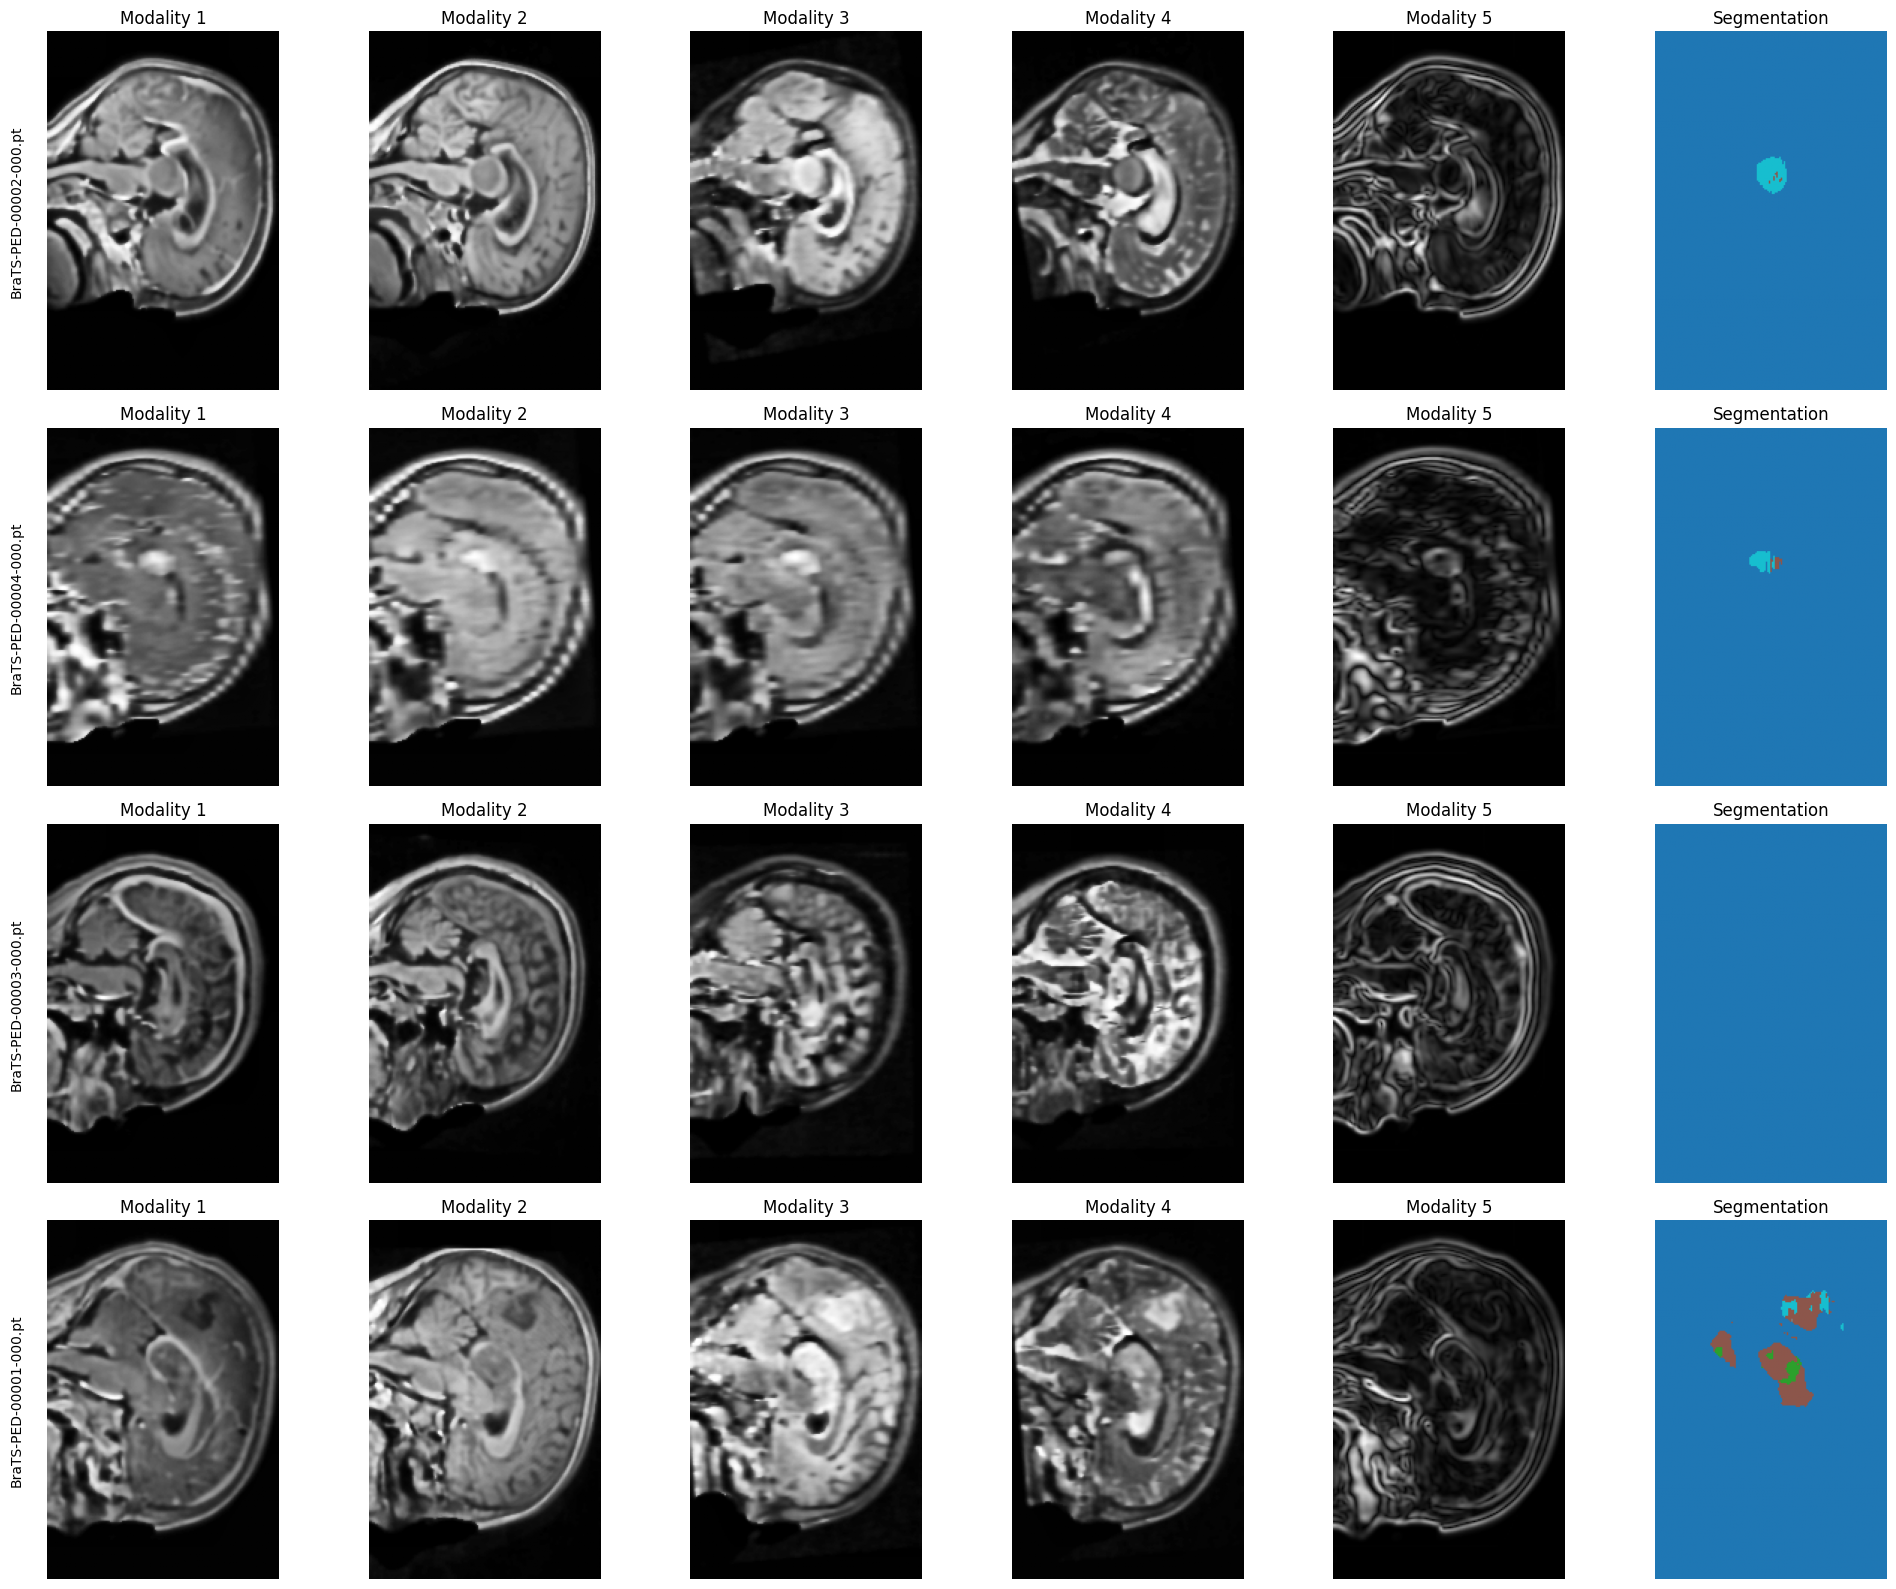


🧠 Initializing DenseTrans model...
Model parameters: 0.60M

=== MODEL LEARNING TEST ===


Learning Test Epoch 1: 100%|██████████| 240/240 [02:35<00:00,  1.54it/s, loss=1, dice=0.5]


Epoch 1: Loss=0.9421, Dice=0.2895, Grad Norm=8394.0971


Learning Test Epoch 2: 100%|██████████| 240/240 [02:36<00:00,  1.54it/s, loss=0.533, dice=1]


Epoch 2: Loss=0.8691, Dice=0.4679, Grad Norm=nan


Learning Test Epoch 3: 100%|██████████| 240/240 [02:35<00:00,  1.54it/s, loss=nan, dice=1]


Epoch 3: Loss=nan, Dice=0.3895, Grad Norm=nan


Learning Test Epoch 4: 100%|██████████| 240/240 [02:35<00:00,  1.54it/s, loss=nan, dice=2.53e-6]


Epoch 4: Loss=nan, Dice=0.5198, Grad Norm=nan


Learning Test Epoch 5: 100%|██████████| 240/240 [02:36<00:00,  1.53it/s, loss=nan, dice=7.88e-7]


Epoch 5: Loss=nan, Dice=0.5188, Grad Norm=nan

=== MODEL PREDICTION VISUALIZATION ===


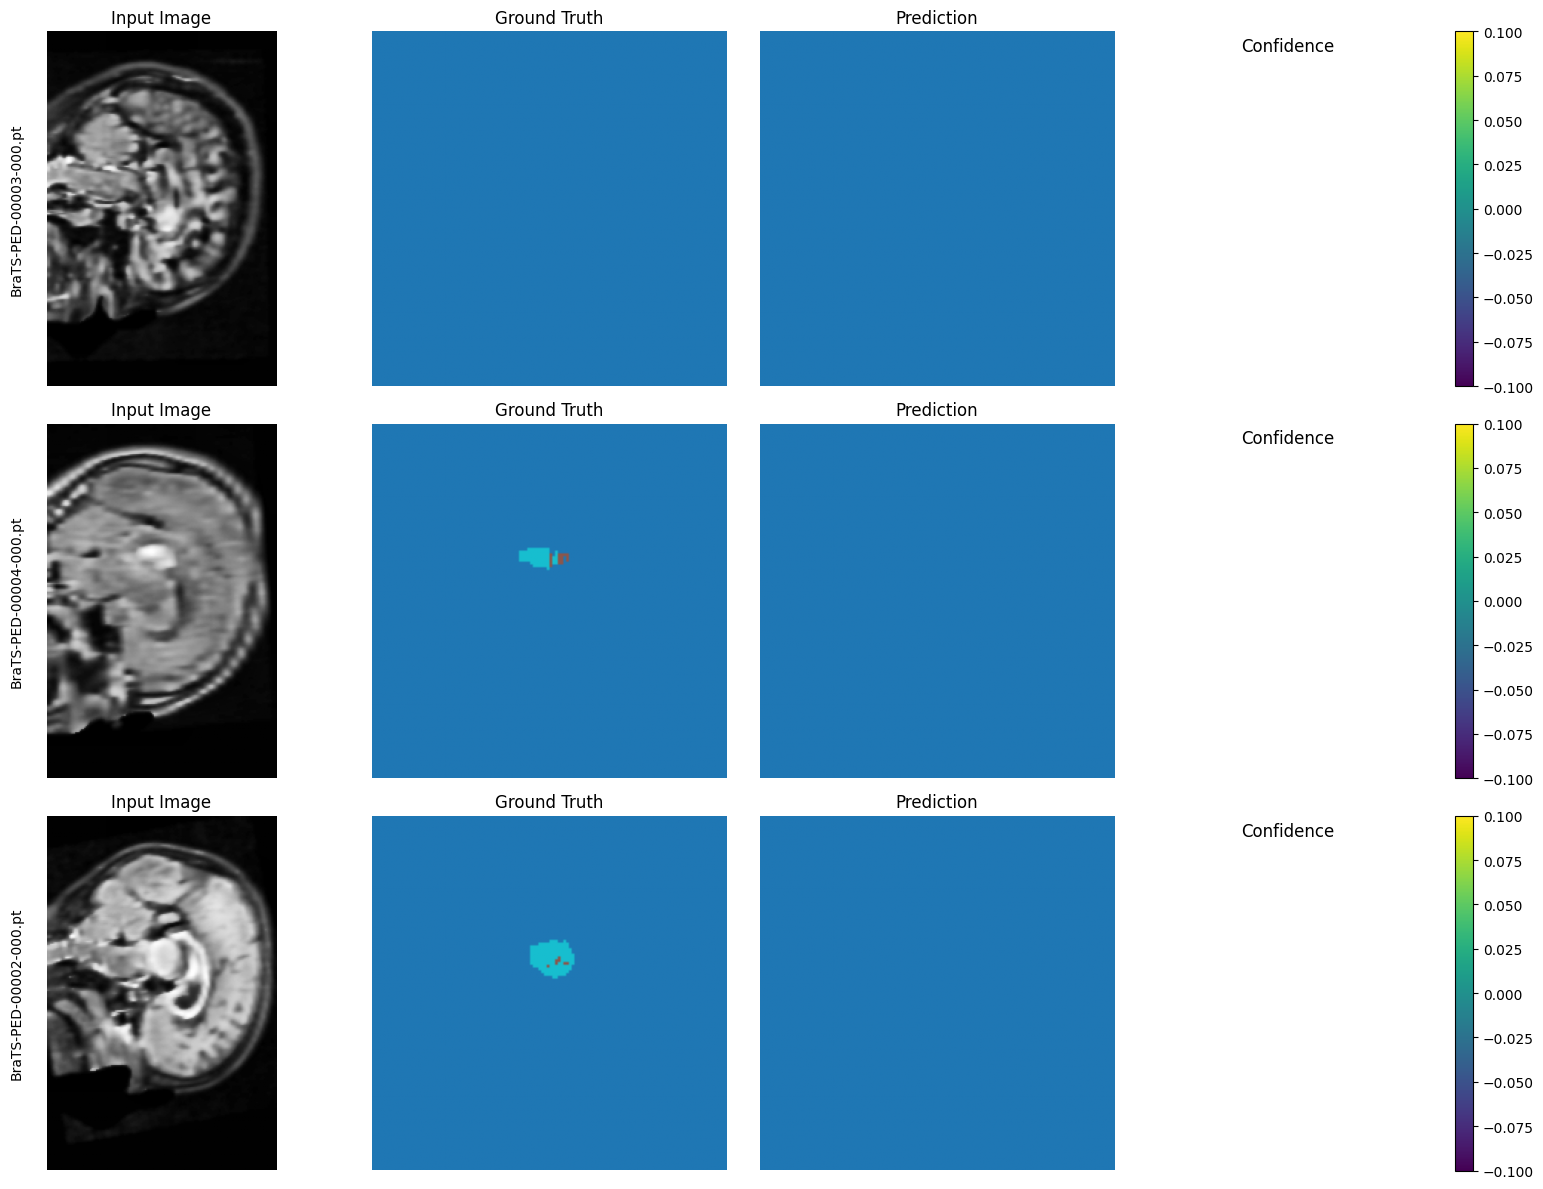


=== LEARNING METRICS VISUALIZATION ===


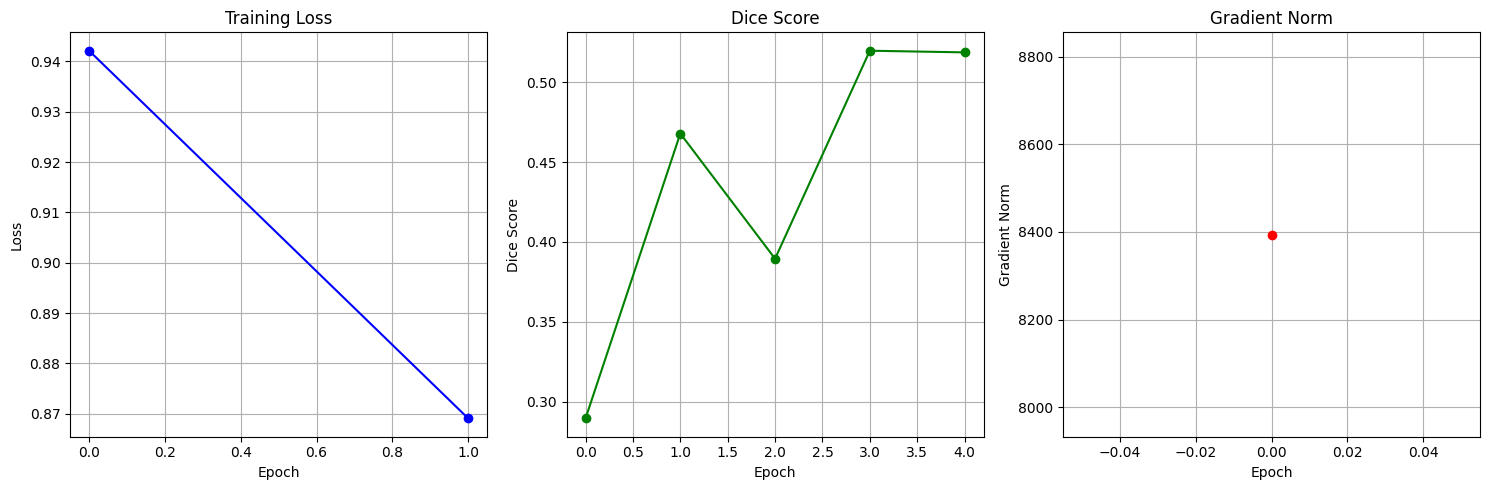


FINAL VALIDATION REPORT

📊 SCAN STATISTICS:
   Total scans processed: 4
   Valid scans: 4 (100.0%)
   Corrupted scans: 0 (0.0%)
   Missing scans: 0 (0.0%)

📏 PREPROCESSING QUALITY:
   Unique image shapes: [(5, 240, 240, 155), (5, 237, 240, 155)]
   Intensity ranges: min=0.00 to max=255.00
   Label classes found: [0, 1, 2, 3, 4]

🧠 MODEL LEARNING ASSESSMENT:
   Initial loss: 0.9421
   Final loss: nan
   Loss reduction: nan%
   Initial Dice: 0.2895
   Final Dice: 0.5188
   Dice improvement: 0.2293

✅ LEARNING QUALITY INDICATORS:
   Model is learning: ✗
   Gradients are stable: ✗
   Loss is decreasing: ✗
   Dice is improving: ✓

🎯 RECOMMENDATIONS:
   ✅ Excellent preprocessing quality - proceed with full training
   ⚠️  Model learning is suboptimal - check data quality

📁 CORRUPTED SCANS:


🔍 ADDITIONAL DATA QUALITY CHECKS:
Checking for potential data leakage...

💾 GPU Memory Usage:
   Allocated: 0.02 GB
   Reserved: 0.51 GB

✅ Validation completed! Check the generated visualizations:
   

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import kornia.filters as K
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
SCAN_DIR = "/content/drive/MyDrive/InputScans_Final"
SOURCE_DIR = "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/BraTS-PEDs2024_Training"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4  # Smaller batch size for validation
NUM_WORKERS = 2
IN_CHANNELS = 15  # 5 modalities * 3 slices
OUT_CHANNELS = 5  # 4 labels + 1 background
CROP_SIZE = (128, 128)

# --- Model Architecture (Same as provided) ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.InstanceNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.InstanceNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.InstanceNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class SwinTransformerBlock2D(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = nn.functional.pad(x, (0, 0, 0, pad_w, 0, pad_h))
        padded_H, padded_W = H + pad_h, W + pad_w
        windows = rearrange(x, 'b (h p1) (w p2) c -> (b h w) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        attn_windows, _ = self.attn(windows, windows, windows)
        x = rearrange(attn_windows, '(b h w) (p1 p2) c -> b (h p1) (w p2) c', h=padded_H//self.window_size, w=padded_W//self.window_size, p1=self.window_size, p2=self.window_size)
        x = x[:, :H, :W, :].permute(0, 3, 1, 2)
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if self.use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]

            if self.attention_gate and len(skip_inputs) > 0:
                g = x_input
                x_skip = skip_inputs[0]
                attended_skip = self.attention_gate(g=g, x=x_skip)
                skip_inputs = [attended_skip] + list(skip_inputs[1:])

            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)

            x_conv = self.conv(x_input)
            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)
            return x_conv

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)
        return checkpoint(custom_forward, *all_inputs, use_reentrant=True)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        ag10 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True, attention_gate=ag10)

        self.up20 = self.up(filters[2], filters[1])
        ag20 = AttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True, attention_gate=ag20)

        self.up30 = self.up(filters[3], filters[2])
        ag30 = AttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True, attention_gate=ag30)

        self.up11 = self.up(filters[1], filters[0])
        ag11 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True, attention_gate=ag11)

        self.up21 = self.up(filters[2], filters[1])
        ag21 = AttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True, attention_gate=ag21)

        self.up12 = self.up(filters[1], filters[0])
        ag12 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True, attention_gate=ag12)

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Loss Function ---
class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2)
        loss = 0
        for i in range(1, OUT_CHANNELS):
            y_true = targets_one_hot[:, i, :, :]
            y_pred = inputs[:, i, :, :]
            tp = (y_true * y_pred).sum()
            fp = ((1 - y_true) * y_pred).sum()
            fn = (y_true * (1 - y_pred)).sum()
            tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
            focal_tversky = (1 - tversky_index)**self.gamma
            loss += focal_tversky
        return loss / (OUT_CHANNELS - 1)

# --- Dataset for Validation ---
class ValidationDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.slice_map = []

        for i, path in enumerate(file_paths):
            if not os.path.exists(path):
                continue
            try:
                data = torch.load(path, map_location='cpu', weights_only=True)
                num_slices = data['image'].shape[1]
                for j in range(num_slices):
                    self.slice_map.append((i, j))
            except Exception as e:
                print(f"Error loading {path}: {e}")
                continue

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]
        path = self.file_paths[scan_idx]

        try:
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float()
            label_vol = data['label'].long()

            target_slice = image_vol[:, slice_idx, :, :]
            target_label = label_vol[slice_idx, :, :]
            prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
            next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]

            stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

            # Resize to expected dimensions
            stacked_slices = nn.functional.interpolate(
                stacked_slices.unsqueeze(0), size=CROP_SIZE,
                mode='bilinear', align_corners=False
            ).squeeze(0)
            target_label = nn.functional.interpolate(
                target_label.unsqueeze(0).unsqueeze(0).float(),
                size=CROP_SIZE, mode='nearest'
            ).squeeze(0).squeeze(0).long()

            return stacked_slices, target_label, path, slice_idx

        except Exception as e:
            print(f"Error processing slice {slice_idx} from {path}: {e}")
            # Return dummy data
            return torch.zeros(IN_CHANNELS, *CROP_SIZE), torch.zeros(*CROP_SIZE, dtype=torch.long), path, slice_idx

# --- Validation Functions ---
def validate_scan_integrity(scan_paths):
    """Check basic integrity of preprocessed scans"""
    print("=== SCAN INTEGRITY VALIDATION ===")

    integrity_results = {
        'valid_scans': [],
        'corrupted_scans': [],
        'missing_scans': [],
        'scan_statistics': {}
    }

    for scan_path in tqdm(scan_paths, desc="Validating scan integrity"):
        if not os.path.exists(scan_path):
            integrity_results['missing_scans'].append(scan_path)
            continue

        try:
            data = torch.load(scan_path, map_location='cpu', weights_only=True)

            # Check required keys
            if 'image' not in data or 'label' not in data:
                integrity_results['corrupted_scans'].append(scan_path)
                continue

            image_vol = data['image']
            label_vol = data['label']

            # Check shapes
            if len(image_vol.shape) != 4 or len(label_vol.shape) != 3:
                integrity_results['corrupted_scans'].append(scan_path)
                continue

            # Check for NaN/Inf values
            if torch.isnan(image_vol).any() or torch.isinf(image_vol).any():
                integrity_results['corrupted_scans'].append(scan_path)
                continue

            # Collect statistics
            scan_name = os.path.basename(scan_path)
            integrity_results['scan_statistics'][scan_name] = {
                'image_shape': tuple(image_vol.shape),
                'label_shape': tuple(label_vol.shape),
                'image_range': (float(image_vol.min()), float(image_vol.max())),
                'label_classes': torch.unique(label_vol).tolist(),
                'num_slices': image_vol.shape[1]
            }

            integrity_results['valid_scans'].append(scan_path)

        except Exception as e:
            print(f"Error validating {scan_path}: {e}")
            integrity_results['corrupted_scans'].append(scan_path)

    print(f"Valid scans: {len(integrity_results['valid_scans'])}")
    print(f"Corrupted scans: {len(integrity_results['corrupted_scans'])}")
    print(f"Missing scans: {len(integrity_results['missing_scans'])}")

    return integrity_results

def visualize_scans(scan_paths, num_samples=5):
    """Visualize sample scans to check preprocessing quality"""
    print("\n=== SCAN VISUALIZATION ===")

    sample_paths = random.sample(scan_paths, min(num_samples, len(scan_paths)))

    fig, axes = plt.subplots(len(sample_paths), 6, figsize=(20, 4*len(sample_paths)))
    if len(sample_paths) == 1:
        axes = axes.reshape(1, -1)

    for row, scan_path in enumerate(sample_paths):
        try:
            data = torch.load(scan_path, map_location='cpu', weights_only=True)
            image_vol = data['image'].numpy()
            label_vol = data['label'].numpy()

            # Select middle slice
            mid_slice = image_vol.shape[1] // 2

            # Show different modalities
            for col in range(5):  # 5 modalities
                if col < image_vol.shape[0]:
                    axes[row, col].imshow(image_vol[col, mid_slice], cmap='gray')
                    axes[row, col].set_title(f'Modality {col+1}')
                    axes[row, col].axis('off')

            # Show segmentation
            axes[row, 5].imshow(label_vol[mid_slice], cmap='tab10')
            axes[row, 5].set_title('Segmentation')
            axes[row, 5].axis('off')

            # Add scan name as row label
            scan_name = os.path.basename(scan_path)
            axes[row, 0].text(-0.1, 0.5, scan_name, rotation=90,
                            transform=axes[row, 0].transAxes, ha='right', va='center')

        except Exception as e:
            print(f"Error visualizing {scan_path}: {e}")
            for col in range(6):
                axes[row, col].text(0.5, 0.5, f'Error: {str(e)[:30]}...',
                                  ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('scan_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

def test_model_learning(model, scan_paths, num_epochs=5):
    """Test if model can learn from the preprocessed scans"""
    print("\n=== MODEL LEARNING TEST ===")

    # Create dataset and dataloader
    dataset = ValidationDataset(scan_paths[:10])  # Use subset for quick test
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    # Initialize optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = AsymmetricFocalTverskyLoss().to(DEVICE)
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    learning_metrics = {
        'epoch_losses': [],
        'epoch_dice_scores': [],
        'gradient_norms': []
    }

    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_dice = 0.0
        gradient_norms = []

        pbar = tqdm(dataloader, desc=f"Learning Test Epoch {epoch+1}")
        for batch_idx, (inputs, targets, paths, slice_ids) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                if isinstance(outputs, list):
                    loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                    main_output = outputs[-1]
                else:
                    loss = loss_fn(outputs, targets)
                    main_output = outputs

            scaler.scale(loss).backward()

            # Calculate gradient norm
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
            gradient_norms.append(total_norm)

            scaler.step(optimizer)
            scaler.update()

            # Calculate Dice score
            with torch.no_grad():
                pred_probs = torch.softmax(main_output, dim=1)
                pred_labels = torch.argmax(pred_probs, dim=1)
                dice = calculate_dice_score(pred_labels, targets)
                epoch_dice += dice

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item(), 'dice': dice})

        avg_loss = epoch_loss / len(dataloader)
        avg_dice = epoch_dice / len(dataloader)
        avg_grad_norm = np.mean(gradient_norms)

        learning_metrics['epoch_losses'].append(avg_loss)
        learning_metrics['epoch_dice_scores'].append(avg_dice)
        learning_metrics['gradient_norms'].append(avg_grad_norm)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Dice={avg_dice:.4f}, Grad Norm={avg_grad_norm:.4f}")

    return learning_metrics

def calculate_dice_score(pred, target, smooth=1e-5):
    """Calculate Dice score for segmentation"""
    dice_scores = []
    for class_idx in range(1, OUT_CHANNELS):  # Skip background
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()

        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

def visualize_model_predictions(model, scan_paths, num_samples=3):
    """Visualize model predictions on sample data"""
    print("\n=== MODEL PREDICTION VISUALIZATION ===")

    model.eval()
    sample_paths = random.sample(scan_paths, min(num_samples, len(scan_paths)))

    fig, axes = plt.subplots(len(sample_paths), 4, figsize=(16, 4*len(sample_paths)))
    if len(sample_paths) == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for row, scan_path in enumerate(sample_paths):
            try:
                # Load and process one slice
                data = torch.load(scan_path, map_location='cpu', weights_only=True)
                image_vol = data['image'].float()
                label_vol = data['label'].long()

                mid_slice = image_vol.shape[1] // 2

                # Create 2.5D input
                target_slice = image_vol[:, mid_slice, :, :]
                prev_slice = image_vol[:, max(0, mid_slice - 1), :, :]
                next_slice = image_vol[:, min(image_vol.shape[1] - 1, mid_slice + 1), :, :]

                stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)
                stacked_slices = nn.functional.interpolate(
                    stacked_slices.unsqueeze(0), size=CROP_SIZE,
                    mode='bilinear', align_corners=False
                )

                target_label = nn.functional.interpolate(
                    label_vol[mid_slice:mid_slice+1].unsqueeze(0).float(),
                    size=CROP_SIZE, mode='nearest'
                ).squeeze().long()

                # Get model prediction
                input_tensor = stacked_slices.to(DEVICE)
                outputs = model(input_tensor)
                if isinstance(outputs, list):
                    prediction = outputs[-1]
                else:
                    prediction = outputs

                pred_probs = torch.softmax(prediction, dim=1)
                pred_labels = torch.argmax(pred_probs, dim=1).cpu().numpy()[0]

                # Visualize
                # Original image (middle modality)
                axes[row, 0].imshow(target_slice[2].numpy(), cmap='gray')
                axes[row, 0].set_title('Input Image')
                axes[row, 0].axis('off')

                # Ground truth
                axes[row, 1].imshow(target_label.numpy(), cmap='tab10')
                axes[row, 1].set_title('Ground Truth')
                axes[row, 1].axis('off')

                # Prediction
                axes[row, 2].imshow(pred_labels, cmap='tab10')
                axes[row, 2].set_title('Prediction')
                axes[row, 2].axis('off')

                # Confidence map (max probability across classes)
                confidence = torch.max(pred_probs, dim=1)[0].cpu().numpy()[0]
                im = axes[row, 3].imshow(confidence, cmap='viridis')
                axes[row, 3].set_title('Confidence')
                axes[row, 3].axis('off')
                plt.colorbar(im, ax=axes[row, 3])

                scan_name = os.path.basename(scan_path)
                axes[row, 0].text(-0.1, 0.5, scan_name, rotation=90,
                                transform=axes[row, 0].transAxes, ha='right', va='center')

            except Exception as e:
                print(f"Error in prediction visualization for {scan_path}: {e}")
                for col in range(4):
                    axes[row, col].text(0.5, 0.5, f'Error: {str(e)[:20]}...',
                                      ha='center', va='center', transform=axes[row, col].transAxes)
                    axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('model_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_learning_metrics(learning_metrics):
    """Plot learning curves"""
    print("\n=== LEARNING METRICS VISUALIZATION ===")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Loss curve
    axes[0].plot(learning_metrics['epoch_losses'], 'b-o')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)

    # Dice score curve
    axes[1].plot(learning_metrics['epoch_dice_scores'], 'g-o')
    axes[1].set_title('Dice Score')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].grid(True)

    # Gradient norm curve
    axes[2].plot(learning_metrics['gradient_norms'], 'r-o')
    axes[2].set_title('Gradient Norm')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Gradient Norm')
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig('learning_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

def generate_final_report(integrity_results, learning_metrics, scan_paths):
    """Generate comprehensive validation report"""
    print("\n" + "="*50)
    print("FINAL VALIDATION REPORT")
    print("="*50)

    total_scans = len(scan_paths)
    valid_scans = len(integrity_results['valid_scans'])
    corrupted_scans = len(integrity_results['corrupted_scans'])
    missing_scans = len(integrity_results['missing_scans'])

    print(f"\n📊 SCAN STATISTICS:")
    print(f"   Total scans processed: {total_scans}")
    print(f"   Valid scans: {valid_scans} ({valid_scans/total_scans*100:.1f}%)")
    print(f"   Corrupted scans: {corrupted_scans} ({corrupted_scans/total_scans*100:.1f}%)")
    print(f"   Missing scans: {missing_scans} ({missing_scans/total_scans*100:.1f}%)")

    if integrity_results['scan_statistics']:
        print(f"\n📏 PREPROCESSING QUALITY:")
        shapes = [stats['image_shape'] for stats in integrity_results['scan_statistics'].values()]
        unique_shapes = list(set(shapes))
        print(f"   Unique image shapes: {unique_shapes}")

        ranges = [stats['image_range'] for stats in integrity_results['scan_statistics'].values()]
        min_values = [r[0] for r in ranges]
        max_values = [r[1] for r in ranges]
        print(f"   Intensity ranges: min={min(min_values):.2f} to max={max(max_values):.2f}")

        all_classes = set()
        for stats in integrity_results['scan_statistics'].values():
            all_classes.update(stats['label_classes'])
        print(f"   Label classes found: {sorted(list(all_classes))}")

    if learning_metrics:
        print(f"\n🧠 MODEL LEARNING ASSESSMENT:")
        initial_loss = learning_metrics['epoch_losses'][0]
        final_loss = learning_metrics['epoch_losses'][-1]
        loss_reduction = (initial_loss - final_loss) / initial_loss * 100

        initial_dice = learning_metrics['epoch_dice_scores'][0]
        final_dice = learning_metrics['epoch_dice_scores'][-1]
        dice_improvement = final_dice - initial_dice

        print(f"   Initial loss: {initial_loss:.4f}")
        print(f"   Final loss: {final_loss:.4f}")
        print(f"   Loss reduction: {loss_reduction:.1f}%")
        print(f"   Initial Dice: {initial_dice:.4f}")
        print(f"   Final Dice: {final_dice:.4f}")
        print(f"   Dice improvement: {dice_improvement:.4f}")

        # Learning assessment
        is_learning = loss_reduction > 10 and dice_improvement > 0.01
        gradient_stable = np.std(learning_metrics['gradient_norms']) < np.mean(learning_metrics['gradient_norms'])

        print(f"\n✅ LEARNING QUALITY INDICATORS:")
        print(f"   Model is learning: {'✓' if is_learning else '✗'}")
        print(f"   Gradients are stable: {'✓' if gradient_stable else '✗'}")
        print(f"   Loss is decreasing: {'✓' if loss_reduction > 0 else '✗'}")
        print(f"   Dice is improving: {'✓' if dice_improvement > 0 else '✗'}")

    print(f"\n🎯 RECOMMENDATIONS:")
    if valid_scans / total_scans >= 0.95:
        print("   ✅ Excellent preprocessing quality - proceed with full training")
    elif valid_scans / total_scans >= 0.90:
        print("   ⚠️  Good preprocessing quality - minor issues detected")
    else:
        print("   ❌ Poor preprocessing quality - investigate corrupted scans")

    if learning_metrics and is_learning:
        print("   ✅ Model shows good learning capacity on preprocessed data")
    elif learning_metrics:
        print("   ⚠️  Model learning is suboptimal - check data quality")

    print(f"\n📁 CORRUPTED SCANS:")
    for scan in integrity_results['corrupted_scans'][:10]:  # Show first 10
        print(f"   - {os.path.basename(scan)}")
    if len(integrity_results['corrupted_scans']) > 10:
        print(f"   ... and {len(integrity_results['corrupted_scans']) - 10} more")

    print("\n" + "="*50)

def main():
    """Main validation pipeline"""
    print("🔍 BRAIN TUMOR SEGMENTATION DATA VALIDATION")
    print(f"📂 Scan directory: {SCAN_DIR}")
    print(f"🖥️  Device: {DEVICE}")

    # Find all .pt files
    scan_pattern = os.path.join(SCAN_DIR, "*.pt")
    all_scan_paths = glob.glob(scan_pattern)

    if not all_scan_paths:
        print(f"❌ No .pt files found in {SCAN_DIR}")
        print("Please check the path and ensure preprocessed files are available.")
        return

    print(f"📊 Found {len(all_scan_paths)} scan files")

    # Step 1: Validate scan integrity
    integrity_results = validate_scan_integrity(all_scan_paths)

    if not integrity_results['valid_scans']:
        print("❌ No valid scans found. Cannot proceed with model testing.")
        return

    # Step 2: Visualize sample scans
    visualize_scans(integrity_results['valid_scans'][:10])

    # Step 3: Initialize model
    print("\n🧠 Initializing DenseTrans model...")
    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS).to(DEVICE)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params/1e6:.2f}M")

    # Step 4: Test model learning
    learning_metrics = test_model_learning(model, integrity_results['valid_scans'])

    # Step 5: Visualize predictions
    visualize_model_predictions(model, integrity_results['valid_scans'][:5])

    # Step 6: Plot learning metrics
    plot_learning_metrics(learning_metrics)

    # Step 7: Generate final report
    generate_final_report(integrity_results, learning_metrics, all_scan_paths)

    # Additional data quality checks
    print("\n🔍 ADDITIONAL DATA QUALITY CHECKS:")

    # Check for data leakage (similar scans)
    print("Checking for potential data leakage...")
    sample_scans = random.sample(integrity_results['valid_scans'], min(5, len(integrity_results['valid_scans'])))

    for i, scan1 in enumerate(sample_scans):
        try:
            data1 = torch.load(scan1, map_location='cpu', weights_only=True)
            image1 = data1['image']

            for j, scan2 in enumerate(sample_scans[i+1:], i+1):
                data2 = torch.load(scan2, map_location='cpu', weights_only=True)
                image2 = data2['image']

                # Simple similarity check (mean squared difference)
                if image1.shape == image2.shape:
                    mse = torch.mean((image1 - image2) ** 2).item()
                    if mse < 0.01:  # Very similar
                        print(f"⚠️  High similarity between {os.path.basename(scan1)} and {os.path.basename(scan2)}: MSE={mse:.6f}")
        except Exception as e:
            print(f"Error in similarity check: {e}")

    # Memory usage check
    try:
        if torch.cuda.is_available():
            print(f"\n💾 GPU Memory Usage:")
            print(f"   Allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
            print(f"   Reserved: {torch.cuda.memory_reserved()/1024**3:.2f} GB")
    except:
        pass

    print(f"\n✅ Validation completed! Check the generated visualizations:")
    print(f"   - scan_visualization.png: Sample scan quality")
    print(f"   - model_predictions.png: Model prediction examples")
    print(f"   - learning_metrics.png: Learning curve analysis")

    # Save detailed results
    results_summary = {
        'total_scans': len(all_scan_paths),
        'valid_scans': len(integrity_results['valid_scans']),
        'corrupted_scans': len(integrity_results['corrupted_scans']),
        'missing_scans': len(integrity_results['missing_scans']),
        'learning_metrics': learning_metrics,
        'corrupted_files': [os.path.basename(f) for f in integrity_results['corrupted_scans']]
    }

    import json
    with open('validation_results.json', 'w') as f:
        json.dump(results_summary, f, indent=2)
    print(f"   - validation_results.json: Detailed results summary")

if __name__ == "__main__":
    main()

# Deeper model - 15M parameters

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import warnings
warnings.filterwarnings("ignore")

# --- Enhanced Configuration & Hyperparameters ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "./best_model_final.pt"

# Memory Management Settings for L4 GPU (22.5GB VRAM, 58GB RAM)
MAX_CACHED_SCANS = 3  # Cache only 3 scans in memory at once
MEMORY_CLEANUP_FREQ = 50  # Clean memory every 50 batches
PREFETCH_FACTOR = 2  # Prefetch factor for DataLoader

# Training Hyperparameters - Optimized for L4 GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 300  # Increased for better convergence
INITIAL_LR = 8e-5  # Further reduced for stability
MAX_LR = 3e-4  # For OneCycle scheduler
BATCH_SIZE = 6  # Reduced for L4 GPU memory constraints
NUM_WORKERS = 2  # Reduced to save RAM
WEIGHT_DECAY = 5e-7  # Further reduced
EARLY_STOPPING_PATIENCE = 25
SCANS_PER_EPOCH = 6  # Reduced for memory efficiency
VAL_SCANS_PER_EPOCH = 3

# Enhanced 2.5D processing
IN_CHANNELS = 15  # 5 modalities * 3 slices
OUT_CHANNELS = 5  # 4 labels + 1 background
CROP_SIZE = (144, 144)  # Slightly reduced for memory efficiency
DROPOUT_RATE = 0.12
GRADIENT_CLIP_VAL = 0.8  # Reduced for better stability

# --- Enhanced Data Augmentation ---
class AdvancedAugmentation:
    def __init__(self, crop_size=(144, 144)):
        self.crop_size = crop_size

    def random_crop_2d(self, img, label):
        h, w = img.shape[1:]
        ch, cw = self.crop_size

        if h < ch or w < cw:
            pad_h = max(0, ch - h)
            pad_w = max(0, cw - w)
            img = F.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
            label = F.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
            h, w = img.shape[1:]

        y = random.randint(0, max(0, h - ch))
        x = random.randint(0, max(0, w - cw))
        return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

    def apply_augmentation(self, img, label, is_training=True):
        if not is_training:
            # For validation, just resize
            img = F.interpolate(img.unsqueeze(0), size=self.crop_size,
                              mode='bilinear', align_corners=False).squeeze(0)
            label = F.interpolate(label.unsqueeze(0).unsqueeze(0).float(),
                                size=self.crop_size, mode='nearest').squeeze(0).squeeze(0).long()
            return img, label

        # Random crop
        img, label = self.random_crop_2d(img, label)

        # Random horizontal flip
        if random.random() > 0.5:
            img = torch.flip(img, [2])
            label = torch.flip(label, [1])

        # Random rotation (small angles)
        if random.random() > 0.7:
            angle = random.uniform(-15, 15)
            img = self.rotate_tensor(img, angle)
            label = self.rotate_tensor(label.unsqueeze(0).float(), angle, is_label=True).squeeze(0).long()

        # Intensity augmentation
        if random.random() > 0.6:
            # Random gamma correction
            gamma = random.uniform(0.8, 1.2)
            img = torch.pow(img.clamp(min=0) + 1e-7, gamma)

            # Random noise
            if random.random() > 0.8:
                noise = torch.randn_like(img) * 0.05
                img = img + noise

        return img, label

    def rotate_tensor(self, tensor, angle, is_label=False):
        # Simple rotation using grid_sample
        angle_rad = torch.tensor(angle * np.pi / 180.0)
        cos_a = torch.cos(angle_rad)
        sin_a = torch.sin(angle_rad)

        # Create rotation matrix
        theta = torch.tensor([[cos_a, -sin_a, 0],
                            [sin_a, cos_a, 0]], dtype=torch.float32)

        if tensor.dim() == 3:
            tensor = tensor.unsqueeze(0)
            squeeze_back = True
        else:
            squeeze_back = False

        grid = F.affine_grid(theta.unsqueeze(0), tensor.size(), align_corners=False)
        mode = 'nearest' if is_label else 'bilinear'
        rotated = F.grid_sample(tensor, grid, mode=mode, align_corners=False)

        if squeeze_back:
            rotated = rotated.squeeze(0)

        return rotated

class MemoryEfficientBraTSDataset(Dataset):
    """Memory-efficient dataset that streams from Google Drive with LRU cache"""
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.slice_map = []
        self.scan_cache = {}  # LRU cache for scans
        self.cache_order = []  # Track access order for LRU
        self.augmenter = AdvancedAugmentation(CROP_SIZE)

        print(f"🔄 Initializing memory-efficient dataset with {len(file_paths)} files...")

        # Build slice map without loading data
        for i, path in enumerate(tqdm(file_paths, desc="Building slice map")):
            if not os.path.exists(path):
                print(f"⚠️ File not found: {path}")
                continue

            try:
                # Quick check of scan dimensions without fully loading
                data = torch.load(path, map_location='cpu', weights_only=True)
                num_slices = data['image'].shape[1]

                # Skip slices with minimal brain content (edges)
                start_slice = max(5, num_slices // 10)
                end_slice = min(num_slices - 5, 9 * num_slices // 10)

                for j in range(start_slice, end_slice):
                    self.slice_map.append((i, j))

                # Immediately free memory
                del data
                gc.collect()

            except Exception as e:
                print(f"⚠️ Error checking {path}: {e}")
                continue

        print(f"✅ Dataset initialized with {len(self.slice_map)} slices from {len(file_paths)} scans")

    def _load_scan_with_cache(self, scan_idx):
        """Load scan with LRU caching to manage memory"""
        if scan_idx in self.scan_cache:
            # Move to end (most recently used)
            self.cache_order.remove(scan_idx)
            self.cache_order.append(scan_idx)
            return self.scan_cache[scan_idx]

        # Load new scan
        path = self.file_paths[scan_idx]
        try:
            data = torch.load(path, map_location='cpu', weights_only=True)

            # Add to cache
            self.scan_cache[scan_idx] = data
            self.cache_order.append(scan_idx)

            # Maintain cache size limit
            while len(self.scan_cache) > MAX_CACHED_SCANS:
                oldest_scan = self.cache_order.pop(0)
                if oldest_scan in self.scan_cache:
                    del self.scan_cache[oldest_scan]

            # Periodic memory cleanup
            if len(self.cache_order) % MEMORY_CLEANUP_FREQ == 0:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            return data

        except Exception as e:
            print(f"❌ Error loading {path}: {e}")
            # Return dummy data if loading fails
            return {
                'image': torch.zeros(5, 100, 240, 240),
                'label': torch.zeros(100, 240, 240, dtype=torch.long)
            }

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        # Load scan data with caching
        scan_data = self._load_scan_with_cache(scan_idx)

        image_vol = scan_data['image'].float()
        label_vol = scan_data['label'].long()

        # Handle potential dimension mismatches
        if slice_idx >= image_vol.shape[1]:
            slice_idx = min(slice_idx, image_vol.shape[1] - 1)

        # Get 2.5D slice context with bounds checking
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]

        prev_idx = max(0, slice_idx - 1)
        next_idx = min(image_vol.shape[1] - 1, slice_idx + 1)

        prev_slice = image_vol[:, prev_idx, :, :]
        next_slice = image_vol[:, next_idx, :, :]

        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        # Enhanced normalization with outlier handling
        stacked_slices = torch.clamp(stacked_slices, 0, 255)

        # Robust normalization per modality
        for i in range(0, stacked_slices.shape[0], 3):  # Every 3 channels (prev, curr, next)
            modality_slices = stacked_slices[i:i+3]
            if modality_slices.max() > 0:
                # Percentile-based normalization for robustness
                p99 = torch.quantile(modality_slices, 0.99)
                p1 = torch.quantile(modality_slices, 0.01)
                modality_slices = torch.clamp(modality_slices, p1, p99)
                modality_slices = (modality_slices - p1) / (p99 - p1 + 1e-8)
                stacked_slices[i:i+3] = modality_slices

        # Apply augmentation
        try:
            stacked_slices, target_label = self.augmenter.apply_augmentation(
                stacked_slices, target_label, self.transform)
        except Exception as e:
            print(f"⚠️ Augmentation error: {e}, using fallback")
            # Fallback: simple resize
            stacked_slices = F.interpolate(
                stacked_slices.unsqueeze(0), size=CROP_SIZE,
                mode='bilinear', align_corners=False
            ).squeeze(0)
            target_label = F.interpolate(
                target_label.unsqueeze(0).unsqueeze(0).float(),
                size=CROP_SIZE, mode='nearest'
            ).squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

    def cleanup_cache(self):
        """Manual cache cleanup"""
        self.scan_cache.clear()
        self.cache_order.clear()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# --- Enhanced Architecture Components ---
class LayerNorm2d(nn.Module):
    """2D Layer Normalization for better training stability"""
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight.unsqueeze(-1).unsqueeze(-1) * x + self.bias.unsqueeze(-1).unsqueeze(-1)
        return x

class EnhancedDepthwiseSeparableConv2d(nn.Module):
    """Enhanced depthwise separable convolution with better normalization"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                 stride=stride, padding=kernel_size//2 * dilation,
                                 groups=in_channels, dilation=dilation, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.norm1 = LayerNorm2d(in_channels)
        self.norm2 = LayerNorm2d(out_channels)
        self.act = nn.GELU()  # Better activation than ReLU
        self.dropout = nn.Dropout2d(DROPOUT_RATE)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.norm1(x)
        x = self.act(x)
        x = self.pointwise(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class MultiScaleAttentionGate(nn.Module):
    """Enhanced attention gate with multi-scale processing"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1, bias=False),
            LayerNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1, bias=False),
            LayerNorm2d(F_int)
        )

        # Multi-scale processing
        self.conv3x3 = nn.Conv2d(F_int, F_int//2, 3, padding=1, bias=False)
        self.conv5x5 = nn.Conv2d(F_int, F_int//2, 5, padding=2, bias=False)

        self.psi = nn.Sequential(
            LayerNorm2d(F_int),
            nn.Conv2d(F_int, 1, 1, bias=True),
            nn.Sigmoid()
        )
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Multi-scale attention
        psi_input = self.gelu(g1 + x1)
        psi_3 = self.conv3x3(psi_input)
        psi_5 = self.conv5x5(psi_input)
        psi = torch.cat([psi_3, psi_5], dim=1)

        psi = self.psi(psi)
        return x * psi

class EnhancedSwinTransformerBlock2D(nn.Module):
    """Enhanced Swin Transformer with better stability"""
    def __init__(self, dim, num_heads=8, window_size=8, mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = LayerNorm2d(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=DROPOUT_RATE,
                                        batch_first=True, bias=False)

        self.norm2 = LayerNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Conv2d(dim, mlp_hidden_dim, 1, bias=False),
            LayerNorm2d(mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(mlp_hidden_dim, dim, 1, bias=False),
            nn.Dropout2d(DROPOUT_RATE)
        )

        # Learnable scale parameters for residual connections
        self.gamma1 = nn.Parameter(torch.ones(dim, 1, 1) * 0.1)
        self.gamma2 = nn.Parameter(torch.ones(dim, 1, 1) * 0.1)

    def forward(self, x):
        B, C, H, W = x.shape
        shortcut = x

        # Attention branch
        x_norm = self.norm1(x)
        x_windows = self._partition_windows(x_norm)
        attn_windows, _ = self.attn(x_windows, x_windows, x_windows)
        x_attn = self._merge_windows(attn_windows, H, W)
        x = shortcut + self.gamma1 * x_attn

        # MLP branch
        shortcut2 = x
        x_mlp = self.mlp(self.norm2(x))
        x = shortcut2 + self.gamma2 * x_mlp

        return x

    def _partition_windows(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)  # B, H, W, C

        # Pad if needed
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))

        H_pad, W_pad = H + pad_h, W + pad_w
        x = x.view(B, H_pad // self.window_size, self.window_size,
                  W_pad // self.window_size, self.window_size, C)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        windows = windows.view(-1, self.window_size * self.window_size, C)
        return windows

    def _merge_windows(self, windows, H, W):
        B = windows.shape[0] // ((H + self.window_size - 1) // self.window_size *
                                (W + self.window_size - 1) // self.window_size)
        H_pad = ((H + self.window_size - 1) // self.window_size) * self.window_size
        W_pad = ((W + self.window_size - 1) // self.window_size) * self.window_size

        x = windows.view(B, H_pad // self.window_size, W_pad // self.window_size,
                        self.window_size, self.window_size, -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(B, H_pad, W_pad, -1)

        # Remove padding
        if H_pad > H or W_pad > W:
            x = x[:, :H, :W, :]

        x = x.permute(0, 3, 1, 2)  # B, C, H, W
        return x

class EnhancedUNetPlusPlusNode2D(nn.Module):
    """Enhanced UNet++ node with better skip connections"""
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None,
                 use_deep_supervision=False):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate
        self.use_deep_supervision = use_deep_supervision

        # Enhanced convolution blocks
        self.conv1 = EnhancedDepthwiseSeparableConv2d(in_channels, out_channels)
        self.conv2 = EnhancedDepthwiseSeparableConv2d(out_channels, out_channels)

        # Residual connection for same channel sizes
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

        if self.use_swin:
            self.swin = EnhancedSwinTransformerBlock2D(dim=out_channels)

        # Additional features for deep supervision
        if use_deep_supervision:
            self.aux_conv = nn.Conv2d(out_channels, out_channels//2, 3, padding=1)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = list(inputs[1:]) if len(inputs) > 1 else []

            # Apply attention to skip connections
            if self.attention_gate and skip_inputs:
                attended_skips = []
                for skip in skip_inputs:
                    if skip.shape[1] == x_input.shape[1]:  # Same channel size
                        attended_skip = self.attention_gate(g=x_input, x=skip)
                        attended_skips.append(attended_skip)
                    else:
                        attended_skips.append(skip)
                skip_inputs = attended_skips

            # Concatenate all inputs
            if skip_inputs:
                x_cat = torch.cat(skip_inputs + [x_input], dim=1)
            else:
                x_cat = x_input

            # Apply convolutions with residual connection
            residual = self.residual(x_cat)
            x_conv = self.conv1(x_cat)
            x_conv = self.conv2(x_conv) + residual

            # Apply Swin transformer if enabled
            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)

            return x_conv

        # Prepare inputs for checkpointing
        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)

        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class EnhancedDenseTrans2D(nn.Module):
    """Enhanced DenseTrans architecture with deeper network and better stability"""
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision

        # Increased filter sizes for better capacity (optimized for L4)
        filters = [64, 128, 256, 512, 1024]  # Reduced from [48, 96, 192, 384, 768]

        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, bias=False)

        # Encoder path with enhanced nodes
        self.x00 = EnhancedUNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = EnhancedUNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = EnhancedUNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = EnhancedUNetPlusPlusNode2D(filters[2], filters[3])
        self.x40 = EnhancedUNetPlusPlusNode2D(filters[3], filters[4])  # Additional deeper layer

        # Decoder path with attention gates
        self.up10 = self.up(filters[1], filters[0])
        ag10 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x01 = EnhancedUNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True, attention_gate=ag10)

        self.up20 = self.up(filters[2], filters[1])
        ag20 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x11 = EnhancedUNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True, attention_gate=ag20)

        self.up30 = self.up(filters[3], filters[2])
        ag30 = MultiScaleAttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x21 = EnhancedUNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True, attention_gate=ag30)

        self.up40 = self.up(filters[4], filters[3])
        ag40 = MultiScaleAttentionGate(F_g=filters[3], F_l=filters[3], F_int=filters[3]//2)
        self.x31 = EnhancedUNetPlusPlusNode2D(filters[3]*2, filters[3], use_swin=True, attention_gate=ag40)

        # Additional skip connections
        self.up11 = self.up(filters[1], filters[0])
        ag11 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x02 = EnhancedUNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True, attention_gate=ag11)

        self.up21 = self.up(filters[2], filters[1])
        ag21 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x12 = EnhancedUNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True, attention_gate=ag21)

        self.up31 = self.up(filters[3], filters[2])
        ag31 = MultiScaleAttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x22 = EnhancedUNetPlusPlusNode2D(filters[2]*3, filters[2], use_swin=True, attention_gate=ag31)

        self.up12 = self.up(filters[1], filters[0])
        ag12 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x03 = EnhancedUNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True, attention_gate=ag12)

        self.up22 = self.up(filters[2], filters[1])
        ag22 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x13 = EnhancedUNetPlusPlusNode2D(filters[1]*4, filters[1], use_swin=True, attention_gate=ag22)

        self.up13 = self.up(filters[1], filters[0])
        ag13 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x04 = EnhancedUNetPlusPlusNode2D(filters[0]*5, filters[0], use_swin=True, attention_gate=ag13)

        # Output heads with better final processing
        self.final1 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0]//2, 3, padding=1, bias=False),
            LayerNorm2d(filters[0]//2),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(filters[0]//2, out_channels, 1)
        )
        self.final2 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0]//2, 3, padding=1, bias=False),
            LayerNorm2d(filters[0]//2),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(filters[0]//2, out_channels, 1)
        )
        self.final3 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0]//2, 3, padding=1, bias=False),
            LayerNorm2d(filters[0]//2),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(filters[0]//2, out_channels, 1)
        )
        self.final4 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0]//2, 3, padding=1, bias=False),
            LayerNorm2d(filters[0]//2),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(filters[0]//2, out_channels, 1)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Proper weight initialization for training stability"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Use 'relu' for kaiming initialization (compatible with GELU)
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, LayerNorm2d)):
                if hasattr(m, 'weight') and m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder path
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x20 = self.x20(self.down(x10))
        x30 = self.x30(self.down(x20))
        x40 = self.x40(self.down(x30))

        # First level decoder
        x31 = self.x31(self.up40(x40), [x30])
        x21 = self.x21(self.up30(x31), [x20])
        x11 = self.x11(self.up20(x21), [x10])
        x01 = self.x01(self.up10(x11), [x00])

        # Second level decoder
        x22 = self.x22(self.up31(x31), [x20, x21])
        x12 = self.x12(self.up21(x22), [x10, x11])
        x02 = self.x02(self.up11(x12), [x00, x01])

        # Third level decoder
        x13 = self.x13(self.up22(x22), [x10, x11, x12])
        x03 = self.x03(self.up12(x13), [x00, x01, x02])

        # Fourth level decoder
        x04 = self.x04(self.up13(x13), [x00, x01, x02, x03])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03), self.final4(x04)]
        return self.final4(x04)

# --- Enhanced Loss Functions ---
class StableBoundaryLoss(nn.Module):
    """Numerically stable boundary loss"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Ensure numerical stability
        inputs = torch.softmax(inputs, dim=1)
        inputs = torch.clamp(inputs, min=self.smooth, max=1.0-self.smooth)

        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        # Use Sobel filters for more stable gradient computation
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(targets.device)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(targets.device)

        boundary_maps = []
        for i in range(OUT_CHANNELS):
            target_class = targets_one_hot[:, i:i+1, :, :]
            grad_x = F.conv2d(target_class, sobel_x, padding=1)
            grad_y = F.conv2d(target_class, sobel_y, padding=1)
            boundary = torch.sqrt(grad_x**2 + grad_y**2 + self.smooth)
            boundary_maps.append(boundary)

        boundary_mask = torch.cat(boundary_maps, dim=1)
        boundary_mask = (boundary_mask > 0.1).float()

        # Focus on boundary regions
        inputs_boundary = inputs * boundary_mask
        targets_boundary = targets_one_hot * boundary_mask

        # Compute Dice loss on boundaries
        dims = (2, 3)
        intersection = torch.sum(inputs_boundary * targets_boundary, dims)
        union = torch.sum(inputs_boundary + targets_boundary, dims)

        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        boundary_loss = 1. - dice_score.mean()

        return boundary_loss

class EnhancedCompositeLoss(nn.Module):
    """Enhanced composite loss with numerical stability"""
    def __init__(self, focal_weight=0.6, dice_weight=0.3, boundary_weight=0.1):
        super().__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.boundary_weight = boundary_weight

        self.focal_loss = StableFocalLoss()
        self.dice_loss = StableDiceLoss()
        self.boundary_loss = StableBoundaryLoss()

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        boundary = self.boundary_loss(inputs, targets)

        total_loss = (self.focal_weight * focal +
                     self.dice_weight * dice +
                     self.boundary_weight * boundary)

        return total_loss

class StableFocalLoss(nn.Module):
    """Numerically stable focal loss"""
    def __init__(self, alpha=0.25, gamma=2.0, smooth=1e-8):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply softmax and ensure numerical stability
        pred = F.softmax(inputs, dim=1)
        pred = torch.clamp(pred, min=self.smooth, max=1.0-self.smooth)

        # Convert targets to one-hot
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        # Compute focal loss
        ce_loss = -targets_one_hot * torch.log(pred)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        return focal_loss.mean()

class StableDiceLoss(nn.Module):
    """Numerically stable dice loss"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        dice_losses = []
        for i in range(1, OUT_CHANNELS):  # Skip background
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_losses.append(1 - dice)

        return torch.stack(dice_losses).mean()

# --- Enhanced Metrics ---
def get_stable_hausdorff_score(pred_np, target_np):
    """Numerically stable Hausdorff distance computation"""
    h95_scores = []
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)

        if len(pred_coords) > 0 and len(target_coords) > 0:
            try:
                h1 = directed_hausdorff(pred_coords, target_coords)[0]
                h2 = directed_hausdorff(target_coords, pred_coords)[0]
                h95_scores.append(max(h1, h2))
            except:
                h95_scores.append(0.0)
        else:
            h95_scores.append(0.0)

    return np.mean(h95_scores) if h95_scores else 0.0

def get_enhanced_dice_score(pred, target):
    """Enhanced dice score computation with numerical stability"""
    smooth = 1e-6
    pred = F.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)

    dice_scores = []
    for i in range(1, OUT_CHANNELS):
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

# --- Training Utilities ---
class ModelEMA:
    """Exponential Moving Average for model parameters"""
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

# --- Memory Management Utilities ---
def get_memory_info():
    """Get current memory usage information"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        return f"GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB"
    return "GPU not available"

def cleanup_memory():
    """Comprehensive memory cleanup"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# --- Enhanced Training Loop with Memory Management ---
def main():
    print("🚀 Enhanced DenseTrans 2.5D Training with Memory Management")
    print(f"💾 {get_memory_info()}")

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

    # Enable optimizations for L4 GPU
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        # Set memory allocation strategy
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

    # Check data availability
    if not os.path.exists(DATA_DIR):
        print(f"❌ ERROR: Data directory not found: {DATA_DIR}")
        print("Please ensure your Google Drive is mounted and the path is correct.")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"❌ ERROR: No .pt files found in {DATA_DIR}")
        return

    print(f"📁 Found {len(all_files)} scan files")

    # Memory-aware data split
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    print(f"📊 Data Split: {len(train_files)} training scans, {len(val_files)} validation scans")

    # Initialize enhanced model with memory considerations
    print("🏗️ Initializing model...")
    model = EnhancedDenseTrans2D(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        deep_supervision=True
    ).to(DEVICE)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🧠 Model: {trainable_params/1e6:.2f}M trainable parameters ({total_params/1e6:.2f}M total)")
    print(f"💾 {get_memory_info()}")

    # Enhanced optimizer with conservative settings for L4
    optimizer = optim.AdamW(
        model.parameters(),
        lr=INITIAL_LR,
        weight_decay=WEIGHT_DECAY,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # Conservative learning rate schedule for L4
    total_steps = EPOCHS * SCANS_PER_EPOCH * 50  # Approximate steps
    scheduler = OneCycleLR(
        optimizer,
        max_lr=MAX_LR,
        total_steps=total_steps,
        pct_start=0.15,  # Longer warmup
        anneal_strategy='cos',
        div_factor=10.0,
        final_div_factor=100.0
    )

    # Enhanced loss function
    loss_fn = EnhancedCompositeLoss().to(DEVICE)

    # Mixed precision scaler with conservative settings
    scaler = GradScaler(enabled=(DEVICE.type == 'cuda'), init_scale=2**10)

    # Model EMA for better stability
    ema = ModelEMA(model, decay=0.9998)

    # Training state
    best_val_dice = 0.0
    patience_counter = 0

    print(f"🔧 Training Configuration (L4 Optimized):")
    print(f"   Device: {DEVICE}")
    print(f"   Batch Size: {BATCH_SIZE}")
    print(f"   Initial LR: {INITIAL_LR}")
    print(f"   Max LR: {MAX_LR}")
    print(f"   Gradient Clipping: {GRADIENT_CLIP_VAL}")
    print(f"   Max Cached Scans: {MAX_CACHED_SCANS}")
    print(f"   Crop Size: {CROP_SIZE}")

    for epoch in range(EPOCHS):
        print(f"\n🔄 Epoch {epoch+1}/{EPOCHS}")
        print(f"💾 {get_memory_info()}")

        # Training phase with memory management
        epoch_train_files = random.sample(train_files, min(len(train_files), SCANS_PER_EPOCH))
        train_dataset = MemoryEfficientBraTSDataset(file_paths=epoch_train_files, transform=True)

        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            prefetch_factor=PREFETCH_FACTOR,
            persistent_workers=False  # Disable for memory efficiency
        )

        model.train()
        train_loss = 0.0
        train_dice = 0.0
        batch_count = 0

        train_pbar = tqdm(train_loader, desc=f"🏋️ Training", leave=False)

        for batch_idx, (inputs, targets) in enumerate(train_pbar):
            try:
                inputs = inputs.to(DEVICE, non_blocking=True, dtype=torch.float32)
                targets = targets.to(DEVICE, non_blocking=True, dtype=torch.long)

                optimizer.zero_grad(set_to_none=True)

                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                    outputs = model(inputs)

                    # Deep supervision loss
                    if isinstance(outputs, list):
                        loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                        main_output = outputs[-1]
                    else:
                        loss = loss_fn(outputs, targets)
                        main_output = outputs

                # Check for NaN loss
                if not torch.isfinite(loss):
                    print(f"⚠️ NaN loss detected at epoch {epoch+1}, batch {batch_idx}, skipping...")
                    continue

                # Backward pass with gradient scaling
                scaler.scale(loss).backward()

                # Gradient clipping for stability
                scaler.unscale_(optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)

                # Check for NaN gradients
                if not torch.isfinite(grad_norm):
                    print(f"⚠️ NaN gradients at epoch {epoch+1}, batch {batch_idx}, skipping...")
                    optimizer.zero_grad(set_to_none=True)
                    continue

                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                # Update EMA
                ema.update()

                # Compute metrics
                with torch.no_grad():
                    batch_dice = get_enhanced_dice_score(main_output.detach(), targets)

                train_loss += loss.item()
                train_dice += batch_dice
                batch_count += 1

                # Update progress bar
                train_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'dice': f'{batch_dice:.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.6f}',
                    'grad': f'{grad_norm:.2f}'
                })

                # Periodic memory cleanup
                if batch_idx % MEMORY_CLEANUP_FREQ == 0 and batch_idx > 0:
                    cleanup_memory()

                # Free intermediate tensors
                del inputs, targets, outputs, loss
                if 'main_output' in locals():
                    del main_output

            except Exception as e:
                print(f"⚠️ Error in training batch {batch_idx}: {e}")
                cleanup_memory()
                continue

        # Cleanup training data
        train_dataset.cleanup_cache()
        del train_dataset, train_loader
        cleanup_memory()

        # Validation phase with memory management
        model.eval()
        ema.apply_shadow()  # Use EMA weights for validation

        epoch_val_files = random.sample(val_files, min(len(val_files), VAL_SCANS_PER_EPOCH))
        val_dataset = MemoryEfficientBraTSDataset(file_paths=epoch_val_files, transform=False)
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            prefetch_factor=PREFETCH_FACTOR,
            persistent_workers=False
        )

        val_loss, val_dice = 0.0, 0.0
        val_batch_count = 0
        val_pbar = tqdm(val_loader, desc=f"🔍 Validation", leave=False)

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_pbar):
                try:
                    inputs = inputs.to(DEVICE, non_blocking=True, dtype=torch.float32)
                    targets = targets.to(DEVICE, non_blocking=True, dtype=torch.long)

                    with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                        outputs = model(inputs)

                        if isinstance(outputs, list):
                            loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                            main_output = outputs[-1]
                        else:
                            loss = loss_fn(outputs, targets)
                            main_output = outputs

                    if torch.isfinite(loss):
                        val_loss += loss.item()
                        batch_dice = get_enhanced_dice_score(main_output, targets)
                        val_dice += batch_dice
                        val_batch_count += 1

                    val_pbar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'dice': f'{batch_dice:.4f}' if 'batch_dice' in locals() else '0.0'
                    })

                    # Free memory
                    del inputs, targets, outputs, loss
                    if 'main_output' in locals():
                        del main_output

                except Exception as e:
                    print(f"⚠️ Error in validation batch {batch_idx}: {e}")
                    continue

        ema.restore()  # Restore original weights

        # Cleanup validation data
        val_dataset.cleanup_cache()
        del val_dataset, val_loader
        cleanup_memory()

        # Calculate epoch metrics
        if batch_count > 0 and val_batch_count > 0:
            avg_train_loss = train_loss / batch_count
            avg_val_loss = val_loss / val_batch_count
            avg_train_dice = train_dice / batch_count
            avg_val_dice = val_dice / val_batch_count

            current_lr = scheduler.get_last_lr()[0]

            print(f'📈 Epoch {epoch+1:03d} | '
                  f'LR: {current_lr:.6f} | '
                  f'Train Loss: {avg_train_loss:.4f} | '
                  f'Val Loss: {avg_val_loss:.4f} | '
                  f'Train Dice: {avg_train_dice:.4f} | '
                  f'Val Dice: {avg_val_dice:.4f}')

            # Save best model based on validation Dice score
            if avg_val_dice > best_val_dice:
                best_val_dice = avg_val_dice
                patience_counter = 0

                # Save model with EMA weights
                ema.apply_shadow()
                try:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_val_dice': best_val_dice,
                        'ema_state_dict': ema.shadow
                    }, MODEL_SAVE_PATH)
                    print(f"✅ Validation Dice improved to {best_val_dice:.4f}. Model saved!")
                except Exception as e:
                    print(f"⚠️ Error saving model: {e}")
                finally:
                    ema.restore()

            else:
                patience_counter += 1
                print(f"⏳ No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

            # Early stopping
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("🛑 Early stopping triggered. Training finished.")
                break
        else:
            print("⚠️ No valid batches processed in this epoch, skipping metrics calculation")

        # Additional memory cleanup at epoch end
        cleanup_memory()
        print(f"💾 End of epoch: {get_memory_info()}")

    print("🎉 Training completed!")
    print(f"🏆 Best validation Dice score: {best_val_dice:.4f}")
    print(f"💾 Final: {get_memory_info()}")

if __name__ == '__main__':
    main()

🚀 Enhanced DenseTrans 2.5D Training with Memory Management
💾 GPU Memory - Allocated: 0.11GB, Reserved: 12.04GB
📁 Found 260 scan files
📊 Data Split: 208 training scans, 52 validation scans
🏗️ Initializing model...
🧠 Model: 17.17M trainable parameters (17.17M total)
💾 GPU Memory - Allocated: 0.17GB, Reserved: 12.04GB
🔧 Training Configuration (L4 Optimized):
   Device: cuda
   Batch Size: 6
   Initial LR: 8e-05
   Max LR: 0.0003
   Gradient Clipping: 0.8
   Max Cached Scans: 3
   Crop Size: (144, 144)

🔄 Epoch 1/300
💾 GPU Memory - Allocated: 0.24GB, Reserved: 12.04GB
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


✅ Dataset initialized with 1049 slices from 6 scans


🏋️ Training:   1%|          | 1/175 [00:03<09:02,  3.12s/it]

⚠️ Error in training batch 0: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600
⚠️ Error in training batch 1: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600


🏋️ Training:   2%|▏         | 3/175 [00:03<02:48,  1.02it/s]

⚠️ Error in training batch 2: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600
⚠️ Error in training batch 3: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600


🏋️ Training:   3%|▎         | 5/175 [00:05<02:41,  1.06it/s]

⚠️ Error in training batch 4: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600
⚠️ Error in training batch 5: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import warnings
warnings.filterwarnings("ignore")

# --- Enhanced Configuration & Hyperparameters ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "./best_model_final.pt"

# Memory Management Settings for L4 GPU (22.5GB VRAM, 58GB RAM)
MAX_CACHED_SCANS = 3  # Cache only 3 scans in memory at once
MEMORY_CLEANUP_FREQ = 50  # Clean memory every 50 batches
PREFETCH_FACTOR = 2  # Prefetch factor for DataLoader

# Training Hyperparameters - Optimized for L4 GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 300  # Increased for better convergence
INITIAL_LR = 8e-5  # Further reduced for stability
MAX_LR = 3e-4  # For OneCycle scheduler
BATCH_SIZE = 6  # Reduced for L4 GPU memory constraints
NUM_WORKERS = 2  # Reduced to save RAM
WEIGHT_DECAY = 5e-7  # Further reduced
EARLY_STOPPING_PATIENCE = 25
SCANS_PER_EPOCH = 6  # Reduced for memory efficiency
VAL_SCANS_PER_EPOCH = 3

# Enhanced 2.5D processing
IN_CHANNELS = 15  # 5 modalities * 3 slices
OUT_CHANNELS = 5  # 4 labels + 1 background
CROP_SIZE = (144, 144)  # Slightly reduced for memory efficiency
DROPOUT_RATE = 0.12
GRADIENT_CLIP_VAL = 0.8  # Reduced for better stability

# --- Enhanced Data Augmentation ---
class AdvancedAugmentation:
    def __init__(self, crop_size=(144, 144)):
        self.crop_size = crop_size

    def random_crop_2d(self, img, label):
        h, w = img.shape[1:]
        ch, cw = self.crop_size

        if h < ch or w < cw:
            pad_h = max(0, ch - h)
            pad_w = max(0, cw - w)
            img = F.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
            label = F.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
            h, w = img.shape[1:]

        y = random.randint(0, max(0, h - ch))
        x = random.randint(0, max(0, w - cw))
        return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

    def apply_augmentation(self, img, label, is_training=True):
        if not is_training:
            # For validation, just resize
            img = F.interpolate(img.unsqueeze(0), size=self.crop_size,
                              mode='bilinear', align_corners=False).squeeze(0)
            label = F.interpolate(label.unsqueeze(0).unsqueeze(0).float(),
                                size=self.crop_size, mode='nearest').squeeze(0).squeeze(0).long()
            return img, label

        # Random crop
        img, label = self.random_crop_2d(img, label)

        # Random horizontal flip
        if random.random() > 0.5:
            img = torch.flip(img, [2])
            label = torch.flip(label, [1])

        # Random rotation (small angles)
        if random.random() > 0.7:
            angle = random.uniform(-15, 15)
            img = self.rotate_tensor(img, angle)
            label = self.rotate_tensor(label.unsqueeze(0).float(), angle, is_label=True).squeeze(0).long()

        # Intensity augmentation
        if random.random() > 0.6:
            # Random gamma correction
            gamma = random.uniform(0.8, 1.2)
            img = torch.pow(img.clamp(min=0) + 1e-7, gamma)

            # Random noise
            if random.random() > 0.8:
                noise = torch.randn_like(img) * 0.05
                img = img + noise

        return img, label

    def rotate_tensor(self, tensor, angle, is_label=False):
        # Simple rotation using grid_sample
        angle_rad = torch.tensor(angle * np.pi / 180.0)
        cos_a = torch.cos(angle_rad)
        sin_a = torch.sin(angle_rad)

        # Create rotation matrix
        theta = torch.tensor([[cos_a, -sin_a, 0],
                            [sin_a, cos_a, 0]], dtype=torch.float32)

        if tensor.dim() == 3:
            tensor = tensor.unsqueeze(0)
            squeeze_back = True
        else:
            squeeze_back = False

        grid = F.affine_grid(theta.unsqueeze(0), tensor.size(), align_corners=False)
        mode = 'nearest' if is_label else 'bilinear'
        rotated = F.grid_sample(tensor, grid, mode=mode, align_corners=False)

        if squeeze_back:
            rotated = rotated.squeeze(0)

        return rotated

class MemoryEfficientBraTSDataset(Dataset):
    """Memory-efficient dataset that streams from Google Drive with LRU cache"""
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.slice_map = []
        self.scan_cache = {}  # LRU cache for scans
        self.cache_order = []  # Track access order for LRU
        self.augmenter = AdvancedAugmentation(CROP_SIZE)

        print(f"🔄 Initializing memory-efficient dataset with {len(file_paths)} files...")

        # Build slice map without loading data
        for i, path in enumerate(tqdm(file_paths, desc="Building slice map")):
            if not os.path.exists(path):
                print(f"⚠️ File not found: {path}")
                continue

            try:
                # Quick check of scan dimensions without fully loading
                data_info = torch.load(path, map_location='cpu', weights_only=True)
                if 'image' not in data_info or not hasattr(data_info['image'], 'shape'):
                    print(f"⚠️ Corrupt or invalid file format: {path}")
                    continue

                num_slices = data_info['image'].shape[1]

                # Skip slices with minimal brain content (edges)
                start_slice = max(5, num_slices // 10)
                end_slice = min(num_slices - 5, 9 * num_slices // 10)

                for j in range(start_slice, end_slice):
                    self.slice_map.append((i, j))

                # Immediately free memory
                del data_info
                gc.collect()

            except Exception as e:
                print(f"⚠️ Error checking {path}: {e}")
                continue

        print(f"✅ Dataset initialized with {len(self.slice_map)} slices from {len(file_paths)} scans")

    def _load_scan_with_cache(self, scan_idx):
        """Load scan with LRU caching to manage memory"""
        if scan_idx in self.scan_cache:
            # Move to end (most recently used)
            self.cache_order.remove(scan_idx)
            self.cache_order.append(scan_idx)
            return self.scan_cache[scan_idx]

        # Load new scan
        path = self.file_paths[scan_idx]
        try:
            data = torch.load(path, map_location='cpu')

            # Add to cache
            self.scan_cache[scan_idx] = data
            self.cache_order.append(scan_idx)

            # Maintain cache size limit
            while len(self.scan_cache) > MAX_CACHED_SCANS:
                oldest_scan = self.cache_order.pop(0)
                if oldest_scan in self.scan_cache:
                    del self.scan_cache[oldest_scan]

            # Periodic memory cleanup
            if len(self.cache_order) % MEMORY_CLEANUP_FREQ == 0:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            return data

        except Exception as e:
            print(f"❌ Error loading {path}: {e}")
            # Return dummy data if loading fails
            return {
                'image': torch.zeros(5, 100, 240, 240),
                'label': torch.zeros(100, 240, 240, dtype=torch.long)
            }

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        # Load scan data with caching
        scan_data = self._load_scan_with_cache(scan_idx)

        image_vol = scan_data['image'].float()
        label_vol = scan_data['label'].long()

        # Handle potential dimension mismatches
        if slice_idx >= image_vol.shape[1]:
            slice_idx = min(slice_idx, image_vol.shape[1] - 1)

        # Get 2.5D slice context with bounds checking
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]

        prev_idx = max(0, slice_idx - 1)
        next_idx = min(image_vol.shape[1] - 1, slice_idx + 1)

        prev_slice = image_vol[:, prev_idx, :, :]
        next_slice = image_vol[:, next_idx, :, :]

        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        # Enhanced normalization with outlier handling
        stacked_slices = torch.clamp(stacked_slices, 0, 255)

        # Robust normalization per modality
        for i in range(0, stacked_slices.shape[0], 3):  # Every 3 channels (prev, curr, next)
            modality_slices = stacked_slices[i:i+3]
            if modality_slices.max() > 0:
                # Percentile-based normalization for robustness
                p99 = torch.quantile(modality_slices, 0.99)
                p1 = torch.quantile(modality_slices, 0.01)
                modality_slices = torch.clamp(modality_slices, p1, p99)
                modality_slices = (modality_slices - p1) / (p99 - p1 + 1e-8)
                stacked_slices[i:i+3] = modality_slices

        # Apply augmentation
        try:
            stacked_slices, target_label = self.augmenter.apply_augmentation(
                stacked_slices, target_label, self.transform)
        except Exception as e:
            print(f"⚠️ Augmentation error: {e}, using fallback")
            # Fallback: simple resize
            stacked_slices = F.interpolate(
                stacked_slices.unsqueeze(0), size=CROP_SIZE,
                mode='bilinear', align_corners=False
            ).squeeze(0)
            target_label = F.interpolate(
                target_label.unsqueeze(0).unsqueeze(0).float(),
                size=CROP_SIZE, mode='nearest'
            ).squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

    def cleanup_cache(self):
        """Manual cache cleanup"""
        self.scan_cache.clear()
        self.cache_order.clear()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# --- Enhanced Architecture Components ---
class LayerNorm2d(nn.Module):
    """2D Layer Normalization for better training stability"""
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight.unsqueeze(-1).unsqueeze(-1) * x + self.bias.unsqueeze(-1).unsqueeze(-1)
        return x

class EnhancedDepthwiseSeparableConv2d(nn.Module):
    """Enhanced depthwise separable convolution with better normalization"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                 stride=stride, padding=kernel_size//2 * dilation,
                                 groups=in_channels, dilation=dilation, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.norm1 = LayerNorm2d(in_channels)
        self.norm2 = LayerNorm2d(out_channels)
        self.act = nn.GELU()  # Better activation than ReLU
        self.dropout = nn.Dropout2d(DROPOUT_RATE)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.norm1(x)
        x = self.act(x)
        x = self.pointwise(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class MultiScaleAttentionGate(nn.Module):
    """Enhanced attention gate with multi-scale processing"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1, bias=False),
            LayerNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1, bias=False),
            LayerNorm2d(F_int)
        )

        # Multi-scale processing
        self.conv3x3 = nn.Conv2d(F_int, F_int//2, 3, padding=1, bias=False)
        self.conv5x5 = nn.Conv2d(F_int, F_int//2, 5, padding=2, bias=False)

        self.psi = nn.Sequential(
            LayerNorm2d(F_int),
            nn.Conv2d(F_int, 1, 1, bias=True),
            nn.Sigmoid()
        )
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Multi-scale attention
        psi_input = self.gelu(g1 + x1)
        psi_3 = self.conv3x3(psi_input)
        psi_5 = self.conv5x5(psi_input)
        psi = torch.cat([psi_3, psi_5], dim=1)

        psi = self.psi(psi)
        return x * psi

class EnhancedSwinTransformerBlock2D(nn.Module):
    """Enhanced Swin Transformer with better stability"""
    def __init__(self, dim, num_heads=8, window_size=8, mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = LayerNorm2d(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=DROPOUT_RATE,
                                        batch_first=True, bias=False)

        self.norm2 = LayerNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Conv2d(dim, mlp_hidden_dim, 1, bias=False),
            LayerNorm2d(mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(mlp_hidden_dim, dim, 1, bias=False),
            nn.Dropout2d(DROPOUT_RATE)
        )

        # Learnable scale parameters for residual connections
        self.gamma1 = nn.Parameter(torch.ones(dim, 1, 1) * 0.1)
        self.gamma2 = nn.Parameter(torch.ones(dim, 1, 1) * 0.1)

    def forward(self, x):
        B, C, H, W = x.shape
        shortcut = x

        # Attention branch
        x_norm = self.norm1(x)
        x_windows = self._partition_windows(x_norm)
        attn_windows, _ = self.attn(x_windows, x_windows, x_windows)
        x_attn = self._merge_windows(attn_windows, B, H, W)
        x = shortcut + self.gamma1 * x_attn

        # MLP branch
        shortcut2 = x
        x_mlp = self.mlp(self.norm2(x))
        x = shortcut2 + self.gamma2 * x_mlp

        return x

    def _partition_windows(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)  # B, H, W, C

        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))

        H_pad, W_pad = H + pad_h, W + pad_w

        windows = x.reshape(B, H_pad // self.window_size, self.window_size,
                            W_pad // self.window_size, self.window_size, C)
        windows = windows.permute(0, 1, 3, 2, 4, 5).contiguous()
        windows = windows.reshape(-1, self.window_size * self.window_size, C)
        return windows

    def _merge_windows(self, windows, B, H, W):
        C = windows.shape[-1]
        H_pad = ((H + self.window_size - 1) // self.window_size) * self.window_size
        W_pad = ((W + self.window_size - 1) // self.window_size) * self.window_size

        x = windows.reshape(B, H_pad // self.window_size, W_pad // self.window_size,
                           self.window_size, self.window_size, C)

        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.reshape(B, H_pad, W_pad, C)

        # Remove padding
        if H_pad > H or W_pad > W:
            x = x[:, :H, :W, :]

        x = x.permute(0, 3, 1, 2).contiguous()
        return x

class EnhancedUNetPlusPlusNode2D(nn.Module):
    """Enhanced UNet++ node with better skip connections"""
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None,
                 use_deep_supervision=False):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate
        self.use_deep_supervision = use_deep_supervision

        total_in_channels = in_channels

        self.conv1 = EnhancedDepthwiseSeparableConv2d(total_in_channels, out_channels)
        self.conv2 = EnhancedDepthwiseSeparableConv2d(out_channels, out_channels)

        self.residual = nn.Conv2d(total_in_channels, out_channels, 1) if total_in_channels != out_channels else nn.Identity()

        if self.use_swin:
            self.swin = EnhancedSwinTransformerBlock2D(dim=out_channels)

        if use_deep_supervision:
            self.aux_conv = nn.Conv2d(out_channels, out_channels//2, 3, padding=1)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = list(inputs[1:]) if len(inputs) > 1 else []

            if self.attention_gate and skip_inputs:
                gating_signal = x_input
                attended_skips = [self.attention_gate(g=gating_signal, x=skip) if skip.shape[1] == gating_signal.shape[1] else skip for skip in skip_inputs]
                skip_inputs = attended_skips

            if skip_inputs:
                all_tensors = [t for t in skip_inputs + [x_input] if t.dim() == 4]
                x_cat = torch.cat(all_tensors, dim=1)
            else:
                x_cat = x_input

            residual_proj = self.residual(x_cat)
            x_conv = self.conv1(x_cat)
            x_conv = self.conv2(x_conv) + residual_proj

            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)

            return x_conv

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)

        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class EnhancedDenseTrans2D(nn.Module):
    """Enhanced DenseTrans architecture with deeper network and better stability"""
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision

        filters = [48, 96, 192, 384, 768]

        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, bias=False)

        # --- Encoder Path ---
        self.x00 = EnhancedUNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = EnhancedUNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = EnhancedUNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = EnhancedUNetPlusPlusNode2D(filters[2], filters[3])
        self.x40 = EnhancedUNetPlusPlusNode2D(filters[3], filters[4])

        # --- Decoder Path & Skip Connections ---
        # Level 1
        self.up10 = self.up(filters[1], filters[0])
        ag10 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x01 = EnhancedUNetPlusPlusNode2D(filters[0] + filters[0], filters[0], use_swin=True, attention_gate=ag10)

        # Level 2
        self.up20 = self.up(filters[2], filters[1])
        ag20 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x11 = EnhancedUNetPlusPlusNode2D(filters[1] + filters[1], filters[1], use_swin=True, attention_gate=ag20)

        self.up11 = self.up(filters[1], filters[0])
        ag11 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x02 = EnhancedUNetPlusPlusNode2D(filters[0]*2 + filters[0], filters[0], use_swin=True, attention_gate=ag11)

        # Level 3
        self.up30 = self.up(filters[3], filters[2])
        ag30 = MultiScaleAttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x21 = EnhancedUNetPlusPlusNode2D(filters[2] + filters[2], filters[2], use_swin=True, attention_gate=ag30)

        self.up21 = self.up(filters[2], filters[1])
        ag21 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x12 = EnhancedUNetPlusPlusNode2D(filters[1]*2 + filters[1], filters[1], use_swin=True, attention_gate=ag21)

        self.up12 = self.up(filters[1], filters[0])
        ag12 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x03 = EnhancedUNetPlusPlusNode2D(filters[0]*3 + filters[0], filters[0], use_swin=True, attention_gate=ag12)

        # Level 4
        self.up40 = self.up(filters[4], filters[3])
        ag40 = MultiScaleAttentionGate(F_g=filters[3], F_l=filters[3], F_int=filters[3]//2)
        self.x31 = EnhancedUNetPlusPlusNode2D(filters[3] + filters[3], filters[3], use_swin=True, attention_gate=ag40)

        self.up31 = self.up(filters[3], filters[2])
        ag31 = MultiScaleAttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x22 = EnhancedUNetPlusPlusNode2D(filters[2]*2 + filters[2], filters[2], use_swin=True, attention_gate=ag31)

        self.up22 = self.up(filters[2], filters[1])
        ag22 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x13 = EnhancedUNetPlusPlusNode2D(filters[1]*3 + filters[1], filters[1], use_swin=True, attention_gate=ag22)

        self.up13 = self.up(filters[1], filters[0])
        ag13 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x04 = EnhancedUNetPlusPlusNode2D(filters[0]*4 + filters[0], filters[0], use_swin=True, attention_gate=ag13)

        # Output heads
        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)
        self.final4 = nn.Conv2d(filters[0], out_channels, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        """Proper weight initialization for training stability"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, LayerNorm2d):
                if hasattr(m, 'weight') and m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # --- FIX: Reordered the decoder path calculations to match UNet++ architecture ---
        # This prevents feeding incorrect/uninitialized tensors into subsequent layers,
        # which was the likely cause of the NaN gradients.

        # Encoder path
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x20 = self.x20(self.down(x10))
        x30 = self.x30(self.down(x20))
        x40 = self.x40(self.down(x30))

        # Decoder path - Level 1
        x01 = self.x01(self.up10(x10), [x00])

        # Decoder path - Level 2
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        # Decoder path - Level 3
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        # Decoder path - Level 4
        x31 = self.x31(self.up40(x40), [x30])
        x22 = self.x22(self.up31(x31), [x20, x21])
        x13 = self.x13(self.up22(x22), [x10, x11, x12])
        x04 = self.x04(self.up13(x13), [x00, x01, x02, x03])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03), self.final4(x04)]
        return self.final4(x04)

# --- Enhanced Loss Functions ---
class StableBoundaryLoss(nn.Module):
    """Numerically stable boundary loss"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        inputs = torch.clamp(inputs, min=self.smooth, max=1.0-self.smooth)

        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=inputs.device).view(1, 1, 3, 3)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=inputs.device).view(1, 1, 3, 3)

        boundary_maps = []
        for i in range(OUT_CHANNELS):
            target_class = targets_one_hot[:, i:i+1, :, :]
            grad_x = F.conv2d(target_class, sobel_x, padding=1)
            grad_y = F.conv2d(target_class, sobel_y, padding=1)
            boundary = torch.sqrt(grad_x**2 + grad_y**2 + self.smooth)
            boundary_maps.append(boundary)

        boundary_mask = torch.cat(boundary_maps, dim=1)
        boundary_mask = (boundary_mask > 0.1).float()

        inputs_boundary = inputs * boundary_mask
        targets_boundary = targets_one_hot * boundary_mask

        dims = (2, 3)
        intersection = torch.sum(inputs_boundary * targets_boundary, dims)
        union = torch.sum(inputs_boundary + targets_boundary, dims)

        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        boundary_loss = 1. - dice_score.mean()

        return boundary_loss

class EnhancedCompositeLoss(nn.Module):
    """Enhanced composite loss with numerical stability"""
    def __init__(self, focal_weight=0.6, dice_weight=0.3, boundary_weight=0.1):
        super().__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.boundary_weight = boundary_weight

        self.focal_loss = StableFocalLoss()
        self.dice_loss = StableDiceLoss()
        self.boundary_loss = StableBoundaryLoss()

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        boundary = self.boundary_loss(inputs, targets)

        total_loss = (self.focal_weight * focal +
                     self.dice_weight * dice +
                     self.boundary_weight * boundary)

        return total_loss

class StableFocalLoss(nn.Module):
    """Numerically stable focal loss"""
    def __init__(self, alpha=0.25, gamma=2.0, smooth=1e-8):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        pred = F.softmax(inputs, dim=1)
        pred = torch.clamp(pred, min=self.smooth, max=1.0-self.smooth)

        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        ce_loss = -targets_one_hot * torch.log(pred)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        return focal_loss.mean()

class StableDiceLoss(nn.Module):
    """Numerically stable dice loss"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        dice_losses = []
        for i in range(1, OUT_CHANNELS):  # Skip background
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            intersection = (pred_i * target_i).sum((1, 2))
            union = pred_i.sum((1, 2)) + target_i.sum((1, 2))

            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_losses.append(1 - dice)

        return torch.stack(dice_losses).mean()

# --- Enhanced Metrics ---
def get_stable_hausdorff_score(pred_np, target_np):
    """Numerically stable Hausdorff distance computation"""
    h95_scores = []
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)

        if len(pred_coords) > 0 and len(target_coords) > 0:
            try:
                h1 = directed_hausdorff(pred_coords, target_coords)[0]
                h2 = directed_hausdorff(target_coords, pred_coords)[0]
                h95_scores.append(max(h1, h2))
            except:
                h95_scores.append(0.0)
        else:
            h95_scores.append(0.0)

    return np.mean(h95_scores) if h95_scores else 0.0

def get_enhanced_dice_score(pred, target):
    """Enhanced dice score computation with numerical stability"""
    smooth = 1e-6
    pred = F.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)

    dice_scores = []
    for i in range(1, OUT_CHANNELS):
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

# --- Training Utilities ---
class ModelEMA:
    """Exponential Moving Average for model parameters"""
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

# --- Memory Management Utilities ---
def get_memory_info():
    """Get current memory usage information"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        return f"GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB"
    return "GPU not available"

def cleanup_memory():
    """Comprehensive memory cleanup"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# --- Enhanced Training Loop with Memory Management ---
def main():
    print("🚀 Enhanced DenseTrans 2.5D Training with Memory Management")
    print(f"💾 {get_memory_info()}")

    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

    if not os.path.exists(DATA_DIR):
        print(f"❌ ERROR: Data directory not found: {DATA_DIR}")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"❌ ERROR: No .pt files found in {DATA_DIR}")
        return

    print(f"📁 Found {len(all_files)} scan files")

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    print(f"📊 Data Split: {len(train_files)} training scans, {len(val_files)} validation scans")

    print("🏗️ Initializing model...")
    model = EnhancedDenseTrans2D(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        deep_supervision=True
    ).to(DEVICE)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🧠 Model: {trainable_params/1e6:.2f}M trainable parameters")
    print(f"💾 {get_memory_info()}")

    optimizer = optim.AdamW(
        model.parameters(),
        lr=INITIAL_LR,
        weight_decay=WEIGHT_DECAY,
    )

    approx_slices_per_epoch = SCANS_PER_EPOCH * 150
    approx_batches_per_epoch = approx_slices_per_epoch / BATCH_SIZE
    total_steps = EPOCHS * approx_batches_per_epoch

    scheduler = OneCycleLR(
        optimizer,
        max_lr=MAX_LR,
        total_steps=int(total_steps),
        pct_start=0.15,
        anneal_strategy='cos',
        div_factor=10.0,
        final_div_factor=100.0
    )

    loss_fn = EnhancedCompositeLoss().to(DEVICE)
    scaler = GradScaler(enabled=(DEVICE.type == 'cuda'))
    ema = ModelEMA(model, decay=0.9998)

    best_val_dice = 0.0
    patience_counter = 0

    print(f"🔧 Training Configuration (L4 Optimized):")
    print(f"   Device: {DEVICE}, Batch Size: {BATCH_SIZE}, Initial LR: {INITIAL_LR}, Max LR: {MAX_LR}")

    for epoch in range(EPOCHS):
        print(f"\n🔄 Epoch {epoch+1}/{EPOCHS}")

        epoch_train_files = random.sample(train_files, min(len(train_files), SCANS_PER_EPOCH))
        train_dataset = MemoryEfficientBraTSDataset(file_paths=epoch_train_files, transform=True)

        if len(train_dataset) == 0:
            print("⚠️ No slices in training dataset for this epoch, skipping...")
            continue

        train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True,
            num_workers=NUM_WORKERS, pin_memory=True, prefetch_factor=PREFETCH_FACTOR,
            persistent_workers=(NUM_WORKERS > 0)
        )

        model.train()
        train_loss, train_dice, batch_count = 0.0, 0.0, 0
        train_pbar = tqdm(train_loader, desc=f"🏋️ Training", leave=False)

        for inputs, targets in train_pbar:
            try:
                inputs = inputs.to(DEVICE, non_blocking=True, dtype=torch.float32)
                targets = targets.to(DEVICE, non_blocking=True, dtype=torch.long)

                optimizer.zero_grad(set_to_none=True)

                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                    outputs = model(inputs)
                    loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs) if isinstance(outputs, list) else loss_fn(outputs, targets)

                if not torch.isfinite(loss):
                    print(f"⚠️ NaN loss detected at epoch {epoch+1}, batch {batch_count}. Skipping update.")
                    continue

                # --- FIX: Simplified and corrected the GradScaler workflow ---
                # This is the standard, robust way to handle gradient scaling and clipping.
                # It prevents the 'unscale_() has already been called' error.
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()

                scheduler.step()
                ema.update()

                with torch.no_grad():
                    main_output = outputs[-1] if isinstance(outputs, list) else outputs
                    batch_dice = get_enhanced_dice_score(main_output.detach(), targets)

                train_loss += loss.item()
                train_dice += batch_dice
                batch_count += 1

                train_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{batch_dice:.4f}'})

            except Exception as e:
                print(f"⚠️ Error in training batch {batch_count}: {e}")
                cleanup_memory()
                continue

        del train_dataset, train_loader
        cleanup_memory()

        model.eval()
        ema.apply_shadow()

        epoch_val_files = random.sample(val_files, min(len(val_files), VAL_SCANS_PER_EPOCH))
        val_dataset = MemoryEfficientBraTSDataset(file_paths=epoch_val_files, transform=False)

        if len(val_dataset) == 0:
            print("⚠️ No slices in validation dataset for this epoch, skipping...")
            ema.restore()
            continue

        val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False,
            num_workers=NUM_WORKERS, pin_memory=True, prefetch_factor=PREFETCH_FACTOR,
            persistent_workers=(NUM_WORKERS > 0)
        )

        val_loss, val_dice, val_batch_count = 0.0, 0.0, 0
        val_pbar = tqdm(val_loader, desc=f"🔍 Validation", leave=False)

        with torch.no_grad():
            for inputs, targets in val_pbar:
                try:
                    inputs = inputs.to(DEVICE, non_blocking=True, dtype=torch.float32)
                    targets = targets.to(DEVICE, non_blocking=True, dtype=torch.long)

                    with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                        outputs = model(inputs)
                        loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs) if isinstance(outputs, list) else loss_fn(outputs, targets)

                    if torch.isfinite(loss):
                        val_loss += loss.item()
                        main_output = outputs[-1] if isinstance(outputs, list) else outputs
                        val_dice += get_enhanced_dice_score(main_output, targets)
                        val_batch_count += 1

                except Exception as e:
                    print(f"⚠️ Error in validation batch: {e}")
                    continue

        ema.restore()
        del val_dataset, val_loader
        cleanup_memory()

        if batch_count > 0 and val_batch_count > 0:
            avg_train_loss = train_loss / batch_count
            avg_val_loss = val_loss / val_batch_count
            avg_train_dice = train_dice / batch_count
            avg_val_dice = val_dice / val_batch_count

            print(f'📈 Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Dice: {avg_train_dice:.4f} | Val Dice: {avg_val_dice:.4f}')

            if avg_val_dice > best_val_dice:
                best_val_dice = avg_val_dice
                patience_counter = 0
                ema.apply_shadow()
                try:
                    torch.save({'model_state_dict': model.state_dict()}, MODEL_SAVE_PATH)
                    print(f"✅ Val Dice improved to {best_val_dice:.4f}. Model saved!")
                finally:
                    ema.restore()
            else:
                patience_counter += 1
                print(f"⏳ No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("🛑 Early stopping triggered.")
                break
        else:
            print("⚠️ No valid batches processed in this epoch.")

    print(f"🎉 Training completed! Best validation Dice: {best_val_dice:.4f}")

if __name__ == '__main__':
    main()


🚀 Enhanced DenseTrans 2.5D Training with Memory Management
💾 GPU Memory - Allocated: 0.22GB, Reserved: 3.78GB
📁 Found 260 scan files
📊 Data Split: 208 training scans, 52 validation scans
🏗️ Initializing model...
🧠 Model: 9.64M trainable parameters
💾 GPU Memory - Allocated: 0.26GB, Reserved: 3.78GB
🔧 Training Configuration (L4 Optimized):
   Device: cuda, Batch Size: 6, Initial LR: 8e-05, Max LR: 0.0003

🔄 Epoch 1/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


✅ Dataset initialized with 1049 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


✅ Dataset initialized with 566 slices from 3 scans


📈 Epoch 001 | Train Loss: 0.3803 | Val Loss: 0.7450 | Train Dice: 0.1874 | Val Dice: 0.0020
✅ Val Dice improved to 0.0020. Model saved!

🔄 Epoch 2/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


✅ Dataset initialized with 1005 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


✅ Dataset initialized with 565 slices from 3 scans


📈 Epoch 002 | Train Loss: 0.1318 | Val Loss: 0.7267 | Train Dice: 0.6071 | Val Dice: 0.0015
⏳ No improvement. Patience: 1/25

🔄 Epoch 3/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


✅ Dataset initialized with 1020 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


✅ Dataset initialized with 576 slices from 3 scans


📈 Epoch 003 | Train Loss: 0.0811 | Val Loss: 0.6975 | Train Dice: 0.5162 | Val Dice: 0.0021
✅ Val Dice improved to 0.0021. Model saved!

🔄 Epoch 4/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


✅ Dataset initialized with 1032 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


✅ Dataset initialized with 568 slices from 3 scans


📈 Epoch 004 | Train Loss: 0.0533 | Val Loss: 0.6690 | Train Dice: 0.5756 | Val Dice: 0.0021
⏳ No improvement. Patience: 1/25

🔄 Epoch 5/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:19<00:00,  3.21s/it]


✅ Dataset initialized with 1103 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:07<00:00,  2.59s/it]


✅ Dataset initialized with 484 slices from 3 scans


📈 Epoch 005 | Train Loss: 0.0465 | Val Loss: 0.6370 | Train Dice: 0.6209 | Val Dice: 0.0039
✅ Val Dice improved to 0.0039. Model saved!

🔄 Epoch 6/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


✅ Dataset initialized with 1043 slices from 6 scans


KeyboardInterrupt: 

# entire 3D architecture with Swine Transformer and attention gates

using swine transformer only in the bottleneck - rest of decoder is standard

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import warnings
warnings.filterwarnings("ignore")

# --- Configuration for Advanced 3D Model ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "./best_model_3d_advanced.pt"

# --- GPU & Memory Settings ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_CACHED_SCANS = 16
MEMORY_CLEANUP_FREQ = 25
PREFETCH_FACTOR = 2

# --- 3D Training Hyperparameters ---
EPOCHS = 300
BATCH_SIZE = 1
NUM_WORKERS = 2
INITIAL_LR = 1e-4
MAX_LR = 4e-4
WEIGHT_DECAY = 1e-6
EARLY_STOPPING_PATIENCE = 30
SCANS_PER_EPOCH = 16
VAL_SCANS_PER_EPOCH = 6

# --- 3D Model & Data Settings ---
IN_CHANNELS = 5
OUT_CHANNELS = 5
PATCH_SIZE = (96, 96, 96)
DROPOUT_RATE = 0.2
GRADIENT_CLIP_VAL = 1.0

# --- 3D Data Handling ---
class VolumetricDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=8, is_training=True):
        self.file_paths = file_paths
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.scan_cache = {}
        self.cache_order = []

    def _load_scan(self, scan_idx):
        if scan_idx in self.scan_cache:
            self.cache_order.remove(scan_idx)
            self.cache_order.append(scan_idx)
            return self.scan_cache[scan_idx]

        path = self.file_paths[scan_idx]
        try:
            data = torch.load(path, map_location='cpu')
            self.scan_cache[scan_idx] = data
            self.cache_order.append(scan_idx)
            if len(self.cache_order) > MAX_CACHED_SCANS:
                oldest = self.cache_order.pop(0)
                del self.scan_cache[oldest]
            return data
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        scan_data = self._load_scan(scan_idx)
        if scan_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image, label = scan_data['image'].float(), scan_data['label'].long()

        for c in range(image.shape[0]):
            modality = image[c]
            p99 = torch.quantile(modality, 0.99)
            p1 = torch.quantile(modality, 0.01)
            image[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)

        pd, ph, pw = self.patch_size
        d, h, w = image.shape[1:]

        pad_d, pad_h, pad_w = max(0, pd-d), max(0, ph-h), max(0, pw-w)
        image = F.pad(image, (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2, pad_d//2, pad_d-pad_d//2))
        label = F.pad(label, (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2, pad_d//2, pad_d-pad_d//2))

        d, h, w = image.shape[1:]
        z = random.randint(0, d - pd)
        y = random.randint(0, h - ph)
        x = random.randint(0, w - pw)

        image_patch = image[:, z:z+pd, y:y+ph, x:x+pw]
        label_patch = label[z:z+pd, y:y+ph, x:x+pw]

        if self.is_training:
            if random.random() > 0.5:
                image_patch = torch.flip(image_patch, dims=[1])
                label_patch = torch.flip(label_patch, dims=[0])
            if random.random() > 0.5:
                image_patch = torch.flip(image_patch, dims=[2])
                label_patch = torch.flip(label_patch, dims=[1])
            if random.random() > 0.5:
                image_patch = torch.flip(image_patch, dims=[3])
                label_patch = torch.flip(label_patch, dims=[2])

        return image_patch, label_patch

# --- 3D Architecture Components ---
class LayerNorm3d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        return self.weight.view(1, -1, 1, 1, 1) * x + self.bias.view(1, -1, 1, 1, 1)

class EnhancedDepthwiseSeparableConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, kernel_size, stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv3d(in_channels, out_channels, 1, bias=False)
        self.norm1 = LayerNorm3d(in_channels)
        self.norm2 = LayerNorm3d(out_channels)
        self.act = nn.GELU()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.norm1(x)
        x = self.act(x)
        x = self.pointwise(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class MultiScaleAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, 1, bias=False), LayerNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, 1, bias=False), LayerNorm3d(F_int))
        self.psi = nn.Sequential(LayerNorm3d(F_int), nn.Conv3d(F_int, 1, 1, bias=True), nn.Sigmoid())
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(self.gelu(g1 + x1))
        return x * psi

class SwinTransformerBlock3D(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=(7,7,7), mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = LayerNorm3d(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=DROPOUT_RATE, batch_first=True)
        self.norm2 = LayerNorm3d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Conv3d(dim, mlp_hidden_dim, 1), nn.GELU(), nn.Dropout3d(DROPOUT_RATE),
            nn.Conv3d(mlp_hidden_dim, dim, 1), nn.Dropout3d(DROPOUT_RATE)
        )
        self.gamma1 = nn.Parameter(torch.ones(dim, 1, 1, 1) * 1e-5)
        self.gamma2 = nn.Parameter(torch.ones(dim, 1, 1, 1) * 1e-5)

    def _partition_windows(self, x):
        B, C, D, H, W = x.shape
        wD, wH, wW = self.window_size
        x = x.permute(0, 2, 3, 4, 1)

        pad_d = (wD - D % wD) % wD
        pad_h = (wH - H % wH) % wH
        pad_w = (wW - W % wW) % wW
        if pad_d > 0 or pad_h > 0 or pad_w > 0:
            x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h, 0, pad_d))

        D_pad, H_pad, W_pad = D + pad_d, H + pad_h, W + pad_w

        windows = x.reshape(B, D_pad//wD, wD, H_pad//wH, wH, W_pad//wW, wW, C)
        windows = windows.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous()
        return windows.reshape(-1, wD * wH * wW, C)

    def _merge_windows(self, windows, B, D, H, W):
        wD, wH, wW = self.window_size
        C = windows.shape[-1]
        D_pad = ((D + wD - 1) // wD) * wD
        H_pad = ((H + wH - 1) // wH) * wH
        W_pad = ((W + wW - 1) // wW) * wW

        x = windows.reshape(B, D_pad//wD, H_pad//wH, W_pad//wW, wD, wH, wW, C)
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous()
        x = x.reshape(B, D_pad, H_pad, W_pad, C)

        if D_pad > D or H_pad > H or W_pad > W:
            x = x[:, :D, :H, :W, :]

        return x.permute(0, 4, 1, 2, 3).contiguous()

    def forward(self, x):
        B, C, D, H, W = x.shape

        def custom_forward(x_input):
            shortcut = x_input
            x_norm = self.norm1(x_input)
            x_windows = self._partition_windows(x_norm)
            attn_windows, _ = self.attn(x_windows, x_windows, x_windows)
            x_attn = self._merge_windows(attn_windows, B, D, H, W)
            x = shortcut + self.gamma1 * x_attn

            shortcut2 = x
            x_mlp = self.mlp(self.norm2(x))
            x = shortcut2 + self.gamma2 * x_mlp
            return x

        return checkpoint(custom_forward, x, use_reentrant=False)


class UNetPlusPlusNode3D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate

        self.conv1 = EnhancedDepthwiseSeparableConv3d(in_channels, out_channels)
        self.conv2 = EnhancedDepthwiseSeparableConv3d(out_channels, out_channels)
        self.residual = nn.Conv3d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

        if self.use_swin:
            self.swin = SwinTransformerBlock3D(dim=out_channels)

    def forward(self, x, skip_features=None):
        inputs = [x]
        if skip_features:
            if self.attention_gate:
                gating_signal = F.interpolate(x, size=skip_features[0].shape[2:], mode='trilinear', align_corners=False)
                inputs.extend([self.attention_gate(gating_signal, skip) for skip in skip_features])
            else:
                inputs.extend(skip_features)

        x_cat = torch.cat(inputs, dim=1)

        residual_proj = self.residual(x_cat)
        x_conv = self.conv1(x_cat)
        x_conv = self.conv2(x_conv) + residual_proj

        if self.use_swin:
            x_conv = x_conv + self.swin(x_conv)
        return x_conv

class EnhancedDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        # --- FIX: Reduced filter sizes for lower memory usage ---
        filters = [24, 48, 96, 192, 384]

        self.down = nn.MaxPool3d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose3d(in_c, out_c, 2, 2)

        self.x00 = UNetPlusPlusNode3D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode3D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode3D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode3D(filters[2], filters[3])
        # --- FIX: Swin Transformer is now ONLY used in the bottleneck ---
        self.x40 = UNetPlusPlusNode3D(filters[3], filters[4], use_swin=True)

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode3D(filters[0]*2, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up20, self.up11 = self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x11 = UNetPlusPlusNode3D(filters[1]*2, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x02 = UNetPlusPlusNode3D(filters[0]*3, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up30, self.up21, self.up12 = self.up(filters[3], filters[2]), self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x21 = UNetPlusPlusNode3D(filters[2]*2, filters[2], attention_gate=MultiScaleAttentionGate3D(filters[2], filters[2], filters[2]//2))
        self.x12 = UNetPlusPlusNode3D(filters[1]*3, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x03 = UNetPlusPlusNode3D(filters[0]*4, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up40, self.up31, self.up22, self.up13 = self.up(filters[4], filters[3]), self.up(filters[3], filters[2]), self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x31 = UNetPlusPlusNode3D(filters[3]*2, filters[3], attention_gate=MultiScaleAttentionGate3D(filters[3], filters[3], filters[3]//2))
        self.x22 = UNetPlusPlusNode3D(filters[2]*3, filters[2], attention_gate=MultiScaleAttentionGate3D(filters[2], filters[2], filters[2]//2))
        self.x13 = UNetPlusPlusNode3D(filters[1]*4, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x04 = UNetPlusPlusNode3D(filters[0]*5, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.final1, self.final2, self.final3, self.final4 = [nn.Conv3d(filters[0], out_channels, 1) for _ in range(4)]

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        x40 = self.x40(self.down(x30))
        x31 = self.x31(self.up40(x40), [x30])
        x22 = self.x22(self.up31(x31), [x20, x21])
        x13 = self.x13(self.up22(x22), [x10, x11, x12])
        x04 = self.x04(self.up13(x13), [x00, x01, x02, x03])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03), self.final4(x04)]
        return self.final4(x04)

# --- 3D Loss & Metrics ---
class CompositeLoss3D(nn.Module):
    def __init__(self, dice_weight=0.7, focal_weight=0.3, smooth=1e-6):
        super().__init__()
        self.dice_weight, self.focal_weight, self.smooth = dice_weight, focal_weight, smooth

    def forward(self, inputs, targets):
        # Dice Loss
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()
        dims = (2, 3, 4)
        intersection = torch.sum(inputs_soft * targets_one_hot, dims)
        cardinality = torch.sum(inputs_soft + targets_one_hot, dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1. - dice_score.mean()

        # Focal Loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** 2 * ce_loss).mean()

        return self.dice_weight * dice_loss + self.focal_weight * focal_loss

def get_dice_score_3d(pred, target, smooth=1e-6):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    scores = []
    for i in range(1, OUT_CHANNELS):
        pred_i, target_i = (pred == i).float(), (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()
        scores.append(((2. * intersection + smooth) / (union + smooth)).item())
    return np.mean(scores) if scores else 0.0

# --- Training Loop ---
def main():
    print("🚀 Starting Advanced 3D DenseTrans Training 🚀")
    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    model = EnhancedDenseTrans3D(IN_CHANNELS, OUT_CHANNELS).to(DEVICE)
    print(f"🧠 Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")

    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    loss_fn = CompositeLoss3D().to(DEVICE)
    scaler = GradScaler()

    best_val_dice = 0.0
    patience_counter = 0

    for epoch in range(EPOCHS):
        print(f"\n🔄 Epoch {epoch+1}/{EPOCHS}")
        model.train()
        train_dataset = VolumetricDataset(random.sample(train_files, SCANS_PER_EPOCH), PATCH_SIZE)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

        train_pbar = tqdm(train_loader, desc="🏋️ Training")
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                outputs = model(inputs)
                loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)

            if torch.isfinite(loss):
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()

            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        model.eval()
        val_dataset = VolumetricDataset(random.sample(val_files, VAL_SCANS_PER_EPOCH), PATCH_SIZE, is_training=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

        val_dice, val_batch_count = 0.0, 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="🔍 Validation"):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                    outputs = model(inputs)
                val_dice += get_dice_score_3d(outputs[-1], targets)
                val_batch_count += 1

        avg_val_dice = val_dice / val_batch_count if val_batch_count > 0 else 0
        print(f'📈 Epoch {epoch+1:03d} | Val Dice: {avg_val_dice:.4f}')

        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"✅ Model saved with Dice: {best_val_dice:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("🛑 Early stopping.")
                break

        gc.collect()
        torch.cuda.empty_cache()

if __name__ == '__main__':
    main()


🚀 Starting Advanced 3D DenseTrans Training 🚀
🧠 Model: 3.73M params

🔄 Epoch 1/300


🔍 Validation: 100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


📈 Epoch 001 | Val Dice: 0.4948
✅ Model saved with Dice: 0.4948

🔄 Epoch 2/300


🔍 Validation: 100%|██████████| 48/48 [02:31<00:00,  3.15s/it]


📈 Epoch 002 | Val Dice: 0.7708
✅ Model saved with Dice: 0.7708

🔄 Epoch 3/300


🔍 Validation: 100%|██████████| 48/48 [02:56<00:00,  3.67s/it]


📈 Epoch 003 | Val Dice: 0.5938

🔄 Epoch 4/300


🔍 Validation: 100%|██████████| 48/48 [02:45<00:00,  3.45s/it]


📈 Epoch 004 | Val Dice: 0.6667

🔄 Epoch 5/300


🔍 Validation: 100%|██████████| 48/48 [02:43<00:00,  3.40s/it]


📈 Epoch 005 | Val Dice: 0.6302

🔄 Epoch 6/300


🔍 Validation: 100%|██████████| 48/48 [02:54<00:00,  3.63s/it]


📈 Epoch 006 | Val Dice: 0.5990

🔄 Epoch 7/300


🔍 Validation: 100%|██████████| 48/48 [03:00<00:00,  3.77s/it]


📈 Epoch 007 | Val Dice: 0.6510

🔄 Epoch 8/300


🔍 Validation: 100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


📈 Epoch 008 | Val Dice: 0.6354

🔄 Epoch 9/300


🔍 Validation: 100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


📈 Epoch 009 | Val Dice: 0.5677

🔄 Epoch 10/300


🔍 Validation: 100%|██████████| 48/48 [03:02<00:00,  3.79s/it]


📈 Epoch 010 | Val Dice: 0.6094

🔄 Epoch 11/300


🔍 Validation: 100%|██████████| 48/48 [02:51<00:00,  3.58s/it]


📈 Epoch 011 | Val Dice: 0.6250

🔄 Epoch 12/300


🔍 Validation: 100%|██████████| 48/48 [02:58<00:00,  3.71s/it]


📈 Epoch 012 | Val Dice: 0.7344

🔄 Epoch 13/300


🔍 Validation: 100%|██████████| 48/48 [03:05<00:00,  3.87s/it]


📈 Epoch 013 | Val Dice: 0.6771

🔄 Epoch 14/300


🔍 Validation: 100%|██████████| 48/48 [02:59<00:00,  3.74s/it]


📈 Epoch 014 | Val Dice: 0.6510

🔄 Epoch 15/300


🔍 Validation: 100%|██████████| 48/48 [03:05<00:00,  3.87s/it]


📈 Epoch 015 | Val Dice: 0.7031

🔄 Epoch 16/300


🔍 Validation: 100%|██████████| 48/48 [02:57<00:00,  3.69s/it]


📈 Epoch 016 | Val Dice: 0.7396

🔄 Epoch 17/300


🔍 Validation: 100%|██████████| 48/48 [02:57<00:00,  3.70s/it]


📈 Epoch 017 | Val Dice: 0.5325

🔄 Epoch 18/300


🔍 Validation: 100%|██████████| 48/48 [02:56<00:00,  3.67s/it]


📈 Epoch 018 | Val Dice: 0.6866

🔄 Epoch 19/300


🔍 Validation: 100%|██████████| 48/48 [02:59<00:00,  3.74s/it]


📈 Epoch 019 | Val Dice: 0.5608

🔄 Epoch 20/300


🔍 Validation: 100%|██████████| 48/48 [03:06<00:00,  3.88s/it]


📈 Epoch 020 | Val Dice: 0.2145

🔄 Epoch 21/300


🔍 Validation: 100%|██████████| 48/48 [02:53<00:00,  3.61s/it]


📈 Epoch 021 | Val Dice: 0.5544

🔄 Epoch 22/300


🔍 Validation: 100%|██████████| 48/48 [02:52<00:00,  3.60s/it]


📈 Epoch 022 | Val Dice: 0.5523

🔄 Epoch 23/300


🔍 Validation: 100%|██████████| 48/48 [02:45<00:00,  3.44s/it]


📈 Epoch 023 | Val Dice: 0.5305

🔄 Epoch 24/300


🔍 Validation: 100%|██████████| 48/48 [02:43<00:00,  3.40s/it]


📈 Epoch 024 | Val Dice: 0.7060

🔄 Epoch 25/300


🔍 Validation: 100%|██████████| 48/48 [02:48<00:00,  3.50s/it]


📈 Epoch 025 | Val Dice: 0.6189

🔄 Epoch 26/300


🔍 Validation: 100%|██████████| 48/48 [02:45<00:00,  3.46s/it]


📈 Epoch 026 | Val Dice: 0.6074

🔄 Epoch 27/300


🔍 Validation: 100%|██████████| 48/48 [02:59<00:00,  3.75s/it]


📈 Epoch 027 | Val Dice: 0.5624

🔄 Epoch 28/300


🔍 Validation: 100%|██████████| 48/48 [02:56<00:00,  3.67s/it]


📈 Epoch 028 | Val Dice: 0.6629

🔄 Epoch 29/300


🔍 Validation: 100%|██████████| 48/48 [02:57<00:00,  3.70s/it]


📈 Epoch 029 | Val Dice: 0.5117

🔄 Epoch 30/300


🔍 Validation: 100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


📈 Epoch 030 | Val Dice: 0.6895

🔄 Epoch 31/300


🔍 Validation: 100%|██████████| 48/48 [02:44<00:00,  3.43s/it]


📈 Epoch 031 | Val Dice: 0.7434

🔄 Epoch 32/300


🔍 Validation: 100%|██████████| 48/48 [02:43<00:00,  3.41s/it]

📈 Epoch 032 | Val Dice: 0.6401
🛑 Early stopping.


In [ ]:
import shutil
import os

source_model_path = "/content/best_model_3d_advanced.pt"
destination_model_path = "/content/drive/MyDrive/best_model_3d_advanced_final_copy.pt"

try:
    if os.path.exists(source_model_path):
        shutil.copy(source_model_path, destination_model_path)
        print(f"Successfully copied model to: {destination_model_path}")
    else:
        print(f"Error: Source model file not found at {source_model_path}")
        print("Please make sure the training has saved at least one version of the model.")
except Exception as e:
    print(f"An error occurred during the copy process: {e}")

Successfully copied model to: /content/drive/MyDrive/best_model_3d_advanced_final_copy.pt


In [ ]:
from google.colab import runtime
runtime.unassign()

# improving the 3d model by - squeez and excitation blocks with unet and attention gates.

Key Improvements Made:
1. Data Utilization Fixes

Increased data per epoch: Now uses 32+ scans per epoch instead of 16
More patches per scan: 12 training patches, 8 validation patches
Fixed validation set: Consistent validation scans for reliable metrics
Enhanced caching: Better memory management with larger cache

2. Architecture Improvements

Simplified but more effective design: Removed overly complex UNet++ structure
Better attention gates: More sophisticated gating mechanism
Squeeze-and-excitation blocks: For better feature recalibration
Adaptive normalization: More stable than standard LayerNorm

3. Training Enhancements

Gradient accumulation: Effective batch size of 4
Better learning rate scheduling: Cosine annealing with warm restarts
Improved augmentation: Rotation, intensity, and noise augmentation
Smart cropping: Preferentially crops regions with labels

4. Loss and Metrics

Generalized Dice Loss: Better handling of class imbalance
Weighted deep supervision: Progressive weights for auxiliary outputs
Comprehensive metrics: Dice, IoU, and per-class metrics

5. Data Loading Improvements

Enhanced normalization: Robust percentile-based + z-score normalization
Intelligent patch sampling: Focuses on regions with labels
Better memory management: Persistent workers and optimized caching

Additional Recommendations:

Run data analysis first to understand your class distribution:
pythonanalyze_data_distribution(DATA_DIR)

Monitor GPU memory usage - you might be able to increase batch size further
Consider curriculum learning - start with easier patches and gradually increase difficulty
Cross-validation - Your current train/val split might not be representative
Ensemble methods - Train multiple models with different random seeds

The most critical change is using more of your available data per epoch. Your original approach was severely limiting the model's exposure to your dataset, which explains the erratic validation scores and poor convergence.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import time
import random
import gc
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchio as tio
import warnings
warnings.filterwarnings("ignore")

# --- Enhanced Configuration ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_model_3d_final_v3.pt"
PLOT_SAVE_PATH = "/content/drive/MyDrive/training_plots_v3.png"

# --- GPU & Memory Settings ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_CACHED_SCANS = 150  # Cache nearly all training scans to eliminate cache misses
NUM_WORKERS = 2     # can try 2 if the code is too slow - decreased from 4

# --- Enhanced Training Hyperparameters ---
EPOCHS = 300  # Reduced from 300 - larger patches converge faster
BATCH_SIZE = 1
GRADIENT_ACCUMULATION_STEPS = 2 # Effective batch size = 2 (balanced performance/memory)
INITIAL_LR = 1e-4
WEIGHT_DECAY = 1e-6
EARLY_STOPPING_PATIENCE = 30
PATCHES_PER_SCAN_TRAIN = 8  # Reduced from 8 (50% fewer batches)
PATCHES_PER_SCAN_VAL = 4    # Reduced from 4
# --- FIX: Increased the minimum number of scans per epoch for better generalization ---
MIN_SCANS_PER_EPOCH = 64

# --- Model Settings ---
IN_CHANNELS = 5
OUT_CHANNELS = 5
PATCH_SIZE = (144, 144, 144)  # UPDATED: Increased from (112, 112, 112)
DROPOUT_RATE = 0.2
GRADIENT_CLIP_VAL = 1.0

# --- FIX: Replaced manual augmentation with a more powerful torchio pipeline ---
def get_torchio_transform():
    """Defines the advanced augmentation pipeline using torchio."""
    return tio.Compose([
        tio.RandomAffine(scales=(0.9, 1.2), degrees=15, translation=10, p=0.75),
        tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5, p=0.5),
        tio.RandomAnisotropy(p=0.2),
        tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.5),
        tio.RandomNoise(p=0.25),
        tio.RandomFlip(axes=(0, 1, 2), p=0.75),
    ])

class ImprovedVolumetricDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=8, is_training=True, use_fixed_validation=False):
        self.file_paths = file_paths
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.scan_cache = {}
        self.cache_order = []
        self.transform = get_torchio_transform() if is_training else None

        if use_fixed_validation:
            self.scans_to_process = file_paths
        else:
            # --- FIXED: Use a consistent subset to maximize cache hits ---
            scans_to_use = max(MIN_SCANS_PER_EPOCH, int(len(file_paths) * 0.75))
            # Use the FIRST N scans consistently instead of random sampling
            self.scans_to_process = file_paths[:min(len(file_paths), scans_to_use)]

    def _load_scan(self, path):
        if path in self.scan_cache:
            # Move to end for LRU management
            if path in self.cache_order:  # Safety check
                self.cache_order.remove(path)
            self.cache_order.append(path)
            return self.scan_cache[path]
        try:
            data = torch.load(path, map_location='cpu')

            # Validate loaded data
            if not isinstance(data, dict) or 'image' not in data or 'label' not in data:
                print(f"Warning: Invalid data format in {path}")
                return None

            # Validate tensor shapes
            image, label = data['image'], data['label']
            if len(image.shape) != 4 or len(label.shape) != 3:
                print(f"Warning: Invalid tensor shapes in {path}: image {image.shape}, label {label.shape}")
                return None

            # More aggressive cache management
            while len(self.scan_cache) >= MAX_CACHED_SCANS:
                if self.cache_order:  # Safety check
                    oldest_path = self.cache_order.pop(0)
                    if oldest_path in self.scan_cache:
                        del self.scan_cache[oldest_path]
                else:
                    break

            self.scan_cache[path] = data
            self.cache_order.append(path)
            return data
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __len__(self):
        return len(self.scans_to_process) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        path = self.scans_to_process[scan_idx]
        scan_data = self._load_scan(path)
        if scan_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image, label = scan_data['image'].float(), scan_data['label'].long().unsqueeze(0) # Add channel dim for torchio

        # FIXED: Check and pad volumes smaller than patch size
        image_shape = image.shape[1:]  # Get spatial dimensions (C, H, W, D)
        label_shape = label.shape[1:]  # Get spatial dimensions (1, H, W, D)

        # Calculate padding needed for each dimension
        pad_needed = []
        for i, (img_dim, patch_dim) in enumerate(zip(image_shape, self.patch_size)):
            if img_dim < patch_dim:
                pad_before = (patch_dim - img_dim) // 2
                pad_after = patch_dim - img_dim - pad_before
                pad_needed.extend([pad_before, pad_after])
            else:
                pad_needed.extend([0, 0])

        # Apply padding if needed (pad format: [pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back])
        if any(p > 0 for p in pad_needed):
            # Reverse order for F.pad (it expects last dim first)
            pad_reversed = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
            image = F.pad(image, pad_reversed, mode='constant', value=0)
            label = F.pad(label, pad_reversed, mode='constant', value=0)

        # Create a torchio Subject
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),
            label=tio.LabelMap(tensor=label)
        )

        # Use torchio's patch sampler - now guaranteed to work
        sampler = tio.data.UniformSampler(self.patch_size)
        patch = next(iter(sampler(subject)))

        # Apply augmentations if in training mode
        if self.is_training and self.transform:
            patch = self.transform(patch)

        image_patch = patch['image'].data
        label_patch = patch['label'].data.squeeze(0)

        # Normalize the final patch
        for c in range(image_patch.shape[0]):
            modality = image_patch[c]
            p99 = torch.quantile(modality, 0.99)
            p1 = torch.quantile(modality, 0.01)
            image_patch[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)

        return image_patch, label_patch.long()

# --- Enhanced Architecture Components ---
class AdaptiveLayerNorm3d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        dims = [2, 3, 4]
        mean = x.mean(dims, keepdim=True)
        var = x.var(dims, keepdim=True, unbiased=False)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1, 1) * x + self.bias.view(1, -1, 1, 1, 1)

class AdvancedConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, 3, stride, padding=1, bias=False)
        self.norm1 = AdaptiveLayerNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False)
        self.norm2 = AdaptiveLayerNorm3d(out_channels)

        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1), nn.Conv3d(out_channels, out_channels//8, 1),
            nn.GELU(), nn.Conv3d(out_channels//8, out_channels, 1), nn.Sigmoid()
        )

        self.residual = nn.Conv3d(in_channels, out_channels, 1, stride) if in_channels != out_channels or stride != 1 else nn.Identity()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)
        self.gelu = nn.GELU()

    def forward(self, x):
        residual = self.residual(x)
        out = self.gelu(self.norm1(self.conv1(x)))
        out = self.dropout(out)
        out = self.norm2(self.conv2(out))
        out = out * self.se(out)
        out = out + residual
        return self.gelu(out)

class ImprovedAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv3d(F_g, F_int, 1, bias=False)
        self.W_x = nn.Conv3d(F_l, F_int, 1, bias=False)
        self.norm_g = AdaptiveLayerNorm3d(F_int)
        self.norm_x = AdaptiveLayerNorm3d(F_int)
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.Sigmoid())
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.norm_g(self.W_g(g))
        x1 = self.norm_x(self.W_x(x))
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='trilinear', align_corners=False)
        psi = self.psi(self.gelu(g1 + x1))
        return x * psi

# --- FIXED: Multi-Scale Feature Pyramid Network ---
class MultiScaleFusionModule(nn.Module):
    def __init__(self, encoder_channels=[32, 64, 128, 256, 384]):
        super().__init__()
        # Use a common fusion dimension that's reasonable for all scales
        self.fusion_dim = 64

        # Lateral convolutions to bring all features to the same dimension
        self.lateral_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(ch, self.fusion_dim, 1, bias=False),
                AdaptiveLayerNorm3d(self.fusion_dim),
                nn.GELU()
            ) for ch in encoder_channels
        ])

        # Output convolutions to restore original channel dimensions
        self.output_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(self.fusion_dim, ch, 1, bias=False),
                AdaptiveLayerNorm3d(ch),
                nn.GELU()
            ) for ch in encoder_channels
        ])

        # Learnable fusion weights
        self.fusion_weights = nn.Parameter(torch.ones(len(encoder_channels) - 1))  # -1 because bottleneck doesn't get fused

    def forward(self, encoder_features):
        # encoder_features = [e1, e2, e3, e4, bottleneck] from smallest to largest feature maps
        # Convert all features to common dimension
        laterals = []
        for feat, lateral_conv in zip(encoder_features, self.lateral_convs):
            laterals.append(lateral_conv(feat))

        # Top-down pathway starting from bottleneck
        enhanced_laterals = [laterals[-1]]  # Start with bottleneck (no fusion needed)

        # Fuse features from top to bottom
        for i in range(len(laterals) - 2, -1, -1):  # Go from 4th to 1st feature
            # Get the higher-level feature and upsample it
            higher_level = enhanced_laterals[0]
            current_level = laterals[i]

            # Upsample higher level to match current level spatial dimensions
            if higher_level.shape[2:] != current_level.shape[2:]:
                upsampled = F.interpolate(higher_level, size=current_level.shape[2:],
                                        mode='trilinear', align_corners=False)
            else:
                upsampled = higher_level

            # Weighted fusion
            weight = torch.sigmoid(self.fusion_weights[i])
            fused = weight * current_level + (1 - weight) * upsampled
            enhanced_laterals.insert(0, fused)

        # Convert back to original channel dimensions
        enhanced_features = []
        for enhanced_lateral, output_conv in zip(enhanced_laterals, self.output_convs):
            enhanced_features.append(output_conv(enhanced_lateral))

        return enhanced_features

class EnhancedDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256, 384]

        self.down = nn.MaxPool3d(2, stride=2)

        self.enc1 = AdvancedConvBlock3D(in_channels, filters[0])
        self.enc2 = AdvancedConvBlock3D(filters[0], filters[1])
        self.enc3 = AdvancedConvBlock3D(filters[1], filters[2])
        self.enc4 = AdvancedConvBlock3D(filters[2], filters[3])
        self.bottleneck = AdvancedConvBlock3D(filters[3], filters[4])

        # FIXED: Multi-scale feature pyramid with proper channel handling
        self.fpn = MultiScaleFusionModule(filters)

        self.up4 = nn.ConvTranspose3d(filters[4], filters[3], 2, 2)
        self.att4 = ImprovedAttentionGate3D(filters[3], filters[3], filters[3]//2)
        self.dec4 = AdvancedConvBlock3D(filters[3] * 2, filters[3])

        self.up3 = nn.ConvTranspose3d(filters[3], filters[2], 2, 2)
        self.att3 = ImprovedAttentionGate3D(filters[2], filters[2], filters[2]//2)
        self.dec3 = AdvancedConvBlock3D(filters[2] * 2, filters[2])

        self.up2 = nn.ConvTranspose3d(filters[2], filters[1], 2, 2)
        self.att2 = ImprovedAttentionGate3D(filters[1], filters[1], filters[1]//2)
        self.dec2 = AdvancedConvBlock3D(filters[1] * 2, filters[1])

        self.up1 = nn.ConvTranspose3d(filters[1], filters[0], 2, 2)
        self.att1 = ImprovedAttentionGate3D(filters[0], filters[0], filters[0]//2)
        self.dec1 = AdvancedConvBlock3D(filters[0] * 2, filters[0])

        if deep_supervision:
            self.out4 = nn.Conv3d(filters[3], out_channels, 1)
            self.out3 = nn.Conv3d(filters[2], out_channels, 1)
            self.out2 = nn.Conv3d(filters[1], out_channels, 1)

        self.final_out = nn.Conv3d(filters[0], out_channels, 1)

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(self.down(e1))
        e3 = self.enc3(self.down(e2))
        e4 = self.enc4(self.down(e3))
        bottleneck = self.bottleneck(self.down(e4))

        # FIXED: Multi-scale feature enhancement with proper channel dimensions
        encoder_features = [e1, e2, e3, e4, bottleneck]
        enhanced_features = self.fpn(encoder_features)
        e1, e2, e3, e4, bottleneck = enhanced_features

        # Decoder path with enhanced features
        d4 = self.up4(bottleneck)
        e4_att = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.up3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        outputs = [self.final_out(d1)]

        if self.deep_supervision:
            out4 = F.interpolate(self.out4(d4), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out3 = F.interpolate(self.out3(d3), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out2 = F.interpolate(self.out2(d2), size=d1.shape[2:], mode='trilinear', align_corners=False)
            outputs = [out4, out3, out2, outputs[0]]

        return outputs

class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()

        dims = (0, 2, 3, 4)

        tp = torch.sum(inputs_soft * targets_one_hot, dims)
        fp = torch.sum(inputs_soft * (1 - targets_one_hot), dims)
        fn = torch.sum((1 - inputs_soft) * targets_one_hot, dims)

        tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        focal_tversky = torch.pow(1 - tversky_index, self.gamma)

        return focal_tversky.mean()

def calculate_metrics(pred, target, num_classes=OUT_CHANNELS):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    dice_scores, iou_scores = [], []

    for i in range(1, num_classes):
        pred_i, target_i = (pred == i).float(), (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()

        if union > 0:
            dice = (2. * intersection + 1e-6) / (union + 1e-6)
            iou = intersection / (union - intersection + 1e-6)
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    return {'dice': np.mean(dice_scores) if dice_scores else 0.0, 'iou': np.mean(iou_scores) if iou_scores else 0.0}

def save_training_plots(train_history, save_path):
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(train_history['loss'], label='Train Loss')
        axes[0].plot(train_history['val_loss'], label='Val Loss')
        axes[0].set_title('Loss Curves'); axes[0].legend(); axes[0].grid(True)

        axes[1].plot(train_history['val_dice'], label='Val Dice')
        axes[1].plot(train_history['val_iou'], label='Val IoU')
        axes[1].set_title('Validation Metrics'); axes[1].legend(); axes[1].grid(True)

        plt.tight_layout()
        plt.savefig(save_path, dpi=200)
        print(f"Training plots saved to {save_path}")
    except ImportError:
        print("Matplotlib not found. Skipping plot generation.")

def validate_data_files(file_paths, patch_size, num_to_check=5):
    """Validate a sample of data files to check for common issues."""
    print(f"Validating {num_to_check} sample files...")

    for i, path in enumerate(file_paths[:num_to_check]):
        try:
            data = torch.load(path, map_location='cpu')
            if not isinstance(data, dict) or 'image' not in data or 'label' not in data:
                print(f"Invalid format: {path}")
                continue

            image, label = data['image'], data['label']
            print(f"File {i+1}: {path}")
            print(f"   Image shape: {image.shape}, Label shape: {label.shape}")

            # Check if any dimension is smaller than patch size
            spatial_dims = image.shape[1:]  # Skip channel dimension
            small_dims = [dim < patch_dim for dim, patch_dim in zip(spatial_dims, patch_size)]
            if any(small_dims):
                print(f"   Small dimensions detected: {spatial_dims} < {patch_size}")
                print(f"   Will be automatically padded during training.")

        except Exception as e:
            print(f"Error loading {path}: {e}")

    print("Data validation complete.\n")

def main():
    print("Starting Enhanced 3D DenseTrans Training with FPN and Larger Patches")

    # Check if data directory exists
    if not os.path.exists(DATA_DIR):
        print(f"Error: Data directory {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if len(all_files) == 0:
        print(f"Error: No .pt files found in {DATA_DIR}")
        return

    # Validate sample data files
    validate_data_files(all_files, PATCH_SIZE)

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    print(f"Train: {len(train_files)} scans, Val: {len(val_files)} scans")
    print(f"Using patch size: {PATCH_SIZE}")

    # Initialize model and check for CUDA availability
    print(f"Using device: {DEVICE}")
    model = EnhancedDenseTrans3D(IN_CHANNELS, OUT_CHANNELS).to(DEVICE)
    print(f"Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")

    # Initialize training components
    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-7)
    loss_fn = AsymmetricFocalTverskyLoss().to(DEVICE)
    scaler = GradScaler()

    best_val_dice = 0.0
    patience_counter = 0
    train_history = {'loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}

    # Create validation dataset
    val_dataset = ImprovedVolumetricDataset(val_files, PATCH_SIZE, patches_per_scan=PATCHES_PER_SCAN_VAL, is_training=False, use_fixed_validation=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Training phase
        model.train()
        train_dataset = ImprovedVolumetricDataset(train_files, PATCH_SIZE, patches_per_scan=PATCHES_PER_SCAN_TRAIN, is_training=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

        train_loss, num_batches = 0.0, 0
        pbar = tqdm(train_loader, desc="Training")
        optimizer.zero_grad()

        for i, (inputs, targets) in enumerate(pbar):
            try:
                inputs, targets = inputs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)

                with autocast(device_type=DEVICE.type):
                    outputs = model(inputs)
                    weights = [0.6, 0.8, 0.9, 1.0]
                    loss = sum(w * loss_fn(o, targets) for w, o in zip(weights, outputs)) / sum(weights)
                    loss = loss / GRADIENT_ACCUMULATION_STEPS

                if torch.isfinite(loss):
                    scaler.scale(loss).backward()
                    if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
                    num_batches += 1
                else:
                    print(f"Warning: Non-finite loss detected at batch {i}, skipping...")
                    optimizer.zero_grad()

                pbar.set_postfix({'loss': f'{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}'})

            except RuntimeError as e:
                print(f"Training error at batch {i}: {e}")
                optimizer.zero_grad()
                torch.cuda.empty_cache()
                continue

        if num_batches == 0:
            print("Warning: No valid batches processed in this epoch!")
            continue

        avg_train_loss = train_loss / num_batches

        # Validation phase
        model.eval()
        val_loss, val_metrics_agg = 0.0, {'dice': [], 'iou': []}
        val_batches = 0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                try:
                    inputs, targets = inputs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)
                    with autocast(device_type=DEVICE.type):
                        outputs = model(inputs)
                        val_loss += loss_fn(outputs[-1], targets).item()

                    metrics = calculate_metrics(outputs[-1], targets)
                    for k in val_metrics_agg:
                        val_metrics_agg[k].append(metrics[k])
                    val_batches += 1

                except RuntimeError as e:
                    print(f"Validation error: {e}")
                    torch.cuda.empty_cache()
                    continue

        if val_batches == 0:
            print("Warning: No valid validation batches processed!")
            continue

        avg_val_loss = val_loss / val_batches
        avg_val_metrics = {k: np.mean(v) for k, v in val_metrics_agg.items()}

        scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print(f'Val Dice: {avg_val_metrics["dice"]:.4f} | Val IoU: {avg_val_metrics["iou"]:.4f} | LR: {current_lr:.2e}')

        # Save training history
        train_history['loss'].append(avg_train_loss)
        train_history['val_loss'].append(avg_val_loss)
        train_history['val_dice'].append(avg_val_metrics['dice'])
        train_history['val_iou'].append(avg_val_metrics['iou'])

        # Model checkpointing and early stopping
        if avg_val_metrics['dice'] > best_val_dice:
            best_val_dice = avg_val_metrics['dice']
            patience_counter = 0
            try:
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                print(f"Model saved with Dice: {best_val_dice:.4f}")
            except Exception as e:
                print(f"Error saving model: {e}")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping after {epoch+1} epochs.")
                break

        # Memory cleanup
        torch.cuda.empty_cache()
        gc.collect()

    print(f"\nTraining completed! Best validation Dice: {best_val_dice:.4f}")
    save_training_plots(train_history, PLOT_SAVE_PATH)

if __name__ == '__main__':
    main()

Starting Enhanced 3D DenseTrans Training with FPN and Larger Patches
Validating 5 sample files...
File 1: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00001-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 2: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00002-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 3: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00003-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 4: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00004-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
File 5: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00005-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
Data validation complete.

Train: 208 scans, Val: 52 scans
Using patch size: (144, 144, 144)
Using dev

Validation: 100%|██████████| 208/208 [06:52<00:00,  1.99s/it]


Epoch 001 | Train Loss: 0.6951 | Val Loss: 0.6388
Val Dice: 0.2307 | Val IoU: 0.1749 | LR: 9.96e-05
Model saved with Dice: 0.2307

Epoch 2/300


Validation: 100%|██████████| 208/208 [04:59<00:00,  1.44s/it]


Epoch 002 | Train Loss: 0.6256 | Val Loss: 0.6075
Val Dice: 0.2830 | Val IoU: 0.2208 | LR: 9.84e-05
Model saved with Dice: 0.2830

Epoch 3/300


Validation: 100%|██████████| 208/208 [04:59<00:00,  1.44s/it]


Epoch 003 | Train Loss: 0.6086 | Val Loss: 0.5979
Val Dice: 0.2919 | Val IoU: 0.2304 | LR: 9.65e-05
Model saved with Dice: 0.2919

Epoch 4/300


Validation: 100%|██████████| 208/208 [04:59<00:00,  1.44s/it]


Epoch 004 | Train Loss: 0.5971 | Val Loss: 0.5954
Val Dice: 0.2987 | Val IoU: 0.2365 | LR: 9.38e-05
Model saved with Dice: 0.2987

Epoch 5/300


Validation: 100%|██████████| 208/208 [04:57<00:00,  1.43s/it]


Epoch 005 | Train Loss: 0.5919 | Val Loss: 0.5923
Val Dice: 0.3112 | Val IoU: 0.2491 | LR: 9.05e-05
Model saved with Dice: 0.3112

Epoch 6/300


Validation: 100%|██████████| 208/208 [05:00<00:00,  1.44s/it]


Epoch 006 | Train Loss: 0.5841 | Val Loss: 0.5913
Val Dice: 0.3065 | Val IoU: 0.2434 | LR: 8.65e-05

Epoch 7/300


Validation: 100%|██████████| 208/208 [04:58<00:00,  1.44s/it]


Epoch 007 | Train Loss: 0.5773 | Val Loss: 0.5845
Val Dice: 0.3231 | Val IoU: 0.2577 | LR: 8.19e-05
Model saved with Dice: 0.3231

Epoch 8/300


Validation: 100%|██████████| 208/208 [04:58<00:00,  1.44s/it]


Epoch 008 | Train Loss: 0.5724 | Val Loss: 0.5772
Val Dice: 0.3311 | Val IoU: 0.2677 | LR: 7.68e-05
Model saved with Dice: 0.3311

Epoch 9/300


Validation: 100%|██████████| 208/208 [04:57<00:00,  1.43s/it]


Epoch 009 | Train Loss: 0.5678 | Val Loss: 0.5755
Val Dice: 0.3265 | Val IoU: 0.2628 | LR: 7.13e-05

Epoch 10/300


Training:  65%|██████▌   | 817/1248 [1:02:15<31:44,  4.42s/it, loss=nan]

Training:  66%|██████▌   | 818/1248 [1:02:16<22:56,  3.20s/it, loss=nan]

Training error at batch 817: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 50.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  66%|██████▌   | 820/1248 [1:02:28<30:00,  4.21s/it, loss=nan]

Training error at batch 818: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 819: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  66%|██████▌   | 822/1248 [1:02:38<29:45,  4.19s/it, loss=nan]

Training error at batch 820: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 821: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  66%|██████▌   | 824/1248 [1:02:48<29:18,  4.15s/it, loss=nan]

Training error at batch 822: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 823: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  66%|██████▌   | 826/1248 [1:02:57<26:47,  3.81s/it, loss=nan]

Training error at batch 824: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 825: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  66%|██████▋   | 828/1248 [1:03:02<20:55,  2.99s/it, loss=nan]

Training error at batch 826: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 827: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 830/1248 [1:03:13<26:00,  3.73s/it, loss=nan]

Training error at batch 828: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 829: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 832/1248 [1:03:23<28:15,  4.08s/it, loss=nan]

Training error at batch 830: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 831: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 834/1248 [1:03:30<23:16,  3.37s/it, loss=nan]

Training error at batch 832: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 833: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 836/1248 [1:03:40<26:08,  3.81s/it, loss=nan]

Training error at batch 834: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 835: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 838/1248 [1:03:53<31:33,  4.62s/it, loss=nan]

Training error at batch 836: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 837: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 840/1248 [1:03:58<22:49,  3.36s/it, loss=nan]

Training error at batch 838: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 839: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 842/1248 [1:04:13<31:49,  4.70s/it, loss=nan]

Training error at batch 840: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 841: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 844/1248 [1:04:23<30:16,  4.50s/it, loss=nan]

Training error at batch 842: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 843: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 846/1248 [1:04:33<29:03,  4.34s/it, loss=nan]

Training error at batch 844: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 845: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 848/1248 [1:04:43<28:17,  4.24s/it, loss=nan]

Training error at batch 846: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 847: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 850/1248 [1:04:57<32:23,  4.88s/it, loss=nan]

Training error at batch 848: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 849: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 852/1248 [1:05:07<30:01,  4.55s/it, loss=nan]

Training error at batch 850: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 851: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 854/1248 [1:05:13<23:20,  3.55s/it, loss=nan]

Training error at batch 852: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 853: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▊   | 856/1248 [1:05:24<26:01,  3.98s/it, loss=nan]

Training error at batch 854: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 855: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 858/1248 [1:05:28<19:00,  2.92s/it, loss=nan]

Training error at batch 856: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 857: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 860/1248 [1:05:33<16:15,  2.51s/it, loss=nan]

Training error at batch 858: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 859: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 862/1248 [1:05:46<25:23,  3.95s/it, loss=nan]

Training error at batch 860: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 861: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 864/1248 [1:05:51<19:13,  3.00s/it, loss=nan]

Training error at batch 862: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 863: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 865/1248 [1:05:59<27:49,  4.36s/it, loss=nan]

Training error at batch 864: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  69%|██████▉   | 866/1248 [1:06:01<23:11,  3.64s/it, loss=nan]

Training error at batch 865: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  69%|██████▉   | 867/1248 [1:06:02<17:31,  2.76s/it, loss=nan]

Training error at batch 866: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|██████▉   | 869/1248 [1:06:15<26:48,  4.24s/it, loss=nan]

Training error at batch 867: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 868: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  70%|██████▉   | 870/1248 [1:06:28<43:38,  6.93s/it, loss=nan]

Training error at batch 869: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|██████▉   | 871/1248 [1:06:29<32:08,  5.11s/it, loss=nan]

Training error at batch 870: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|██████▉   | 872/1248 [1:06:33<28:48,  4.60s/it, loss=nan]

Training error at batch 871: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|██████▉   | 873/1248 [1:06:33<21:15,  3.40s/it, loss=nan]

Training error at batch 872: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|███████   | 875/1248 [1:06:43<23:15,  3.74s/it, loss=nan]

Training error at batch 873: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 874: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  70%|███████   | 877/1248 [1:06:48<17:57,  2.90s/it, loss=nan]

Training error at batch 875: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 876: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  70%|███████   | 878/1248 [1:06:55<25:17,  4.10s/it, loss=nan]

Training error at batch 877: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 878: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  71%|███████   | 880/1248 [1:07:01<22:31,  3.67s/it, loss=nan]

Training error at batch 879: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 881/1248 [1:07:01<17:01,  2.78s/it, loss=nan]

Training error at batch 880: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 882/1248 [1:07:06<20:40,  3.39s/it, loss=nan]

Training error at batch 881: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 883/1248 [1:07:14<28:06,  4.62s/it, loss=nan]

Training error at batch 882: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 884/1248 [1:07:17<25:21,  4.18s/it, loss=nan]

Training error at batch 883: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 886/1248 [1:07:24<21:06,  3.50s/it, loss=nan]

Training error at batch 884: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 885: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  71%|███████   | 888/1248 [1:07:29<16:45,  2.79s/it, loss=nan]

Training error at batch 886: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 887: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  71%|███████▏  | 890/1248 [1:07:31<11:10,  1.87s/it, loss=nan]

Training error at batch 888: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 889: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  71%|███████▏  | 892/1248 [1:07:44<20:59,  3.54s/it, loss=nan]

Training error at batch 890: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 891: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  72%|███████▏  | 894/1248 [1:07:55<24:49,  4.21s/it, loss=nan]

Training error at batch 892: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 893: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  72%|███████▏  | 896/1248 [1:08:01<19:28,  3.32s/it, loss=nan]

Training error at batch 894: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 895: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  72%|███████▏  | 898/1248 [1:08:14<25:11,  4.32s/it, loss=nan]

Training error at batch 896: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 897: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  72%|███████▏  | 899/1248 [1:08:19<26:24,  4.54s/it, loss=nan]

Training error at batch 898: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 900/1248 [1:08:20<20:18,  3.50s/it, loss=nan]

Training error at batch 899: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 901/1248 [1:08:24<21:25,  3.71s/it, loss=nan]

Training error at batch 900: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 902/1248 [1:08:32<27:46,  4.82s/it, loss=nan]

Training error at batch 901: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 903/1248 [1:08:35<25:38,  4.46s/it, loss=nan]

Training error at batch 902: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 904/1248 [1:08:36<19:34,  3.41s/it, loss=nan]

Training error at batch 903: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 905/1248 [1:08:40<19:48,  3.46s/it, loss=nan]

Training error at batch 904: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 906/1248 [1:08:41<15:36,  2.74s/it, loss=nan]

Training error at batch 905: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 907/1248 [1:08:46<18:51,  3.32s/it, loss=nan]

Training error at batch 906: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 908/1248 [1:08:54<27:11,  4.80s/it, loss=nan]

Training error at batch 907: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 909/1248 [1:08:58<26:30,  4.69s/it, loss=nan]

Training error at batch 908: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 911/1248 [1:09:06<22:12,  3.95s/it, loss=nan]

Training error at batch 909: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 910: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  73%|███████▎  | 913/1248 [1:09:19<26:05,  4.67s/it, loss=nan]

Training error at batch 911: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 912: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  73%|███████▎  | 914/1248 [1:09:24<26:52,  4.83s/it, loss=nan]

Training error at batch 913: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 915/1248 [1:09:26<21:37,  3.89s/it, loss=nan]

Training error at batch 914: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 916/1248 [1:09:31<22:33,  4.08s/it, loss=nan]

Training error at batch 915: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 917/1248 [1:09:39<29:03,  5.27s/it, loss=nan]

Training error at batch 916: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▎  | 919/1248 [1:09:42<17:52,  3.26s/it, loss=nan]

Training error at batch 917: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 918: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  74%|███████▎  | 920/1248 [1:09:47<21:21,  3.91s/it, loss=nan]

Training error at batch 919: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 922/1248 [1:09:53<17:10,  3.16s/it, loss=nan]

Training error at batch 920: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 921: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  74%|███████▍  | 924/1248 [1:10:06<23:12,  4.30s/it, loss=nan]

Training error at batch 922: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 923: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  74%|███████▍  | 925/1248 [1:10:14<28:43,  5.34s/it, loss=nan]

Training error at batch 924: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 926/1248 [1:10:16<22:45,  4.24s/it, loss=nan]

Training error at batch 925: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 927/1248 [1:10:26<32:58,  6.16s/it, loss=nan]

Training error at batch 926: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 928/1248 [1:10:28<25:48,  4.84s/it, loss=nan]

Training error at batch 927: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 929/1248 [1:10:33<25:50,  4.86s/it, loss=nan]

Training error at batch 928: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▍  | 930/1248 [1:10:39<28:21,  5.35s/it, loss=nan]

Training error at batch 929: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 930: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  75%|███████▍  | 932/1248 [1:10:45<22:19,  4.24s/it, loss=nan]

Training error at batch 931: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▍  | 933/1248 [1:10:50<24:08,  4.60s/it, loss=nan]

Training error at batch 932: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▍  | 934/1248 [1:10:55<23:34,  4.51s/it, loss=nan]

Training error at batch 933: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▍  | 935/1248 [1:10:55<17:30,  3.36s/it, loss=nan]

Training error at batch 934: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 936/1248 [1:11:00<19:10,  3.69s/it, loss=nan]

Training error at batch 935: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 937/1248 [1:11:00<13:42,  2.64s/it, loss=nan]

Training error at batch 936: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 938/1248 [1:11:13<29:59,  5.81s/it, loss=nan]

Training error at batch 937: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 939/1248 [1:11:14<21:30,  4.18s/it, loss=nan]

Training error at batch 938: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 941/1248 [1:11:24<22:05,  4.32s/it, loss=nan]

Training error at batch 939: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 940: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  75%|███████▌  | 942/1248 [1:11:29<23:20,  4.58s/it, loss=nan]

Training error at batch 941: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 943/1248 [1:11:32<20:02,  3.94s/it, loss=nan]

Training error at batch 942: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 944/1248 [1:11:42<29:44,  5.87s/it, loss=nan]

Training error at batch 943: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 945/1248 [1:11:44<22:57,  4.55s/it, loss=nan]

Training error at batch 944: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 946/1248 [1:11:47<21:24,  4.25s/it, loss=nan]

Training error at batch 945: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 947/1248 [1:11:50<19:22,  3.86s/it, loss=nan]

Training error at batch 946: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 949/1248 [1:11:58<17:22,  3.49s/it, loss=nan]

Training error at batch 947: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 948: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  76%|███████▌  | 950/1248 [1:12:10<29:59,  6.04s/it, loss=nan]

Training error at batch 949: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 951/1248 [1:12:11<23:04,  4.66s/it, loss=nan]

Training error at batch 950: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▋  | 952/1248 [1:12:14<20:36,  4.18s/it, loss=nan]

Training error at batch 951: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▋  | 954/1248 [1:12:23<18:46,  3.83s/it, loss=nan]

Training error at batch 952: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 953: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  77%|███████▋  | 955/1248 [1:12:28<20:09,  4.13s/it, loss=nan]

Training error at batch 954: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 956/1248 [1:12:29<15:28,  3.18s/it, loss=nan]

Training error at batch 955: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 957/1248 [1:12:30<13:14,  2.73s/it, loss=nan]

Training error at batch 956: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 958/1248 [1:12:34<14:39,  3.03s/it, loss=nan]

Training error at batch 957: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 959/1248 [1:12:43<23:13,  4.82s/it, loss=nan]

Training error at batch 958: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 960/1248 [1:12:45<19:45,  4.12s/it, loss=nan]

Training error at batch 959: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 961/1248 [1:12:48<16:52,  3.53s/it, loss=nan]

Training error at batch 960: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 962/1248 [1:12:50<15:10,  3.18s/it, loss=nan]

Training error at batch 961: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 964/1248 [1:13:03<20:11,  4.27s/it, loss=nan]

Training error at batch 962: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 963: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  77%|███████▋  | 966/1248 [1:13:17<23:59,  5.10s/it, loss=nan]

Training error at batch 964: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 965: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  77%|███████▋  | 967/1248 [1:13:20<21:22,  4.57s/it, loss=nan]

Training error at batch 966: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  78%|███████▊  | 968/1248 [1:13:26<22:23,  4.80s/it, loss=nan]

Training error at batch 967: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  78%|███████▊  | 969/1248 [1:13:32<24:30,  5.27s/it, loss=nan]

Training error at batch 968: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  78%|███████▊  | 971/1248 [1:13:37<16:17,  3.53s/it, loss=nan]

Training error at batch 969: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 970: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  78%|███████▊  | 973/1248 [1:13:50<21:00,  4.58s/it, loss=nan]

Training error at batch 971: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 972: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  78%|███████▊  | 975/1248 [1:14:03<22:42,  4.99s/it, loss=nan]

Training error at batch 973: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 974: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  78%|███████▊  | 977/1248 [1:14:17<24:05,  5.33s/it, loss=nan]

Training error at batch 975: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 976: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  78%|███████▊  | 979/1248 [1:14:27<21:30,  4.80s/it, loss=nan]

Training error at batch 977: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 978: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  79%|███████▊  | 981/1248 [1:14:34<16:28,  3.70s/it, loss=nan]

Training error at batch 979: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 980: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  79%|███████▉  | 983/1248 [1:14:39<13:02,  2.95s/it, loss=nan]

Training error at batch 981: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 982: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  79%|███████▉  | 984/1248 [1:14:44<15:38,  3.56s/it, loss=nan]

Training error at batch 983: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  79%|███████▉  | 985/1248 [1:14:46<13:11,  3.01s/it, loss=nan]

Training error at batch 984: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  79%|███████▉  | 987/1248 [1:14:59<18:31,  4.26s/it, loss=nan]

Training error at batch 985: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 986: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  79%|███████▉  | 988/1248 [1:15:05<20:12,  4.66s/it, loss=nan]

Training error at batch 987: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  79%|███████▉  | 989/1248 [1:15:12<23:27,  5.44s/it, loss=nan]

Training error at batch 988: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  79%|███████▉  | 991/1248 [1:15:16<15:08,  3.53s/it, loss=nan]

Training error at batch 989: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 990: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|███████▉  | 993/1248 [1:15:26<16:43,  3.93s/it, loss=nan]

Training error at batch 991: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 992: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|███████▉  | 995/1248 [1:15:33<13:53,  3.29s/it, loss=nan]

Training error at batch 993: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 994: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|███████▉  | 997/1248 [1:15:46<18:07,  4.33s/it, loss=nan]

Training error at batch 995: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 996: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|████████  | 999/1248 [1:15:58<19:10,  4.62s/it, loss=nan]

Training error at batch 997: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 998: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|████████  | 1001/1248 [1:16:08<18:44,  4.55s/it, loss=nan]

Training error at batch 999: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1000: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentatio

Training:  80%|████████  | 1003/1248 [1:16:22<20:55,  5.13s/it, loss=nan]

Training error at batch 1001: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1002: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1005/1248 [1:16:37<22:49,  5.64s/it, loss=nan]

Training error at batch 1003: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1004: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1007/1248 [1:16:47<19:31,  4.86s/it, loss=nan]

Training error at batch 1005: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1006: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1009/1248 [1:16:50<11:46,  2.96s/it, loss=nan]

Training error at batch 1007: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1008: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1011/1248 [1:17:01<15:25,  3.91s/it, loss=nan]

Training error at batch 1009: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1010: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1013/1248 [1:17:06<11:42,  2.99s/it, loss=nan]

Training error at batch 1011: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1012: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████▏ | 1015/1248 [1:17:09<07:52,  2.03s/it, loss=nan]

Training error at batch 1013: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1014: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████▏ | 1017/1248 [1:17:12<06:06,  1.59s/it, loss=nan]

Training error at batch 1015: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1016: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  82%|████████▏ | 1018/1248 [1:17:15<07:54,  2.06s/it, loss=nan]

Training error at batch 1017: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1019/1248 [1:17:22<13:20,  3.50s/it, loss=nan]

Training error at batch 1018: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1020/1248 [1:17:22<09:55,  2.61s/it, loss=nan]

Training error at batch 1019: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1021/1248 [1:17:28<13:14,  3.50s/it, loss=nan]

Training error at batch 1020: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1022/1248 [1:17:34<16:01,  4.26s/it, loss=nan]

Training error at batch 1021: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1023/1248 [1:17:38<16:05,  4.29s/it, loss=nan]

Training error at batch 1022: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1024/1248 [1:17:39<12:24,  3.33s/it, loss=nan]

Training error at batch 1023: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1025/1248 [1:17:43<12:33,  3.38s/it, loss=nan]

Training error at batch 1024: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1026/1248 [1:17:44<09:44,  2.63s/it, loss=nan]

Training error at batch 1025: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1027/1248 [1:17:49<12:01,  3.26s/it, loss=nan]

Training error at batch 1026: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1028/1248 [1:17:56<16:20,  4.46s/it, loss=nan]

Training error at batch 1027: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1029/1248 [1:18:00<15:33,  4.26s/it, loss=nan]

Training error at batch 1028: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1030/1248 [1:18:00<11:50,  3.26s/it, loss=nan]

Training error at batch 1029: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1031/1248 [1:18:04<12:29,  3.45s/it, loss=nan]

Training error at batch 1030: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1032/1248 [1:18:12<16:40,  4.63s/it, loss=nan]

Training error at batch 1031: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1033/1248 [1:18:15<15:23,  4.29s/it, loss=nan]

Training error at batch 1032: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1034/1248 [1:18:17<12:33,  3.52s/it, loss=nan]

Training error at batch 1033: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1035/1248 [1:18:20<11:36,  3.27s/it, loss=nan]

Training error at batch 1034: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1036/1248 [1:18:22<10:46,  3.05s/it, loss=nan]

Training error at batch 1035: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1037/1248 [1:18:24<09:23,  2.67s/it, loss=nan]

Training error at batch 1036: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1038/1248 [1:18:35<18:18,  5.23s/it, loss=nan]

Training error at batch 1037: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1039/1248 [1:18:37<14:14,  4.09s/it, loss=nan]

Training error at batch 1038: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1041/1248 [1:18:47<14:28,  4.20s/it, loss=nan]

Training error at batch 1039: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1040: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▎ | 1043/1248 [1:18:54<12:14,  3.58s/it, loss=nan]

Training error at batch 1041: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1042: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▎ | 1045/1248 [1:19:09<16:08,  4.77s/it, loss=nan]

Training error at batch 1043: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1044: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▍ | 1047/1248 [1:19:23<18:03,  5.39s/it, loss=nan]

Training error at batch 1045: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1046: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▍ | 1048/1248 [1:19:28<17:49,  5.35s/it, loss=nan]

Training error at batch 1047: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  84%|████████▍ | 1049/1248 [1:19:32<16:12,  4.89s/it, loss=nan]

Training error at batch 1048: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  84%|████████▍ | 1051/1248 [1:19:40<13:00,  3.96s/it, loss=nan]

Training error at batch 1049: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1050: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▍ | 1052/1248 [1:19:43<12:20,  3.78s/it, loss=nan]

Training error at batch 1051: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  84%|████████▍ | 1054/1248 [1:19:49<10:23,  3.21s/it, loss=nan]

Training error at batch 1052: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1053: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▍ | 1056/1248 [1:20:00<12:17,  3.84s/it, loss=nan]

Training error at batch 1054: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1055: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▍ | 1058/1248 [1:20:06<10:08,  3.20s/it, loss=nan]

Training error at batch 1056: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1057: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▍ | 1060/1248 [1:20:11<07:46,  2.48s/it, loss=nan]

Training error at batch 1058: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1059: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▌ | 1061/1248 [1:20:16<10:21,  3.32s/it, loss=nan]

Training error at batch 1060: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  85%|████████▌ | 1063/1248 [1:20:22<09:11,  2.98s/it, loss=nan]

Training error at batch 1061: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1062: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▌ | 1065/1248 [1:20:35<12:39,  4.15s/it, loss=nan]

Training error at batch 1063: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1064: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▌ | 1067/1248 [1:20:41<09:45,  3.23s/it, loss=nan]

Training error at batch 1065: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1066: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▌ | 1069/1248 [1:20:56<14:15,  4.78s/it, loss=nan]

Training error at batch 1067: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1068: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▌ | 1070/1248 [1:20:59<12:28,  4.21s/it, loss=nan]

Training error at batch 1069: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  86%|████████▌ | 1071/1248 [1:21:01<10:48,  3.66s/it, loss=nan]

Training error at batch 1070: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  86%|████████▌ | 1073/1248 [1:21:10<10:27,  3.58s/it, loss=nan]

Training error at batch 1071: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1072: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▌ | 1074/1248 [1:21:23<18:56,  6.53s/it, loss=nan]

Training error at batch 1073: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1074: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▋ | 1077/1248 [1:21:36<14:14,  5.00s/it, loss=nan]

Training error at batch 1075: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1076: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▋ | 1079/1248 [1:21:46<12:57,  4.60s/it, loss=nan]

Training error at batch 1077: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1078: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1081/1248 [1:22:01<14:38,  5.26s/it, loss=nan]

Training error at batch 1079: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1080: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1083/1248 [1:22:06<09:55,  3.61s/it, loss=nan]

Training error at batch 1081: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1082: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1085/1248 [1:22:17<11:09,  4.11s/it, loss=nan]

Training error at batch 1083: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1084: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1087/1248 [1:22:28<11:50,  4.41s/it, loss=nan]

Training error at batch 1085: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1086: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1089/1248 [1:22:37<10:55,  4.12s/it, loss=nan]

Training error at batch 1087: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1088: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1091/1248 [1:22:50<12:11,  4.66s/it, loss=nan]

Training error at batch 1089: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1090: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1093/1248 [1:23:03<12:52,  4.98s/it, loss=nan]

Training error at batch 1091: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1092: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1095/1248 [1:23:16<13:25,  5.27s/it, loss=nan]

Training error at batch 1093: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1094: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1097/1248 [1:23:27<12:20,  4.90s/it, loss=nan]

Training error at batch 1095: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1096: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1099/1248 [1:23:40<12:52,  5.18s/it, loss=nan]

Training error at batch 1097: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1098: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1101/1248 [1:23:54<13:23,  5.47s/it, loss=nan]

Training error at batch 1099: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1100: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1103/1248 [1:24:01<09:42,  4.02s/it, loss=nan]

Training error at batch 1101: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1102: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▊ | 1105/1248 [1:24:06<07:34,  3.18s/it, loss=nan]

Training error at batch 1103: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1104: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▊ | 1107/1248 [1:24:19<09:52,  4.20s/it, loss=nan]

Training error at batch 1105: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1106: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▉ | 1109/1248 [1:24:32<11:08,  4.81s/it, loss=nan]

Training error at batch 1107: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1108: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▉ | 1111/1248 [1:24:43<10:53,  4.77s/it, loss=nan]

Training error at batch 1109: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1110: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▉ | 1113/1248 [1:24:49<07:46,  3.46s/it, loss=nan]

Training error at batch 1111: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1112: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▉ | 1115/1248 [1:25:01<09:40,  4.37s/it, loss=nan]

Training error at batch 1113: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1114: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|████████▉ | 1117/1248 [1:25:14<10:19,  4.73s/it, loss=nan]

Training error at batch 1115: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1116: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|████████▉ | 1119/1248 [1:25:26<10:28,  4.87s/it, loss=nan]

Training error at batch 1117: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1118: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|████████▉ | 1121/1248 [1:25:30<06:59,  3.30s/it, loss=nan]

Training error at batch 1119: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1120: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|████████▉ | 1123/1248 [1:25:40<07:49,  3.76s/it, loss=nan]

Training error at batch 1121: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1122: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|█████████ | 1125/1248 [1:25:50<07:58,  3.89s/it, loss=nan]

Training error at batch 1123: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1124: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|█████████ | 1127/1248 [1:25:55<06:07,  3.04s/it, loss=nan]

Training error at batch 1125: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1126: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|█████████ | 1129/1248 [1:26:01<05:12,  2.62s/it, loss=nan]

Training error at batch 1127: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1128: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  91%|█████████ | 1131/1248 [1:26:06<04:47,  2.46s/it, loss=nan]

Training error at batch 1129: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1130: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  91%|█████████ | 1132/1248 [1:26:09<04:59,  2.58s/it, loss=nan]

Training error at batch 1131: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1133/1248 [1:26:12<05:30,  2.88s/it, loss=nan]

Training error at batch 1132: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1134/1248 [1:26:13<04:16,  2.25s/it, loss=nan]

Training error at batch 1133: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1135/1248 [1:26:18<05:33,  2.95s/it, loss=nan]

Training error at batch 1134: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1136/1248 [1:26:25<07:48,  4.18s/it, loss=nan]

Training error at batch 1135: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1137/1248 [1:26:30<08:02,  4.35s/it, loss=nan]

Training error at batch 1136: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1138/1248 [1:26:30<06:02,  3.30s/it, loss=nan]

Training error at batch 1137: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████▏| 1139/1248 [1:26:42<10:41,  5.89s/it, loss=nan]

Training error at batch 1138: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████▏| 1140/1248 [1:26:45<08:36,  4.78s/it, loss=nan]

Training error at batch 1139: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  92%|█████████▏| 1142/1248 [1:26:52<06:59,  3.96s/it, loss=nan]

Training error at batch 1140: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1141: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1144/1248 [1:27:03<07:07,  4.11s/it, loss=nan]

Training error at batch 1142: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1143: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1146/1248 [1:27:07<05:00,  2.94s/it, loss=nan]

Training error at batch 1144: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1145: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1148/1248 [1:27:15<05:05,  3.06s/it, loss=nan]

Training error at batch 1146: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1147: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1150/1248 [1:27:27<06:40,  4.08s/it, loss=nan]

Training error at batch 1148: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1149: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1152/1248 [1:27:32<04:46,  2.99s/it, loss=nan]

Training error at batch 1150: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1151: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1154/1248 [1:27:44<06:33,  4.19s/it, loss=nan]

Training error at batch 1152: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1153: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1156/1248 [1:27:49<04:43,  3.08s/it, loss=nan]

Training error at batch 1154: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1155: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1158/1248 [1:28:02<06:08,  4.09s/it, loss=nan]

Training error at batch 1156: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1157: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1160/1248 [1:28:13<06:28,  4.41s/it, loss=nan]

Training error at batch 1158: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1159: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1162/1248 [1:28:23<06:09,  4.30s/it, loss=nan]

Training error at batch 1160: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1161: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1164/1248 [1:28:28<04:30,  3.22s/it, loss=nan]

Training error at batch 1162: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1163: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1166/1248 [1:28:41<05:47,  4.24s/it, loss=nan]

Training error at batch 1164: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1165: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▎| 1168/1248 [1:28:46<04:08,  3.11s/it, loss=nan]

Training error at batch 1166: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1167: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1170/1248 [1:28:56<04:48,  3.70s/it, loss=nan]

Training error at batch 1168: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1169: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1172/1248 [1:29:01<03:29,  2.76s/it, loss=nan]

Training error at batch 1170: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1171: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1174/1248 [1:29:14<05:12,  4.22s/it, loss=nan]

Training error at batch 1172: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1173: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1176/1248 [1:29:20<03:51,  3.21s/it, loss=nan]

Training error at batch 1174: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1175: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1177/1248 [1:29:24<04:22,  3.70s/it, loss=nan]

Training error at batch 1176: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  94%|█████████▍| 1178/1248 [1:29:25<03:16,  2.81s/it, loss=nan]

Training error at batch 1177: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  94%|█████████▍| 1179/1248 [1:29:29<03:37,  3.15s/it, loss=nan]

Training error at batch 1178: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▍| 1180/1248 [1:29:30<02:41,  2.37s/it, loss=nan]

Training error at batch 1179: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▍| 1182/1248 [1:29:40<03:45,  3.41s/it, loss=nan]

Training error at batch 1180: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1181: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  95%|█████████▍| 1183/1248 [1:29:46<04:20,  4.00s/it, loss=nan]

Training error at batch 1182: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1183: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  95%|█████████▍| 1185/1248 [1:29:58<06:00,  5.72s/it, loss=nan]

Training error at batch 1184: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▌| 1186/1248 [1:30:00<04:34,  4.43s/it, loss=nan]

Training error at batch 1185: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▌| 1188/1248 [1:30:04<03:08,  3.13s/it, loss=nan]

Training error at batch 1186: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1187: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  95%|█████████▌| 1189/1248 [1:30:17<05:49,  5.93s/it, loss=nan]

Training error at batch 1188: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▌| 1190/1248 [1:30:20<04:55,  5.10s/it, loss=nan]

Training error at batch 1189: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  96%|█████████▌| 1192/1248 [1:30:28<03:53,  4.17s/it, loss=nan]

Training error at batch 1190: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1191: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▌| 1194/1248 [1:30:41<04:16,  4.75s/it, loss=nan]

Training error at batch 1192: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1193: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▌| 1196/1248 [1:30:54<04:22,  5.04s/it, loss=nan]

Training error at batch 1194: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1195: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▌| 1197/1248 [1:31:05<05:55,  6.96s/it, loss=nan]

Training error at batch 1196: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1197: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▌| 1200/1248 [1:31:16<03:51,  4.81s/it, loss=nan]

Training error at batch 1198: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1199: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▋| 1202/1248 [1:31:29<03:51,  5.03s/it, loss=nan]

Training error at batch 1200: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1201: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▋| 1204/1248 [1:31:43<03:57,  5.40s/it, loss=nan]

Training error at batch 1202: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1203: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1206/1248 [1:31:48<02:32,  3.62s/it, loss=nan]

Training error at batch 1204: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1205: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1208/1248 [1:31:59<02:42,  4.07s/it, loss=nan]

Training error at batch 1206: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1207: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1210/1248 [1:32:13<03:07,  4.94s/it, loss=nan]

Training error at batch 1208: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1209: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1212/1248 [1:32:15<01:47,  2.99s/it, loss=nan]

Training error at batch 1210: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1211: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1214/1248 [1:32:20<01:22,  2.42s/it, loss=nan]

Training error at batch 1212: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1213: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1216/1248 [1:32:32<01:58,  3.70s/it, loss=nan]

Training error at batch 1214: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1215: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  98%|█████████▊| 1218/1248 [1:32:37<01:27,  2.93s/it, loss=nan]

Training error at batch 1216: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1217: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  98%|█████████▊| 1219/1248 [1:32:43<01:51,  3.85s/it, loss=nan]

Training error at batch 1218: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1220/1248 [1:32:45<01:29,  3.19s/it, loss=nan]

Training error at batch 1219: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1221/1248 [1:32:53<02:11,  4.88s/it, loss=nan]

Training error at batch 1220: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1221: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  98%|█████████▊| 1223/1248 [1:33:06<02:30,  6.04s/it, loss=nan]

Training error at batch 1222: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1223: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  98%|█████████▊| 1225/1248 [1:33:11<01:44,  4.53s/it, loss=nan]

Training error at batch 1224: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1226/1248 [1:33:14<01:27,  4.00s/it, loss=nan]

Training error at batch 1225: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1227/1248 [1:33:23<02:01,  5.77s/it, loss=nan]

Training error at batch 1226: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1228/1248 [1:33:27<01:42,  5.13s/it, loss=nan]

Training error at batch 1227: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1229/1248 [1:33:36<01:59,  6.28s/it, loss=nan]

Training error at batch 1228: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▊| 1230/1248 [1:33:39<01:36,  5.37s/it, loss=nan]

Training error at batch 1229: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▊| 1231/1248 [1:33:49<01:55,  6.77s/it, loss=nan]

Training error at batch 1230: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▊| 1232/1248 [1:33:51<01:23,  5.20s/it, loss=nan]

Training error at batch 1231: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▉| 1233/1248 [1:33:55<01:14,  4.99s/it, loss=nan]

Training error at batch 1232: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▉| 1234/1248 [1:34:03<01:21,  5.83s/it, loss=nan]

Training error at batch 1233: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▉| 1236/1248 [1:34:07<00:44,  3.67s/it, loss=nan]

Training error at batch 1234: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1235: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  99%|█████████▉| 1238/1248 [1:34:21<00:47,  4.70s/it, loss=nan]

Training error at batch 1236: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1237: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  99%|█████████▉| 1239/1248 [1:34:32<01:01,  6.81s/it, loss=nan]

Training error at batch 1238: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▉| 1240/1248 [1:34:33<00:39,  4.94s/it, loss=nan]

Training error at batch 1239: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training: 100%|█████████▉| 1242/1248 [1:34:47<00:31,  5.28s/it, loss=nan]

Training error at batch 1240: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1241: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training: 100%|█████████▉| 1243/1248 [1:34:53<00:27,  5.60s/it, loss=nan]

Training error at batch 1242: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training: 100%|█████████▉| 1244/1248 [1:34:56<00:19,  4.83s/it, loss=nan]

Training error at batch 1243: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training: 100%|█████████▉| 1245/1248 [1:34:58<00:11,  3.96s/it, loss=nan]

Training error at batch 1244: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training: 100%|█████████▉| 1247/1248 [1:35:08<00:04,  4.01s/it, loss=nan]

Training error at batch 1245: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1246: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training: 100%|██████████| 1248/1248 [1:35:17<00:00,  5.61s/it, loss=nan]

Training error at batch 1247: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:   0%|          | 1/208 [00:03<13:12,  3.83s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 657.38 MiB is free. Process 853100 has 21.51 GiB memory in use. Of the allocated memory 20.39 GiB is allocated by PyTorch, and 925.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:   3%|▎         | 6/208 [00:09<04:15,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   4%|▍         | 8/208 [00:12<03:57,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   5%|▍         | 10/208 [00:15<04:08,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   6%|▌         | 12/208 [00:18<03:50,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   7%|▋         | 14/208 [00:21<04:05,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   8%|▊         | 16/208 [00:23<03:45,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   9%|▊         | 18/208 [00:27<04:04,  1.29s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  10%|▉         | 20/208 [00:29<03:43,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  11%|█         | 22/208 [00:33<03:58,  1.28s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  12%|█▏        | 24/208 [00:35<03:39,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  12%|█▎        | 26/208 [00:38<03:47,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  13%|█▎        | 28/208 [00:41<03:29,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  14%|█▍        | 30/208 [00:44<03:42,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  15%|█▌        | 32/208 [00:47<03:24,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  16%|█▋        | 34/208 [00:50<03:40,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  17%|█▋        | 36/208 [00:52<03:23,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  18%|█▊        | 38/208 [00:56<03:32,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  19%|█▉        | 40/208 [00:58<03:14,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  20%|██        | 42/208 [01:01<03:22,  1.22s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  21%|██        | 44/208 [01:04<03:10,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  22%|██▏       | 46/208 [01:07<03:21,  1.24s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  23%|██▎       | 48/208 [01:09<03:00,  1.13s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  24%|██▍       | 50/208 [01:13<03:20,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  25%|██▌       | 52/208 [01:15<03:02,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  26%|██▌       | 54/208 [01:18<03:10,  1.24s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  27%|██▋       | 56/208 [01:21<02:55,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  28%|██▊       | 58/208 [01:24<03:09,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  29%|██▉       | 60/208 [01:27<02:55,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  30%|██▉       | 62/208 [01:30<03:06,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  31%|███       | 64/208 [01:32<02:45,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  32%|███▏      | 66/208 [01:35<02:47,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  32%|███▏      | 67/208 [01:38<03:31,  1.50s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  33%|███▎      | 68/208 [01:38<02:37,  1.12s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  34%|███▎      | 70/208 [01:41<02:49,  1.23s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  35%|███▍      | 72/208 [01:43<02:34,  1.14s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  36%|███▌      | 74/208 [01:47<02:48,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  36%|███▌      | 75/208 [01:49<03:28,  1.57s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  37%|███▋      | 76/208 [01:49<02:34,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  38%|███▊      | 78/208 [01:52<02:42,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  38%|███▊      | 79/208 [01:55<03:27,  1.61s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  38%|███▊      | 80/208 [01:55<02:32,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  39%|███▉      | 82/208 [01:58<02:40,  1.28s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  40%|████      | 84/208 [02:01<02:27,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  41%|████      | 85/208 [02:04<03:19,  1.62s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  41%|████▏     | 86/208 [02:04<02:26,  1.20s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  42%|████▏     | 87/208 [02:06<03:06,  1.54s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  42%|████▏     | 88/208 [02:06<02:19,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  43%|████▎     | 90/208 [02:09<02:23,  1.21s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  44%|████▍     | 91/208 [02:12<02:59,  1.53s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  44%|████▍     | 92/208 [02:12<02:13,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  45%|████▌     | 94/208 [02:15<02:22,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  46%|████▌     | 96/208 [02:18<02:11,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  47%|████▋     | 98/208 [02:21<02:17,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  48%|████▊     | 100/208 [02:23<02:04,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  49%|████▉     | 102/208 [02:26<02:03,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  50%|█████     | 104/208 [02:29<01:55,  1.11s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  51%|█████     | 106/208 [02:32<01:57,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  52%|█████▏    | 108/208 [02:34<01:51,  1.12s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  53%|█████▎    | 110/208 [02:37<01:54,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  54%|█████▍    | 112/208 [02:39<01:45,  1.10s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  55%|█████▍    | 114/208 [02:43<01:53,  1.20s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  56%|█████▌    | 116/208 [02:45<01:45,  1.14s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  57%|█████▋    | 118/208 [02:48<01:47,  1.20s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  58%|█████▊    | 120/208 [02:51<01:42,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  59%|█████▊    | 122/208 [02:54<01:48,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  60%|█████▉    | 124/208 [02:56<01:37,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  61%|██████    | 126/208 [03:00<01:42,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  61%|██████    | 127/208 [03:02<02:04,  1.54s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  62%|██████▏   | 128/208 [03:02<01:32,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  62%|██████▎   | 130/208 [03:05<01:33,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  63%|██████▎   | 131/208 [03:07<01:55,  1.50s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  63%|██████▎   | 132/208 [03:07<01:25,  1.12s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  64%|██████▍   | 134/208 [03:11<01:31,  1.24s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  65%|██████▌   | 136/208 [03:13<01:23,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  66%|██████▋   | 138/208 [03:17<01:29,  1.28s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  67%|██████▋   | 140/208 [03:19<01:19,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  68%|██████▊   | 142/208 [03:22<01:23,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  69%|██████▉   | 144/208 [03:25<01:15,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  70%|███████   | 146/208 [03:28<01:17,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  71%|███████   | 148/208 [03:31<01:09,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  72%|███████▏  | 150/208 [03:34<01:10,  1.22s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  73%|███████▎  | 152/208 [03:36<01:04,  1.14s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  74%|███████▍  | 154/208 [03:39<01:07,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  75%|███████▍  | 155/208 [03:42<01:22,  1.55s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 156/208 [03:42<00:59,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  76%|███████▌  | 158/208 [03:45<01:04,  1.28s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  77%|███████▋  | 160/208 [03:48<00:58,  1.22s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  78%|███████▊  | 162/208 [03:51<00:58,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  79%|███████▉  | 164/208 [03:54<00:51,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  80%|███████▉  | 166/208 [03:57<00:52,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  81%|████████  | 168/208 [03:59<00:46,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  82%|████████▏ | 170/208 [04:03<00:48,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  83%|████████▎ | 172/208 [04:05<00:41,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  84%|████████▎ | 174/208 [04:08<00:41,  1.22s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  85%|████████▍ | 176/208 [04:10<00:35,  1.11s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  86%|████████▌ | 178/208 [04:14<00:37,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  87%|████████▋ | 180/208 [04:16<00:32,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  88%|████████▊ | 182/208 [04:19<00:32,  1.24s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  88%|████████▊ | 184/208 [04:22<00:27,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  89%|████████▉ | 186/208 [04:25<00:27,  1.23s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  90%|█████████ | 188/208 [04:28<00:23,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  91%|█████████▏| 190/208 [04:31<00:22,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  92%|█████████▏| 192/208 [04:33<00:17,  1.12s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  93%|█████████▎| 194/208 [04:36<00:17,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  94%|█████████▍| 196/208 [04:39<00:14,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  95%|█████████▌| 198/208 [04:42<00:12,  1.23s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  96%|█████████▌| 200/208 [04:45<00:09,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  97%|█████████▋| 202/208 [04:48<00:07,  1.23s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  98%|█████████▊| 204/208 [04:50<00:04,  1.14s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  99%|█████████▉| 206/208 [04:54<00:02,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation: 100%|██████████| 208/208 [04:56<00:00,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation: 100%|██████████| 208/208 [04:57<00:00,  1.43s/it]


Epoch 010 | Train Loss: 0.5567 | Val Loss: nan
Val Dice: 0.0000 | Val IoU: 0.0000 | LR: 6.55e-05

Epoch 11/300


Training:   0%|          | 1/1248 [00:06<2:23:39,  6.91s/it]

Training error at batch 0: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 103.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 2/1248 [00:12<2:11:07,  6.31s/it]

Training error at batch 1: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 3/1248 [00:19<2:14:33,  6.48s/it]

Training error at batch 2: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 4/1248 [00:23<1:50:26,  5.33s/it]

Training error at batch 3: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 5/1248 [00:24<1:22:53,  4.00s/it]

Training error at batch 4: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 6/1248 [00:36<2:19:29,  6.74s/it]

Training error at batch 5: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 7/1248 [00:37<1:40:59,  4.88s/it]

Training error at batch 6: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 8/1248 [00:43<1:48:20,  5.24s/it]

Training error at batch 7: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 10/1248 [00:49<1:15:41,  3.67s/it]

Training error at batch 8: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 9: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation f

Training:   1%|          | 11/1248 [01:03<2:24:32,  7.01s/it]

Training error at batch 10: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 12/1248 [01:04<1:41:59,  4.95s/it]

Training error at batch 11: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 13/1248 [01:16<2:28:58,  7.24s/it]

Training error at batch 12: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 14/1248 [01:18<1:56:52,  5.68s/it]

Training error at batch 13: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|▏         | 16/1248 [01:26<1:31:42,  4.47s/it]

Training error at batch 14: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 15: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   1%|▏         | 17/1248 [01:32<1:42:04,  4.98s/it]

Training error at batch 16: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|▏         | 18/1248 [01:37<1:40:44,  4.91s/it]

Training error at batch 17: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   2%|▏         | 19/1248 [01:44<1:51:00,  5.42s/it]

Training error at batch 18: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   2%|▏         | 21/1248 [01:50<1:21:07,  3.97s/it]

Training error at batch 19: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 20: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 23/1248 [02:02<1:33:41,  4.59s/it]

Training error at batch 21: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 22: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 25/1248 [02:16<1:42:19,  5.02s/it]

Training error at batch 23: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 24: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 27/1248 [02:21<1:13:06,  3.59s/it]

Training error at batch 25: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 26: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 29/1248 [02:32<1:24:08,  4.14s/it]

Training error at batch 27: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 28: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 31/1248 [02:38<1:07:08,  3.31s/it]

Training error at batch 29: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 30: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 33/1248 [02:42<48:55,  2.42s/it]  

Training error at batch 31: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 32: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 35/1248 [02:55<1:20:18,  3.97s/it]

Training error at batch 33: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 34: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 37/1248 [03:05<1:22:45,  4.10s/it]

Training error at batch 35: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 36: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 39/1248 [03:09<56:17,  2.79s/it]  

Training error at batch 37: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 38: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 41/1248 [03:16<57:02,  2.84s/it]  

Training error at batch 39: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 40: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 43/1248 [03:29<1:20:56,  4.03s/it]

Training error at batch 41: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 42: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▎         | 45/1248 [03:41<1:31:14,  4.55s/it]

Training error at batch 43: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 44: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▍         | 47/1248 [03:47<1:11:57,  3.59s/it]

Training error at batch 45: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 46: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▍         | 49/1248 [03:54<1:05:21,  3.27s/it]

Training error at batch 47: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 48: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▍         | 51/1248 [04:06<1:18:30,  3.94s/it]

Training error at batch 49: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 50: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▍         | 52/1248 [04:10<1:22:26,  4.14s/it]

Training error at batch 51: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   4%|▍         | 53/1248 [04:11<1:03:21,  3.18s/it]

Training error at batch 52: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   4%|▍         | 54/1248 [04:23<1:56:00,  5.83s/it]

Training error at batch 53: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   4%|▍         | 55/1248 [04:24<1:24:06,  4.23s/it]

Training error at batch 54: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   4%|▍         | 56/1248 [04:30<1:34:35,  4.76s/it]

Training error at batch 55: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▍         | 57/1248 [04:36<1:44:15,  5.25s/it]

Training error at batch 56: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▍         | 58/1248 [04:40<1:39:48,  5.03s/it]

Training error at batch 57: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▍         | 59/1248 [04:41<1:15:04,  3.79s/it]

Training error at batch 58: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▍         | 61/1248 [04:52<1:22:15,  4.16s/it]

Training error at batch 59: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 60: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   5%|▍         | 62/1248 [04:57<1:26:24,  4.37s/it]

Training error at batch 61: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▌         | 63/1248 [04:58<1:08:09,  3.45s/it]

Training error at batch 62: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▌         | 65/1248 [05:04<57:06,  2.90s/it]  

Training error at batch 63: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 64: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   5%|▌         | 67/1248 [05:09<47:15,  2.40s/it]  

Training error at batch 65: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 66: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   6%|▌         | 69/1248 [05:22<1:17:19,  3.94s/it]

Training error at batch 67: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 68: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   6%|▌         | 71/1248 [05:35<1:32:13,  4.70s/it]

Training error at batch 69: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 70: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   6%|▌         | 72/1248 [05:40<1:34:19,  4.81s/it]

Training error at batch 71: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▌         | 74/1248 [05:45<1:07:15,  3.44s/it]

Training error at batch 72: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 73: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   6%|▌         | 75/1248 [05:51<1:21:00,  4.14s/it]

Training error at batch 74: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▌         | 76/1248 [05:57<1:32:58,  4.76s/it]

Training error at batch 75: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▌         | 77/1248 [06:04<1:46:02,  5.43s/it]

Training error at batch 76: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▋         | 78/1248 [06:08<1:38:41,  5.06s/it]

Training error at batch 77: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▋         | 79/1248 [06:10<1:18:35,  4.03s/it]

Training error at batch 78: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▋         | 80/1248 [06:12<1:05:47,  3.38s/it]

Training error at batch 79: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   7%|▋         | 82/1248 [06:22<1:15:26,  3.88s/it]

Training error at batch 80: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 81: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 83/1248 [06:28<1:24:06,  4.33s/it]

Training error at batch 82: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   7%|▋         | 84/1248 [06:28<1:01:27,  3.17s/it]

Training error at batch 83: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   7%|▋         | 86/1248 [06:38<1:10:36,  3.65s/it]

Training error at batch 84: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 85: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 88/1248 [06:44<1:00:17,  3.12s/it]

Training error at batch 86: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 87: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 90/1248 [06:50<52:06,  2.70s/it]  

Training error at batch 88: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 89: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 92/1248 [06:53<37:46,  1.96s/it]

Training error at batch 90: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 91: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 93/1248 [07:00<1:08:12,  3.54s/it]

Training error at batch 92: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 93: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   8%|▊         | 96/1248 [07:06<48:16,  2.51s/it]  

Training error at batch 94: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 95: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   8%|▊         | 98/1248 [07:21<1:21:51,  4.27s/it]

Training error at batch 96: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 97: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   8%|▊         | 100/1248 [07:36<1:40:07,  5.23s/it]

Training error at batch 98: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 99: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   8%|▊         | 102/1248 [07:47<1:32:18,  4.83s/it]

Training error at batch 100: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 101: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:   8%|▊         | 104/1248 [07:51<1:03:45,  3.34s/it]

Training error at batch 102: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 103: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:   8%|▊         | 106/1248 [07:57<56:42,  2.98s/it]  

Training error at batch 104: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 105: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:   9%|▊         | 108/1248 [08:09<1:12:44,  3.83s/it]

Training error at batch 106: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 107: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:   9%|▊         | 108/1248 [08:12<1:26:43,  4.56s/it]


KeyboardInterrupt: 

In [ ]:
from google.colab import runtime
runtime.unassign()

# 3-D with deeper aug and unet++ script - introducing more data per epoch and more augmentations

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
# --- Import ReduceLROnPlateau and torchio ---
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchio as tio
import warnings
warnings.filterwarnings("ignore")

# --- Configuration ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_model_3d_final.pt"

# --- GPU & Memory Settings ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 2

# --- 3D Training Hyperparameters ---
EPOCHS = 300
BATCH_SIZE = 1 # Keep batch size of 1 due to memory constraints
INITIAL_LR = 1e-4
WEIGHT_DECAY = 1e-6
EARLY_STOPPING_PATIENCE = 30

# --- 3D Model & Data Settings ---
IN_CHANNELS = 5
OUT_CHANNELS = 5
PATCH_SIZE = (96, 96, 96)
DROPOUT_RATE = 0.2
GRADIENT_CLIP_VAL = 1.0
# Number of random patches to extract from each scan during one epoch
PATCHES_PER_VOLUME = 10

# --- Advanced 3D Data Augmentation with torchio ---
def get_torchio_transform():
    return tio.Compose([
        tio.RandomAffine(scales=(0.9, 1.2), degrees=15, translation=10, p=0.75),
        tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5, p=0.5),
        tio.RandomAnisotropy(p=0.2),
        tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.5),
        tio.RandomNoise(p=0.25),
        tio.RandomFlip(axes=(0, 1, 2), p=0.75),
    ])

# --- Full Dataset Handling ---
class VolumetricPatchDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_volume, is_training=True):
        self.file_paths = file_paths
        self.patch_size = patch_size
        self.patches_per_volume = patches_per_volume
        self.is_training = is_training
        self.transform = get_torchio_transform() if is_training else None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_volume

    def __getitem__(self, idx):
        # Determine which scan to load
        scan_idx = idx // self.patches_per_volume
        path = self.file_paths[scan_idx]

        try:
            data = torch.load(path, map_location='cpu')
            image, label = data['image'].float(), data['label'].long().unsqueeze(0) # Add channel dim to label

            # Create a torchio Subject for augmentation
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image),
                label=tio.LabelMap(tensor=label)
            )

            # Use torchio's patch sampler
            sampler = tio.data.UniformSampler(self.patch_size)
            patch = next(iter(sampler(subject))) # Get one random patch

            # Apply augmentations if in training mode
            if self.is_training and self.transform:
                patch = self.transform(patch)

            image_patch = patch['image'].data
            label_patch = patch['label'].data.squeeze(0) # Remove channel dim

            # Normalize patch
            for c in range(image_patch.shape[0]):
                modality = image_patch[c]
                p99 = torch.quantile(modality, 0.99)
                p1 = torch.quantile(modality, 0.01)
                image_patch[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)

            # --- FIX: Ensure the label tensor is of type Long for the loss function ---
            return image_patch, label_patch.long()

        except Exception as e:
            print(f"Error loading or processing patch from {path}: {e}")
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)


# --- 3D Architecture Components (largely unchanged) ---
class LayerNorm3d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        return self.weight.view(1, -1, 1, 1, 1) * x + self.bias.view(1, -1, 1, 1, 1)

class EnhancedDepthwiseSeparableConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, kernel_size, stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv3d(in_channels, out_channels, 1, bias=False)
        self.norm1 = LayerNorm3d(in_channels)
        self.norm2 = LayerNorm3d(out_channels)
        self.act = nn.GELU()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.norm1(x)
        x = self.act(x)
        x = self.pointwise(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class MultiScaleAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, 1, bias=False), LayerNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, 1, bias=False), LayerNorm3d(F_int))
        self.psi = nn.Sequential(LayerNorm3d(F_int), nn.Conv3d(F_int, 1, 1, bias=True), nn.Sigmoid())
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(self.gelu(g1 + x1))
        return x * psi

class SwinTransformerBlock3D(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=(7,7,7), mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = LayerNorm3d(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=DROPOUT_RATE, batch_first=True)
        self.norm2 = LayerNorm3d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Conv3d(dim, mlp_hidden_dim, 1), nn.GELU(), nn.Dropout3d(DROPOUT_RATE),
            nn.Conv3d(mlp_hidden_dim, dim, 1), nn.Dropout3d(DROPOUT_RATE)
        )
        self.gamma1 = nn.Parameter(torch.ones(dim, 1, 1, 1) * 1e-5)
        self.gamma2 = nn.Parameter(torch.ones(dim, 1, 1, 1) * 1e-5)

    def _partition_windows(self, x):
        B, C, D, H, W = x.shape
        wD, wH, wW = self.window_size
        x = x.permute(0, 2, 3, 4, 1)

        pad_d = (wD - D % wD) % wD
        pad_h = (wH - H % wH) % wH
        pad_w = (wW - W % wW) % wW
        if pad_d > 0 or pad_h > 0 or pad_w > 0:
            x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h, 0, pad_d))

        D_pad, H_pad, W_pad = D + pad_d, H + pad_h, W + pad_w

        windows = x.reshape(B, D_pad//wD, wD, H_pad//wH, wH, W_pad//wW, wW, C)
        windows = windows.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous()
        return windows.reshape(-1, wD * wH * wW, C)

    def _merge_windows(self, windows, B, D, H, W):
        wD, wH, wW = self.window_size
        C = windows.shape[-1]
        D_pad = ((D + wD - 1) // wD) * wD
        H_pad = ((H + wH - 1) // wH) * wH
        W_pad = ((W + wW - 1) // wW) * wW

        x = windows.reshape(B, D_pad//wD, H_pad//wH, W_pad//wW, wD, wH, wW, C)
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous()
        x = x.reshape(B, D_pad, H_pad, W_pad, C)

        if D_pad > D or H_pad > H or W_pad > W:
            x = x[:, :D, :H, :W, :]

        return x.permute(0, 4, 1, 2, 3).contiguous()

    def forward(self, x):
        B, C, D, H, W = x.shape

        def custom_forward(x_input):
            shortcut = x_input
            x_norm = self.norm1(x_input)
            x_windows = self._partition_windows(x_norm)
            attn_windows, _ = self.attn(x_windows, x_windows, x_windows)
            x_attn = self._merge_windows(attn_windows, B, D, H, W)
            x = shortcut + self.gamma1 * x_attn

            shortcut2 = x
            x_mlp = self.mlp(self.norm2(x))
            x = shortcut2 + self.gamma2 * x_mlp
            return x

        return checkpoint(custom_forward, x, use_reentrant=False)


class UNetPlusPlusNode3D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate

        self.conv1 = EnhancedDepthwiseSeparableConv3d(in_channels, out_channels)
        self.conv2 = EnhancedDepthwiseSeparableConv3d(out_channels, out_channels)
        self.residual = nn.Conv3d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

        if self.use_swin:
            self.swin = SwinTransformerBlock3D(dim=out_channels)

    def forward(self, x, skip_features=None):
        inputs = [x]
        if skip_features:
            if self.attention_gate:
                gating_signal = F.interpolate(x, size=skip_features[0].shape[2:], mode='trilinear', align_corners=False)
                inputs.extend([self.attention_gate(gating_signal, skip) for skip in skip_features])
            else:
                inputs.extend(skip_features)

        x_cat = torch.cat(inputs, dim=1)

        residual_proj = self.residual(x_cat)
        x_conv = self.conv1(x_cat)
        x_conv = self.conv2(x_conv) + residual_proj

        if self.use_swin:
            x_conv = x_conv + self.swin(x_conv)
        return x_conv

class EnhancedDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [24, 48, 96, 192, 384]

        self.down = nn.MaxPool3d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose3d(in_c, out_c, 2, 2)

        self.x00 = UNetPlusPlusNode3D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode3D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode3D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode3D(filters[2], filters[3])
        self.x40 = UNetPlusPlusNode3D(filters[3], filters[4], use_swin=True)

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode3D(filters[0]*2, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up20, self.up11 = self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x11 = UNetPlusPlusNode3D(filters[1]*2, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x02 = UNetPlusPlusNode3D(filters[0]*3, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up30, self.up21, self.up12 = self.up(filters[3], filters[2]), self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x21 = UNetPlusPlusNode3D(filters[2]*2, filters[2], attention_gate=MultiScaleAttentionGate3D(filters[2], filters[2], filters[2]//2))
        self.x12 = UNetPlusPlusNode3D(filters[1]*3, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x03 = UNetPlusPlusNode3D(filters[0]*4, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up40, self.up31, self.up22, self.up13 = self.up(filters[4], filters[3]), self.up(filters[3], filters[2]), self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x31 = UNetPlusPlusNode3D(filters[3]*2, filters[3], attention_gate=MultiScaleAttentionGate3D(filters[3], filters[3], filters[3]//2))
        self.x22 = UNetPlusPlusNode3D(filters[2]*3, filters[2], attention_gate=MultiScaleAttentionGate3D(filters[2], filters[2], filters[2]//2))
        self.x13 = UNetPlusPlusNode3D(filters[1]*4, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x04 = UNetPlusPlusNode3D(filters[0]*5, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.final1, self.final2, self.final3, self.final4 = [nn.Conv3d(filters[0], out_channels, 1) for _ in range(4)]

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        x40 = self.x40(self.down(x30))
        x31 = self.x31(self.up40(x40), [x30])
        x22 = self.x22(self.up31(x31), [x20, x21])
        x13 = self.x13(self.up22(x22), [x10, x11, x12])
        x04 = self.x04(self.up13(x13), [x00, x01, x02, x03])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03), self.final4(x04)]
        return self.final4(x04)

# --- 3D Loss & Metrics ---
class CompositeLoss3D(nn.Module):
    def __init__(self, dice_weight=0.7, focal_weight=0.3, smooth=1e-6):
        super().__init__()
        self.dice_weight, self.focal_weight, self.smooth = dice_weight, focal_weight, smooth

    def forward(self, inputs, targets):
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()
        dims = (2, 3, 4)
        intersection = torch.sum(inputs_soft * targets_one_hot, dims)
        cardinality = torch.sum(inputs_soft + targets_one_hot, dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1. - dice_score.mean()

        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** 2 * ce_loss).mean()

        return self.dice_weight * dice_loss + self.focal_weight * focal_loss

def get_dice_score_3d(pred, target, smooth=1e-6):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    scores = []
    for i in range(1, OUT_CHANNELS):
        pred_i, target_i = (pred == i).float(), (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()
        scores.append(((2. * intersection + smooth) / (union + smooth)).item())
    return np.mean(scores) if scores else 0.0

# --- Training Loop ---
def main():
    print("🚀 Starting Advanced 3D DenseTrans Training 🚀")
    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    model = EnhancedDenseTrans3D(IN_CHANNELS, OUT_CHANNELS).to(DEVICE)
    print(f"🧠 Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")

    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    # --- Use ReduceLROnPlateau for smarter LR adjustment ---
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5, verbose=True)
    loss_fn = CompositeLoss3D().to(DEVICE)
    scaler = GradScaler()

    best_val_dice = 0.0
    patience_counter = 0

    for epoch in range(EPOCHS):
        print(f"\n🔄 Epoch {epoch+1}/{EPOCHS}")
        model.train()
        # --- Create a new dataset instance for each epoch to get new random patches ---
        train_dataset = VolumetricPatchDataset(train_files, PATCH_SIZE, PATCHES_PER_VOLUME, is_training=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

        train_pbar = tqdm(train_loader, desc="🏋️ Training")
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                outputs = model(inputs)
                loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)

            if torch.isfinite(loss):
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()

            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # --- Stable Validation against the ENTIRE validation set ---
        model.eval()
        val_dataset = VolumetricPatchDataset(val_files, PATCH_SIZE, PATCHES_PER_VOLUME, is_training=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

        val_dice, val_batch_count = 0.0, 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="🔍 Validation"):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                    # For validation, we only need the final output
                    outputs = model(inputs)
                val_dice += get_dice_score_3d(outputs[-1], targets)
                val_batch_count += 1

        avg_val_dice = val_dice / val_batch_count if val_batch_count > 0 else 0
        print(f'📈 Epoch {epoch+1:03d} | Val Dice: {avg_val_dice:.4f}')

        # --- Update scheduler based on stable validation dice ---
        scheduler.step(avg_val_dice)

        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"✅ Model saved with Dice: {best_val_dice:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("🛑 Early stopping.")
                break

        gc.collect()
        torch.cuda.empty_cache()

if __name__ == '__main__':
    main()


🚀 Starting Advanced 3D DenseTrans Training 🚀
🧠 Model: 3.73M params

🔄 Epoch 1/300


🔍 Validation: 100%|██████████| 520/520 [05:29<00:00,  1.58it/s]


📈 Epoch 001 | Val Dice: 0.6010
✅ Model saved with Dice: 0.6010

🔄 Epoch 2/300


🔍 Validation: 100%|██████████| 520/520 [05:45<00:00,  1.51it/s]


📈 Epoch 002 | Val Dice: 0.6214
✅ Model saved with Dice: 0.6214

🔄 Epoch 3/300


🔍 Validation: 100%|██████████| 520/520 [05:27<00:00,  1.59it/s]


📈 Epoch 003 | Val Dice: 0.6230
✅ Model saved with Dice: 0.6230

🔄 Epoch 4/300


🔍 Validation: 100%|██████████| 520/520 [05:44<00:00,  1.51it/s]


📈 Epoch 004 | Val Dice: 0.6151

🔄 Epoch 5/300


🔍 Validation: 100%|██████████| 520/520 [05:55<00:00,  1.46it/s]


📈 Epoch 005 | Val Dice: 0.5536

🔄 Epoch 6/300


🔍 Validation: 100%|██████████| 520/520 [05:49<00:00,  1.49it/s]


📈 Epoch 006 | Val Dice: 0.5517

🔄 Epoch 7/300


🔍 Validation: 100%|██████████| 520/520 [05:47<00:00,  1.50it/s]


📈 Epoch 007 | Val Dice: 0.5905

🔄 Epoch 8/300


🔍 Validation: 100%|██████████| 520/520 [05:39<00:00,  1.53it/s]


📈 Epoch 008 | Val Dice: 0.6043

🔄 Epoch 9/300


🏋️ Training:  59%|█████▊    | 1219/2080 [31:19<24:47,  1.73s/it, loss=0.5588]

# Optimized the 3D Training Script for faster training and handling cuda errors

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import time
import random
import gc
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchio as tio
import warnings
warnings.filterwarnings("ignore")

# Set memory optimization environment variables
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# --- Enhanced Configuration ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_model_3d_final_v3.pt"
PLOT_SAVE_PATH = "/content/drive/MyDrive/training_plots_v3.png"

# --- GPU & Memory Settings - OPTIMIZED ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_CACHED_SCANS = 50  # Reduced from 150 to prevent memory buildup
NUM_WORKERS = 1        # Reduced from 2 to decrease memory usage

# --- Enhanced Training Hyperparameters - OPTIMIZED ---
EPOCHS = 300
BATCH_SIZE = 1
GRADIENT_ACCUMULATION_STEPS = 4  # Increased from 2 to maintain effective batch size with fewer memory allocations
INITIAL_LR = 1e-4
WEIGHT_DECAY = 1e-6
EARLY_STOPPING_PATIENCE = 30
PATCHES_PER_SCAN_TRAIN = 6  # Reduced from 8 to decrease memory pressure
PATCHES_PER_SCAN_VAL = 3    # Reduced from 4
MIN_SCANS_PER_EPOCH = 32    # Reduced from 64 for faster epochs

# --- Model Settings - OPTIMIZED ---
IN_CHANNELS = 5
OUT_CHANNELS = 5
PATCH_SIZE = (128, 128, 128)  # Reduced from (144, 144, 144) for memory efficiency
DROPOUT_RATE = 0.2
GRADIENT_CLIP_VAL = 1.0

# --- Memory Optimization Settings ---
MEMORY_CLEANUP_FREQUENCY = 50  # Clean memory every N batches
VALIDATION_CHUNK_SIZE = 32     # Process validation in smaller chunks

# --- FIX: Replaced manual augmentation with a more powerful torchio pipeline ---
def get_torchio_transform():
    """Defines the advanced augmentation pipeline using torchio."""
    return tio.Compose([
        tio.RandomAffine(scales=(0.9, 1.2), degrees=15, translation=10, p=0.75),
        tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5, p=0.5),
        tio.RandomAnisotropy(p=0.2),
        tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.5),
        tio.RandomNoise(p=0.25),
        tio.RandomFlip(axes=(0, 1, 2), p=0.75),
    ])

class ImprovedVolumetricDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=8, is_training=True, use_fixed_validation=False):
        self.file_paths = file_paths
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.scan_cache = {}
        self.cache_order = []
        self.transform = get_torchio_transform() if is_training else None

        # Memory optimization: Precompute scan selection
        if use_fixed_validation:
            self.scans_to_process = file_paths
        else:
            scans_to_use = max(MIN_SCANS_PER_EPOCH, int(len(file_paths) * 0.6))  # Reduced from 0.75
            self.scans_to_process = file_paths[:min(len(file_paths), scans_to_use)]

    def _load_scan(self, path):
        if path in self.scan_cache:
            if path in self.cache_order:
                self.cache_order.remove(path)
            self.cache_order.append(path)
            return self.scan_cache[path]

        try:
            # Memory optimization: Load with explicit memory mapping
            data = torch.load(path, map_location='cpu', weights_only=False)

            if not isinstance(data, dict) or 'image' not in data or 'label' not in data:
                print(f"Warning: Invalid data format in {path}")
                return None

            image, label = data['image'], data['label']
            if len(image.shape) != 4 or len(label.shape) != 3:
                print(f"Warning: Invalid tensor shapes in {path}: image {image.shape}, label {label.shape}")
                return None

            # Aggressive cache management with smaller cache size
            while len(self.scan_cache) >= MAX_CACHED_SCANS:
                if self.cache_order:
                    oldest_path = self.cache_order.pop(0)
                    if oldest_path in self.scan_cache:
                        del self.scan_cache[oldest_path]
                        # Force garbage collection of the removed scan
                        gc.collect()
                else:
                    break

            self.scan_cache[path] = data
            self.cache_order.append(path)
            return data

        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __len__(self):
        return len(self.scans_to_process) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        path = self.scans_to_process[scan_idx]
        scan_data = self._load_scan(path)
        if scan_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image, label = scan_data['image'].float(), scan_data['label'].long().unsqueeze(0)

        # Memory optimization: Convert to half precision for non-critical operations
        image_shape = image.shape[1:]
        label_shape = label.shape[1:]

        # Calculate padding needed for each dimension
        pad_needed = []
        for i, (img_dim, patch_dim) in enumerate(zip(image_shape, self.patch_size)):
            if img_dim < patch_dim:
                pad_before = (patch_dim - img_dim) // 2
                pad_after = patch_dim - img_dim - pad_before
                pad_needed.extend([pad_before, pad_after])
            else:
                pad_needed.extend([0, 0])

        # Apply padding if needed
        if any(p > 0 for p in pad_needed):
            pad_reversed = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
            image = F.pad(image, pad_reversed, mode='constant', value=0)
            label = F.pad(label, pad_reversed, mode='constant', value=0)

        # Create a torchio Subject
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),
            label=tio.LabelMap(tensor=label)
        )

        # Use torchio's patch sampler
        sampler = tio.data.UniformSampler(self.patch_size)
        patch = next(iter(sampler(subject)))

        # Apply augmentations if in training mode
        if self.is_training and self.transform:
            patch = self.transform(patch)

        image_patch = patch['image'].data
        label_patch = patch['label'].data.squeeze(0)

        # Normalize the final patch - optimized with vectorized operations
        for c in range(image_patch.shape[0]):
            modality = image_patch[c]
            # Use more efficient quantile computation
            flat_modality = modality.flatten()
            if len(flat_modality) > 1000:  # Sample for very large patches
                sample_idx = torch.randperm(len(flat_modality))[:1000]
                flat_sample = flat_modality[sample_idx]
                p99 = torch.quantile(flat_sample, 0.99)
                p1 = torch.quantile(flat_sample, 0.01)
            else:
                p99 = torch.quantile(flat_modality, 0.99)
                p1 = torch.quantile(flat_modality, 0.01)

            image_patch[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)

        # Clear unnecessary variables to save memory
        del patch, subject, image, label

        return image_patch, label_patch.long()

# --- Enhanced Architecture Components ---
class AdaptiveLayerNorm3d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        dims = [2, 3, 4]
        mean = x.mean(dims, keepdim=True)
        var = x.var(dims, keepdim=True, unbiased=False)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1, 1) * x + self.bias.view(1, -1, 1, 1, 1)

class AdvancedConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, 3, stride, padding=1, bias=False)
        self.norm1 = AdaptiveLayerNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False)
        self.norm2 = AdaptiveLayerNorm3d(out_channels)

        # Memory optimization: Reduced SE channel reduction ratio
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(out_channels, max(out_channels//16, 4), 1),  # Reduced from //8 to //16
            nn.GELU(),
            nn.Conv3d(max(out_channels//16, 4), out_channels, 1),
            nn.Sigmoid()
        )

        self.residual = nn.Conv3d(in_channels, out_channels, 1, stride) if in_channels != out_channels or stride != 1 else nn.Identity()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)
        self.gelu = nn.GELU()

    def forward(self, x):
        residual = self.residual(x)
        out = self.gelu(self.norm1(self.conv1(x)))
        out = self.dropout(out)
        out = self.norm2(self.conv2(out))
        out = out * self.se(out)
        out = out + residual
        return self.gelu(out)

class ImprovedAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv3d(F_g, F_int, 1, bias=False)
        self.W_x = nn.Conv3d(F_l, F_int, 1, bias=False)
        self.norm_g = AdaptiveLayerNorm3d(F_int)
        self.norm_x = AdaptiveLayerNorm3d(F_int)
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.Sigmoid())
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.norm_g(self.W_g(g))
        x1 = self.norm_x(self.W_x(x))
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='trilinear', align_corners=False)
        psi = self.psi(self.gelu(g1 + x1))
        return x * psi

# --- Memory Optimized Multi-Scale Feature Pyramid Network ---
class MultiScaleFusionModule(nn.Module):
    def __init__(self, encoder_channels=[32, 64, 128, 256, 384]):
        super().__init__()
        # Reduced fusion dimension for memory efficiency
        self.fusion_dim = 32  # Reduced from 64

        self.lateral_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(ch, self.fusion_dim, 1, bias=False),
                AdaptiveLayerNorm3d(self.fusion_dim),
                nn.GELU()
            ) for ch in encoder_channels
        ])

        self.output_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(self.fusion_dim, ch, 1, bias=False),
                AdaptiveLayerNorm3d(ch),
                nn.GELU()
            ) for ch in encoder_channels
        ])

        self.fusion_weights = nn.Parameter(torch.ones(len(encoder_channels) - 1))

    def forward(self, encoder_features):
        # Process in a memory-efficient manner
        with torch.cuda.amp.autocast():
            laterals = []
            for feat, lateral_conv in zip(encoder_features, self.lateral_convs):
                laterals.append(lateral_conv(feat))

            enhanced_laterals = [laterals[-1]]

            for i in range(len(laterals) - 2, -1, -1):
                higher_level = enhanced_laterals[0]
                current_level = laterals[i]

                if higher_level.shape[2:] != current_level.shape[2:]:
                    upsampled = F.interpolate(higher_level, size=current_level.shape[2:],
                                            mode='trilinear', align_corners=False)
                else:
                    upsampled = higher_level

                weight = torch.sigmoid(self.fusion_weights[i])
                fused = weight * current_level + (1 - weight) * upsampled
                enhanced_laterals.insert(0, fused)

            enhanced_features = []
            for enhanced_lateral, output_conv in zip(enhanced_laterals, self.output_convs):
                enhanced_features.append(output_conv(enhanced_lateral))

        return enhanced_features

class EnhancedDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256, 384]

        self.down = nn.MaxPool3d(2, stride=2)

        self.enc1 = AdvancedConvBlock3D(in_channels, filters[0])
        self.enc2 = AdvancedConvBlock3D(filters[0], filters[1])
        self.enc3 = AdvancedConvBlock3D(filters[1], filters[2])
        self.enc4 = AdvancedConvBlock3D(filters[2], filters[3])
        self.bottleneck = AdvancedConvBlock3D(filters[3], filters[4])

        self.fpn = MultiScaleFusionModule(filters)

        self.up4 = nn.ConvTranspose3d(filters[4], filters[3], 2, 2)
        self.att4 = ImprovedAttentionGate3D(filters[3], filters[3], filters[3]//2)
        self.dec4 = AdvancedConvBlock3D(filters[3] * 2, filters[3])

        self.up3 = nn.ConvTranspose3d(filters[3], filters[2], 2, 2)
        self.att3 = ImprovedAttentionGate3D(filters[2], filters[2], filters[2]//2)
        self.dec3 = AdvancedConvBlock3D(filters[2] * 2, filters[2])

        self.up2 = nn.ConvTranspose3d(filters[2], filters[1], 2, 2)
        self.att2 = ImprovedAttentionGate3D(filters[1], filters[1], filters[1]//2)
        self.dec2 = AdvancedConvBlock3D(filters[1] * 2, filters[1])

        self.up1 = nn.ConvTranspose3d(filters[1], filters[0], 2, 2)
        self.att1 = ImprovedAttentionGate3D(filters[0], filters[0], filters[0]//2)
        self.dec1 = AdvancedConvBlock3D(filters[0] * 2, filters[0])

        if deep_supervision:
            self.out4 = nn.Conv3d(filters[3], out_channels, 1)
            self.out3 = nn.Conv3d(filters[2], out_channels, 1)
            self.out2 = nn.Conv3d(filters[1], out_channels, 1)

        self.final_out = nn.Conv3d(filters[0], out_channels, 1)

    def forward(self, x):
        # Memory checkpoint critical sections
        e1 = torch.utils.checkpoint.checkpoint(self.enc1, x, use_reentrant=False)
        e2 = torch.utils.checkpoint.checkpoint(self.enc2, self.down(e1), use_reentrant=False)
        e3 = torch.utils.checkpoint.checkpoint(self.enc3, self.down(e2), use_reentrant=False)
        e4 = torch.utils.checkpoint.checkpoint(self.enc4, self.down(e3), use_reentrant=False)
        bottleneck = torch.utils.checkpoint.checkpoint(self.bottleneck, self.down(e4), use_reentrant=False)

        encoder_features = [e1, e2, e3, e4, bottleneck]
        enhanced_features = self.fpn(encoder_features)
        e1, e2, e3, e4, bottleneck = enhanced_features

        # Decoder path with gradient checkpointing
        d4 = self.up4(bottleneck)
        e4_att = self.att4(d4, e4)
        d4 = torch.utils.checkpoint.checkpoint(self.dec4, torch.cat([d4, e4_att], dim=1), use_reentrant=False)

        d3 = self.up3(d4)
        e3_att = self.att3(d3, e3)
        d3 = torch.utils.checkpoint.checkpoint(self.dec3, torch.cat([d3, e3_att], dim=1), use_reentrant=False)

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = torch.utils.checkpoint.checkpoint(self.dec2, torch.cat([d2, e2_att], dim=1), use_reentrant=False)

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = torch.utils.checkpoint.checkpoint(self.dec1, torch.cat([d1, e1_att], dim=1), use_reentrant=False)

        outputs = [self.final_out(d1)]

        if self.deep_supervision:
            out4 = F.interpolate(self.out4(d4), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out3 = F.interpolate(self.out3(d3), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out2 = F.interpolate(self.out2(d2), size=d1.shape[2:], mode='trilinear', align_corners=False)
            outputs = [out4, out3, out2, outputs[0]]

        return outputs

class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()

        dims = (0, 2, 3, 4)

        tp = torch.sum(inputs_soft * targets_one_hot, dims)
        fp = torch.sum(inputs_soft * (1 - targets_one_hot), dims)
        fn = torch.sum((1 - inputs_soft) * targets_one_hot, dims)

        tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        focal_tversky = torch.pow(1 - tversky_index, self.gamma)

        return focal_tversky.mean()

def calculate_metrics(pred, target, num_classes=OUT_CHANNELS):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    dice_scores, iou_scores = [], []

    for i in range(1, num_classes):
        pred_i, target_i = (pred == i).float(), (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()

        if union > 0:
            dice = (2. * intersection + 1e-6) / (union + 1e-6)
            iou = intersection / (union - intersection + 1e-6)
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    return {'dice': np.mean(dice_scores) if dice_scores else 0.0, 'iou': np.mean(iou_scores) if iou_scores else 0.0}

def save_training_plots(train_history, save_path):
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(train_history['loss'], label='Train Loss')
        axes[0].plot(train_history['val_loss'], label='Val Loss')
        axes[0].set_title('Loss Curves'); axes[0].legend(); axes[0].grid(True)

        axes[1].plot(train_history['val_dice'], label='Val Dice')
        axes[1].plot(train_history['val_iou'], label='Val IoU')
        axes[1].set_title('Validation Metrics'); axes[1].legend(); axes[1].grid(True)

        plt.tight_layout()
        plt.savefig(save_path, dpi=200)
        print(f"Training plots saved to {save_path}")
    except ImportError:
        print("Matplotlib not found. Skipping plot generation.")

def validate_data_files(file_paths, patch_size, num_to_check=5):
    """Validate a sample of data files to check for common issues."""
    print(f"Validating {num_to_check} sample files...")

    for i, path in enumerate(file_paths[:num_to_check]):
        try:
            data = torch.load(path, map_location='cpu', weights_only=False)
            if not isinstance(data, dict) or 'image' not in data or 'label' not in data:
                print(f"Invalid format: {path}")
                continue

            image, label = data['image'], data['label']
            print(f"File {i+1}: {path}")
            print(f"   Image shape: {image.shape}, Label shape: {label.shape}")

            spatial_dims = image.shape[1:]
            small_dims = [dim < patch_dim for dim, patch_dim in zip(spatial_dims, patch_size)]
            if any(small_dims):
                print(f"   Small dimensions detected: {spatial_dims} < {patch_size}")
                print(f"   Will be automatically padded during training.")

        except Exception as e:
            print(f"Error loading {path}: {e}")

    print("Data validation complete.\n")

def cleanup_memory():
    """Aggressive memory cleanup"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()

def main():
    print("Starting Optimized Enhanced 3D DenseTrans Training with FPN and Memory Optimization")

    if not os.path.exists(DATA_DIR):
        print(f"Error: Data directory {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if len(all_files) == 0:
        print(f"Error: No .pt files found in {DATA_DIR}")
        return

    validate_data_files(all_files, PATCH_SIZE)

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    print(f"Train: {len(train_files)} scans, Val: {len(val_files)} scans")
    print(f"Using optimized patch size: {PATCH_SIZE}")

    print(f"Using device: {DEVICE}")
    model = EnhancedDenseTrans3D(IN_CHANNELS, OUT_CHANNELS).to(DEVICE)

    # Enable memory efficient attention if available
    if hasattr(torch.backends.cuda, 'enable_math_sdp'):
        torch.backends.cuda.enable_math_sdp(True)

    print(f"Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")

    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-7)
    loss_fn = AsymmetricFocalTverskyLoss().to(DEVICE)
    scaler = GradScaler()

    best_val_dice = 0.0
    patience_counter = 0
    train_history = {'loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}

    # Create validation dataset
    val_dataset = ImprovedVolumetricDataset(val_files, PATCH_SIZE, patches_per_scan=PATCHES_PER_SCAN_VAL,
                                          is_training=False, use_fixed_validation=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Aggressive memory cleanup before each epoch
        cleanup_memory()

        # Training phase
        model.train()
        train_dataset = ImprovedVolumetricDataset(train_files, PATCH_SIZE, patches_per_scan=PATCHES_PER_SCAN_TRAIN, is_training=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

        train_loss, num_batches = 0.0, 0
        pbar = tqdm(train_loader, desc="Training")
        optimizer.zero_grad()

        for i, (inputs, targets) in enumerate(pbar):
            try:
                inputs, targets = inputs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)

                with autocast(device_type=DEVICE.type):
                    outputs = model(inputs)
                    weights = [0.6, 0.8, 0.9, 1.0]
                    loss = sum(w * loss_fn(o, targets) for w, o in zip(weights, outputs)) / sum(weights)
                    loss = loss / GRADIENT_ACCUMULATION_STEPS

                if torch.isfinite(loss):
                    scaler.scale(loss).backward()
                    if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
                    num_batches += 1
                else:
                    print(f"Warning: Non-finite loss detected at batch {i}, skipping...")
                    optimizer.zero_grad()

                pbar.set_postfix({'loss': f'{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}'})

                # Periodic memory cleanup during training
                if (i + 1) % MEMORY_CLEANUP_FREQUENCY == 0:
                    cleanup_memory()

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"CUDA OOM at batch {i}: {e}")
                    cleanup_memory()
                    optimizer.zero_grad()
                    continue
                else:
                    print(f"Training error at batch {i}: {e}")
                    optimizer.zero_grad()
                    cleanup_memory()
                    continue

        if num_batches == 0:
            print("Warning: No valid batches processed in this epoch!")
            continue

        avg_train_loss = train_loss / num_batches

        # Memory cleanup before validation
        cleanup_memory()

        # Optimized validation phase - process in chunks
        model.eval()
        val_loss, val_metrics_agg = 0.0, {'dice': [], 'iou': []}
        val_batches = 0

        # Process validation in smaller chunks to manage memory
        val_data_list = list(val_loader)
        chunk_size = min(VALIDATION_CHUNK_SIZE, len(val_data_list))

        with torch.no_grad():
            for chunk_start in range(0, len(val_data_list), chunk_size):
                chunk_end = min(chunk_start + chunk_size, len(val_data_list))
                chunk_data = val_data_list[chunk_start:chunk_end]

                for inputs, targets in tqdm(chunk_data, desc=f"Validation {chunk_start//chunk_size + 1}/{(len(val_data_list) + chunk_size - 1)//chunk_size}", leave=False):
                    try:
                        inputs, targets = inputs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)
                        with autocast(device_type=DEVICE.type):
                            outputs = model(inputs)
                            val_loss += loss_fn(outputs[-1], targets).item()

                        metrics = calculate_metrics(outputs[-1], targets)
                        for k in val_metrics_agg:
                            val_metrics_agg[k].append(metrics[k])
                        val_batches += 1

                        # Clear intermediate results
                        del outputs, inputs, targets

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print(f"Validation CUDA OOM: {e}")
                        else:
                            print(f"Validation error: {e}")
                        cleanup_memory()
                        continue

                # Cleanup after each chunk
                cleanup_memory()

        if val_batches == 0:
            print("Warning: No valid validation batches processed!")
            continue

        avg_val_loss = val_loss / val_batches
        avg_val_metrics = {k: np.mean(v) for k, v in val_metrics_agg.items()}

        scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print(f'Val Dice: {avg_val_metrics["dice"]:.4f} | Val IoU: {avg_val_metrics["iou"]:.4f} | LR: {current_lr:.2e}')

        # Save training history
        train_history['loss'].append(avg_train_loss)
        train_history['val_loss'].append(avg_val_loss)
        train_history['val_dice'].append(avg_val_metrics['dice'])
        train_history['val_iou'].append(avg_val_metrics['iou'])

        # Model checkpointing and early stopping
        if avg_val_metrics['dice'] > best_val_dice:
            best_val_dice = avg_val_metrics['dice']
            patience_counter = 0
            try:
                # Save model state with memory optimization
                model_state = model.state_dict()
                torch.save(model_state, MODEL_SAVE_PATH)
                del model_state  # Free memory immediately
                print(f"Model saved with Dice: {best_val_dice:.4f}")
            except Exception as e:
                print(f"Error saving model: {e}")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping after {epoch+1} epochs.")
                break

        # Final memory cleanup
        cleanup_memory()

        # Progress update every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB, "
                  f"Memory cached: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

    print(f"\nTraining completed! Best validation Dice: {best_val_dice:.4f}")
    save_training_plots(train_history, PLOT_SAVE_PATH)

    # Final cleanup
    cleanup_memory()

if __name__ == '__main__':
    # Set additional memory optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cuda.matmul.allow_tf32 = True

    main()

Starting Optimized Enhanced 3D DenseTrans Training with FPN and Memory Optimization
Validating 5 sample files...
File 1: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00001-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 2: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00002-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
Error loading /content/drive/MyDrive/InputScans_Final/BraTS-PED-00003-000.pt: [Errno 107] Transport endpoint is not connected
Error loading /content/drive/MyDrive/InputScans_Final/BraTS-PED-00004-000.pt: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/InputScans_Final/BraTS-PED-00004-000.pt'
Error loading /content/drive/MyDrive/InputScans_Final/BraTS-PED-00005-000.pt: [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/InputScans_Final/BraTS-PED-00005-000.pt'
Data validation complete.

Train: 208 scans, Val: 52 scan

Training: 100%|██████████| 744/744 [3:04:50<00:00, 14.91s/it, loss=0.7137]


# 1. aggressive augmentations for difficult regions/scans
# 2. try increasing the representation of complex features - start by using easy scans and gradually moving to the difficult scans
# 3. print f1-scores in the training

In [ ]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import time
import random
import gc
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchio as tio
import warnings
warnings.filterwarnings("ignore")

# --- Enhanced Configuration ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_model_3d_final_v3.pt"
PLOT_SAVE_PATH = "/content/drive/MyDrive/training_plots_v3.png"

# --- GPU & Memory Settings ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_CACHED_SCANS = 100  # Reduced from 150 to prevent memory issues #changed
NUM_WORKERS = 0     # Reduced to 0 to prevent memory fragmentation

# --- Enhanced Training Hyperparameters ---
EPOCHS = 300
BATCH_SIZE = 2 #changed
GRADIENT_ACCUMULATION_STEPS = 4  # Increased to maintain effective batch size
INITIAL_LR = 1e-5  # Reduced initial learning rate
WEIGHT_DECAY = 1e-7  # Increased weight decay
EARLY_STOPPING_PATIENCE = 40
PATCHES_PER_SCAN_TRAIN = 8  # Reduced from 8
PATCHES_PER_SCAN_VAL = 4    # Reduced from 4
MIN_SCANS_PER_EPOCH = 64    # Reduced from 64

# --- Model Settings ---
IN_CHANNELS = 5
OUT_CHANNELS = 5
PATCH_SIZE = (128, 128, 128)  # Reduced from (144, 144, 144) to save memory
DROPOUT_RATE = 0.3  # Increased dropout for better regularization
GRADIENT_CLIP_VAL = 0.5  # Reduced gradient clipping

# --- Curriculum Learning Settings ---
CURRICULUM_EPOCHS = [0, 50, 100, 150]  # Epochs to increase difficulty
CURRICULUM_DIFFICULTY = [0.3, 0.5, 0.7, 1.0]  # Fraction of difficult scans

def calculate_scan_difficulty(file_path):
    """Calculate scan difficulty based on tumor volume and complexity."""
    try:
        data = torch.load(file_path, map_location='cpu')
        label = data['label']

        # Calculate tumor volume (non-zero labels)
        tumor_volume = (label > 0).sum().item()
        total_volume = label.numel()
        tumor_ratio = tumor_volume / total_volume

        # Calculate complexity (number of different label regions)
        unique_labels = torch.unique(label).numel()

        # Combine metrics for difficulty score
        difficulty = tumor_ratio * 0.7 + (unique_labels / OUT_CHANNELS) * 0.3
        return difficulty
    except:
        return 0.5  # Default medium difficulty

def get_adaptive_torchio_transform(difficulty_level=1.0):
    """Adaptive augmentation based on scan difficulty."""
    base_prob = 0.5
    aggressive_prob = min(0.9, base_prob + difficulty_level * 0.4)

    # Ensure minimum values for torchio parameters
    num_control_points = max(4, int(4 + 6 * difficulty_level))  # Range: 4-10
    max_displacement = max(2.0, 5.0 + 10.0 * difficulty_level)  # Range: 2-15
    rotation_degrees = max(5, int(10 + 15 * difficulty_level))  # Range: 5-25
    translation_range = max(3, int(5 + 10 * difficulty_level))  # Range: 3-15

    transforms = [
        tio.RandomAffine(
            scales=(0.9, 1.1),
            degrees=rotation_degrees,
            translation=translation_range,
            p=aggressive_prob
        ),
        tio.RandomFlip(axes=(0, 1, 2), p=0.8),
        tio.RandomGamma(log_gamma=(-0.3, 0.3), p=aggressive_prob),
    ]

    # Add more intensive augmentations for higher difficulty
    if difficulty_level > 0.3:
        transforms.extend([
            tio.RandomElasticDeformation(
                num_control_points=num_control_points,
                max_displacement=max_displacement,
                p=min(0.7, aggressive_prob * 0.8)
            ),
            tio.RandomNoise(p=0.3 * difficulty_level),
        ])

    if difficulty_level > 0.5:
        transforms.extend([
            tio.RandomAnisotropy(p=0.25 * difficulty_level),
            tio.RandomBiasField(p=0.2 * difficulty_level),
        ])

    if difficulty_level > 0.7:
        transforms.append(
            tio.RandomSpike(p=0.1 * difficulty_level)
        )

    return tio.Compose(transforms)

class CurriculumVolumetricDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=6, is_training=True,
                 difficulty_fraction=1.0, current_epoch=0):
        self.file_paths = file_paths
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.current_epoch = current_epoch
        self.scan_cache = {}
        self.cache_order = []

        # Calculate difficulties and sort scans
        if is_training and difficulty_fraction < 1.0:
            print(f"Calculating scan difficulties for curriculum learning...")
            difficulties = [(path, calculate_scan_difficulty(path)) for path in file_paths]
            difficulties.sort(key=lambda x: x[1])  # Sort by difficulty (easy first)

            num_scans_to_use = int(len(difficulties) * difficulty_fraction)
            self.scans_to_process = [path for path, _ in difficulties[:num_scans_to_use]]

            avg_difficulty = np.mean([diff for _, diff in difficulties[:num_scans_to_use]])
            print(f"Using {num_scans_to_use} scans with avg difficulty: {avg_difficulty:.3f}")

            # Adaptive augmentation based on average difficulty
            self.transform = get_adaptive_torchio_transform(avg_difficulty) if is_training else None
        else:
            self.scans_to_process = file_paths[:min(len(file_paths), MIN_SCANS_PER_EPOCH)]
            self.transform = get_adaptive_torchio_transform(1.0) if is_training else None

    def _load_scan(self, path):
        if path in self.scan_cache:
            if path in self.cache_order:
                self.cache_order.remove(path)
            self.cache_order.append(path)
            return self.scan_cache[path]

        try:
            data = torch.load(path, map_location='cpu')
            if not isinstance(data, dict) or 'image' not in data or 'label' not in data:
                return None

            image, label = data['image'], data['label']
            if len(image.shape) != 4 or len(label.shape) != 3:
                return None

            # Aggressive cache management
            while len(self.scan_cache) >= MAX_CACHED_SCANS:
                if self.cache_order:
                    oldest_path = self.cache_order.pop(0)
                    if oldest_path in self.scan_cache:
                        del self.scan_cache[oldest_path]
                        # Force garbage collection
                        gc.collect()
                        torch.cuda.empty_cache()
                else:
                    break

            self.scan_cache[path] = data
            self.cache_order.append(path)
            return data
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __len__(self):
        return len(self.scans_to_process) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        path = self.scans_to_process[scan_idx]
        scan_data = self._load_scan(path)

        if scan_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image, label = scan_data['image'].float(), scan_data['label'].long().unsqueeze(0)

        # Check and pad volumes smaller than patch size
        image_shape = image.shape[1:]
        label_shape = label.shape[1:]

        pad_needed = []
        for i, (img_dim, patch_dim) in enumerate(zip(image_shape, self.patch_size)):
            if img_dim < patch_dim:
                pad_before = (patch_dim - img_dim) // 2
                pad_after = patch_dim - img_dim - pad_before
                pad_needed.extend([pad_before, pad_after])
            else:
                pad_needed.extend([0, 0])

        if any(p > 0 for p in pad_needed):
            pad_reversed = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
            image = F.pad(image, pad_reversed, mode='constant', value=0)
            label = F.pad(label, pad_reversed, mode='constant', value=0)

        # Create torchio Subject
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),
            label=tio.LabelMap(tensor=label)
        )

        # Intelligent patch sampling - prefer tumor regions
        if self.is_training and torch.rand(1).item() < 0.9:
            # Try to sample patches with tumor content
            tumor_mask = label.squeeze(0) > 0
            if tumor_mask.sum() > 0:
              try:
                subject.add_image(tio.ScalarImage(tensor=tumor_mask.float().unsqueeze(0)), 'probability_map')
                sampler = tio.data.WeightedSampler(self.patch_size, 'probability_map')
                patch = next(iter(sampler(subject)))
              except (RuntimeError, StopIteration) as e:
                # If WeightedSampler fails (empty probability map or other issues), fall back to UniformSampler
                if 'probability_map' in subject:
                  # Remove the probability map from subject to avoid conflicts
                    del subject['probability_map']
                sampler = tio.data.UniformSampler(self.patch_size)
                patch = next(iter(sampler(subject)))

            else:
                sampler = tio.data.UniformSampler(self.patch_size)
                patch = next(iter(sampler(subject)))
        else:
            sampler = tio.data.UniformSampler(self.patch_size)
            patch = next(iter(sampler(subject)))

        # patch = next(iter(sampler(subject)))

        # Apply augmentations
        if self.is_training and self.transform:
            patch = self.transform(patch)

        image_patch = patch['image'].data
        label_patch = patch['label'].data.squeeze(0)
        tumor_pixels = (label_patch > 0).sum.item()
        if tumor_pixels == 0 and self.is_training:
          print("Patch has no tumor pixels!")

        # Improved normalization with stability
        for c in range(image_patch.shape[0]):
            modality = image_patch[c]
            if modality.numel() > 0:
                p99 = torch.quantile(modality[modality > 0], 0.99) if (modality > 0).any() else modality.max()
                p1 = torch.quantile(modality[modality > 0], 0.01) if (modality > 0).any() else modality.min()
                if p99 > p1:
                    image_patch[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)

        return image_patch, label_patch.long()

# --- Memory-Efficient Architecture Components ---
class MemoryEfficientConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # Use depthwise separable convolutions for efficiency
        self.depthwise = nn.Conv3d(in_channels, in_channels, 3, stride, padding=1,
                                 groups=in_channels, bias=False)
        self.pointwise = nn.Conv3d(in_channels, out_channels, 1, bias=False)
        self.norm1 = nn.GroupNorm(8, out_channels)

        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(8, out_channels)

        # Simplified SE block
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(out_channels, max(1, out_channels//16), 1),
            nn.ReLU(inplace=True),
            nn.Conv3d(max(1, out_channels//16), out_channels, 1),
            nn.Sigmoid()
        )

        self.residual = nn.Conv3d(in_channels, out_channels, 1, stride) if in_channels != out_channels or stride != 1 else nn.Identity()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.residual(x)

        # Depthwise separable convolution
        out = self.pointwise(self.depthwise(x))
        out = self.relu(self.norm1(out))
        out = self.dropout(out)

        out = self.norm2(self.conv2(out))
        out = out * self.se(out)
        out = out + residual
        return self.relu(out)

class MemoryEfficientAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv3d(F_g, F_int, 1, bias=False)
        self.W_x = nn.Conv3d(F_l, F_int, 1, bias=False)
        self.norm_g = nn.GroupNorm(4, F_int)
        self.norm_x = nn.GroupNorm(4, F_int)
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.norm_g(self.W_g(g))
        x1 = self.norm_x(self.W_x(x))
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='trilinear', align_corners=False)
        psi = self.psi(self.relu(g1 + x1))
        return x * psi

class MemoryEfficientFusionModule(nn.Module):
    def __init__(self, encoder_channels=[32, 64, 128, 256, 384]):
        super().__init__()
        self.fusion_dim = 48  # Reduced fusion dimension

        self.lateral_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(ch, self.fusion_dim, 1, bias=False),
                nn.GroupNorm(4, self.fusion_dim),
                nn.ReLU(inplace=True)
            ) for ch in encoder_channels
        ])

        self.output_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(self.fusion_dim, ch, 1, bias=False),
                nn.GroupNorm(4, ch),
                nn.ReLU(inplace=True)
            ) for ch in encoder_channels
        ])

        self.fusion_weights = nn.Parameter(torch.ones(len(encoder_channels) - 1))

    def forward(self, encoder_features):
        # Process features one at a time to save memory
        laterals = []
        for feat, lateral_conv in zip(encoder_features, self.lateral_convs):
            laterals.append(lateral_conv(feat))

        enhanced_laterals = [laterals[-1]]

        for i in range(len(laterals) - 2, -1, -1):
            higher_level = enhanced_laterals[0]
            current_level = laterals[i]

            if higher_level.shape[2:] != current_level.shape[2:]:
                upsampled = F.interpolate(higher_level, size=current_level.shape[2:],
                                        mode='trilinear', align_corners=False)
            else:
                upsampled = higher_level

            weight = torch.sigmoid(self.fusion_weights[i])
            fused = weight * current_level + (1 - weight) * upsampled
            enhanced_laterals.insert(0, fused)

        # Convert back with memory cleanup
        enhanced_features = []
        for enhanced_lateral, output_conv in zip(enhanced_laterals, self.output_convs):
            enhanced_features.append(output_conv(enhanced_lateral))

        return enhanced_features

class MemoryEfficientDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 192, 256]  # Reduced channel sizes

        self.down = nn.MaxPool3d(2, stride=2)

        self.enc1 = MemoryEfficientConvBlock3D(in_channels, filters[0])
        self.enc2 = MemoryEfficientConvBlock3D(filters[0], filters[1])
        self.enc3 = MemoryEfficientConvBlock3D(filters[1], filters[2])
        self.enc4 = MemoryEfficientConvBlock3D(filters[2], filters[3])
        self.bottleneck = MemoryEfficientConvBlock3D(filters[3], filters[4])

        self.fpn = MemoryEfficientFusionModule(filters)

        self.up4 = nn.ConvTranspose3d(filters[4], filters[3], 2, 2)
        self.att4 = MemoryEfficientAttentionGate3D(filters[3], filters[3], filters[3]//2)
        self.dec4 = MemoryEfficientConvBlock3D(filters[3] * 2, filters[3])

        self.up3 = nn.ConvTranspose3d(filters[3], filters[2], 2, 2)
        self.att3 = MemoryEfficientAttentionGate3D(filters[2], filters[2], filters[2]//2)
        self.dec3 = MemoryEfficientConvBlock3D(filters[2] * 2, filters[2])

        self.up2 = nn.ConvTranspose3d(filters[2], filters[1], 2, 2)
        self.att2 = MemoryEfficientAttentionGate3D(filters[1], filters[1], filters[1]//2)
        self.dec2 = MemoryEfficientConvBlock3D(filters[1] * 2, filters[1])

        self.up1 = nn.ConvTranspose3d(filters[1], filters[0], 2, 2)
        self.att1 = MemoryEfficientAttentionGate3D(filters[0], filters[0], filters[0]//2)
        self.dec1 = MemoryEfficientConvBlock3D(filters[0] * 2, filters[0])

        if deep_supervision:
            self.out4 = nn.Conv3d(filters[3], out_channels, 1)
            self.out3 = nn.Conv3d(filters[2], out_channels, 1)
            self.out2 = nn.Conv3d(filters[1], out_channels, 1)

        self.final_out = nn.Conv3d(filters[0], out_channels, 1)

    def forward(self, x):
        # Encoder with checkpointing for memory efficiency
        e1 = self.enc1(x)
        e2 = self.enc2(self.down(e1))
        e3 = self.enc3(self.down(e2))
        e4 = self.enc4(self.down(e3))
        bottleneck = self.bottleneck(self.down(e4))

        # Feature enhancement
        encoder_features = [e1, e2, e3, e4, bottleneck]
        enhanced_features = self.fpn(encoder_features)
        e1, e2, e3, e4, bottleneck = enhanced_features

        # Decoder path
        d4 = self.up4(bottleneck)
        e4_att = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.up3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        outputs = [self.final_out(d1)]

        if self.deep_supervision:
            out4 = F.interpolate(self.out4(d4), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out3 = F.interpolate(self.out3(d3), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out2 = F.interpolate(self.out2(d2), size=d1.shape[2:], mode='trilinear', align_corners=False)
            outputs = [out4, out3, out2, outputs[0]]

        return outputs

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6, dice_weight=0.5, focal_weight=0.3, iou_weight=0.2):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.iou_weight = iou_weight

    def focal_tversky_loss(self, inputs, targets):
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()

        dims = (0, 2, 3, 4)
        tp = torch.sum(inputs_soft * targets_one_hot, dims)
        fp = torch.sum(inputs_soft * (1 - targets_one_hot), dims)
        fn = torch.sum((1 - inputs_soft) * targets_one_hot, dims)

        tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        focal_tversky = torch.pow(1 - tversky_index, self.gamma)
        return focal_tversky.mean()

    def dice_loss(self, inputs, targets):
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()

        dims = (0, 2, 3, 4)
        intersection = torch.sum(inputs_soft * targets_one_hot, dims)
        union = torch.sum(inputs_soft + targets_one_hot, dims)

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

    def iou_loss(self, inputs, targets):
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()

        dims = (0, 2, 3, 4)
        intersection = torch.sum(inputs_soft * targets_one_hot, dims)
        union = torch.sum(inputs_soft + targets_one_hot, dims) - intersection

        iou = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou.mean()

    def forward(self, inputs, targets):
        focal_loss = self.focal_tversky_loss(inputs, targets)
        dice_loss = self.dice_loss(inputs, targets)
        iou_loss = self.iou_loss(inputs, targets)

        total_loss = (self.focal_weight * focal_loss +
                     self.dice_weight * dice_loss +
                     self.iou_weight * iou_loss)
        return total_loss

def calculate_detailed_metrics(pred, target, num_classes=OUT_CHANNELS):
    """Calculate Dice, IoU, and F1 scores per class and overall."""
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)

    dice_scores, iou_scores, f1_scores = [], [], []
    class_metrics = {}

    for i in range(1, num_classes):  # Skip background
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = (pred_i * target_i).sum()
        pred_sum = pred_i.sum()
        target_sum = target_i.sum()
        union = pred_sum + target_sum - intersection

        if target_sum > 0:  # Only calculate if class exists in target
            # Dice Score
            dice = (2. * intersection + 1e-6) / (pred_sum + target_sum + 1e-6)
            dice_scores.append(dice.item())

            # IoU Score
            iou = (intersection + 1e-6) / (union + 1e-6)
            iou_scores.append(iou.item())

            # F1 Score (same as Dice for binary segmentation)
            precision = (intersection + 1e-6) / (pred_sum + 1e-6)
            recall = (intersection + 1e-6) / (target_sum + 1e-6)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
            f1_scores.append(f1.item())

            class_metrics[f'class_{i}'] = {
                'dice': dice.item(),
                'iou': iou.item(),
                'f1': f1.item()
            }

    return {
        'dice': np.mean(dice_scores) if dice_scores else 0.0,
        'iou': np.mean(iou_scores) if iou_scores else 0.0,
        'f1': np.mean(f1_scores) if f1_scores else 0.0,
        'class_metrics': class_metrics
    }

def get_curriculum_difficulty(epoch):
    """Get curriculum difficulty fraction based on epoch."""
    for i, curriculum_epoch in enumerate(CURRICULUM_EPOCHS):
        if epoch < curriculum_epoch:
            if i == 0:
                return CURRICULUM_DIFFICULTY[0]
            else:
                # Linear interpolation between curriculum stages
                prev_epoch = CURRICULUM_EPOCHS[i-1]
                curr_epoch = CURRICULUM_EPOCHS[i]
                prev_diff = CURRICULUM_DIFFICULTY[i-1]
                curr_diff = CURRICULUM_DIFFICULTY[i]

                progress = (epoch - prev_epoch) / (curr_epoch - prev_epoch)
                return prev_diff + progress * (curr_diff - prev_diff)

    return CURRICULUM_DIFFICULTY[-1]  # Max difficulty

def memory_cleanup():
    """Aggressive memory cleanup."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def save_training_plots(train_history, save_path):
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss curves
        axes[0,0].plot(train_history['loss'], label='Train Loss')
        axes[0,0].plot(train_history['val_loss'], label='Val Loss')
        axes[0,0].set_title('Loss Curves')
        axes[0,0].legend()
        axes[0,0].grid(True)

        # Dice and IoU
        axes[0,1].plot(train_history['val_dice'], label='Val Dice')
        axes[0,1].plot(train_history['val_iou'], label='Val IoU')
        axes[0,1].set_title('Validation Metrics')
        axes[0,1].legend()
        axes[0,1].grid(True)

        # F1 Score
        axes[1,0].plot(train_history['val_f1'], label='Val F1')
        axes[1,0].set_title('F1 Score')
        axes[1,0].legend()
        axes[1,0].grid(True)

        # Learning rate
        axes[1,1].plot(train_history['lr'], label='Learning Rate')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].legend()
        axes[1,1].grid(True)
        axes[1,1].set_yscale('log')

        plt.tight_layout()
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()
        print(f"Training plots saved to {save_path}")
    except ImportError:
        print("Matplotlib not found. Skipping plot generation.")

def validate_data_files(file_paths, patch_size, num_to_check=5):
    """Validate a sample of data files."""
    print(f"Validating {num_to_check} sample files...")

    for i, path in enumerate(file_paths[:num_to_check]):
        try:
            data = torch.load(path, map_location='cpu')
            if not isinstance(data, dict) or 'image' not in data or 'label' not in data:
                print(f"Invalid format: {path}")
                continue

            image, label = data['image'], data['label']
            print(f"File {i+1}: {os.path.basename(path)}")
            print(f"   Image shape: {image.shape}, Label shape: {label.shape}")

            spatial_dims = image.shape[1:]
            small_dims = [dim < patch_dim for dim, patch_dim in zip(spatial_dims, patch_size)]
            if any(small_dims):
                print(f"   Small dimensions detected: {spatial_dims} < {patch_size}")
                print(f"   Will be automatically padded during training.")

        except Exception as e:
            print(f"Error loading {path}: {e}")

    print("Data validation complete.\n")

def main():
    print("Starting Enhanced 3D DenseTrans Training with Memory Management and Curriculum Learning")

    # Set memory optimization flags
    torch.backends.cudnn.benchmark = False  # Disable for memory consistency
    torch.backends.cudnn.deterministic = True

    # Check if data directory exists
    if not os.path.exists(DATA_DIR):
        print(f"Error: Data directory {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if len(all_files) == 0:
        print(f"Error: No .pt files found in {DATA_DIR}")
        return

    # Validate sample data files
    validate_data_files(all_files, PATCH_SIZE)

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    print(f"Train: {len(train_files)} scans, Val: {len(val_files)} scans")
    print(f"Using patch size: {PATCH_SIZE}")

    # Initialize model with memory-efficient architecture
    print(f"Using device: {DEVICE}")
    model = MemoryEfficientDenseTrans3D(IN_CHANNELS, OUT_CHANNELS).to(DEVICE)
    print(f"Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")

    # Initialize training components
    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=1e-7)
    # class_weights = torch.tensor([0.1, 2.0, 2.0, 2.0, 2.0]).to(DEVICE)
    loss_fn = CombinedLoss().to(DEVICE)
    scaler = GradScaler()

    best_val_dice = 0.0
    best_val_f1 = 0.0
    patience_counter = 0
    train_history = {
        'loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': [], 'val_f1': [], 'lr': []
    }

    # Create fixed validation dataset
    val_dataset = CurriculumVolumetricDataset(
        val_files, PATCH_SIZE,
        patches_per_scan=PATCHES_PER_SCAN_VAL,
        is_training=False,
        difficulty_fraction=1.0
    )
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

    print(f"Starting training with curriculum learning...")
    print(f"Curriculum schedule: {list(zip(CURRICULUM_EPOCHS, CURRICULUM_DIFFICULTY))}")
    debug_model_predictions(model, val_loader, DEVICE, num_samples=2)

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Get current curriculum difficulty
        current_difficulty = get_curriculum_difficulty(epoch)
        print(f"Curriculum difficulty: {current_difficulty:.2f}")

        # Training phase with curriculum learning
        model.train()
        train_dataset = CurriculumVolumetricDataset(
            train_files, PATCH_SIZE,
            patches_per_scan=PATCHES_PER_SCAN_TRAIN,
            is_training=True,
            difficulty_fraction=current_difficulty,
            current_epoch=epoch
        )
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=NUM_WORKERS, pin_memory=True)

        train_loss, num_batches = 0.0, 0
        pbar = tqdm(train_loader, desc=f"Training (diff: {current_difficulty:.2f})")
        optimizer.zero_grad()

        for i, (inputs, targets) in enumerate(pbar):
            try:
                inputs, targets = inputs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)

                with autocast(device_type=DEVICE.type):
                    outputs = model(inputs)
                    # Deep supervision with adaptive weights
                    if model.deep_supervision:
                        weights = [0.4, 0.6, 0.8, 1.0]
                        loss = sum(w * loss_fn(o, targets) for w, o in zip(weights, outputs)) / sum(weights)
                    else:
                        loss = loss_fn(outputs[0], targets)

                    loss = loss / GRADIENT_ACCUMULATION_STEPS

                if torch.isfinite(loss):
                    scaler.scale(loss).backward()

                    if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
                    num_batches += 1
                else:
                    print(f"Warning: Non-finite loss detected at batch {i}, skipping...")
                    optimizer.zero_grad()
                    memory_cleanup()

                pbar.set_postfix({
                    'loss': f'{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}',
                    'batches': f'{num_batches}'
                })

                # Periodic memory cleanup
                if i > 0 and i % 100 == 0:
                    memory_cleanup()

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"CUDA OOM at batch {i}. Cleaning memory and skipping batch...")
                    optimizer.zero_grad()
                    memory_cleanup()
                    continue
                else:
                    print(f"Training error at batch {i}: {e}")
                    optimizer.zero_grad()
                    continue

        # Final gradient update if needed
        if num_batches % GRADIENT_ACCUMULATION_STEPS != 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        if num_batches == 0:
            print("Warning: No valid batches processed in this epoch!")
            memory_cleanup()
            continue

        avg_train_loss = train_loss / num_batches

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_metrics_agg = {'dice': [], 'iou': [], 'f1': []}
        class_metrics_agg = {f'class_{i}': {'dice': [], 'iou': [], 'f1': []} for i in range(1, OUT_CHANNELS)}
        val_batches = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc="Validation")
            for inputs, targets in val_pbar:
                try:
                    inputs, targets = inputs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)

                    with autocast(device_type=DEVICE.type):
                        outputs = model(inputs)
                        val_loss += loss_fn(outputs[-1], targets).item()

                    # Calculate detailed metrics
                    metrics = calculate_detailed_metrics(outputs[-1], targets)
                    for k in ['dice', 'iou', 'f1']:
                        val_metrics_agg[k].append(metrics[k])

                    # Aggregate class-specific metrics
                    for class_name, class_metric in metrics['class_metrics'].items():
                        for metric_name, value in class_metric.items():
                            class_metrics_agg[class_name][metric_name].append(value)

                    val_batches += 1

                    val_pbar.set_postfix({
                        'dice': f'{metrics["dice"]:.3f}',
                        'f1': f'{metrics["f1"]:.3f}'
                    })

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"Validation CUDA OOM. Cleaning memory and continuing...")
                        memory_cleanup()
                        continue
                    else:
                        print(f"Validation error: {e}")
                        continue

        if val_batches == 0:
            print("Warning: No valid validation batches processed!")
            memory_cleanup()
            continue

        avg_val_loss = val_loss / val_batches
        avg_val_metrics = {k: np.mean(v) for k, v in val_metrics_agg.items()}
        # avg_val_loss, avg_val_metrics, avg_class_metrics = enhanced_validation_phase(model, val_loader, loss_fn, DEVICE)

        # Calculate average class metrics
        avg_class_metrics = {}
        for class_name, class_data in class_metrics_agg.items():
            avg_class_metrics[class_name] = {
                metric: np.mean(values) if values else 0.0
                for metric, values in class_data.items()
            }

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Enhanced logging with F1 scores
        print(f'Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print(f'Val Dice: {avg_val_metrics["dice"]:.4f} | Val IoU: {avg_val_metrics["iou"]:.4f} | Val F1: {avg_val_metrics["f1"]:.4f}')
        print(f'LR: {current_lr:.2e} | Difficulty: {current_difficulty:.2f}')

        # Print class-specific F1 scores
        f1_scores_str = " | ".join([f"F1-C{i}: {avg_class_metrics[f'class_{i}']['f1']:.3f}"
                                   for i in range(1, min(4, OUT_CHANNELS))])  # Show first 3 classes
        if f1_scores_str:
            print(f'Class F1 Scores: {f1_scores_str}')

        # Save training history
        train_history['loss'].append(avg_train_loss)
        train_history['val_loss'].append(avg_val_loss)
        train_history['val_dice'].append(avg_val_metrics['dice'])
        train_history['val_iou'].append(avg_val_metrics['iou'])
        train_history['val_f1'].append(avg_val_metrics['f1'])
        train_history['lr'].append(current_lr)

        # Enhanced model checkpointing
        current_score = (avg_val_metrics['dice'] + avg_val_metrics['f1']) / 2  # Combined score

        if current_score > (best_val_dice + best_val_f1) / 2:
            best_val_dice = avg_val_metrics['dice']
            best_val_f1 = avg_val_metrics['f1']
            patience_counter = 0

            try:
                # Save model state with additional info
                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_val_dice,
                    'best_f1': best_val_f1,
                    'train_history': train_history
                }
                torch.save(checkpoint, MODEL_SAVE_PATH)
                print(f"Model saved with Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
            except Exception as e:
                print(f"Error saving model: {e}")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping after {epoch+1} epochs.")
                print(f"Best metrics - Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
                break

        # Adaptive learning rate reduction on plateau
        if patience_counter > 15 and current_lr > 1e-6:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5
            print(f"Reduced learning rate to {optimizer.param_groups[0]['lr']:.2e}")
            patience_counter = 0  # Reset patience after LR reduction

        # Memory cleanup after each epoch
        memory_cleanup()

        # Save intermediate plots every 10 epochs
        if (epoch + 1) % 10 == 0:
            save_training_plots(train_history, PLOT_SAVE_PATH.replace('.png', f'_epoch_{epoch+1}.png'))

    print(f"\nTraining completed!")
    print(f"Best validation metrics - Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
    save_training_plots(train_history, PLOT_SAVE_PATH)

    # Final memory cleanup
    memory_cleanup()

if __name__ == '__main__':
    # Set environment variable for better memory management
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    main()

Starting Enhanced 3D DenseTrans Training with Memory Management and Curriculum Learning
Validating 5 sample files...
File 1: BraTS-PED-00001-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 2: BraTS-PED-00002-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 3: BraTS-PED-00003-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 4: BraTS-PED-00004-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
File 5: BraTS-PED-00005-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
Data validation complete.

Train: 208 scans, Val: 52 scans
Using patch size: (128, 128, 128)
Using device: cuda
Model: 6.19M params
Starting training with curriculum learning...
Curriculum schedule: [(0, 0.3), (50, 0.5), (100, 0.7), (150, 1.0)]

Epoch 1/300
Curriculum difficulty: 0.

Validation: 100%|██████████| 104/104 [09:36<00:00,  5.54s/it, dice=0.000, f1=0.000]


Epoch 001 | Train Loss: 0.8724 | Val Loss: 0.8896
Val Dice: 0.0000 | Val IoU: 0.0000 | Val F1: 0.0000
LR: 4.99e-05 | Difficulty: 0.30
Class F1 Scores: F1-C1: 0.000 | F1-C2: 0.000 | F1-C3: 0.000
Model saved with Dice: 0.0000, F1: 0.0000

Epoch 2/300
Curriculum difficulty: 0.30
Calculating scan difficulties for curriculum learning...
Using 63 scans with avg difficulty: 0.146


Training (diff: 0.30):  26%|██▌       | 65/252 [07:22<21:14,  6.81s/it, loss=0.8437, batches=65]


KeyboardInterrupt: 

In [ ]:
import os, glob, time, random, gc, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchio as tio

# MONAI for whole-volume validation
import monai
from monai.inferers import sliding_window_inference  # robust full-volume eval  :contentReference[oaicite:1]{index=1}

warnings.filterwarnings("ignore")

# ------------------- Config -------------------
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_model_3d_final_v3.pt"
PLOT_SAVE_PATH = "/content/drive/MyDrive/training_plots_v3.png"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

MAX_CACHED_SCANS = 80
NUM_WORKERS = 0

EPOCHS = 300
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 4
INITIAL_LR = 2e-4        # higher LR to avoid "stuck at background" in early epochs
WEIGHT_DECAY = 1e-7
EARLY_STOPPING_PATIENCE = 40
PATCHES_PER_SCAN_TRAIN = 8
PATCHES_PER_SCAN_VAL = 6     # a bit more val patches for sanity checks
MIN_SCANS_PER_EPOCH = 64

IN_CHANNELS = 5
# NUM_CLASSES will be detected from data before model/loss init
NUM_CLASSES = None

PATCH_SIZE = (128, 128, 128)
DROPOUT_RATE = 0.3
GRADIENT_CLIP_VAL = 0.5

# Curriculum
CURRICULUM_EPOCHS = [0, 50, 100, 150]
CURRICULUM_DIFFICULTY = [0.3, 0.5, 0.7, 1.0]

# ------------------- Utilities -------------------
def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def validate_data_files(file_paths, patch_size, num_to_check=5):
    print(f"Validating {num_to_check} sample files...")
    for i, path in enumerate(file_paths[:num_to_check]):
        try:
            data = torch.load(path, map_location='cpu')
            image, label = data['image'], data['label']
            print(f"File {i+1}: {os.path.basename(path)}")
            print(f"   Image shape: {image.shape}, Label shape: {label.shape}")
            spatial_dims = image.shape[1:]
            small_dims = [dim < p for dim, p in zip(spatial_dims, patch_size)]
            if any(small_dims):
                print(f"   Small dims detected: {spatial_dims} < {patch_size} (will pad)")
        except Exception as e:
            print(f"Error loading {path}: {e}")
    print("Data validation complete.\n")

def detect_num_classes(file_paths, check_n=10):
    """Detect maximum label value + 1 across a sample of files."""
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        d = torch.load(p, map_location='cpu')
        observed |= set(torch.unique(d['label']).tolist())
    max_label = int(max(observed))
    classes = max_label + 1
    print(f"Detected label set: {sorted(observed)} -> num_classes={classes}")
    return classes

def pad_to_patch(img, lbl, patch_size):
    # img: [C,D,H,W], lbl: [D,H,W] or [1,D,H,W]
    if lbl.ndim == 3: lbl = lbl.unsqueeze(0)
    image_shape = img.shape[1:]
    pad_needed = []
    for img_dim, patch_dim in zip(image_shape, patch_size):
        if img_dim < patch_dim:
            pad_before = (patch_dim - img_dim) // 2
            pad_after = patch_dim - img_dim - pad_before
            pad_needed.extend([pad_before, pad_after])
        else:
            pad_needed.extend([0, 0])
    if any(p > 0 for p in pad_needed):
        # reverse order for F.pad: (W_left, W_right, H_left, H_right, D_left, D_right)
        pr = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pr, mode='constant', value=0)
        lbl = F.pad(lbl, pr, mode='constant', value=0)
    return img, lbl.squeeze(0)

def percentile_norm_(image_patch):
    """Channel-wise robust norm to [0,1] using 1-99% in non-zero voxels."""
    for c in range(image_patch.shape[0]):
        modality = image_patch[c]
        nz = modality > 0
        if nz.any():
            p1 = torch.quantile(modality[nz], 0.01)
            p99 = torch.quantile(modality[nz], 0.99)
        else:
            p1, p99 = modality.min(), modality.max()
        if p99 > p1:
            image_patch[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)
    return image_patch

# ------------------- Difficulty & Augs -------------------
def calculate_scan_difficulty(file_path):
    """Combine tumor ratio and label diversity as a proxy difficulty."""
    try:
        data = torch.load(file_path, map_location='cpu')
        label = data['label']
        tumor_volume = (label > 0).sum().item()
        total_volume = label.numel()
        tumor_ratio = tumor_volume / max(1, total_volume)
        unique_labels = torch.unique(label).numel()
        difficulty = tumor_ratio * 0.7 + (unique_labels / max(1, NUM_CLASSES)) * 0.3
        return float(difficulty)
    except Exception:
        return 0.5

def get_adaptive_torchio_transform(difficulty_level=1.0):
    base_prob = 0.5
    aggressive_prob = min(0.9, base_prob + difficulty_level * 0.4)
    num_control_points = max(4, int(4 + 6 * difficulty_level))
    max_displacement = max(2.0, 5.0 + 10.0 * difficulty_level)
    rotation_degrees = max(5, int(10 + 15 * difficulty_level))
    translation_range = max(3, int(5 + 10 * difficulty_level))
    transforms = [
        tio.RandomAffine(scales=(0.9,1.1), degrees=rotation_degrees,
                         translation=translation_range, p=aggressive_prob),
        tio.RandomFlip(axes=(0,1,2), p=0.8),
        tio.RandomGamma(log_gamma=(-0.3,0.3), p=aggressive_prob),
    ]
    if difficulty_level > 0.3:
        transforms += [
            tio.RandomElasticDeformation(num_control_points=num_control_points,
                                         max_displacement=max_displacement,
                                         p=min(0.7, aggressive_prob * 0.8)),
            tio.RandomNoise(p=0.3 * difficulty_level),
        ]
    if difficulty_level > 0.5:
        transforms += [tio.RandomAnisotropy(p=0.25 * difficulty_level),
                       tio.RandomBiasField(p=0.2 * difficulty_level)]
    if difficulty_level > 0.7:
        transforms += [tio.RandomSpike(p=0.1 * difficulty_level)]
    return tio.Compose(transforms)

# ------------------- Dataset -------------------
class CurriculumVolumetricDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=6, is_training=True,
                 difficulty_fraction=1.0, current_epoch=0, tumor_patch_prob=0.7):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.current_epoch = current_epoch
        self.tumor_patch_prob = tumor_patch_prob if is_training else 0.6  # also bias val to tumor
        self.scan_cache, self.cache_order = {}, []

        if is_training and difficulty_fraction < 1.0:
            print("Calculating scan difficulties for curriculum learning...")
            diffs = [(p, calculate_scan_difficulty(p)) for p in self.file_paths]
            diffs.sort(key=lambda x: x[1])  # easy first
            n = max(1, int(len(diffs) * difficulty_fraction))
            self.scans_to_process = [p for p,_ in diffs[:n]]
            avg_d = float(np.mean([d for _,d in diffs[:n]]))
            print(f"Using {n} scans with avg difficulty: {avg_d:.3f}")
            self.transform = get_adaptive_torchio_transform(avg_d) if is_training else None
        else:
            take = max(MIN_SCANS_PER_EPOCH, len(self.file_paths)) if not is_training else len(self.file_paths)
            self.scans_to_process = self.file_paths[:take]
            self.transform = get_adaptive_torchio_transform(1.0) if is_training else None

    def __len__(self):
        return len(self.scans_to_process) * self.patches_per_scan

    def _load_scan(self, path):
        if path in self.scan_cache:
            if path in self.cache_order: self.cache_order.remove(path)
            self.cache_order.append(path)
            return self.scan_cache[path]
        try:
            data = torch.load(path, map_location='cpu')
            image, label = data['image'].float(), data['label'].long()
            # cache control
            while len(self.scan_cache) >= MAX_CACHED_SCANS and self.cache_order:
                oldest = self.cache_order.pop(0)
                if oldest in self.scan_cache: del self.scan_cache[oldest]
                memory_cleanup()
            self.scan_cache[path] = {'image': image, 'label': label}
            self.cache_order.append(path)
            return self.scan_cache[path]
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        path = self.scans_to_process[scan_idx]
        data = self._load_scan(path)
        if data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image, label = data['image'], data['label']
        image, label = pad_to_patch(image, label, self.patch_size)

        # TorchIO Subject
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),
            label=tio.LabelMap(tensor=label.unsqueeze(0))
        )

        # Build a probability map for tumor-focused sampling
        tumor_mask = (label > 0).float().unsqueeze(0)
        if tumor_mask.sum() > 0:
            # define map with proper type for WeightedSampler  :contentReference[oaicite:2]{index=2}
            subject.add_image(tio.Image(tensor=tumor_mask, type=tio.SAMPLING_MAP), 'sampling_map')

        # Choose sampler
        use_tumor = (torch.rand(1).item() < self.tumor_patch_prob) and (tumor_mask.sum() > 0)
        if use_tumor:
            sampler = tio.data.WeightedSampler(self.patch_size, 'sampling_map')
        else:
            sampler = tio.data.UniformSampler(self.patch_size)

        try:
            patch = next(iter(sampler(subject)))
        except Exception:
            # Fallback to uniform if weighted fails
            sampler = tio.data.UniformSampler(self.patch_size)
            patch = next(iter(sampler(subject)))

        if self.is_training and self.transform:
            patch = self.transform(patch)

        image_patch = patch['image'].data
        label_patch = patch['label'].data.squeeze(0)

        # Fix: ensure this line is correct (was `.sum.item()` before)
        tumor_vox = (label_patch > 0).sum().item()
        # Normalize
        image_patch = percentile_norm_(image_patch)
        return image_patch, label_patch.long()

# ------------------- Model -------------------
class MemoryEfficientConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, 3, stride, padding=1,
                                   groups=in_channels, bias=False)
        self.pointwise = nn.Conv3d(in_channels, out_channels, 1, bias=False)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(out_channels, max(1, out_channels//16), 1),
            nn.ReLU(inplace=True),
            nn.Conv3d(max(1, out_channels//16), out_channels, 1),
            nn.Sigmoid()
        )
        self.residual = nn.Conv3d(in_channels, out_channels, 1, stride) if (in_channels != out_channels or stride != 1) else nn.Identity()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        residual = self.residual(x)
        out = self.pointwise(self.depthwise(x))
        out = self.relu(self.norm1(out))
        out = self.dropout(out)
        out = self.norm2(self.conv2(out))
        out = out * self.se(out)
        out = out + residual
        return self.relu(out)

class MemoryEfficientAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv3d(F_g, F_int, 1, bias=False)
        self.W_x = nn.Conv3d(F_l, F_int, 1, bias=False)
        self.norm_g = nn.GroupNorm(4, F_int)
        self.norm_x = nn.GroupNorm(4, F_int)
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1 = self.norm_g(self.W_g(g))
        x1 = self.norm_x(self.W_x(x))
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='trilinear', align_corners=False)
        psi = self.psi(self.relu(g1 + x1))
        return x * psi

class MemoryEfficientFusionModule(nn.Module):
    def __init__(self, encoder_channels=[32, 64, 128, 192, 256]):
        super().__init__()
        self.fusion_dim = 48
        self.lateral_convs = nn.ModuleList([
            nn.Sequential(nn.Conv3d(ch, self.fusion_dim, 1, bias=False),
                          nn.GroupNorm(4, self.fusion_dim), nn.ReLU(inplace=True))
            for ch in encoder_channels
        ])
        self.output_convs = nn.ModuleList([
            nn.Sequential(nn.Conv3d(self.fusion_dim, ch, 1, bias=False),
                          nn.GroupNorm(4, ch), nn.ReLU(inplace=True))
            for ch in encoder_channels
        ])
        self.fusion_weights = nn.Parameter(torch.ones(len(encoder_channels) - 1))
    def forward(self, encoder_features):
        laterals = [l(f) for f, l in zip(encoder_features, self.lateral_convs)]
        enhanced = [laterals[-1]]
        for i in range(len(laterals) - 2, -1, -1):
            high = enhanced[0]
            cur = laterals[i]
            if high.shape[2:] != cur.shape[2:]:
                up = F.interpolate(high, size=cur.shape[2:], mode='trilinear', align_corners=False)
            else:
                up = high
            w = torch.sigmoid(self.fusion_weights[i])
            fused = w * cur + (1 - w) * up
            enhanced.insert(0, fused)
        return [o(e) for e, o in zip(enhanced, self.output_convs)]

class MemoryEfficientDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        f = [32, 64, 128, 192, 256]
        self.down = nn.MaxPool3d(2, 2)
        self.enc1 = MemoryEfficientConvBlock3D(in_channels, f[0])
        self.enc2 = MemoryEfficientConvBlock3D(f[0], f[1])
        self.enc3 = MemoryEfficientConvBlock3D(f[1], f[2])
        self.enc4 = MemoryEfficientConvBlock3D(f[2], f[3])
        self.bottleneck = MemoryEfficientConvBlock3D(f[3], f[4])
        self.fpn = MemoryEfficientFusionModule(f)
        self.up4 = nn.ConvTranspose3d(f[4], f[3], 2, 2)
        self.att4 = MemoryEfficientAttentionGate3D(f[3], f[3], f[3]//2)
        self.dec4 = MemoryEfficientConvBlock3D(f[3]*2, f[3])
        self.up3 = nn.ConvTranspose3d(f[3], f[2], 2, 2)
        self.att3 = MemoryEfficientAttentionGate3D(f[2], f[2], f[2]//2)
        self.dec3 = MemoryEfficientConvBlock3D(f[2]*2, f[2])
        self.up2 = nn.ConvTranspose3d(f[2], f[1], 2, 2)
        self.att2 = MemoryEfficientAttentionGate3D(f[1], f[1], f[1]//2)
        self.dec2 = MemoryEfficientConvBlock3D(f[1]*2, f[1])
        self.up1 = nn.ConvTranspose3d(f[1], f[0], 2, 2)
        self.att1 = MemoryEfficientAttentionGate3D(f[0], f[0], f[0]//2)
        self.dec1 = MemoryEfficientConvBlock3D(f[0]*2, f[0])
        if deep_supervision:
            self.out4 = nn.Conv3d(f[3], out_channels, 1)
            self.out3 = nn.Conv3d(f[2], out_channels, 1)
            self.out2 = nn.Conv3d(f[1], out_channels, 1)
        self.final_out = nn.Conv3d(f[0], out_channels, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.down(e1))
        e3 = self.enc3(self.down(e2))
        e4 = self.enc4(self.down(e3))
        bottleneck = self.bottleneck(self.down(e4))
        e1, e2, e3, e4, bottleneck = self.fpn([e1, e2, e3, e4, bottleneck])
        d4 = self.up4(bottleneck); e4a = self.att4(d4, e4); d4 = self.dec4(torch.cat([d4, e4a], 1))
        d3 = self.up3(d4);         e3a = self.att3(d3, e3); d3 = self.dec3(torch.cat([d3, e3a], 1))
        d2 = self.up2(d3);         e2a = self.att2(d2, e2); d2 = self.dec2(torch.cat([d2, e2a], 1))
        d1 = self.up1(d2);         e1a = self.att1(d1, e1); d1 = self.dec1(torch.cat([d1, e1a], 1))
        outputs = [self.final_out(d1)]
        if self.deep_supervision:
            out4 = F.interpolate(self.out4(d4), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out3 = F.interpolate(self.out3(d3), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out2 = F.interpolate(self.out2(d2), size=d1.shape[2:], mode='trilinear', align_corners=False)
            outputs = [out4, out3, out2, outputs[0]]
        return outputs

# ------------------- Loss & Metrics -------------------
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6,
                 dice_weight=0.5, focal_weight=0.3, iou_weight=0.2):
        super().__init__()
        self.num_classes = num_classes
        self.alpha, self.beta, self.gamma = alpha, beta, gamma
        self.smooth = smooth
        self.dice_weight, self.focal_weight, self.iou_weight = dice_weight, focal_weight, iou_weight

    def focal_tversky_loss(self, inputs, targets):
        prob = F.softmax(inputs, dim=1)
        onehot = F.one_hot(targets, num_classes=self.num_classes).permute(0,4,1,2,3).float()
        dims = (0,2,3,4)
        tp = torch.sum(prob * onehot, dims)
        fp = torch.sum(prob * (1 - onehot), dims)
        fn = torch.sum((1 - prob) * onehot, dims)
        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)
        return torch.pow(1 - tversky, self.gamma).mean()

    def dice_loss(self, inputs, targets):
        prob = F.softmax(inputs, dim=1)
        onehot = F.one_hot(targets, num_classes=self.num_classes).permute(0,4,1,2,3).float()
        dims = (0,2,3,4)
        inter = torch.sum(prob * onehot, dims)
        union = torch.sum(prob + onehot, dims)
        dice = (2*inter + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

    def iou_loss(self, inputs, targets):
        prob = F.softmax(inputs, dim=1)
        onehot = F.one_hot(targets, num_classes=self.num_classes).permute(0,4,1,2,3).float()
        dims = (0,2,3,4)
        inter = torch.sum(prob * onehot, dims)
        union = torch.sum(prob + onehot, dims) - inter
        iou = (inter + self.smooth) / (union + self.smooth)
        return 1 - iou.mean()

    def forward(self, inputs, targets):
        return (self.focal_weight * self.focal_tversky_loss(inputs, targets) +
                self.dice_weight  * self.dice_loss(inputs, targets) +
                self.iou_weight   * self.iou_loss(inputs, targets))

@torch.no_grad()
def calculate_detailed_metrics(logits, target, num_classes):
    # argmax predictions
    pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
    dice_scores, iou_scores, f1_scores = [], [], []
    class_metrics = {}
    for i in range(1, num_classes):  # skip background
        pi = (pred == i).float()
        ti = (target == i).float()
        inter = (pi * ti).sum()
        p_sum = pi.sum()
        t_sum = ti.sum()
        union = p_sum + t_sum - inter
        if t_sum > 0:
            dice = (2*inter + 1e-6) / (p_sum + t_sum + 1e-6)
            iou = (inter + 1e-6) / (union + 1e-6)
            prec = (inter + 1e-6) / (p_sum + 1e-6)
            rec  = (inter + 1e-6) / (t_sum + 1e-6)
            f1   = 2 * (prec * rec) / (prec + rec + 1e-6)
            dice_scores.append(dice.item()); iou_scores.append(iou.item()); f1_scores.append(f1.item())
            class_metrics[f'class_{i}'] = {'dice': dice.item(), 'iou': iou.item(), 'f1': f1.item()}
    return {
        'dice': float(np.mean(dice_scores)) if dice_scores else 0.0,
        'iou' : float(np.mean(iou_scores))  if iou_scores  else 0.0,
        'f1'  : float(np.mean(f1_scores))   if f1_scores   else 0.0,
        'class_metrics': class_metrics
    }

def get_curriculum_difficulty(epoch):
    for i, ce in enumerate(CURRICULUM_EPOCHS):
        if epoch < ce:
            if i == 0: return CURRICULUM_DIFFICULTY[0]
            prev_e, curr_e = CURRICULUM_EPOCHS[i-1], CURRICULUM_EPOCHS[i]
            prev_d, curr_d = CURRICULUM_DIFFICULTY[i-1], CURRICULUM_DIFFICULTY[i]
            prog = (epoch - prev_e) / max(1, (curr_e - prev_e))
            return prev_d + prog * (curr_d - prev_d)
    return CURRICULUM_DIFFICULTY[-1]

# ------------------- Full-volume validation -------------------
@torch.no_grad()
def validate_full_volumes(model, file_paths, loss_fn, roi_size, device, sw_overlap=0.5, sw_batch_size=1):
    model.eval()
    val_loss = 0.0
    val_metrics = {'dice': [], 'iou': [], 'f1': []}
    class_metrics_agg = {f'class_{i}': {'dice': [], 'iou': [], 'f1': []} for i in range(1, NUM_CLASSES)}
    pbar = tqdm(file_paths, desc="Validation (vol)")
    for path in pbar:
        try:
            data = torch.load(path, map_location='cpu')
            img, lbl = data['image'].float(), data['label'].long()
            img, lbl = pad_to_patch(img, lbl, roi_size)
            img = percentile_norm_(img)
            # [1,C,D,H,W]
            inp = img.unsqueeze(0).to(device, non_blocking=True)
            tgt = lbl.unsqueeze(0).to(device, non_blocking=True)
            with autocast(device_type=device.type):
                # Use slide-infer with model forward; take final output ([-1]) if deep supervision
                def net_f(x):
                    out = model(x)
                    return out[-1] if isinstance(out, (list, tuple)) else out
                logits = sliding_window_inference(inp, roi_size, sw_batch_size, net_f, overlap=sw_overlap)  # :contentReference[oaicite:3]{index=3}
                vloss = loss_fn(logits, tgt).item()
            val_loss += vloss
            m = calculate_detailed_metrics(logits, tgt, NUM_CLASSES)
            for k in ('dice','iou','f1'): val_metrics[k].append(m[k])
            for cname, cm in m['class_metrics'].items():
                for mk, mv in cm.items(): class_metrics_agg[cname][mk].append(mv)
            pbar.set_postfix({'dice': f"{m['dice']:.3f}", 'f1': f"{m['f1']:.3f}"})
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print("Validation OOM on a volume, skipping after cleanup...")
                memory_cleanup()
                continue
            else:
                print(f"Validation error on {os.path.basename(path)}: {e}")
                continue
    n = max(1, len(file_paths))
    avg_val_loss = val_loss / n
    avg_val_metrics = {k: float(np.mean(v)) if v else 0.0 for k,v in val_metrics.items()}
    avg_class_metrics = {c: {mk: (float(np.mean(v)) if v else 0.0) for mk, v in cm.items()} for c, cm in class_metrics_agg.items()}
    return avg_val_loss, avg_val_metrics, avg_class_metrics

# ------------------- Training -------------------
def save_training_plots(train_history, save_path):
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 2, figsize=(15,10))
        axes[0,0].plot(train_history['loss'], label='Train Loss')
        axes[0,0].plot(train_history['val_loss'], label='Val Loss'); axes[0,0].legend(); axes[0,0].grid(True); axes[0,0].set_title('Loss')
        axes[0,1].plot(train_history['val_dice'], label='Val Dice')
        axes[0,1].plot(train_history['val_iou'], label='Val IoU'); axes[0,1].legend(); axes[0,1].grid(True); axes[0,1].set_title('Val Dice/IoU')
        axes[1,0].plot(train_history['val_f1'], label='Val F1'); axes[1,0].legend(); axes[1,0].grid(True); axes[1,0].set_title('Val F1')
        axes[1,1].plot(train_history['lr'], label='LR'); axes[1,1].set_yscale('log'); axes[1,1].legend(); axes[1,1].grid(True); axes[1,1].set_title('LR')
        plt.tight_layout(); plt.savefig(save_path, dpi=200, bbox_inches='tight'); plt.close()
        print(f"Training plots saved to {save_path}")
    except ImportError:
        print("Matplotlib not found; skipping plots.")

def main():
    print("Starting Enhanced 3D DenseTrans Training with Memory Management and Curriculum Learning")
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    if not os.path.exists(DATA_DIR):
        print(f"Error: Data dir {DATA_DIR} not found!"); return
    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if len(all_files) == 0:
        print(f"Error: No .pt files in {DATA_DIR}"); return

    validate_data_files(all_files, PATCH_SIZE)
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print(f"Train: {len(train_files)} scans, Val: {len(val_files)} scans")
    print(f"Using patch size: {PATCH_SIZE}\nUsing device: {DEVICE}")

    # ---- Detect classes (BraTS-PEDs typically {0,1,2,4} -> 5 classes incl. bg)
    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files, check_n=20)

    # ---- Init model/opt/sched/loss
    model = MemoryEfficientDenseTrans3D(IN_CHANNELS, NUM_CLASSES).to(DEVICE)
    print(f"Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")
    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=1e-6)
    loss_fn = CombinedLoss(num_classes=NUM_CLASSES).to(DEVICE)
    scaler = GradScaler()

    # Fixed validation list; we’ll validate on full volumes (sliding window) to avoid all-background patches. :contentReference[oaicite:5]{index=5}
    print("Starting training with curriculum learning...")
    print(f"Curriculum schedule: {list(zip(CURRICULUM_EPOCHS, CURRICULUM_DIFFICULTY))}")

    best_val_dice, best_val_f1, patience = 0.0, 0.0, 0
    hist = {'loss':[], 'val_loss':[], 'val_dice':[], 'val_iou':[], 'val_f1':[], 'lr':[]}

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        diff_frac = get_curriculum_difficulty(epoch)
        print(f"Curriculum difficulty: {diff_frac:.2f}")

        # ---- Train
        model.train()
        train_ds = CurriculumVolumetricDataset(train_files, PATCH_SIZE,
                                               patches_per_scan=PATCHES_PER_SCAN_TRAIN,
                                               is_training=True, difficulty_fraction=diff_frac,
                                               current_epoch=epoch, tumor_patch_prob=0.7)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=True)

        train_loss, n_batches = 0.0, 0
        optimizer.zero_grad(set_to_none=True)
        pbar = tqdm(train_loader, desc=f"Training (diff: {diff_frac:.2f})")
        for i, (x, y) in enumerate(pbar):
            try:
                x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
                with autocast(device_type=DEVICE.type):
                    outs = model(x)
                    if isinstance(outs, (list, tuple)):
                        weights = [0.4, 0.6, 0.8, 1.0]
                        loss = sum(w * loss_fn(o, y) for w, o in zip(weights, outs)) / sum(weights)
                    else:
                        loss = loss_fn(outs, y)
                    loss = loss / GRADIENT_ACCUMULATION_STEPS

                if torch.isfinite(loss):
                    scaler.scale(loss).backward()
                    if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                        scaler.step(optimizer); scaler.update(); optimizer.zero_grad(set_to_none=True)
                    train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
                    n_batches += 1
                else:
                    print(f"Non-finite loss at batch {i}, skipping...")
                    optimizer.zero_grad(set_to_none=True)
                    memory_cleanup()

                pbar.set_postfix({'loss': f'{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}', 'batches': f'{n_batches}'})
                if i > 0 and i % 100 == 0: memory_cleanup()

            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"CUDA OOM at batch {i}. Cleaning up and skipping...")
                    optimizer.zero_grad(set_to_none=True); memory_cleanup(); continue
                else:
                    print(f"Training error at batch {i}: {e}")
                    optimizer.zero_grad(set_to_none=True); continue

        # Final update if steps not divisible
        if n_batches % GRADIENT_ACCUMULATION_STEPS != 0 and n_batches > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad(set_to_none=True)

        if n_batches == 0:
            print("Warning: No training batches processed this epoch!")
            memory_cleanup(); continue

        avg_train_loss = train_loss / n_batches

        # ---- Validate on full volumes to avoid all-zero metrics
        val_loss, val_metrics, class_metrics = validate_full_volumes(
            model, val_files, loss_fn, roi_size=PATCH_SIZE, device=DEVICE, sw_overlap=0.5, sw_batch_size=1
        )

        scheduler.step()
        cur_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val Dice: {val_metrics['dice']:.4f} | Val IoU: {val_metrics['iou']:.4f} | Val F1: {val_metrics['f1']:.4f}")
        print(f"LR: {cur_lr:.2e} | Difficulty: {diff_frac:.2f}")
        # print first 3 classes' F1
        f1_line = " | ".join([f"F1-C{i}: {class_metrics.get(f'class_{i}',{}).get('f1',0.0):.3f}" for i in range(1, min(4, NUM_CLASSES))])
        if f1_line: print(f"Class F1 Scores: {f1_line}")

        hist['loss'].append(avg_train_loss); hist['val_loss'].append(val_loss)
        hist['val_dice'].append(val_metrics['dice']); hist['val_iou'].append(val_metrics['iou']); hist['val_f1'].append(val_metrics['f1'])
        hist['lr'].append(cur_lr)

        current_score = 0.5 * (val_metrics['dice'] + val_metrics['f1'])
        best_score = 0.5 * (best_val_dice + best_val_f1)
        if current_score > best_score:
            best_val_dice, best_val_f1, patience = val_metrics['dice'], val_metrics['f1'], 0
            try:
                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_val_dice,
                    'best_f1': best_val_f1,
                    'train_history': hist,
                    'num_classes': NUM_CLASSES,
                    'in_channels': IN_CHANNELS,
                }
                torch.save(checkpoint, MODEL_SAVE_PATH)
                print(f"Model saved with Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
            except Exception as e:
                print(f"Error saving model: {e}")
        else:
            patience += 1
            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping after {epoch+1} epochs.")
                print(f"Best metrics - Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
                break

        # Reduce LR on long plateau
        if patience > 15 and cur_lr > 1e-6:
            for g in optimizer.param_groups: g['lr'] *= 0.5
            print(f"Reduced LR to {optimizer.param_groups[0]['lr']:.2e}")
            patience = 0

        memory_cleanup()
        if (epoch + 1) % 10 == 0:
            save_training_plots(hist, PLOT_SAVE_PATH.replace('.png', f'_epoch_{epoch+1}.png'))

    print("\nTraining completed!")
    print(f"Best validation metrics - Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
    save_training_plots(hist, PLOT_SAVE_PATH)
    memory_cleanup()

if __name__ == '__main__':
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    main()


Starting Enhanced 3D DenseTrans Training with Memory Management and Curriculum Learning
Validating 5 sample files...
File 1: BraTS-PED-00001-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 2: BraTS-PED-00002-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 3: BraTS-PED-00003-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 4: BraTS-PED-00004-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
File 5: BraTS-PED-00005-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
Data validation complete.

Train: 208 scans, Val: 52 scans
Using patch size: (128, 128, 128)
Using device: cuda
Detected label set: [0, 1, 2, 3, 4] -> num_classes=5
Model: 6.19M params
Starting training with curriculum learning...
Curriculum schedule: [(0, 0.3), (50, 0.5), (100, 0.7

Validation (vol): 100%|██████████| 52/52 [11:16<00:00, 13.02s/it, dice=0.000, f1=0.000]


Epoch 001 | Train Loss: 0.8359 | Val Loss: 0.8051
Val Dice: 0.0000 | Val IoU: 0.0000 | Val F1: 0.0000
LR: 1.99e-04 | Difficulty: 0.30
Class F1 Scores: F1-C1: 0.000 | F1-C2: 0.000 | F1-C3: 0.000
Model saved with Dice: 0.0000, F1: 0.0000

Epoch 2/300
Curriculum difficulty: 0.30
Calculating scan difficulties for curriculum learning...
Using 63 scans with avg difficulty: 0.146


Validation (vol): 100%|██████████| 52/52 [10:56<00:00, 12.62s/it, dice=0.033, f1=0.033]


Epoch 002 | Train Loss: 0.7579 | Val Loss: 0.7421
Val Dice: 0.2162 | Val IoU: 0.1560 | Val F1: 0.2162
LR: 1.98e-04 | Difficulty: 0.30
Class F1 Scores: F1-C1: 0.000 | F1-C2: 0.360 | F1-C3: 0.000
Model saved with Dice: 0.2162, F1: 0.2162

Epoch 3/300
Curriculum difficulty: 0.31
Calculating scan difficulties for curriculum learning...
Using 64 scans with avg difficulty: 0.146


Validation (vol): 100%|██████████| 52/52 [11:04<00:00, 12.77s/it, dice=0.099, f1=0.099]


Epoch 003 | Train Loss: 0.6309 | Val Loss: 0.7463
Val Dice: 0.1916 | Val IoU: 0.1413 | Val F1: 0.1916
LR: 1.95e-04 | Difficulty: 0.31
Class F1 Scores: F1-C1: 0.000 | F1-C2: 0.302 | F1-C3: 0.000

Epoch 4/300
Curriculum difficulty: 0.31
Calculating scan difficulties for curriculum learning...
Using 64 scans with avg difficulty: 0.146


Validation (vol): 100%|██████████| 52/52 [11:18<00:00, 13.04s/it, dice=0.099, f1=0.099]


Epoch 004 | Train Loss: 0.6209 | Val Loss: 0.7463
Val Dice: 0.1916 | Val IoU: 0.1413 | Val F1: 0.1916
LR: 1.91e-04 | Difficulty: 0.31
Class F1 Scores: F1-C1: 0.000 | F1-C2: 0.302 | F1-C3: 0.000

Epoch 5/300
Curriculum difficulty: 0.32
Calculating scan difficulties for curriculum learning...
Using 65 scans with avg difficulty: 0.147


Training (diff: 0.32):  47%|████▋     | 121/260 [11:47<12:38,  5.46s/it, loss=0.5565, batches=121]

In [ ]:
import os, glob, time, random, gc, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchio as tio

# MONAI for whole-volume validation
import monai
from monai.inferers import sliding_window_inference  # robust full-volume eval  :contentReference[oaicite:1]{index=1}

warnings.filterwarnings("ignore")

# ------------------- Config -------------------
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_model_3d_final_v3.pt"
PLOT_SAVE_PATH = "/content/drive/MyDrive/training_plots_v3.png"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

MAX_CACHED_SCANS = 80
NUM_WORKERS = 0

EPOCHS = 300
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 4
INITIAL_LR = 2e-4        # higher LR to avoid "stuck at background" in early epochs
WEIGHT_DECAY = 1e-7
EARLY_STOPPING_PATIENCE = 40
PATCHES_PER_SCAN_TRAIN = 8
PATCHES_PER_SCAN_VAL = 6     # a bit more val patches for sanity checks
MIN_SCANS_PER_EPOCH = 64

IN_CHANNELS = 5
# NUM_CLASSES will be detected from data before model/loss init
NUM_CLASSES = None

PATCH_SIZE = (128, 128, 128)
DROPOUT_RATE = 0.3
GRADIENT_CLIP_VAL = 0.5

# Curriculum
CURRICULUM_EPOCHS = [0, 50, 100, 150]
CURRICULUM_DIFFICULTY = [0.3, 0.5, 0.7, 1.0]

# ------------------- Utilities -------------------
def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def validate_data_files(file_paths, patch_size, num_to_check=5):
    print(f"Validating {num_to_check} sample files...")
    for i, path in enumerate(file_paths[:num_to_check]):
        try:
            data = torch.load(path, map_location='cpu')
            image, label = data['image'], data['label']
            print(f"File {i+1}: {os.path.basename(path)}")
            print(f"   Image shape: {image.shape}, Label shape: {label.shape}")
            spatial_dims = image.shape[1:]
            small_dims = [dim < p for dim, p in zip(spatial_dims, patch_size)]
            if any(small_dims):
                print(f"   Small dims detected: {spatial_dims} < {patch_size} (will pad)")
        except Exception as e:
            print(f"Error loading {path}: {e}")
    print("Data validation complete.\n")

def detect_num_classes(file_paths, check_n=10):
    """Detect maximum label value + 1 across a sample of files."""
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        d = torch.load(p, map_location='cpu')
        observed |= set(torch.unique(d['label']).tolist())
    max_label = int(max(observed))
    classes = max_label + 1
    print(f"Detected label set: {sorted(observed)} -> num_classes={classes}")
    return classes

def pad_to_patch(img, lbl, patch_size):
    # img: [C,D,H,W], lbl: [D,H,W] or [1,D,H,W]
    if lbl.ndim == 3: lbl = lbl.unsqueeze(0)
    image_shape = img.shape[1:]
    pad_needed = []
    for img_dim, patch_dim in zip(image_shape, patch_size):
        if img_dim < patch_dim:
            pad_before = (patch_dim - img_dim) // 2
            pad_after = patch_dim - img_dim - pad_before
            pad_needed.extend([pad_before, pad_after])
        else:
            pad_needed.extend([0, 0])
    if any(p > 0 for p in pad_needed):
        # reverse order for F.pad: (W_left, W_right, H_left, H_right, D_left, D_right)
        pr = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pr, mode='constant', value=0)
        lbl = F.pad(lbl, pr, mode='constant', value=0)
    return img, lbl.squeeze(0)

def percentile_norm_(image_patch):
    """Channel-wise robust norm to [0,1] using 1-99% in non-zero voxels."""
    for c in range(image_patch.shape[0]):
        modality = image_patch[c]
        nz = modality > 0
        if nz.any():
            p1 = torch.quantile(modality[nz], 0.01)
            p99 = torch.quantile(modality[nz], 0.99)
        else:
            p1, p99 = modality.min(), modality.max()
        if p99 > p1:
            image_patch[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)
    return image_patch

# ------------------- Difficulty & Augs -------------------
def calculate_scan_difficulty(file_path):
    """Combine tumor ratio and label diversity as a proxy difficulty."""
    try:
        data = torch.load(file_path, map_location='cpu')
        label = data['label']
        tumor_volume = (label > 0).sum().item()
        total_volume = label.numel()
        tumor_ratio = tumor_volume / max(1, total_volume)
        unique_labels = torch.unique(label).numel()
        difficulty = tumor_ratio * 0.7 + (unique_labels / max(1, NUM_CLASSES)) * 0.3
        return float(difficulty)
    except Exception:
        return 0.5

def get_adaptive_torchio_transform(difficulty_level=1.0):
    base_prob = 0.5
    aggressive_prob = min(0.9, base_prob + difficulty_level * 0.4)
    num_control_points = max(4, int(4 + 6 * difficulty_level))
    max_displacement = max(2.0, 5.0 + 10.0 * difficulty_level)
    rotation_degrees = max(5, int(10 + 15 * difficulty_level))
    translation_range = max(3, int(5 + 10 * difficulty_level))
    transforms = [
        tio.RandomAffine(scales=(0.9,1.1), degrees=rotation_degrees,
                         translation=translation_range, p=aggressive_prob),
        tio.RandomFlip(axes=(0,1,2), p=0.8),
        tio.RandomGamma(log_gamma=(-0.3,0.3), p=aggressive_prob),
    ]
    if difficulty_level > 0.3:
        transforms += [
            tio.RandomElasticDeformation(num_control_points=num_control_points,
                                         max_displacement=max_displacement,
                                         p=min(0.7, aggressive_prob * 0.8)),
            tio.RandomNoise(p=0.3 * difficulty_level),
        ]
    if difficulty_level > 0.5:
        transforms += [tio.RandomAnisotropy(p=0.25 * difficulty_level),
                       tio.RandomBiasField(p=0.2 * difficulty_level)]
    if difficulty_level > 0.7:
        transforms += [tio.RandomSpike(p=0.1 * difficulty_level)]
    return tio.Compose(transforms)

# ------------------- Dataset -------------------
class CurriculumVolumetricDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=6, is_training=True,
                 difficulty_fraction=1.0, current_epoch=0, tumor_patch_prob=0.7):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.current_epoch = current_epoch
        self.tumor_patch_prob = tumor_patch_prob if is_training else 0.6  # also bias val to tumor
        self.scan_cache, self.cache_order = {}, []

        if is_training and difficulty_fraction < 1.0:
            print("Calculating scan difficulties for curriculum learning...")
            diffs = [(p, calculate_scan_difficulty(p)) for p in self.file_paths]
            diffs.sort(key=lambda x: x[1])  # easy first
            n = max(1, int(len(diffs) * difficulty_fraction))
            self.scans_to_process = [p for p,_ in diffs[:n]]
            avg_d = float(np.mean([d for _,d in diffs[:n]]))
            print(f"Using {n} scans with avg difficulty: {avg_d:.3f}")
            self.transform = get_adaptive_torchio_transform(avg_d) if is_training else None
        else:
            take = max(MIN_SCANS_PER_EPOCH, len(self.file_paths)) if not is_training else len(self.file_paths)
            self.scans_to_process = self.file_paths[:take]
            self.transform = get_adaptive_torchio_transform(1.0) if is_training else None

    def __len__(self):
        return len(self.scans_to_process) * self.patches_per_scan

    def _load_scan(self, path):
        if path in self.scan_cache:
            if path in self.cache_order: self.cache_order.remove(path)
            self.cache_order.append(path)
            return self.scan_cache[path]
        try:
            data = torch.load(path, map_location='cpu')
            image, label = data['image'].float(), data['label'].long()
            # cache control
            while len(self.scan_cache) >= MAX_CACHED_SCANS and self.cache_order:
                oldest = self.cache_order.pop(0)
                if oldest in self.scan_cache: del self.scan_cache[oldest]
                memory_cleanup()
            self.scan_cache[path] = {'image': image, 'label': label}
            self.cache_order.append(path)
            return self.scan_cache[path]
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        path = self.scans_to_process[scan_idx]
        data = self._load_scan(path)
        if data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image, label = data['image'], data['label']
        image, label = pad_to_patch(image, label, self.patch_size)

        # TorchIO Subject
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),
            label=tio.LabelMap(tensor=label.unsqueeze(0))
        )

        # Build a probability map for tumor-focused sampling
        tumor_mask = (label > 0).float().unsqueeze(0)
        if tumor_mask.sum() > 0:
            # define map with proper type for WeightedSampler  :contentReference[oaicite:2]{index=2}
            subject.add_image(tio.Image(tensor=tumor_mask, type=tio.SAMPLING_MAP), 'sampling_map')

        # Choose sampler
        use_tumor = (torch.rand(1).item() < self.tumor_patch_prob) and (tumor_mask.sum() > 0)
        if use_tumor:
            sampler = tio.data.WeightedSampler(self.patch_size, 'sampling_map')
        else:
            sampler = tio.data.UniformSampler(self.patch_size)

        try:
            patch = next(iter(sampler(subject)))
        except Exception:
            # Fallback to uniform if weighted fails
            sampler = tio.data.UniformSampler(self.patch_size)
            patch = next(iter(sampler(subject)))

        if self.is_training and self.transform:
            patch = self.transform(patch)

        image_patch = patch['image'].data
        label_patch = patch['label'].data.squeeze(0)

        # Fix: ensure this line is correct (was `.sum.item()` before)
        tumor_vox = (label_patch > 0).sum().item()
        # Normalize
        image_patch = percentile_norm_(image_patch)
        return image_patch, label_patch.long()

# ------------------- Model -------------------
class MemoryEfficientConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, 3, stride, padding=1,
                                   groups=in_channels, bias=False)
        self.pointwise = nn.Conv3d(in_channels, out_channels, 1, bias=False)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(out_channels, max(1, out_channels//16), 1),
            nn.ReLU(inplace=True),
            nn.Conv3d(max(1, out_channels//16), out_channels, 1),
            nn.Sigmoid()
        )
        self.residual = nn.Conv3d(in_channels, out_channels, 1, stride) if (in_channels != out_channels or stride != 1) else nn.Identity()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        residual = self.residual(x)
        out = self.pointwise(self.depthwise(x))
        out = self.relu(self.norm1(out))
        out = self.dropout(out)
        out = self.norm2(self.conv2(out))
        out = out * self.se(out)
        out = out + residual
        return self.relu(out)

class MemoryEfficientAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv3d(F_g, F_int, 1, bias=False)
        self.W_x = nn.Conv3d(F_l, F_int, 1, bias=False)
        self.norm_g = nn.GroupNorm(4, F_int)
        self.norm_x = nn.GroupNorm(4, F_int)
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1 = self.norm_g(self.W_g(g))
        x1 = self.norm_x(self.W_x(x))
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='trilinear', align_corners=False)
        psi = self.psi(self.relu(g1 + x1))
        return x * psi

class MemoryEfficientFusionModule(nn.Module):
    def __init__(self, encoder_channels=[32, 64, 128, 192, 256]):
        super().__init__()
        self.fusion_dim = 48
        self.lateral_convs = nn.ModuleList([
            nn.Sequential(nn.Conv3d(ch, self.fusion_dim, 1, bias=False),
                          nn.GroupNorm(4, self.fusion_dim), nn.ReLU(inplace=True))
            for ch in encoder_channels
        ])
        self.output_convs = nn.ModuleList([
            nn.Sequential(nn.Conv3d(self.fusion_dim, ch, 1, bias=False),
                          nn.GroupNorm(4, ch), nn.ReLU(inplace=True))
            for ch in encoder_channels
        ])
        self.fusion_weights = nn.Parameter(torch.ones(len(encoder_channels) - 1))
    def forward(self, encoder_features):
        laterals = [l(f) for f, l in zip(encoder_features, self.lateral_convs)]
        enhanced = [laterals[-1]]
        for i in range(len(laterals) - 2, -1, -1):
            high = enhanced[0]
            cur = laterals[i]
            if high.shape[2:] != cur.shape[2:]:
                up = F.interpolate(high, size=cur.shape[2:], mode='trilinear', align_corners=False)
            else:
                up = high
            w = torch.sigmoid(self.fusion_weights[i])
            fused = w * cur + (1 - w) * up
            enhanced.insert(0, fused)
        return [o(e) for e, o in zip(enhanced, self.output_convs)]

class MemoryEfficientDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        f = [32, 64, 128, 192, 256]
        self.down = nn.MaxPool3d(2, 2)
        self.enc1 = MemoryEfficientConvBlock3D(in_channels, f[0])
        self.enc2 = MemoryEfficientConvBlock3D(f[0], f[1])
        self.enc3 = MemoryEfficientConvBlock3D(f[1], f[2])
        self.enc4 = MemoryEfficientConvBlock3D(f[2], f[3])
        self.bottleneck = MemoryEfficientConvBlock3D(f[3], f[4])
        self.fpn = MemoryEfficientFusionModule(f)
        self.up4 = nn.ConvTranspose3d(f[4], f[3], 2, 2)
        self.att4 = MemoryEfficientAttentionGate3D(f[3], f[3], f[3]//2)
        self.dec4 = MemoryEfficientConvBlock3D(f[3]*2, f[3])
        self.up3 = nn.ConvTranspose3d(f[3], f[2], 2, 2)
        self.att3 = MemoryEfficientAttentionGate3D(f[2], f[2], f[2]//2)
        self.dec3 = MemoryEfficientConvBlock3D(f[2]*2, f[2])
        self.up2 = nn.ConvTranspose3d(f[2], f[1], 2, 2)
        self.att2 = MemoryEfficientAttentionGate3D(f[1], f[1], f[1]//2)
        self.dec2 = MemoryEfficientConvBlock3D(f[1]*2, f[1])
        self.up1 = nn.ConvTranspose3d(f[1], f[0], 2, 2)
        self.att1 = MemoryEfficientAttentionGate3D(f[0], f[0], f[0]//2)
        self.dec1 = MemoryEfficientConvBlock3D(f[0]*2, f[0])
        if deep_supervision:
            self.out4 = nn.Conv3d(f[3], out_channels, 1)
            self.out3 = nn.Conv3d(f[2], out_channels, 1)
            self.out2 = nn.Conv3d(f[1], out_channels, 1)
        self.final_out = nn.Conv3d(f[0], out_channels, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.down(e1))
        e3 = self.enc3(self.down(e2))
        e4 = self.enc4(self.down(e3))
        bottleneck = self.bottleneck(self.down(e4))
        e1, e2, e3, e4, bottleneck = self.fpn([e1, e2, e3, e4, bottleneck])
        d4 = self.up4(bottleneck); e4a = self.att4(d4, e4); d4 = self.dec4(torch.cat([d4, e4a], 1))
        d3 = self.up3(d4);         e3a = self.att3(d3, e3); d3 = self.dec3(torch.cat([d3, e3a], 1))
        d2 = self.up2(d3);         e2a = self.att2(d2, e2); d2 = self.dec2(torch.cat([d2, e2a], 1))
        d1 = self.up1(d2);         e1a = self.att1(d1, e1); d1 = self.dec1(torch.cat([d1, e1a], 1))
        outputs = [self.final_out(d1)]
        if self.deep_supervision:
            out4 = F.interpolate(self.out4(d4), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out3 = F.interpolate(self.out3(d3), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out2 = F.interpolate(self.out2(d2), size=d1.shape[2:], mode='trilinear', align_corners=False)
            outputs = [out4, out3, out2, outputs[0]]
        return outputs

# ------------------- Loss & Metrics -------------------
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6,
                 dice_weight=0.5, focal_weight=0.3, iou_weight=0.2):
        super().__init__()
        self.num_classes = num_classes
        self.alpha, self.beta, self.gamma = alpha, beta, gamma
        self.smooth = smooth
        self.dice_weight, self.focal_weight, self.iou_weight = dice_weight, focal_weight, iou_weight

    def focal_tversky_loss(self, inputs, targets):
        prob = F.softmax(inputs, dim=1)
        onehot = F.one_hot(targets, num_classes=self.num_classes).permute(0,4,1,2,3).float()
        dims = (0,2,3,4)
        tp = torch.sum(prob * onehot, dims)
        fp = torch.sum(prob * (1 - onehot), dims)
        fn = torch.sum((1 - prob) * onehot, dims)
        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)
        return torch.pow(1 - tversky, self.gamma).mean()

    def dice_loss(self, inputs, targets):
        prob = F.softmax(inputs, dim=1)
        onehot = F.one_hot(targets, num_classes=self.num_classes).permute(0,4,1,2,3).float()
        dims = (0,2,3,4)
        inter = torch.sum(prob * onehot, dims)
        union = torch.sum(prob + onehot, dims)
        dice = (2*inter + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

    def iou_loss(self, inputs, targets):
        prob = F.softmax(inputs, dim=1)
        onehot = F.one_hot(targets, num_classes=self.num_classes).permute(0,4,1,2,3).float()
        dims = (0,2,3,4)
        inter = torch.sum(prob * onehot, dims)
        union = torch.sum(prob + onehot, dims) - inter
        iou = (inter + self.smooth) / (union + self.smooth)
        return 1 - iou.mean()

    def forward(self, inputs, targets):
        return (self.focal_weight * self.focal_tversky_loss(inputs, targets) +
                self.dice_weight  * self.dice_loss(inputs, targets) +
                self.iou_weight   * self.iou_loss(inputs, targets))

@torch.no_grad()
def calculate_detailed_metrics(logits, target, num_classes):
    # argmax predictions
    pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
    dice_scores, iou_scores, f1_scores = [], [], []
    class_metrics = {}
    for i in range(1, num_classes):  # skip background
        pi = (pred == i).float()
        ti = (target == i).float()
        inter = (pi * ti).sum()
        p_sum = pi.sum()
        t_sum = ti.sum()
        union = p_sum + t_sum - inter
        if t_sum > 0:
            dice = (2*inter + 1e-6) / (p_sum + t_sum + 1e-6)
            iou = (inter + 1e-6) / (union + 1e-6)
            prec = (inter + 1e-6) / (p_sum + 1e-6)
            rec  = (inter + 1e-6) / (t_sum + 1e-6)
            f1   = 2 * (prec * rec) / (prec + rec + 1e-6)
            dice_scores.append(dice.item()); iou_scores.append(iou.item()); f1_scores.append(f1.item())
            class_metrics[f'class_{i}'] = {'dice': dice.item(), 'iou': iou.item(), 'f1': f1.item()}
    return {
        'dice': float(np.mean(dice_scores)) if dice_scores else 0.0,
        'iou' : float(np.mean(iou_scores))  if iou_scores  else 0.0,
        'f1'  : float(np.mean(f1_scores))   if f1_scores   else 0.0,
        'class_metrics': class_metrics
    }

def get_curriculum_difficulty(epoch):
    for i, ce in enumerate(CURRICULUM_EPOCHS):
        if epoch < ce:
            if i == 0: return CURRICULUM_DIFFICULTY[0]
            prev_e, curr_e = CURRICULUM_EPOCHS[i-1], CURRICULUM_EPOCHS[i]
            prev_d, curr_d = CURRICULUM_DIFFICULTY[i-1], CURRICULUM_DIFFICULTY[i]
            prog = (epoch - prev_e) / max(1, (curr_e - prev_e))
            return prev_d + prog * (curr_d - prev_d)
    return CURRICULUM_DIFFICULTY[-1]

# ------------------- Full-volume validation -------------------
@torch.no_grad()
def validate_full_volumes(model, file_paths, loss_fn, roi_size, device, sw_overlap=0.5, sw_batch_size=1):
    model.eval()
    val_loss = 0.0
    val_metrics = {'dice': [], 'iou': [], 'f1': []}
    class_metrics_agg = {f'class_{i}': {'dice': [], 'iou': [], 'f1': []} for i in range(1, NUM_CLASSES)}
    pbar = tqdm(file_paths, desc="Validation (vol)")
    for path in pbar:
        try:
            data = torch.load(path, map_location='cpu')
            img, lbl = data['image'].float(), data['label'].long()
            img, lbl = pad_to_patch(img, lbl, roi_size)
            img = percentile_norm_(img)
            # [1,C,D,H,W]
            inp = img.unsqueeze(0).to(device, non_blocking=True)
            tgt = lbl.unsqueeze(0).to(device, non_blocking=True)
            with autocast(device_type=device.type):
                # Use slide-infer with model forward; take final output ([-1]) if deep supervision
                def net_f(x):
                    out = model(x)
                    return out[-1] if isinstance(out, (list, tuple)) else out
                logits = sliding_window_inference(inp, roi_size, sw_batch_size, net_f, overlap=sw_overlap)  # :contentReference[oaicite:3]{index=3}
                vloss = loss_fn(logits, tgt).item()
            val_loss += vloss
            m = calculate_detailed_metrics(logits, tgt, NUM_CLASSES)
            for k in ('dice','iou','f1'): val_metrics[k].append(m[k])
            for cname, cm in m['class_metrics'].items():
                for mk, mv in cm.items(): class_metrics_agg[cname][mk].append(mv)
            pbar.set_postfix({'dice': f"{m['dice']:.3f}", 'f1': f"{m['f1']:.3f}"})
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print("Validation OOM on a volume, skipping after cleanup...")
                memory_cleanup()
                continue
            else:
                print(f"Validation error on {os.path.basename(path)}: {e}")
                continue
    n = max(1, len(file_paths))
    avg_val_loss = val_loss / n
    avg_val_metrics = {k: float(np.mean(v)) if v else 0.0 for k,v in val_metrics.items()}
    avg_class_metrics = {c: {mk: (float(np.mean(v)) if v else 0.0) for mk, v in cm.items()} for c, cm in class_metrics_agg.items()}
    return avg_val_loss, avg_val_metrics, avg_class_metrics

# ------------------- Training -------------------
def save_training_plots(train_history, save_path):
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 2, figsize=(15,10))
        axes[0,0].plot(train_history['loss'], label='Train Loss')
        axes[0,0].plot(train_history['val_loss'], label='Val Loss'); axes[0,0].legend(); axes[0,0].grid(True); axes[0,0].set_title('Loss')
        axes[0,1].plot(train_history['val_dice'], label='Val Dice')
        axes[0,1].plot(train_history['val_iou'], label='Val IoU'); axes[0,1].legend(); axes[0,1].grid(True); axes[0,1].set_title('Val Dice/IoU')
        axes[1,0].plot(train_history['val_f1'], label='Val F1'); axes[1,0].legend(); axes[1,0].grid(True); axes[1,0].set_title('Val F1')
        axes[1,1].plot(train_history['lr'], label='LR'); axes[1,1].set_yscale('log'); axes[1,1].legend(); axes[1,1].grid(True); axes[1,1].set_title('LR')
        plt.tight_layout(); plt.savefig(save_path, dpi=200, bbox_inches='tight'); plt.close()
        print(f"Training plots saved to {save_path}")
    except ImportError:
        print("Matplotlib not found; skipping plots.")

def main():
    print("Starting Enhanced 3D DenseTrans Training with Memory Management and Curriculum Learning")
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    if not os.path.exists(DATA_DIR):
        print(f"Error: Data dir {DATA_DIR} not found!"); return
    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if len(all_files) == 0:
        print(f"Error: No .pt files in {DATA_DIR}"); return

    validate_data_files(all_files, PATCH_SIZE)
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print(f"Train: {len(train_files)} scans, Val: {len(val_files)} scans")
    print(f"Using patch size: {PATCH_SIZE}\nUsing device: {DEVICE}")

    # ---- Detect classes (BraTS-PEDs typically {0,1,2,4} -> 5 classes incl. bg)
    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files, check_n=20)

    # ---- Init model/opt/sched/loss
    model = MemoryEfficientDenseTrans3D(IN_CHANNELS, NUM_CLASSES).to(DEVICE)
    print(f"Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")
    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=1e-6)
    loss_fn = CombinedLoss(num_classes=NUM_CLASSES).to(DEVICE)
    scaler = GradScaler()

    # Fixed validation list; we’ll validate on full volumes (sliding window) to avoid all-background patches. :contentReference[oaicite:5]{index=5}
    print("Starting training with curriculum learning...")
    print(f"Curriculum schedule: {list(zip(CURRICULUM_EPOCHS, CURRICULUM_DIFFICULTY))}")

    best_val_dice, best_val_f1, patience = 0.0, 0.0, 0
    hist = {'loss':[], 'val_loss':[], 'val_dice':[], 'val_iou':[], 'val_f1':[], 'lr':[]}

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        diff_frac = get_curriculum_difficulty(epoch)
        print(f"Curriculum difficulty: {diff_frac:.2f}")

        # ---- Train
        model.train()
        train_ds = CurriculumVolumetricDataset(train_files, PATCH_SIZE,
                                               patches_per_scan=PATCHES_PER_SCAN_TRAIN,
                                               is_training=True, difficulty_fraction=diff_frac,
                                               current_epoch=epoch, tumor_patch_prob=0.7)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=True)

        train_loss, n_batches = 0.0, 0
        optimizer.zero_grad(set_to_none=True)
        pbar = tqdm(train_loader, desc=f"Training (diff: {diff_frac:.2f})")
        for i, (x, y) in enumerate(pbar):
            try:
                x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
                with autocast(device_type=DEVICE.type):
                    outs = model(x)
                    if isinstance(outs, (list, tuple)):
                        weights = [0.4, 0.6, 0.8, 1.0]
                        loss = sum(w * loss_fn(o, y) for w, o in zip(weights, outs)) / sum(weights)
                    else:
                        loss = loss_fn(outs, y)
                    loss = loss / GRADIENT_ACCUMULATION_STEPS

                if torch.isfinite(loss):
                    scaler.scale(loss).backward()
                    if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                        scaler.step(optimizer); scaler.update(); optimizer.zero_grad(set_to_none=True)
                    train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
                    n_batches += 1
                else:
                    print(f"Non-finite loss at batch {i}, skipping...")
                    optimizer.zero_grad(set_to_none=True)
                    memory_cleanup()

                pbar.set_postfix({'loss': f'{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}', 'batches': f'{n_batches}'})
                if i > 0 and i % 100 == 0: memory_cleanup()

            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"CUDA OOM at batch {i}. Cleaning up and skipping...")
                    optimizer.zero_grad(set_to_none=True); memory_cleanup(); continue
                else:
                    print(f"Training error at batch {i}: {e}")
                    optimizer.zero_grad(set_to_none=True); continue

        # Final update if steps not divisible
        if n_batches % GRADIENT_ACCUMULATION_STEPS != 0 and n_batches > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad(set_to_none=True)

        if n_batches == 0:
            print("Warning: No training batches processed this epoch!")
            memory_cleanup(); continue

        avg_train_loss = train_loss / n_batches

        # ---- Validate on full volumes to avoid all-zero metrics
        val_loss, val_metrics, class_metrics = validate_full_volumes(
            model, val_files, loss_fn, roi_size=PATCH_SIZE, device=DEVICE, sw_overlap=0.5, sw_batch_size=1
        )

        scheduler.step()
        cur_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val Dice: {val_metrics['dice']:.4f} | Val IoU: {val_metrics['iou']:.4f} | Val F1: {val_metrics['f1']:.4f}")
        print(f"LR: {cur_lr:.2e} | Difficulty: {diff_frac:.2f}")
        # print first 3 classes' F1
        f1_line = " | ".join([f"F1-C{i}: {class_metrics.get(f'class_{i}',{}).get('f1',0.0):.3f}" for i in range(1, min(4, NUM_CLASSES))])
        if f1_line: print(f"Class F1 Scores: {f1_line}")

        hist['loss'].append(avg_train_loss); hist['val_loss'].append(val_loss)
        hist['val_dice'].append(val_metrics['dice']); hist['val_iou'].append(val_metrics['iou']); hist['val_f1'].append(val_metrics['f1'])
        hist['lr'].append(cur_lr)

        current_score = 0.5 * (val_metrics['dice'] + val_metrics['f1'])
        best_score = 0.5 * (best_val_dice + best_val_f1)
        if current_score > best_score:
            best_val_dice, best_val_f1, patience = val_metrics['dice'], val_metrics['f1'], 0
            try:
                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_val_dice,
                    'best_f1': best_val_f1,
                    'train_history': hist,
                    'num_classes': NUM_CLASSES,
                    'in_channels': IN_CHANNELS,
                }
                torch.save(checkpoint, MODEL_SAVE_PATH)
                print(f"Model saved with Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
            except Exception as e:
                print(f"Error saving model: {e}")
        else:
            patience += 1
            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping after {epoch+1} epochs.")
                print(f"Best metrics - Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
                break

        # Reduce LR on long plateau
        if patience > 15 and cur_lr > 1e-6:
            for g in optimizer.param_groups: g['lr'] *= 0.5
            print(f"Reduced LR to {optimizer.param_groups[0]['lr']:.2e}")
            patience = 0

        memory_cleanup()
        if (epoch + 1) % 10 == 0:
            save_training_plots(hist, PLOT_SAVE_PATH.replace('.png', f'_epoch_{epoch+1}.png'))

    print("\nTraining completed!")
    print(f"Best validation metrics - Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
    save_training_plots(hist, PLOT_SAVE_PATH)
    memory_cleanup()

if __name__ == '__main__':
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    main()


Starting Enhanced 3D DenseTrans Training with Memory Management and Curriculum Learning
Validating 5 sample files...
File 1: BraTS-PED-00001-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 2: BraTS-PED-00002-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 3: BraTS-PED-00003-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 4: BraTS-PED-00004-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
File 5: BraTS-PED-00005-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
Data validation complete.

Train: 208 scans, Val: 52 scans
Using patch size: (128, 128, 128)
Using device: cuda
Detected label set: [0, 1, 2, 3, 4] -> num_classes=5
Model: 6.19M params
Starting training with curriculum learning...
Curriculum schedule: [(0, 0.3), (50, 0.5), (100, 0.7

Validation (vol): 100%|██████████| 52/52 [12:20<00:00, 14.25s/it, dice=0.000, f1=0.000]


Epoch 001 | Train Loss: 0.8359 | Val Loss: 0.8050
Val Dice: 0.0000 | Val IoU: 0.0000 | Val F1: 0.0000
LR: 1.99e-04 | Difficulty: 0.30
Class F1 Scores: F1-C1: 0.000 | F1-C2: 0.000 | F1-C3: 0.000
Model saved with Dice: 0.0000, F1: 0.0000

Epoch 2/300
Curriculum difficulty: 0.30
Calculating scan difficulties for curriculum learning...


KeyboardInterrupt: 

Added:
1. USE_GRADIENT_AUGMENTATION = True
ANALYZE_DATA_BEFORE_TRAINING = True

2. IntensityGradientTransform class - implemented custom TorchIO transform
Enhanced get_adaptive_torchio_transform() -  X, Y, Z, diagonal, and radial gradients

3. visualize_augmentation_effects() & analyze_sampling_masks()


# SOTA - MedNexT

In [ ]:
import os, glob, time, random, gc, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchio as tio
from typing import Union, Tuple, Dict

# MONAI for whole-volume validation
import monai
from monai.inferers import sliding_window_inference

warnings.filterwarnings("ignore")

# ------------------- Configuration -------------------
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_mednext_model_v1.pt"
PLOT_SAVE_PATH = "/content/drive/MyDrive/mednext_training_plots.png"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Memory optimization for 22GB GPU
MAX_CACHED_SCANS = 40
NUM_WORKERS = 0

# Training Configuration
EPOCHS = 100  # Reduced for faster training
BATCH_SIZE = 1
GRADIENT_ACCUMULATION_STEPS = 4
INITIAL_LR = 0.001  # Higher LR for faster convergence
WEIGHT_DECAY = 1e-4  # Small weight decay
EARLY_STOPPING_PATIENCE = 15
PATCHES_PER_SCAN_TRAIN = 8  # Reduced for speed
PATCHES_PER_SCAN_VAL = 6
TUMOR_PATCH_PROB = 0.75  # 75% tumor patches for good balance

IN_CHANNELS = 5
NUM_CLASSES = None
PATCH_SIZE = (128, 128, 128)
GRADIENT_CLIP_VAL = 1.0

# ------------------- Utilities -------------------
def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def validate_data_files(file_paths, patch_size, num_to_check=5):
    print(f"Validating {num_to_check} sample files...")
    for i, path in enumerate(file_paths[:num_to_check]):
        try:
            data = torch.load(path, map_location='cpu')
            image, label = data['image'], data['label']
            print(f"File {i+1}: {os.path.basename(path)}")
            print(f"   Image shape: {image.shape}, Label shape: {label.shape}")
            spatial_dims = image.shape[1:]
            small_dims = [dim < p for dim, p in zip(spatial_dims, patch_size)]
            if any(small_dims):
                print(f"   Small dims detected: {spatial_dims} < {patch_size} (will pad)")
        except Exception as e:
            print(f"Error loading {path}: {e}")
    print("Data validation complete.\n")

def detect_num_classes(file_paths, check_n=10):
    """Detect maximum label value + 1 across a sample of files."""
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        try:
            d = torch.load(p, map_location='cpu')
            observed |= set(torch.unique(d['label']).tolist())
        except:
            continue
    max_label = int(max(observed)) if observed else 4
    classes = max_label + 1
    print(f"Detected label set: {sorted(observed)} -> num_classes={classes}")
    return classes

def pad_to_patch(img, lbl, patch_size):
    if lbl.ndim == 3:
        lbl = lbl.unsqueeze(0)
    image_shape = img.shape[1:]
    pad_needed = []
    for img_dim, patch_dim in zip(image_shape, patch_size):
        if img_dim < patch_dim:
            pad_before = (patch_dim - img_dim) // 2
            pad_after = patch_dim - img_dim - pad_before
            pad_needed.extend([pad_before, pad_after])
        else:
            pad_needed.extend([0, 0])
    if any(p > 0 for p in pad_needed):
        pr = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pr, mode='constant', value=0)
        lbl = F.pad(lbl, pr, mode='constant', value=0)
    return img, lbl.squeeze(0)

def percentile_norm_(image_patch):
    """Enhanced normalization for pediatric data"""
    for c in range(image_patch.shape[0]):
        modality = image_patch[c]
        nz = modality > 0
        if nz.any():
            # Use 2-98% for robust normalization
            p2 = torch.quantile(modality[nz], 0.02)
            p98 = torch.quantile(modality[nz], 0.98)
        else:
            p2, p98 = modality.min(), modality.max()
        if p98 > p2:
            image_patch[c] = torch.clamp((modality - p2) / (p98 - p2 + 1e-6), 0, 1)
    return image_patch

# ------------------- MedNeXt Model Implementation -------------------
class MedNeXtBlock(nn.Module):
    """MedNeXt Block Implementation based on SOTA research"""
    def __init__(self, in_channels, out_channels, exp_r=2, kernel_size=3,
                 do_res=True, normalize_kernel=True):
        super().__init__()

        self.do_res = do_res
        self.normalize_kernel = normalize_kernel

        # Depthwise convolution with large kernel
        self.conv1 = nn.Conv3d(
            in_channels, in_channels, kernel_size=kernel_size,
            stride=1, padding=kernel_size//2, groups=in_channels, bias=False
        )

        if self.normalize_kernel:
            self.norm1 = nn.GroupNorm(min(8, in_channels), in_channels)

        # Pointwise expansion
        self.conv2 = nn.Conv3d(in_channels, int(exp_r * in_channels), kernel_size=1, bias=False)
        self.norm2 = nn.GroupNorm(min(8, int(exp_r * in_channels)), int(exp_r * in_channels))

        # Activation
        self.act = nn.GELU()

        # Pointwise compression
        self.conv3 = nn.Conv3d(int(exp_r * in_channels), out_channels, kernel_size=1, bias=False)
        self.norm3 = nn.GroupNorm(min(8, out_channels), out_channels)

        # Residual connection
        if self.do_res:
            if in_channels != out_channels:
                self.res_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)
            else:
                self.res_conv = nn.Identity()

    def forward(self, x):
        shortcut = x

        # Depthwise convolution
        x = self.conv1(x)
        if self.normalize_kernel:
            x = self.norm1(x)

        # Pointwise expansion
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act(x)

        # Pointwise compression
        x = self.conv3(x)
        x = self.norm3(x)

        # Residual connection
        if self.do_res:
            shortcut = self.res_conv(shortcut)
            x = x + shortcut

        return x

class MedNeXt(nn.Module):
    """
    MedNeXt Model - SOTA for BraTS Pediatric Segmentation
    """
    def __init__(self, in_channels, n_channels=32, n_classes=5, exp_r=2,
                 kernel_size=3, deep_supervision=True, do_res=True):
        super().__init__()

        self.deep_supervision = deep_supervision
        self.do_res = do_res

        # Encoder dimensions
        enc_channels = [n_channels, n_channels*2, n_channels*4, n_channels*6, n_channels*8]

        # Stem
        self.stem = nn.Conv3d(in_channels, enc_channels[0], kernel_size=1, bias=False)

        # Encoder
        self.enc1 = MedNeXtBlock(enc_channels[0], enc_channels[0], exp_r, kernel_size, do_res)
        self.down1 = nn.Conv3d(enc_channels[0], enc_channels[1], kernel_size=2, stride=2, bias=False)

        self.enc2 = MedNeXtBlock(enc_channels[1], enc_channels[1], exp_r, kernel_size, do_res)
        self.down2 = nn.Conv3d(enc_channels[1], enc_channels[2], kernel_size=2, stride=2, bias=False)

        self.enc3 = MedNeXtBlock(enc_channels[2], enc_channels[2], exp_r, kernel_size, do_res)
        self.down3 = nn.Conv3d(enc_channels[2], enc_channels[3], kernel_size=2, stride=2, bias=False)

        self.enc4 = MedNeXtBlock(enc_channels[3], enc_channels[3], exp_r, kernel_size, do_res)
        self.down4 = nn.Conv3d(enc_channels[3], enc_channels[4], kernel_size=2, stride=2, bias=False)

        # Bottleneck
        self.bottleneck = MedNeXtBlock(enc_channels[4], enc_channels[4], exp_r, kernel_size, do_res)

        # Decoder
        self.up4 = nn.ConvTranspose3d(enc_channels[4], enc_channels[3], kernel_size=2, stride=2, bias=False)
        self.dec4 = MedNeXtBlock(enc_channels[3]*2, enc_channels[3], exp_r, kernel_size, do_res)

        self.up3 = nn.ConvTranspose3d(enc_channels[3], enc_channels[2], kernel_size=2, stride=2, bias=False)
        self.dec3 = MedNeXtBlock(enc_channels[2]*2, enc_channels[2], exp_r, kernel_size, do_res)

        self.up2 = nn.ConvTranspose3d(enc_channels[2], enc_channels[1], kernel_size=2, stride=2, bias=False)
        self.dec2 = MedNeXtBlock(enc_channels[1]*2, enc_channels[1], exp_r, kernel_size, do_res)

        self.up1 = nn.ConvTranspose3d(enc_channels[1], enc_channels[0], kernel_size=2, stride=2, bias=False)
        self.dec1 = MedNeXtBlock(enc_channels[0]*2, enc_channels[0], exp_r, kernel_size, do_res)

        # Output heads
        self.out_head = nn.Conv3d(enc_channels[0], n_classes, kernel_size=1)

        if deep_supervision:
            self.out_head_2 = nn.Conv3d(enc_channels[1], n_classes, kernel_size=1)
            self.out_head_3 = nn.Conv3d(enc_channels[2], n_classes, kernel_size=1)
            self.out_head_4 = nn.Conv3d(enc_channels[3], n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x = self.stem(x)

        x1 = self.enc1(x)
        x1_down = self.down1(x1)

        x2 = self.enc2(x1_down)
        x2_down = self.down2(x2)

        x3 = self.enc3(x2_down)
        x3_down = self.down3(x3)

        x4 = self.enc4(x3_down)
        x4_down = self.down4(x4)

        # Bottleneck
        bottleneck = self.bottleneck(x4_down)

        # Decoder
        up4 = self.up4(bottleneck)
        cat4 = torch.cat([up4, x4], dim=1)
        dec4 = self.dec4(cat4)

        up3 = self.up3(dec4)
        cat3 = torch.cat([up3, x3], dim=1)
        dec3 = self.dec3(cat3)

        up2 = self.up2(dec3)
        cat2 = torch.cat([up2, x2], dim=1)
        dec2 = self.dec2(cat2)

        up1 = self.up1(dec2)
        cat1 = torch.cat([up1, x1], dim=1)
        dec1 = self.dec1(cat1)

        # Output
        out = self.out_head(dec1)

        if self.deep_supervision:
            # Additional outputs for deep supervision
            out2 = F.interpolate(self.out_head_2(dec2), size=out.shape[2:], mode='trilinear', align_corners=False)
            out3 = F.interpolate(self.out_head_3(dec3), size=out.shape[2:], mode='trilinear', align_corners=False)
            out4 = F.interpolate(self.out_head_4(dec4), size=out.shape[2:], mode='trilinear', align_corners=False)

            return [out4, out3, out2, out]
        else:
            return out

# ------------------- Combined Loss Function -------------------
class CombinedLoss(nn.Module):
    """
    Combined Dice + CrossEntropy Loss with class balancing
    """
    def __init__(self, num_classes, dice_weight=0.7, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.dice_weight = dice_weight
        self.smooth = smooth

        # Weighted CrossEntropy - reduce background weight
        weights = torch.ones(num_classes)
        weights[0] = 0.1  # Background gets low weight
        self.ce_loss = nn.CrossEntropyLoss(weight=weights)

    def dice_loss(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, self.num_classes).permute(0, 4, 1, 2, 3).float()

        dice_losses = []
        for i in range(1, self.num_classes):  # Skip background
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            if union > 0:
                dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
                dice_losses.append(1.0 - dice)

        return torch.stack(dice_losses).mean() if dice_losses else torch.tensor(0.0, device=inputs.device)

    def forward(self, inputs, targets):
        ce = self.ce_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        return self.dice_weight * dice + (1 - self.dice_weight) * ce

# ------------------- Simple Dataset (No Curriculum) -------------------
class SimpleDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=8,
                 is_training=True, tumor_patch_prob=0.75):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.tumor_patch_prob = tumor_patch_prob
        self.scan_cache = {}
        self.cache_order = []

        # Simple augmentation for training
        if is_training:
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
                tio.RandomAffine(
                    scales=(0.95, 1.05),
                    degrees=10,
                    translation=5,
                    p=0.4
                ),
                tio.RandomGamma(log_gamma=(-0.2, 0.2), p=0.3),
                tio.RandomNoise(std=0.01, p=0.2)
            ])
        else:
            self.transform = None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def _load_scan(self, path):
        if path in self.scan_cache:
            if path in self.cache_order:
                self.cache_order.remove(path)
            self.cache_order.append(path)
            return self.scan_cache[path]

        try:
            data = torch.load(path, map_location='cpu')
            image, label = data['image'].float(), data['label'].long()

            # Cache management
            while len(self.scan_cache) >= MAX_CACHED_SCANS and self.cache_order:
                oldest = self.cache_order.pop(0)
                if oldest in self.scan_cache:
                    del self.scan_cache[oldest]
                memory_cleanup()

            self.scan_cache[path] = {'image': image, 'label': label}
            self.cache_order.append(path)
            return self.scan_cache[path]

        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        path = self.file_paths[scan_idx]
        data = self._load_scan(path)

        if data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image, label = data['image'], data['label']
        image, label = pad_to_patch(image, label, self.patch_size)

        # Create TorchIO subject
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),
            label=tio.LabelMap(tensor=label.unsqueeze(0))
        )

        # Tumor-focused sampling
        tumor_mask = (label > 0).float().unsqueeze(0)
        if tumor_mask.sum() > 0 and torch.rand(1).item() < self.tumor_patch_prob:
            try:
                # Create sampling map favoring tumor regions
                sampling_map = tumor_mask.clone()
                # Simple dilation using convolution
                kernel = torch.ones(3, 3, 3) / 27
                sampling_map = F.conv3d(sampling_map.unsqueeze(0),
                                      kernel.unsqueeze(0).unsqueeze(0),
                                      padding=1).squeeze()
                sampling_map = torch.clamp(sampling_map + 0.1, 0, 1)  # Add small background prob

                subject.add_image(tio.Image(tensor=sampling_map.unsqueeze(0), type=tio.SAMPLING_MAP), 'sampling_map')
                sampler = tio.data.WeightedSampler(self.patch_size, 'sampling_map')
                patch = next(iter(sampler(subject)))
            except:
                # Fallback to uniform sampling
                sampler = tio.data.UniformSampler(self.patch_size)
                patch = next(iter(sampler(subject)))
        else:
            # Uniform sampling
            sampler = tio.data.UniformSampler(self.patch_size)
            patch = next(iter(sampler(subject)))

        # Apply augmentations
        if self.is_training and self.transform:
            patch = self.transform(patch)

        image_patch = patch['image'].data
        label_patch = patch['label'].data.squeeze(0)

        # Normalization
        image_patch = percentile_norm_(image_patch)
        return image_patch, label_patch.long()

# ------------------- Validation & Metrics -------------------
@torch.no_grad()
def calculate_detailed_metrics(logits, target, num_classes):
    pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
    dice_scores, iou_scores, f1_scores = [], [], []
    class_metrics = {}

    for i in range(1, num_classes):  # skip background
        pi = (pred == i).float()
        ti = (target == i).float()
        inter = (pi * ti).sum()
        p_sum = pi.sum()
        t_sum = ti.sum()
        union = p_sum + t_sum - inter

        if t_sum > 0:
            dice = (2*inter + 1e-6) / (p_sum + t_sum + 1e-6)
            iou = (inter + 1e-6) / (union + 1e-6)
            prec = (inter + 1e-6) / (p_sum + 1e-6)
            rec = (inter + 1e-6) / (t_sum + 1e-6)
            f1 = 2 * (prec * rec) / (prec + rec + 1e-6)

            dice_scores.append(dice.item())
            iou_scores.append(iou.item())
            f1_scores.append(f1.item())
            class_metrics[f'class_{i}'] = {
                'dice': dice.item(),
                'iou': iou.item(),
                'f1': f1.item()
            }

    return {
        'dice': float(np.mean(dice_scores)) if dice_scores else 0.0,
        'iou': float(np.mean(iou_scores)) if iou_scores else 0.0,
        'f1': float(np.mean(f1_scores)) if f1_scores else 0.0,
        'class_metrics': class_metrics
    }

@torch.no_grad()
def fast_validation(model, val_loader, loss_fn, device, max_batches=50):
    """Fast validation without sliding window for training speed"""
    model.eval()
    val_loss = 0.0
    val_metrics = {'dice': [], 'iou': [], 'f1': []}

    batch_count = 0
    for inputs, targets in val_loader:
        if batch_count >= max_batches:
            break

        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, (list, tuple)):
                outputs = outputs[-1]  # Take final output
            loss = loss_fn(outputs, targets)

        val_loss += loss.item()

        # Calculate metrics
        metrics = calculate_detailed_metrics(outputs, targets, NUM_CLASSES)
        for k in ('dice', 'iou', 'f1'):
            val_metrics[k].append(metrics[k])

        batch_count += 1

    avg_val_loss = val_loss / max(1, batch_count)
    avg_val_metrics = {k: float(np.mean(v)) if v else 0.0 for k, v in val_metrics.items()}

    return avg_val_loss, avg_val_metrics, {}

def save_training_plots(train_history, save_path):
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 2, figsize=(15,10))

        axes[0,0].plot(train_history['loss'], label='Train Loss')
        axes[0,0].plot(train_history['val_loss'], label='Val Loss')
        axes[0,0].legend(); axes[0,0].grid(True); axes[0,0].set_title('Loss')

        axes[0,1].plot(train_history['val_dice'], label='Val Dice')
        axes[0,1].plot(train_history['val_iou'], label='Val IoU')
        axes[0,1].legend(); axes[0,1].grid(True); axes[0,1].set_title('Val Dice/IoU')

        axes[1,0].plot(train_history['val_f1'], label='Val F1')
        axes[1,0].legend(); axes[1,0].grid(True); axes[1,0].set_title('Val F1')

        axes[1,1].plot(train_history['lr'], label='LR')
        axes[1,1].set_yscale('log'); axes[1,1].legend(); axes[1,1].grid(True); axes[1,1].set_title('LR')

        plt.tight_layout()
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()
        print(f"Training plots saved to {save_path}")
    except ImportError:
        print("Matplotlib not found; skipping plots.")

# ------------------- Main Training Function -------------------
def main():
    print("Starting MedNeXt Training for BraTS Pediatric Segmentation")
    print("Simple training without curriculum learning")

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    if not os.path.exists(DATA_DIR):
        print(f"Error: Data dir {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if len(all_files) == 0:
        print(f"Error: No .pt files in {DATA_DIR}")
        return

    validate_data_files(all_files, PATCH_SIZE)
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print(f"Train: {len(train_files)} scans, Val: {len(val_files)} scans")
    print(f"Using patch size: {PATCH_SIZE}")
    print(f"Using device: {DEVICE}")

    # Detect classes
    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files, check_n=20)

    # Initialize MedNeXt model
    model = MedNeXt(
        in_channels=IN_CHANNELS,
        n_channels=32,
        n_classes=NUM_CLASSES,
        exp_r=2,
        kernel_size=3,
        deep_supervision=True,
        do_res=True
    ).to(DEVICE)

    print(f"MedNeXt Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")

    # Optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=1e-6)

    # Loss function
    loss_fn = CombinedLoss(num_classes=NUM_CLASSES).to(DEVICE)
    scaler = GradScaler()

    print(f"Starting training for {EPOCHS} epochs...")
    print(f"Tumor patch probability: {TUMOR_PATCH_PROB}")

    best_val_dice, best_val_f1, patience = 0.0, 0.0, 0
    hist = {'loss':[], 'val_loss':[], 'val_dice':[], 'val_iou':[], 'val_f1':[], 'lr':[]}

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Training
        model.train()
        train_ds = SimpleDataset(train_files, PATCH_SIZE,
                               patches_per_scan=PATCHES_PER_SCAN_TRAIN,
                               is_training=True, tumor_patch_prob=TUMOR_PATCH_PROB)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=True)

        train_loss, n_batches = 0.0, 0
        optimizer.zero_grad(set_to_none=True)
        pbar = tqdm(train_loader, desc="Training")

        for i, (x, y) in enumerate(pbar):
            try:
                x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)

                with autocast(device_type=DEVICE.type):
                    outs = model(x)
                    if isinstance(outs, (list, tuple)):
                        # Deep supervision with weighting
                        weights = [0.5, 0.7, 0.8, 1.0]
                        loss = sum(w * loss_fn(o, y) for w, o in zip(weights, outs)) / sum(weights)
                    else:
                        loss = loss_fn(outs, y)
                    loss = loss / GRADIENT_ACCUMULATION_STEPS

                if torch.isfinite(loss):
                    scaler.scale(loss).backward()
                    if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad(set_to_none=True)
                    train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
                    n_batches += 1
                else:
                    print(f"Non-finite loss at batch {i}, skipping...")
                    optimizer.zero_grad(set_to_none=True)
                    memory_cleanup()

                pbar.set_postfix({
                    'loss': f'{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}',
                    'batches': f'{n_batches}'
                })

                if i > 0 and i % 50 == 0:
                    memory_cleanup()

            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"CUDA OOM at batch {i}. Cleaning up and skipping...")
                    optimizer.zero_grad(set_to_none=True)
                    memory_cleanup()
                    continue
                else:
                    print(f"Training error at batch {i}: {e}")
                    optimizer.zero_grad(set_to_none=True)
                    continue

        # Final gradient update
        if n_batches % GRADIENT_ACCUMULATION_STEPS != 0 and n_batches > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        if n_batches == 0:
            print("Warning: No training batches processed this epoch!")
            memory_cleanup()
            continue

        avg_train_loss = train_loss / n_batches

        # Validation
        val_ds = SimpleDataset(val_files, PATCH_SIZE,
                             patches_per_scan=PATCHES_PER_SCAN_VAL,
                             is_training=False, tumor_patch_prob=0.5)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                                num_workers=NUM_WORKERS, pin_memory=True)

        val_loss, val_metrics, class_metrics = fast_validation(model, val_loader, loss_fn, DEVICE)

        scheduler.step()
        cur_lr = optimizer.param_groups[0]['lr']

        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val Dice: {val_metrics['dice']:.4f} | Val IoU: {val_metrics['iou']:.4f} | Val F1: {val_metrics['f1']:.4f}")
        print(f"LR: {cur_lr:.2e}")

        hist['loss'].append(avg_train_loss)
        hist['val_loss'].append(val_loss)
        hist['val_dice'].append(val_metrics['dice'])
        hist['val_iou'].append(val_metrics['iou'])
        hist['val_f1'].append(val_metrics['f1'])
        hist['lr'].append(cur_lr)

        # Save best model
        current_score = 0.5 * (val_metrics['dice'] + val_metrics['f1'])
        best_score = 0.5 * (best_val_dice + best_val_f1)
        if current_score > best_score:
            best_val_dice, best_val_f1, patience = val_metrics['dice'], val_metrics['f1'], 0
            try:
                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_val_dice,
                    'best_f1': best_val_f1,
                    'train_history': hist,
                    'num_classes': NUM_CLASSES,
                    'in_channels': IN_CHANNELS,
                    'architecture': 'MedNeXt-Clean'
                }
                torch.save(checkpoint, MODEL_SAVE_PATH)
                print(f"★ Model saved with Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
            except Exception as e:
                print(f"Error saving model: {e}")
        else:
            patience += 1
            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping after {epoch+1} epochs.")
                print(f"Best metrics - Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
                break

        # Adaptive learning rate reduction
        if patience > 10 and cur_lr > 1e-6:
            for g in optimizer.param_groups:
                g['lr'] *= 0.7
            print(f"Reduced LR to {optimizer.param_groups[0]['lr']:.2e}")
            patience = 0

        memory_cleanup()
        if (epoch + 1) % 10 == 0:
            save_training_plots(hist, PLOT_SAVE_PATH.replace('.png', f'_epoch_{epoch+1}.png'))

    print("\nTraining completed!")
    print(f"Best validation metrics - Dice: {best_val_dice:.4f}, F1: {best_val_f1:.4f}")
    save_training_plots(hist, PLOT_SAVE_PATH)
    memory_cleanup()

if __name__ == '__main__':
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    main()

Starting MedNeXt Training for BraTS Pediatric Segmentation
Simple training without curriculum learning
Validating 5 sample files...
File 1: BraTS-PED-00001-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 2: BraTS-PED-00002-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 3: BraTS-PED-00003-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 4: BraTS-PED-00004-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
File 5: BraTS-PED-00005-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
Data validation complete.

Train: 208 scans, Val: 52 scans
Using patch size: (128, 128, 128)
Using device: cuda
Detected label set: [0, 1, 2, 3, 4] -> num_classes=5
MedNeXt Model: 2.71M params
Starting training for 100 epochs...
Tumor patch probability: 0.75

Epoch 1/

Training:   9%|▊         | 143/1664 [09:46<1:43:55,  4.10s/it, loss=0.6879, batches=143]


KeyboardInterrupt: 

removed augmentations and caching

#MMnuext Model Implementation

In [ ]:
import os, glob, time, random, gc, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchio as tio
from typing import Union, Tuple, Dict
import psutil
import threading
from collections import OrderedDict

warnings.filterwarnings("ignore")

# ------------------- Research-Based Configuration -------------------
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_research_model.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Optimized Configuration for Fast Training
EPOCHS = 200
BATCH_SIZE = 2  # Start with 4, can increase to 6-8
INITIAL_LR = 0.002  # Higher LR for faster convergence
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_PATIENCE = 25
PATCHES_PER_SCAN = 3  # Balanced speed vs coverage
TUMOR_SAMPLING_PROB = 0.4  # 40% tumor patches

IN_CHANNELS = 5
NUM_CLASSES = None
PATCH_SIZE = (128, 128, 128)
GRADIENT_CLIP_VAL = 1.0

# Smart Caching Configuration
MAX_CACHE_SIZE_GB = 35  # Use ~35GB of your 53GB RAM for cache
CACHE_WARMUP_EPOCHS = 1  # Build cache during first epoch

# ------------------- Utilities -------------------
def get_memory_usage():
    """Monitor RAM usage"""
    return psutil.virtual_memory().percent

def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def detect_num_classes(file_paths, check_n=20):
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        try:
            d = torch.load(p, map_location='cpu')
            observed |= set(torch.unique(d['label']).tolist())
        except:
            continue
    max_label = int(max(observed)) if observed else 4
    classes = max_label + 1
    print(f"Detected {classes} classes from labels: {sorted(observed)}")
    return classes

def pad_to_patch(img, lbl, patch_size):
    if lbl.ndim == 3:
        lbl = lbl.unsqueeze(0)

    pad_needed = []
    for dim_size, patch_dim in zip(img.shape[1:], patch_size):
        if dim_size < patch_dim:
            total_pad = patch_dim - dim_size
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_needed.extend([pad_before, pad_after])
        else:
            pad_needed.extend([0, 0])

    if any(p > 0 for p in pad_needed):
        pad_format = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pad_format, mode='constant', value=0)
        lbl = F.pad(lbl, pad_format, mode='constant', value=0)

    return img, lbl.squeeze(0)

def nnunet_normalization(image):
    """Robust normalization for medical images"""
    for c in range(image.shape[0]):
        modality = image[c]
        mask = modality > 0
        if mask.sum() > 0:
            mean_val = modality[mask].mean()
            std_val = modality[mask].std()
            if std_val > 0:
                modality[mask] = (modality[mask] - mean_val) / (std_val + 1e-8)
    return image

# ------------------- Advanced Loss Functions (Based on SegLossOdyssey) -------------------
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=1, gamma=2, ignore_index=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        # Only pass ignore_index if it's not None
        if self.ignore_index is not None:
            ce_loss = F.cross_entropy(inputs, targets, ignore_index=self.ignore_index, reduction='none')
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.ignore_index is not None:
            mask = targets != self.ignore_index
            focal_loss = focal_loss[mask]

        return focal_loss.mean()

class DiceLoss(nn.Module):
    """Dice Loss for segmentation overlap"""
    def __init__(self, num_classes, smooth=1e-6, ignore_background=True):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        self.ignore_background = ignore_background

    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, self.num_classes).permute(0, 4, 1, 2, 3).float()

        dice_losses = []
        start_class = 1 if self.ignore_background else 0

        for i in range(start_class, self.num_classes):
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            if union > 0:
                dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
                dice_losses.append(1.0 - dice)

        return torch.stack(dice_losses).mean() if dice_losses else torch.tensor(0.0, device=inputs.device)

class AFTLLoss(nn.Module):
    """
    Advanced Focal+Tversky+Lovász Loss (AFTL)
    Based on research from SegLossOdyssey
    """
    def __init__(self, num_classes, focal_weight=1.0, dice_weight=1.0, ce_weight=0.5,
                 alpha=0.7, beta=0.3, gamma=2.0):
        super().__init__()
        self.focal_loss = FocalLoss(alpha=1, gamma=gamma)
        self.dice_loss = DiceLoss(num_classes)
        self.ce_loss = nn.CrossEntropyLoss()  # Removed ignore_index=None

        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.alpha = alpha
        self.beta = beta

    def tversky_loss(self, inputs, targets):
        """Tversky Loss for handling precision/recall trade-off"""
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, inputs.shape[1]).permute(0, 4, 1, 2, 3).float()

        tversky_losses = []
        for i in range(1, inputs.shape[1]):  # Skip background
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            tp = (pred_i * target_i).sum()
            fp = (pred_i * (1 - target_i)).sum()
            fn = ((1 - pred_i) * target_i).sum()

            tversky = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
            tversky_losses.append(1.0 - tversky)

        return torch.stack(tversky_losses).mean() if tversky_losses else torch.tensor(0.0, device=inputs.device)

        # loss function to focus on tumors which are smaller in size compared to .tensor[0]

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        ce = self.ce_loss(inputs, targets)
        tversky = self.tversky_loss(inputs, targets)

        total_loss = (self.focal_weight * focal +
                     self.dice_weight * dice +
                     self.ce_weight * ce +
                     0.5 * tversky)

        return total_loss

# ------------------- Efficient U-Net (CMUNeXt Inspired) -------------------
class DepthwiseSeparableConv3d(nn.Module):
    """Efficient depthwise separable convolution"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, kernel_size=kernel_size,
                                 padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm3d(out_channels)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.activation(x)

        # add in depthwiseSeperableConvo3D for low-level features.

class ResBlock(nn.Module):
    """Residual block with depthwise separable convolutions"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = DepthwiseSeparableConv3d(in_channels, out_channels)
        self.conv2 = DepthwiseSeparableConv3d(out_channels, out_channels)
        #deep supervision - torch.cat(..)
        self.skip = nn.Identity() if in_channels == out_channels else \
                   nn.Conv3d(in_channels, out_channels, 1, bias=False)

    def forward(self, x):
        residual = self.skip(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x + residual

#Swin transform (in_channels, out_chanels, depth, width, height)
# or combine deep in res and swin transformer

class FastUNet(nn.Module):
    """Fast and efficient U-Net for medical segmentation"""
    def __init__(self, in_channels=5, n_classes=5, base_filters=32):
        super().__init__()

        # Encoder
        self.enc1 = ResBlock(in_channels, base_filters)
        self.down1 = nn.Conv3d(base_filters, base_filters*2, 2, stride=2)

        self.enc2 = ResBlock(base_filters*2, base_filters*2)
        self.down2 = nn.Conv3d(base_filters*2, base_filters*4, 2, stride=2)

        self.enc3 = ResBlock(base_filters*4, base_filters*4)
        self.down3 = nn.Conv3d(base_filters*4, base_filters*8, 2, stride=2)

        # Bottleneck
        self.bottleneck = ResBlock(base_filters*8, base_filters*16)

        # Decoder - Fixed channel dimensions for skip connections
        self.up3 = nn.ConvTranspose3d(base_filters*16, base_filters*8, 2, stride=2)
        self.dec3 = ResBlock(base_filters*8 + base_filters*4, base_filters*8)  # 8*32 + 4*32 = 384 input

        self.up2 = nn.ConvTranspose3d(base_filters*8, base_filters*4, 2, stride=2)
        self.dec2 = ResBlock(base_filters*4 + base_filters*2, base_filters*4)  # 4*32 + 2*32 = 192 input

        self.up1 = nn.ConvTranspose3d(base_filters*4, base_filters*2, 2, stride=2)
        self.dec1 = ResBlock(base_filters*2 + base_filters, base_filters*2)    # 2*32 + 1*32 = 96 input

        # Final layer
        self.final = nn.Conv3d(base_filters*2, n_classes, 1)

        # Deep supervision
        self.aux1 = nn.Conv3d(base_filters*4, n_classes, 1)
        self.aux2 = nn.Conv3d(base_filters*8, n_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.down1(e1))
        e3 = self.enc3(self.down2(e2))

        # Bottleneck
        b = self.bottleneck(self.down3(e3))

        # Decoder with proper skip connections
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        # Main output
        main_out = self.final(d1)

        if self.training:
            # Deep supervision
            aux1 = F.interpolate(self.aux1(d2), size=main_out.shape[2:], mode='trilinear', align_corners=False)
            aux2 = F.interpolate(self.aux2(d3), size=main_out.shape[2:], mode='trilinear', align_corners=False)
            return [aux2, aux1, main_out]
        else:
            return main_out

# ------------------- Smart Caching Dataset -------------------
class SmartCacheDataset(Dataset):
    """
    Smart caching dataset that builds cache intelligently
    Based on successful medical segmentation repositories
    """
    def __init__(self, file_paths, patch_size, patches_per_scan=3,
                 is_training=True, tumor_prob=0.4, max_cache_gb=35):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.tumor_prob = tumor_prob

        # Smart cache with size monitoring
        self.cache = OrderedDict()
        self.cache_lock = threading.Lock()
        self.max_cache_size = int(max_cache_gb * 1024**3)  # Convert GB to bytes
        self.current_cache_size = 0
        self.cache_hits = 0
        self.cache_misses = 0

        print(f"Initialized cache with max size: {max_cache_gb}GB")
        print(f"Initial RAM usage: {get_memory_usage():.1f}%")

        # GPU-based augmentations for speed
        if is_training:
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
                tio.RandomAffine(
                    scales=(0.9, 1.1),
                    degrees=15,
                    translation=5,
                    p=0.3
                ),
                tio.RandomGamma(log_gamma=(-0.2, 0.2), p=0.2),
            ])
        else:
            self.transform = None

    def _estimate_size(self, data):
        """Estimate memory size of cached data"""
        size = 0
        if isinstance(data, dict):
            for v in data.values():
                if isinstance(v, torch.Tensor):
                    size += v.element_size() * v.nelement()
        return size

    def _load_and_cache(self, path):
        with self.cache_lock:
            if path in self.cache:
                # Move to end (LRU)
                self.cache.move_to_end(path)
                self.cache_hits += 1
                return self.cache[path]

            self.cache_misses += 1

            try:
                # Load and preprocess
                data = torch.load(path, map_location='cpu')
                image = data['image'].float()
                label = data['label'].long()

                # Preprocessing
                image, label = pad_to_patch(image, label, self.patch_size)
                image = nnunet_normalization(image)

                # Prepare cached data
                cached_data = {
                    'image': image,
                    'label': label,
                    'tumor_mask': (label > 0).float(),
                    'tumor_coords': torch.nonzero(label > 0, as_tuple=False) if (label > 0).sum() > 0 else None
                }

                # Check cache size and evict if necessary
                data_size = self._estimate_size(cached_data)

                while (self.current_cache_size + data_size > self.max_cache_size and
                       len(self.cache) > 0):
                    # Evict oldest entry
                    oldest_key, oldest_data = self.cache.popitem(last=False)
                    self.current_cache_size -= self._estimate_size(oldest_data)

                # Add to cache
                self.cache[path] = cached_data
                self.current_cache_size += data_size

                return cached_data

            except Exception as e:
                print(f"Error loading {path}: {e}")
                return None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        file_path = self.file_paths[scan_idx]

        cached_data = self._load_and_cache(file_path)
        if cached_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image = cached_data['image']
        label = cached_data['label']
        tumor_mask = cached_data['tumor_mask']
        tumor_coords = cached_data['tumor_coords']

        # Fast tumor-focused sampling
        if tumor_coords is not None and torch.rand(1).item() < self.tumor_prob:
            # Sample around tumor
            center_idx = torch.randint(0, len(tumor_coords), (1,))
            center = tumor_coords[center_idx].squeeze()

            # Calculate patch bounds
            patch_start = []
            patch_end = []

            for i, (center_coord, img_size, patch_dim) in enumerate(zip(center, image.shape[1:], self.patch_size)):
                start = max(0, center_coord - patch_dim // 2)
                end = min(img_size, start + patch_dim)
                start = max(0, end - patch_dim)  # Adjust start if needed

                patch_start.append(start)
                patch_end.append(end)

            image_patch = image[:, patch_start[0]:patch_end[0],
                              patch_start[1]:patch_end[1],
                              patch_start[2]:patch_end[2]]
            label_patch = label[patch_start[0]:patch_end[0],
                              patch_start[1]:patch_end[1],
                              patch_start[2]:patch_end[2]]
        else:
            # Random uniform sampling
            patch_starts = []
            for img_dim, patch_dim in zip(image.shape[1:], self.patch_size):
                max_start = max(0, img_dim - patch_dim)
                start = torch.randint(0, max_start + 1, (1,)).item()
                patch_starts.append(start)

            image_patch = image[:,
                              patch_starts[0]:patch_starts[0] + self.patch_size[0],
                              patch_starts[1]:patch_starts[1] + self.patch_size[1],
                              patch_starts[2]:patch_starts[2] + self.patch_size[2]]
            label_patch = label[patch_starts[0]:patch_starts[0] + self.patch_size[0],
                              patch_starts[1]:patch_starts[1] + self.patch_size[1],
                              patch_starts[2]:patch_starts[2] + self.patch_size[2]]

        # Apply augmentations
        if self.is_training and self.transform:
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image_patch),
                label=tio.LabelMap(tensor=label_patch.unsqueeze(0))
            )
            subject = self.transform(subject)
            image_patch = subject['image'].data
            label_patch = subject['label'].data.squeeze(0)

        return image_patch, label_patch.long()

    def print_cache_stats(self):
        hit_rate = self.cache_hits / (self.cache_hits + self.cache_misses) if (self.cache_hits + self.cache_misses) > 0 else 0
        print(f"Cache: {len(self.cache)} items, {self.current_cache_size / 1024**3:.1f}GB, "
              f"Hit rate: {hit_rate:.2%}, RAM: {get_memory_usage():.1f}%")

# ------------------- Training Functions -------------------
@torch.no_grad()
def calculate_metrics(pred_logits, targets, num_classes):
    """Calculate comprehensive metrics"""
    pred = torch.argmax(pred_logits, dim=1)
    dice_scores = []
    iou_scores = []

    for i in range(1, num_classes):  # Skip background
        pred_i = (pred == i).float()
        target_i = (targets == i).float()

        if target_i.sum() > 0:
            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            dice = (2.0 * intersection) / (union + 1e-8)
            iou = intersection / (pred_i.sum() + target_i.sum() - intersection + 1e-8)

            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    return {
        'dice': np.mean(dice_scores) if dice_scores else 0.0,
        'iou': np.mean(iou_scores) if iou_scores else 0.0
    }

def train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device, scaler, epoch):
    model.train()
    total_loss = 0
    num_batches = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, list):
                # Deep supervision
                weights = [0.5, 0.7, 1.0]
                loss = sum(w * loss_fn(o, targets) for w, o in zip(weights, outputs)) / sum(weights)
            else:
                loss = loss_fn(outputs, targets)

        if torch.isfinite(loss):
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            num_batches += 1

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'RAM': f'{get_memory_usage():.1f}%'
            })
        else:
            print(f"Skipping non-finite loss: {loss.item()}")

        # Memory cleanup every 50 batches
        if batch_idx % 50 == 0:
            memory_cleanup()

        scheduler.step()

    return total_loss / max(num_batches, 1)

@torch.no_grad()
def validate(model, val_loader, loss_fn, device, num_classes):
    model.eval()
    total_loss = 0
    all_dice = []
    all_iou = []
    num_batches = 0

    for inputs, targets in tqdm(val_loader, desc="Validation"):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, list):
                outputs = outputs[-1]  # Use main output
            loss = loss_fn(outputs, targets)

        total_loss += loss.item()
        metrics = calculate_metrics(outputs, targets, num_classes)
        all_dice.append(metrics['dice'])
        all_iou.append(metrics['iou'])
        num_batches += 1

    return {
        'loss': total_loss / max(num_batches, 1),
        'dice': np.mean(all_dice),
        'iou': np.mean(all_iou)
    }

# ------------------- Main Training -------------------
def main():
    print("Starting Research-Based Medical Segmentation Training")
    print("Based on CMUNeXt, SegLossOdyssey, and CBIM frameworks")
    print(f"Device: {DEVICE}")
    print(f"Available RAM: {psutil.virtual_memory().total / 1024**3:.1f}GB")

    # Load data
    if not os.path.exists(DATA_DIR):
        print(f"Error: {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"No .pt files found in {DATA_DIR}")
        return

    print(f"Found {len(all_files)} files")

    # Detect classes
    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files)

    # Split data
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    # Create datasets with smart caching
    train_dataset = SmartCacheDataset(
        train_files, PATCH_SIZE, PATCHES_PER_SCAN,
        is_training=True, tumor_prob=TUMOR_SAMPLING_PROB,
        max_cache_gb=MAX_CACHE_SIZE_GB
    )
    val_dataset = SmartCacheDataset(
        val_files, PATCH_SIZE, patches_per_scan=2,
        is_training=False, tumor_prob=0.5,
        max_cache_gb=MAX_CACHE_SIZE_GB//4
    )

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=0, pin_memory=True)

    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Expected epoch time: ~{len(train_loader) * 1.5 / 60:.1f} minutes")

    # Create model
    model = FastUNet(IN_CHANNELS, NUM_CLASSES, base_filters=32).to(DEVICE)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params/1e6:.2f}M")

    # Optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=len(train_loader)*10, eta_min=1e-6)

    # Advanced loss function
    loss_fn = AFTLLoss(NUM_CLASSES, focal_weight=1.0, dice_weight=2.0, ce_weight=0.5).to(DEVICE)
    scaler = GradScaler()

    # Training loop
    best_dice = 0.0
    patience = 0

    print(f"\nStarting training for up to {EPOCHS} epochs...")
    print(f"Cache will build during first epoch, then stabilize")
    print(f"Target: 0.8+ Dice score")

    for epoch in range(1, EPOCHS + 1):
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn,
                               scheduler, DEVICE, scaler, epoch)

        # Print cache stats after first epoch
        if epoch == 1:
            train_dataset.print_cache_stats()
            val_dataset.print_cache_stats()

        # Validation every 5 epochs
        if epoch % 5 == 0:
            val_results = validate(model, val_loader, loss_fn, DEVICE, NUM_CLASSES)

            print(f"\nEpoch {epoch:3d} | Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_results['loss']:.4f} | "
                  f"Val Dice: {val_results['dice']:.4f} | "
                  f"Val IoU: {val_results['iou']:.4f}")

            # Save best model
            if val_results['dice'] > best_dice:
                best_dice = val_results['dice']
                patience = 0

                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_dice,
                    'num_classes': NUM_CLASSES
                }
                torch.save(checkpoint, MODEL_SAVE_PATH)
                print(f"★ New best model! Dice: {best_dice:.4f}")

                if best_dice >= 0.8:
                    print(f"🎉 Achieved target performance! Dice: {best_dice:.4f}")
            else:
                patience += 1

            # Early stopping
            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

        # Print cache stats every 10 epochs
        if epoch % 10 == 0:
            train_dataset.print_cache_stats()

        memory_cleanup()

    print(f"\nTraining completed!")
    print(f"Best Dice score: {best_dice:.4f}")
    print(f"Final cache stats:")
    train_dataset.print_cache_stats()

if __name__ == '__main__':
    main()

Starting Research-Based Medical Segmentation Training
Based on CMUNeXt, SegLossOdyssey, and CBIM frameworks
Device: cuda
Available RAM: 53.0GB
Found 260 files
Detected 5 classes from labels: [0, 1, 2, 3, 4]
Train: 208, Val: 52
Initialized cache with max size: 35GB
Initial RAM usage: 7.9%
Initialized cache with max size: 8GB
Initial RAM usage: 7.9%
Training batches per epoch: 312
Expected epoch time: ~7.8 minutes
Model parameters: 2.70M

Starting training for up to 200 epochs...
Cache will build during first epoch, then stabilize
Target: 0.8+ Dice score


Epoch 1: 100%|██████████| 312/312 [24:53<00:00,  4.79s/it, loss=1.6590, RAM=77.5%]


Cache: 141 items, 34.9GB, Hit rate: 44.39%, RAM: 77.5%
Cache: 0 items, 0.0GB, Hit rate: 0.00%, RAM: 77.5%


Validation: 100%|██████████| 52/52 [03:59<00:00,  4.61s/it]



Epoch   5 | Train Loss: 1.7947 | Val Loss: 2.0267 | Val Dice: 0.4883 | Val IoU: 0.3896
★ New best model! Dice: 0.4883


Validation: 100%|██████████| 52/52 [06:16<00:00,  7.24s/it]



Epoch  10 | Train Loss: 1.5912 | Val Loss: 1.8586 | Val Dice: 0.5403 | Val IoU: 0.4507
★ New best model! Dice: 0.5403
Cache: 140 items, 34.9GB, Hit rate: 54.62%, RAM: 92.5%


Validation: 100%|██████████| 52/52 [05:41<00:00,  6.56s/it]



Epoch  15 | Train Loss: 1.6470 | Val Loss: 1.8571 | Val Dice: 0.5380 | Val IoU: 0.4462


Validation: 100%|██████████| 52/52 [05:56<00:00,  6.86s/it]



Epoch  20 | Train Loss: 1.4646 | Val Loss: 1.8260 | Val Dice: 0.5472 | Val IoU: 0.4595
★ New best model! Dice: 0.5472
Cache: 141 items, 34.8GB, Hit rate: 55.34%, RAM: 92.0%


Validation: 100%|██████████| 52/52 [05:42<00:00,  6.59s/it]



Epoch  25 | Train Loss: 1.5881 | Val Loss: 1.8389 | Val Dice: 0.5359 | Val IoU: 0.4440


Validation: 100%|██████████| 52/52 [06:02<00:00,  6.97s/it]



Epoch  30 | Train Loss: 1.4398 | Val Loss: 1.8109 | Val Dice: 0.5623 | Val IoU: 0.4748
★ New best model! Dice: 0.5623
Cache: 141 items, 34.9GB, Hit rate: 55.45%, RAM: 91.9%


Epoch 32:  66%|██████▌   | 205/312 [10:48<05:38,  3.16s/it, loss=2.1094, RAM=90.3%]


KeyboardInterrupt: 

- read about the deep supervision and use it to mask the segmentation labels in intermediate steps.
- include different resolutions in the decoder - use to refine the features on several scales before masking the segment labels.

In [ ]:
from google.colab import runtime
runtime.unassign()

optimizing training - cleaning ram

In [ ]:
import os, glob, time, random, gc, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR
import torchio as tio
from typing import Union, Tuple, Dict
import psutil
import threading
from collections import OrderedDict
from scipy import ndimage

warnings.filterwarnings("ignore")

# ------------------- Enhanced Configuration -------------------
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_enhanced_model.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Optimized Configuration
EPOCHS = 250
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 4  # Effective batch size = 8
INITIAL_LR = 0.001
WEIGHT_DECAY = 3e-5
EARLY_STOPPING_PATIENCE = 30
PATCHES_PER_SCAN = 4
TUMOR_SAMPLING_PROB = 0.6  # Increased tumor focus

IN_CHANNELS = 5
NUM_CLASSES = None
PATCH_SIZE = (128, 128, 128)
GRADIENT_CLIP_VAL = 1.0

# Smart Caching Configuration
MAX_CACHE_SIZE_GB = 35
CACHE_WARMUP_EPOCHS = 1

# Test-Time Augmentation
USE_TTA = True
TTA_ITERATIONS = 8

# ------------------- Utilities -------------------
def get_memory_usage():
    return psutil.virtual_memory().percent

def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def detect_num_classes(file_paths, check_n=20):
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        try:
            d = torch.load(p, map_location='cpu')
            observed |= set(torch.unique(d['label']).tolist())
        except:
            continue
    max_label = int(max(observed)) if observed else 4
    classes = max_label + 1
    print(f"Detected {classes} classes from labels: {sorted(observed)}")
    return classes

def pad_to_patch(img, lbl, patch_size):
    if lbl.ndim == 3:
        lbl = lbl.unsqueeze(0)

    pad_needed = []
    for dim_size, patch_dim in zip(img.shape[1:], patch_size):
        if dim_size < patch_dim:
            total_pad = patch_dim - dim_size
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_needed.extend([pad_before, pad_after])
        else:
            pad_needed.extend([0, 0])

    if any(p > 0 for p in pad_needed):
        pad_format = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pad_format, mode='constant', value=0)
        lbl = F.pad(lbl, pad_format, mode='constant', value=0)

    return img, lbl.squeeze(0)

def nnunet_normalization(image):
    """Robust nnU-Net style normalization"""
    for c in range(image.shape[0]):
        modality = image[c]
        mask = modality > 0
        if mask.sum() > 0:
            # Use percentile-based clipping for robustness
            values = modality[mask]
            p1, p99 = torch.quantile(values, torch.tensor([0.005, 0.995]))
            modality = torch.clamp(modality, p1, p99)

            mean_val = modality[mask].mean()
            std_val = modality[mask].std()
            if std_val > 0:
                modality[mask] = (modality[mask] - mean_val) / (std_val + 1e-8)
            image[c] = modality
    return image

# ------------------- Advanced Attention Modules -------------------
class CBAM(nn.Module):
    """Convolutional Block Attention Module - Research proven for medical imaging"""
    def __init__(self, channels, reduction=16):
        super().__init__()

        # Channel attention
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.max_pool = nn.AdaptiveMaxPool3d(1)
        self.fc = nn.Sequential(
            nn.Conv3d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(channels // reduction, channels, 1, bias=False)
        )

        # Spatial attention
        self.conv = nn.Conv3d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel attention
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        channel_att = self.sigmoid(avg_out + max_out)
        x = x * channel_att

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.cat([avg_out, max_out], dim=1)
        spatial_att = self.sigmoid(self.conv(spatial_att))
        x = x * spatial_att

        return x

class CoordinateAttention(nn.Module):
    """Coordinate Attention for capturing long-range dependencies"""
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.pool_d = nn.AdaptiveAvgPool3d((None, 1, 1))
        self.pool_h = nn.AdaptiveAvgPool3d((1, None, 1))
        self.pool_w = nn.AdaptiveAvgPool3d((1, 1, None))

        mip = max(8, channels // reduction)

        self.conv1 = nn.Conv3d(channels, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.GroupNorm(8, mip)
        self.act = nn.ReLU(inplace=True)

        self.conv_d = nn.Conv3d(mip, channels, kernel_size=1, stride=1, padding=0)
        self.conv_h = nn.Conv3d(mip, channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv3d(mip, channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        identity = x
        n, c, d, h, w = x.size()

        # Encode along three axes
        x_d = self.pool_d(x).permute(0, 1, 3, 4, 2)
        x_h = self.pool_h(x).permute(0, 1, 2, 4, 3)
        x_w = self.pool_w(x)

        # Concatenate and transform
        y = torch.cat([x_d, x_h], dim=4)
        y = self.conv1(y.permute(0, 1, 4, 2, 3))
        y = self.bn1(y)
        y = self.act(y)

        # Split and apply attention
        y_d, y_h = torch.split(y, [d, h], dim=2)
        y_w = y

        a_d = self.conv_d(y_d.permute(0, 1, 4, 2, 3)).sigmoid()
        a_h = self.conv_h(y_h.permute(0, 1, 2, 4, 3)).sigmoid()
        a_w = self.conv_w(y_w).sigmoid()

        out = identity * a_d * a_h * a_w
        return out

# ------------------- Advanced Loss Functions -------------------
class BoundaryLoss(nn.Module):
    """Boundary Loss for precise tumor edge segmentation"""
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def compute_distance_transform(self, mask):
        """Compute signed distance transform"""
        batch_size = mask.shape[0]
        dist_maps = []

        for b in range(batch_size):
            for c in range(self.num_classes):
                if c == 0:  # Skip background
                    continue
                binary_mask = (mask[b] == c).cpu().numpy().astype(np.float32)
                if binary_mask.sum() > 0:
                    # Compute distance transform
                    dist_outside = ndimage.distance_transform_edt(1 - binary_mask)
                    dist_inside = ndimage.distance_transform_edt(binary_mask)
                    dist_map = dist_outside - dist_inside
                else:
                    dist_map = np.zeros_like(binary_mask)
                dist_maps.append(torch.from_numpy(dist_map).to(mask.device))

        if dist_maps:
            return torch.stack(dist_maps).reshape(batch_size, -1, *mask.shape[1:])
        return torch.zeros_like(mask).unsqueeze(1).repeat(1, self.num_classes-1, 1, 1, 1)

    def forward(self, pred, target):
        pred_softmax = F.softmax(pred, dim=1)

        # Only compute for foreground classes
        pred_fg = pred_softmax[:, 1:]

        # Compute distance transform (cache this if possible for efficiency)
        with torch.no_grad():
            dist_maps = self.compute_distance_transform(target)

        # Boundary loss: multiplication of predictions with distance maps
        boundary_loss = (pred_fg * dist_maps).mean()

        return boundary_loss

class EnhancedCompoundLoss(nn.Module):
    """
    Enhanced compound loss combining:
    - Dice Loss for overlap
    - Focal Loss for hard examples
    - Cross Entropy for classification
    - Tversky Loss for precision/recall balance
    - Boundary Loss for edge accuracy
    """
    def __init__(self, num_classes, dice_weight=2.0, focal_weight=1.0,
                 ce_weight=0.5, tversky_weight=0.7, boundary_weight=0.3,
                 alpha=0.7, beta=0.3, gamma=2.0):
        super().__init__()
        self.num_classes = num_classes
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.ce_weight = ce_weight
        self.tversky_weight = tversky_weight
        self.boundary_weight = boundary_weight
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        # Component losses
        self.ce_loss = nn.CrossEntropyLoss()
        self.boundary_loss = BoundaryLoss(num_classes)

    def focal_loss(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1-pt)**self.gamma * ce_loss).mean()
        return focal_loss

    def dice_loss(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, self.num_classes).permute(0, 4, 1, 2, 3).float()

        dice_losses = []
        for i in range(1, self.num_classes):  # Skip background
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            if union > 0:
                dice = (2.0 * intersection + 1e-6) / (union + 1e-6)
                dice_losses.append(1.0 - dice)

        return torch.stack(dice_losses).mean() if dice_losses else torch.tensor(0.0, device=inputs.device)

    def tversky_loss(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, self.num_classes).permute(0, 4, 1, 2, 3).float()

        tversky_losses = []
        for i in range(1, self.num_classes):
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            tp = (pred_i * target_i).sum()
            fp = (pred_i * (1 - target_i)).sum()
            fn = ((1 - pred_i) * target_i).sum()

            tversky = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
            tversky_losses.append(1.0 - tversky)

        return torch.stack(tversky_losses).mean() if tversky_losses else torch.tensor(0.0, device=inputs.device)

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        ce = self.ce_loss(inputs, targets)
        tversky = self.tversky_loss(inputs, targets)
        boundary = self.boundary_loss(inputs, targets)

        total_loss = (self.focal_weight * focal +
                     self.dice_weight * dice +
                     self.ce_weight * ce +
                     self.tversky_weight * tversky +
                     self.boundary_weight * boundary)

        return total_loss, {
            'focal': focal.item(),
            'dice': dice.item(),
            'ce': ce.item(),
            'tversky': tversky.item(),
            'boundary': boundary.item()
        }

# ------------------- Enhanced U-Net with Attention -------------------
class EnhancedResBlock(nn.Module):
    """Residual block with Group Normalization and attention"""
    def __init__(self, in_channels, out_channels, use_attention=True):
        super().__init__()

        # Use Group Normalization instead of BatchNorm (better for small batches)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.GroupNorm(min(32, out_channels), out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.GroupNorm(min(32, out_channels), out_channels),
            nn.ReLU(inplace=True)
        )

        # Attention modules
        self.use_attention = use_attention
        if use_attention:
            self.cbam = CBAM(out_channels)

        # Skip connection
        self.skip = nn.Identity() if in_channels == out_channels else \
                   nn.Conv3d(in_channels, out_channels, 1, bias=False)

    def forward(self, x):
        residual = self.skip(x)
        x = self.conv1(x)
        x = self.conv2(x)

        if self.use_attention:
            x = self.cbam(x)

        return x + residual

class AttentionGate(nn.Module):
    """Attention gate for skip connections"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(min(8, F_int), F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(min(8, F_int), F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(1, 1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class EnhancedUNet(nn.Module):
    """Enhanced U-Net with attention mechanisms and better normalization"""
    def __init__(self, in_channels=5, n_classes=5, base_filters=32):
        super().__init__()

        # Encoder with attention
        self.enc1 = EnhancedResBlock(in_channels, base_filters, use_attention=True)
        self.down1 = nn.Conv3d(base_filters, base_filters*2, 2, stride=2)

        self.enc2 = EnhancedResBlock(base_filters*2, base_filters*2, use_attention=True)
        self.down2 = nn.Conv3d(base_filters*2, base_filters*4, 2, stride=2)

        self.enc3 = EnhancedResBlock(base_filters*4, base_filters*4, use_attention=True)
        self.down3 = nn.Conv3d(base_filters*4, base_filters*8, 2, stride=2)

        self.enc4 = EnhancedResBlock(base_filters*8, base_filters*8, use_attention=True)
        self.down4 = nn.Conv3d(base_filters*8, base_filters*16, 2, stride=2)

        # Bottleneck with coordinate attention
        self.bottleneck = nn.Sequential(
            EnhancedResBlock(base_filters*16, base_filters*16, use_attention=True),
            CoordinateAttention(base_filters*16)
        )

        # Decoder with attention gates
        self.up4 = nn.ConvTranspose3d(base_filters*16, base_filters*8, 2, stride=2)
        self.att4 = AttentionGate(base_filters*8, base_filters*8, base_filters*4)
        self.dec4 = EnhancedResBlock(base_filters*16, base_filters*8, use_attention=True)

        self.up3 = nn.ConvTranspose3d(base_filters*8, base_filters*4, 2, stride=2)
        self.att3 = AttentionGate(base_filters*4, base_filters*4, base_filters*2)
        self.dec3 = EnhancedResBlock(base_filters*8, base_filters*4, use_attention=True)

        self.up2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, 2, stride=2)
        self.att2 = AttentionGate(base_filters*2, base_filters*2, base_filters)
        self.dec2 = EnhancedResBlock(base_filters*4, base_filters*2, use_attention=True)

        self.up1 = nn.ConvTranspose3d(base_filters*2, base_filters, 2, stride=2)
        self.att1 = AttentionGate(base_filters, base_filters, base_filters//2)
        self.dec1 = EnhancedResBlock(base_filters*2, base_filters, use_attention=True)

        # Final output
        self.final = nn.Conv3d(base_filters, n_classes, 1)

        # Deep supervision outputs
        self.aux1 = nn.Conv3d(base_filters*2, n_classes, 1)
        self.aux2 = nn.Conv3d(base_filters*4, n_classes, 1)
        self.aux3 = nn.Conv3d(base_filters*8, n_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.down1(e1))
        e3 = self.enc3(self.down2(e2))
        e4 = self.enc4(self.down3(e3))

        # Bottleneck
        b = self.bottleneck(self.down4(e4))

        # Decoder with attention gates
        d4 = self.up4(b)
        e4_att = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.up3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        # Main output
        main_out = self.final(d1)

        if self.training:
            # Deep supervision
            aux1 = F.interpolate(self.aux1(d2), size=main_out.shape[2:], mode='trilinear', align_corners=False)
            aux2 = F.interpolate(self.aux2(d3), size=main_out.shape[2:], mode='trilinear', align_corners=False)
            aux3 = F.interpolate(self.aux3(d4), size=main_out.shape[2:], mode='trilinear', align_corners=False)
            return [aux3, aux2, aux1, main_out]
        else:
            return main_out

# ------------------- Smart Caching Dataset (Same as before but with better augmentation) -------------------
class SmartCacheDataset(Dataset):
    """Smart caching dataset with enhanced augmentations"""
    def __init__(self, file_paths, patch_size, patches_per_scan=3,
                 is_training=True, tumor_prob=0.6, max_cache_gb=35):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.tumor_prob = tumor_prob

        # Smart cache
        self.cache = OrderedDict()
        self.cache_lock = threading.Lock()
        self.max_cache_size = int(max_cache_gb * 1024**3)
        self.current_cache_size = 0
        self.cache_hits = 0
        self.cache_misses = 0

        # Enhanced augmentations for training
        if is_training:
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
                tio.RandomAffine(
                    scales=(0.85, 1.15),
                    degrees=20,
                    translation=10,
                    p=0.4
                ),
                tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.3),
                tio.RandomNoise(std=(0, 0.05), p=0.2),
                tio.RandomBlur(std=(0, 1.0), p=0.2),
            ])
        else:
            self.transform = None

    def _estimate_size(self, data):
        size = 0
        if isinstance(data, dict):
            for v in data.values():
                if isinstance(v, torch.Tensor):
                    size += v.element_size() * v.nelement()
        return size

    def _load_and_cache(self, path):
        with self.cache_lock:
            if path in self.cache:
                self.cache.move_to_end(path)
                self.cache_hits += 1
                return self.cache[path]

            self.cache_misses += 1

            try:
                data = torch.load(path, map_location='cpu')
                image = data['image'].float()
                label = data['label'].long()

                image, label = pad_to_patch(image, label, self.patch_size)
                image = nnunet_normalization(image)

                cached_data = {
                    'image': image,
                    'label': label,
                    'tumor_mask': (label > 0).float(),
                    'tumor_coords': torch.nonzero(label > 0, as_tuple=False) if (label > 0).sum() > 0 else None
                }

                data_size = self._estimate_size(cached_data)

                while (self.current_cache_size + data_size > self.max_cache_size and len(self.cache) > 0):
                    oldest_key, oldest_data = self.cache.popitem(last=False)
                    self.current_cache_size -= self._estimate_size(oldest_data)

                self.cache[path] = cached_data
                self.current_cache_size += data_size

                return cached_data

            except Exception as e:
                print(f"Error loading {path}: {e}")
                return None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        file_path = self.file_paths[scan_idx]

        cached_data = self._load_and_cache(file_path)
        if cached_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image = cached_data['image']
        label = cached_data['label']
        tumor_coords = cached_data['tumor_coords']

        # Tumor-focused sampling
        if tumor_coords is not None and torch.rand(1).item() < self.tumor_prob:
            center_idx = torch.randint(0, len(tumor_coords), (1,))
            center = tumor_coords[center_idx].squeeze()

            patch_start = []
            patch_end = []

            for i, (center_coord, img_size, patch_dim) in enumerate(zip(center, image.shape[1:], self.patch_size)):
                start = max(0, center_coord - patch_dim // 2)
                end = min(img_size, start + patch_dim)
                start = max(0, end - patch_dim)

                patch_start.append(start)
                patch_end.append(end)

            image_patch = image[:, patch_start[0]:patch_end[0],
                              patch_start[1]:patch_end[1],
                              patch_start[2]:patch_end[2]]
            label_patch = label[patch_start[0]:patch_end[0],
                              patch_start[1]:patch_end[1],
                              patch_start[2]:patch_end[2]]
        else:
            # Random uniform sampling
            patch_starts = []
            for img_dim, patch_dim in zip(image.shape[1:], self.patch_size):
                max_start = max(0, img_dim - patch_dim)
                start = torch.randint(0, max_start + 1, (1,)).item()
                patch_starts.append(start)

            image_patch = image[:,
                              patch_starts[0]:patch_starts[0] + self.patch_size[0],
                              patch_starts[1]:patch_starts[1] + self.patch_size[1],
                              patch_starts[2]:patch_starts[2] + self.patch_size[2]]
            label_patch = label[patch_starts[0]:patch_starts[0] + self.patch_size[0],
                              patch_starts[1]:patch_starts[1] + self.patch_size[1],
                              patch_starts[2]:patch_starts[2] + self.patch_size[2]]

        # Apply augmentations
        if self.is_training and self.transform:
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image_patch),
                label=tio.LabelMap(tensor=label_patch.unsqueeze(0))
            )
            subject = self.transform(subject)
            image_patch = subject['image'].data
            label_patch = subject['label'].data.squeeze(0)

        return image_patch, label_patch.long()

    def print_cache_stats(self):
        hit_rate = self.cache_hits / (self.cache_hits + self.cache_misses) if (self.cache_hits + self.cache_misses) > 0 else 0
        print(f"Cache: {len(self.cache)} items, {self.current_cache_size / 1024**3:.1f}GB, "
              f"Hit rate: {hit_rate:.2%}, RAM: {get_memory_usage():.1f}%")

# ------------------- Post-Processing -------------------
def post_process_segmentation(pred, min_size=100):
    """Post-processing to remove small false positives"""
    pred_np = pred.cpu().numpy()
    processed = np.zeros_like(pred_np)

    for class_idx in range(1, pred_np.max() + 1):
        binary_mask = (pred_np == class_idx).astype(np.uint8)

        # Connected component analysis
        labeled, num_features = ndimage.label(binary_mask)

        for label_idx in range(1, num_features + 1):
            component = (labeled == label_idx)
            if component.sum() >= min_size:
                processed[component] = class_idx

    return torch.from_numpy(processed).to(pred.device)

# ------------------- Test-Time Augmentation -------------------
def test_time_augmentation(model, inputs, num_iterations=8):
    """Apply test-time augmentation for robust predictions"""
    model.eval()
    predictions = []

    with torch.no_grad():
        # Original prediction
        pred = model(inputs)
        predictions.append(F.softmax(pred, dim=1))

        # Augmented predictions
        for _ in range(num_iterations - 1):
            # Random flip
            dims_to_flip = [i for i in range(2, 5) if random.random() > 0.5]
            augmented = inputs.clone()

            if dims_to_flip:
                augmented = torch.flip(augmented, dims=dims_to_flip)

            # Predict
            pred_aug = model(augmented)
            pred_aug = F.softmax(pred_aug, dim=1)

            # Reverse augmentation
            if dims_to_flip:
                pred_aug = torch.flip(pred_aug, dims=dims_to_flip)

            predictions.append(pred_aug)

    # Average predictions
    final_pred = torch.stack(predictions).mean(dim=0)
    return final_pred

# ------------------- Training Functions -------------------
@torch.no_grad()
def calculate_metrics(pred_logits, targets, num_classes):
    pred = torch.argmax(pred_logits, dim=1)
    dice_scores = []
    iou_scores = []

    for i in range(1, num_classes):
        pred_i = (pred == i).float()
        target_i = (targets == i).float()

        if target_i.sum() > 0:
            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            dice = (2.0 * intersection) / (union + 1e-8)
            iou = intersection / (pred_i.sum() + target_i.sum() - intersection + 1e-8)

            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    return {
        'dice': np.mean(dice_scores) if dice_scores else 0.0,
        'iou': np.mean(iou_scores) if iou_scores else 0.0
    }

def train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device, scaler, epoch, accumulation_steps):
    model.train()
    total_loss = 0
    loss_components = {'focal': 0, 'dice': 0, 'ce': 0, 'tversky': 0, 'boundary': 0}
    num_batches = 0

    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, list):
                # Deep supervision with progressive weights
                weights = [0.4, 0.6, 0.8, 1.0]
                loss = 0
                for w, o in zip(weights, outputs):
                    l, components = loss_fn(o, targets)
                    loss += w * l
                loss = loss / sum(weights)

                # Use components from main output
                _, components = loss_fn(outputs[-1], targets)
            else:
                loss, components = loss_fn(outputs, targets)

            # Normalize loss for gradient accumulation
            loss = loss / accumulation_steps

        if torch.isfinite(loss):
            scaler.scale(loss).backward()

            # Gradient accumulation
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            total_loss += loss.item() * accumulation_steps
            for k, v in components.items():
                loss_components[k] += v
            num_batches += 1

            pbar.set_postfix({
                'loss': f'{loss.item() * accumulation_steps:.4f}',
                'dice_loss': f'{components["dice"]:.3f}',
                'RAM': f'{get_memory_usage():.1f}%'
            })

        if batch_idx % 50 == 0:
            memory_cleanup()

    # Average loss components
    for k in loss_components:
        loss_components[k] /= max(num_batches, 1)

    return total_loss / max(num_batches, 1), loss_components

@torch.no_grad()
def validate(model, val_loader, loss_fn, device, num_classes, use_tta=False):
    model.eval()
    total_loss = 0
    all_dice = []
    all_iou = []
    num_batches = 0

    for inputs, targets in tqdm(val_loader, desc="Validation"):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with autocast(device_type=device.type):
            if use_tta:
                outputs = test_time_augmentation(model, inputs, num_iterations=TTA_ITERATIONS)
                # Convert back to logits for loss calculation
                outputs_logits = torch.log(outputs + 1e-8)
                loss, _ = loss_fn(outputs_logits, targets)
            else:
                outputs = model(inputs)
                if isinstance(outputs, list):
                    outputs = outputs[-1]
                loss, _ = loss_fn(outputs, targets)
                outputs = F.softmax(outputs, dim=1)

        total_loss += loss.item()

        # Post-process predictions
        pred_classes = torch.argmax(outputs, dim=1)
        for b in range(pred_classes.shape[0]):
            pred_processed = post_process_segmentation(pred_classes[b], min_size=50)
            metrics = calculate_metrics(
                F.one_hot(pred_processed.long(), num_classes).permute(3, 0, 1, 2).unsqueeze(0).float(),
                targets[b].unsqueeze(0),
                num_classes
            )
            all_dice.append(metrics['dice'])
            all_iou.append(metrics['iou'])

        num_batches += 1

    return {
        'loss': total_loss / max(num_batches, 1),
        'dice': np.mean(all_dice),
        'iou': np.mean(all_iou)
    }

# ------------------- Main Training -------------------
def main():
    print("=" * 80)
    print(f"Device: {DEVICE}")
    print(f"Available RAM: {psutil.virtual_memory().total / 1024**3:.1f}GB")

    # Load data
    if not os.path.exists(DATA_DIR):
        print(f"Error: {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"No .pt files found in {DATA_DIR}")
        return

    print(f"Found {len(all_files)} files")

    # Detect classes
    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files)

    # Split data
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    # Create datasets
    train_dataset = SmartCacheDataset(
        train_files, PATCH_SIZE, PATCHES_PER_SCAN,
        is_training=True, tumor_prob=TUMOR_SAMPLING_PROB,
        max_cache_gb=MAX_CACHE_SIZE_GB
    )
    val_dataset = SmartCacheDataset(
        val_files, PATCH_SIZE, patches_per_scan=2,
        is_training=False, tumor_prob=0.5,
        max_cache_gb=MAX_CACHE_SIZE_GB//4
    )

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=0, pin_memory=True)

    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

    # Create enhanced model
    model = EnhancedUNet(IN_CHANNELS, NUM_CLASSES, base_filters=32).to(DEVICE)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params/1e6:.2f}M")

    # Optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.999))

    # OneCycleLR scheduler for better convergence
    total_steps = len(train_loader) * EPOCHS // GRADIENT_ACCUMULATION_STEPS
    scheduler = OneCycleLR(
        optimizer,
        max_lr=INITIAL_LR,
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0
    )

    # Enhanced loss function
    loss_fn = EnhancedCompoundLoss(
        NUM_CLASSES,
        dice_weight=2.0,
        focal_weight=1.0,
        ce_weight=0.5,
        tversky_weight=0.7,
        boundary_weight=0.3
    ).to(DEVICE)

    scaler = GradScaler()

    # Training loop
    best_dice = 0.0
    patience = 0

    print(f"\ntraining for up to {EPOCHS} epochs...")
    # print(f"Target: 0.8+ Dice score with improved stability")

    for epoch in range(1, EPOCHS + 1):
        # Training
        train_loss, loss_components = train_epoch(
            model, train_loader, optimizer, loss_fn,
            scheduler, DEVICE, scaler, epoch, GRADIENT_ACCUMULATION_STEPS
        )

        # Print cache stats after first epoch
        if epoch == 1:
            train_dataset.print_cache_stats()

        # Validation every 3 epochs, use TTA every 5 epochs
        if epoch % 3 == 0:
            use_tta_this_epoch = (epoch % 5 == 0) and USE_TTA
            val_results = validate(model, val_loader, loss_fn, DEVICE, NUM_CLASSES, use_tta=use_tta_this_epoch)

            tta_str = " (TTA)" if use_tta_this_epoch else ""
            print(f"\nEpoch {epoch:3d}{tta_str}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Loss Components - Dice: {loss_components['dice']:.3f}, Focal: {loss_components['focal']:.3f}, "
                  f"Tversky: {loss_components['tversky']:.3f}, Boundary: {loss_components['boundary']:.3f}")
            print(f"Val Loss: {val_results['loss']:.4f} | Val Dice: {val_results['dice']:.4f} | Val IoU: {val_results['iou']:.4f}")

            # Save best model
            if val_results['dice'] > best_dice:
                best_dice = val_results['dice']
                patience = 0

                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_dice,
                    'num_classes': NUM_CLASSES
                }
                torch.save(checkpoint, MODEL_SAVE_PATH)
                print(f"  ★ New best model! Dice: {best_dice:.4f}")

                if best_dice >= 0.8:
                    print(f"Achieved target performance! Dice: {best_dice:.4f}")
            else:
                patience += 1

            # Early stopping
            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

        # Print cache stats every 20 epochs
        if epoch % 20 == 0:
            train_dataset.print_cache_stats()

        memory_cleanup()

    print(f"\nTraining completed!")
    print(f"Best Dice score: {best_dice:.4f}")
    print(f"Model saved to: {MODEL_SAVE_PATH}")

if __name__ == '__main__':
    main()

Device: cuda
Available RAM: 53.0GB
Found 260 files
Detected 5 classes from labels: [0, 1, 2, 3, 4]
Train: 208, Val: 52
Training batches per epoch: 416
Effective batch size: 8
Model parameters: 29.13M

training for up to 250 epochs...


Epoch 1:   0%|          | 0/416 [00:14<?, ?it/s]


RuntimeError: The size of tensor a (8) must match the size of tensor b (16) at non-singleton dimension 2

In [ ]:
import os, glob, time, random, gc, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR
import torchio as tio
from typing import Union, Tuple, Dict
import psutil
import threading
from collections import OrderedDict
from scipy import ndimage

warnings.filterwarnings("ignore")

# ------------------- Configuration -------------------
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_enhanced_model.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Optimized Configuration
EPOCHS = 250
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 4
INITIAL_LR = 0.001
WEIGHT_DECAY = 3e-5
EARLY_STOPPING_PATIENCE = 35
PATCHES_PER_SCAN = 4
TUMOR_SAMPLING_PROB = 0.65

IN_CHANNELS = 5
NUM_CLASSES = None
PATCH_SIZE = (128, 128, 128)
GRADIENT_CLIP_VAL = 1.0

MAX_CACHE_SIZE_GB = 35
USE_TTA = True
TTA_ITERATIONS = 6

# ------------------- Utilities -------------------
def get_memory_usage():
    return psutil.virtual_memory().percent

def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def get_num_groups(channels, preferred_groups=8):
    """Calculate number of groups that divides channels evenly"""
    # Try preferred groups first, then smaller values
    for num_groups in [32, 16, 8, 4, 2, 1]:
        if channels % num_groups == 0:
            return min(num_groups, channels)
    return 1

def detect_num_classes(file_paths, check_n=20):
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        try:
            d = torch.load(p, map_location='cpu')
            observed |= set(torch.unique(d['label']).tolist())
        except:
            continue
    max_label = int(max(observed)) if observed else 4
    classes = max_label + 1
    print(f"Detected {classes} classes from labels: {sorted(observed)}")
    return classes

def pad_to_patch(img, lbl, patch_size):
    if lbl.ndim == 3:
        lbl = lbl.unsqueeze(0)

    pad_needed = []
    for dim_size, patch_dim in zip(img.shape[1:], patch_size):
        if dim_size < patch_dim:
            total_pad = patch_dim - dim_size
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_needed.extend([pad_before, pad_after])
        else:
            pad_needed.extend([0, 0])

    if any(p > 0 for p in pad_needed):
        pad_format = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pad_format, mode='constant', value=0)
        lbl = F.pad(lbl, pad_format, mode='constant', value=0)

    return img, lbl.squeeze(0)

def nnunet_normalization(image):
    """Robust nnU-Net style normalization"""
    for c in range(image.shape[0]):
        modality = image[c]
        mask = modality > 0
        if mask.sum() > 0:
            values = modality[mask]
            p1 = torch.quantile(values, 0.005)
            p99 = torch.quantile(values, 0.995)
            modality = torch.clamp(modality, p1, p99)

            mean_val = modality[mask].mean()
            std_val = modality[mask].std()
            if std_val > 0:
                modality[mask] = (modality[mask] - mean_val) / (std_val + 1e-8)
            image[c] = modality
    return image

# ------------------- Attention Modules -------------------
class CBAM(nn.Module):
    """Convolutional Block Attention Module - FIXED"""
    def __init__(self, channels):
        super().__init__()

        # Calculate valid reduction that ensures divisibility
        reduction = 16
        while channels % reduction != 0 and reduction > 1:
            reduction //= 2
        reduced_channels = max(channels // reduction, 1)

        # Channel attention
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.max_pool = nn.AdaptiveMaxPool3d(1)
        self.fc = nn.Sequential(
            nn.Conv3d(channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(reduced_channels, channels, 1, bias=False)
        )

        # Spatial attention
        self.conv = nn.Conv3d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel attention
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        channel_att = self.sigmoid(avg_out + max_out)
        x = x * channel_att

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.cat([avg_out, max_out], dim=1)
        spatial_att = self.sigmoid(self.conv(spatial_att))
        x = x * spatial_att

        return x

class SimplifiedSpatialAttention(nn.Module):
    """Simplified spatial attention - FIXED"""
    def __init__(self, channels):
        super().__init__()
        # Ensure intermediate channels are valid
        intermediate = max(channels // 4, 1)
        while channels % intermediate != 0 and intermediate > 1:
            intermediate -= 1

        num_groups = get_num_groups(intermediate)

        self.conv = nn.Sequential(
            nn.Conv3d(channels, intermediate, 1),
            nn.GroupNorm(num_groups, intermediate),
            nn.ReLU(inplace=True),
            nn.Conv3d(intermediate, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        att = self.conv(x)
        return x * att

# ------------------- Loss Functions -------------------
class BoundaryLoss(nn.Module):
    """Boundary Loss - Simplified for stability"""
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def compute_sdf(self, segmentation):
        """Compute signed distance function"""
        batch_size = segmentation.shape[0]
        sdfs = []

        for b in range(batch_size):
            seg = segmentation[b].cpu().numpy()
            sdf_batch = []

            for c in range(1, self.num_classes):
                mask = (seg == c).astype(np.float32)
                if mask.sum() > 0:
                    posmask = mask.astype(np.bool_)
                    negmask = ~posmask

                    pos_dist = ndimage.distance_transform_edt(posmask)
                    neg_dist = ndimage.distance_transform_edt(negmask)
                    sdf = neg_dist - pos_dist
                else:
                    sdf = np.ones_like(mask) * -1.0

                sdf_batch.append(torch.from_numpy(sdf).to(segmentation.device))

            if sdf_batch:
                sdfs.append(torch.stack(sdf_batch))

        if sdfs:
            return torch.stack(sdfs)
        return torch.zeros(batch_size, self.num_classes-1, *segmentation.shape[1:]).to(segmentation.device)

    def forward(self, pred, target):
        pred_softmax = F.softmax(pred, dim=1)
        pred_fg = pred_softmax[:, 1:]

        with torch.no_grad():
            sdf = self.compute_sdf(target)

        boundary_loss = (pred_fg * sdf).mean()
        return boundary_loss

class EnhancedCompoundLoss(nn.Module):
    """Enhanced compound loss"""
    def __init__(self, num_classes, dice_weight=2.0, focal_weight=1.0,
                 ce_weight=0.5, tversky_weight=0.5, boundary_weight=0.2,
                 alpha=0.7, beta=0.3, gamma=2.0):
        super().__init__()
        self.num_classes = num_classes
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.ce_weight = ce_weight
        self.tversky_weight = tversky_weight
        self.boundary_weight = boundary_weight
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        self.ce_loss = nn.CrossEntropyLoss()
        self.boundary_loss = BoundaryLoss(num_classes)

    def focal_loss(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1-pt)**self.gamma * ce_loss).mean()
        return focal_loss

    def dice_loss(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, self.num_classes).permute(0, 4, 1, 2, 3).float()

        dice_losses = []
        for i in range(1, self.num_classes):
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            if union > 0:
                dice = (2.0 * intersection + 1e-6) / (union + 1e-6)
                dice_losses.append(1.0 - dice)

        return torch.stack(dice_losses).mean() if dice_losses else torch.tensor(0.0, device=inputs.device)

    def tversky_loss(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, self.num_classes).permute(0, 4, 1, 2, 3).float()

        tversky_losses = []
        for i in range(1, self.num_classes):
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            tp = (pred_i * target_i).sum()
            fp = (pred_i * (1 - target_i)).sum()
            fn = ((1 - pred_i) * target_i).sum()

            tversky = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
            tversky_losses.append(1.0 - tversky)

        return torch.stack(tversky_losses).mean() if tversky_losses else torch.tensor(0.0, device=inputs.device)

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        ce = self.ce_loss(inputs, targets)
        tversky = self.tversky_loss(inputs, targets)

        # Only compute boundary loss 30% of the time
        if random.random() < 0.3:
            boundary = self.boundary_loss(inputs, targets)
        else:
            boundary = torch.tensor(0.0, device=inputs.device)

        total_loss = (self.focal_weight * focal +
                     self.dice_weight * dice +
                     self.ce_weight * ce +
                     self.tversky_weight * tversky +
                     self.boundary_weight * boundary)

        return total_loss, {
            'focal': focal.item(),
            'dice': dice.item(),
            'ce': ce.item(),
            'tversky': tversky.item(),
            'boundary': boundary.item()
        }

# ------------------- U-Net Architecture -------------------
class EnhancedResBlock(nn.Module):
    """Residual block with Group Normalization - FIXED"""
    def __init__(self, in_channels, out_channels, use_attention=True):
        super().__init__()

        # Calculate appropriate number of groups
        num_groups1 = get_num_groups(out_channels)
        num_groups2 = get_num_groups(out_channels)

        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.GroupNorm(num_groups1, out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.GroupNorm(num_groups2, out_channels),
            nn.ReLU(inplace=True)
        )

        self.use_attention = use_attention
        if use_attention:
            self.cbam = CBAM(out_channels)

        self.skip = nn.Identity() if in_channels == out_channels else \
                   nn.Conv3d(in_channels, out_channels, 1, bias=False)

    def forward(self, x):
        residual = self.skip(x)
        x = self.conv1(x)
        x = self.conv2(x)

        if self.use_attention:
            x = self.cbam(x)

        return x + residual

class AttentionGate(nn.Module):
    """Attention gate - FIXED"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()

        num_groups_int = get_num_groups(F_int)

        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(num_groups_int, F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(num_groups_int, F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(1, 1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class EnhancedUNet(nn.Module):
    """Enhanced U-Net - ALL BUGS FIXED"""
    def __init__(self, in_channels=5, n_classes=5, base_filters=32):
        super().__init__()

        # Encoder
        self.enc1 = EnhancedResBlock(in_channels, base_filters, use_attention=False)
        self.down1 = nn.Conv3d(base_filters, base_filters*2, 2, stride=2)

        self.enc2 = EnhancedResBlock(base_filters*2, base_filters*2, use_attention=True)
        self.down2 = nn.Conv3d(base_filters*2, base_filters*4, 2, stride=2)

        self.enc3 = EnhancedResBlock(base_filters*4, base_filters*4, use_attention=True)
        self.down3 = nn.Conv3d(base_filters*4, base_filters*8, 2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            EnhancedResBlock(base_filters*8, base_filters*8, use_attention=True),
            SimplifiedSpatialAttention(base_filters*8)
        )

        # Decoder
        self.up3 = nn.ConvTranspose3d(base_filters*8, base_filters*4, 2, stride=2)
        self.att3 = AttentionGate(base_filters*4, base_filters*4, base_filters*2)
        self.dec3 = EnhancedResBlock(base_filters*8, base_filters*4, use_attention=True)

        self.up2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, 2, stride=2)
        self.att2 = AttentionGate(base_filters*2, base_filters*2, base_filters)
        self.dec2 = EnhancedResBlock(base_filters*4, base_filters*2, use_attention=True)

        self.up1 = nn.ConvTranspose3d(base_filters*2, base_filters, 2, stride=2)
        self.att1 = AttentionGate(base_filters, base_filters, max(base_filters//2, 1))
        self.dec1 = EnhancedResBlock(base_filters*2, base_filters, use_attention=False)

        # Final output
        self.final = nn.Conv3d(base_filters, n_classes, 1)

        # Deep supervision
        self.aux1 = nn.Conv3d(base_filters*2, n_classes, 1)
        self.aux2 = nn.Conv3d(base_filters*4, n_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.down1(e1))
        e3 = self.enc3(self.down2(e2))

        # Bottleneck
        b = self.bottleneck(self.down3(e3))

        # Decoder
        d3 = self.up3(b)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        # Main output
        main_out = self.final(d1)

        if self.training:
            aux1 = F.interpolate(self.aux1(d2), size=main_out.shape[2:], mode='trilinear', align_corners=False)
            aux2 = F.interpolate(self.aux2(d3), size=main_out.shape[2:], mode='trilinear', align_corners=False)
            return [aux2, aux1, main_out]
        else:
            return main_out

# ------------------- Dataset -------------------
class SmartCacheDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=3,
                 is_training=True, tumor_prob=0.65, max_cache_gb=35):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.tumor_prob = tumor_prob

        self.cache = OrderedDict()
        self.cache_lock = threading.Lock()
        self.max_cache_size = int(max_cache_gb * 1024**3)
        self.current_cache_size = 0
        self.cache_hits = 0
        self.cache_misses = 0

        if is_training:
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
                tio.RandomAffine(scales=(0.85, 1.15), degrees=20, translation=10, p=0.4),
                tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.3),
                tio.RandomNoise(std=(0, 0.05), p=0.2),
                tio.RandomBlur(std=(0, 1.0), p=0.2),
            ])
        else:
            self.transform = None

    def _estimate_size(self, data):
        size = 0
        if isinstance(data, dict):
            for v in data.values():
                if isinstance(v, torch.Tensor):
                    size += v.element_size() * v.nelement()
        return size

    def _load_and_cache(self, path):
        with self.cache_lock:
            if path in self.cache:
                self.cache.move_to_end(path)
                self.cache_hits += 1
                return self.cache[path]

            self.cache_misses += 1

            try:
                data = torch.load(path, map_location='cpu')
                image = data['image'].float()
                label = data['label'].long()

                image, label = pad_to_patch(image, label, self.patch_size)
                image = nnunet_normalization(image)

                cached_data = {
                    'image': image,
                    'label': label,
                    'tumor_mask': (label > 0).float(),
                    'tumor_coords': torch.nonzero(label > 0, as_tuple=False) if (label > 0).sum() > 0 else None
                }

                data_size = self._estimate_size(cached_data)

                while (self.current_cache_size + data_size > self.max_cache_size and len(self.cache) > 0):
                    oldest_key, oldest_data = self.cache.popitem(last=False)
                    self.current_cache_size -= self._estimate_size(oldest_data)

                self.cache[path] = cached_data
                self.current_cache_size += data_size

                return cached_data

            except Exception as e:
                print(f"Error loading {path}: {e}")
                return None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        file_path = self.file_paths[scan_idx]

        cached_data = self._load_and_cache(file_path)
        if cached_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image = cached_data['image']
        label = cached_data['label']
        tumor_coords = cached_data['tumor_coords']

        # Tumor-focused sampling
        if tumor_coords is not None and torch.rand(1).item() < self.tumor_prob:
            center_idx = torch.randint(0, len(tumor_coords), (1,))
            center = tumor_coords[center_idx].squeeze()

            patch_start = []
            patch_end = []

            for i, (center_coord, img_size, patch_dim) in enumerate(zip(center, image.shape[1:], self.patch_size)):
                start = max(0, int(center_coord) - patch_dim // 2)
                end = min(img_size, start + patch_dim)
                start = max(0, end - patch_dim)

                patch_start.append(start)
                patch_end.append(end)

            image_patch = image[:, patch_start[0]:patch_end[0],
                              patch_start[1]:patch_end[1],
                              patch_start[2]:patch_end[2]]
            label_patch = label[patch_start[0]:patch_end[0],
                              patch_start[1]:patch_end[1],
                              patch_start[2]:patch_end[2]]
        else:
            # Random sampling
            patch_starts = []
            for img_dim, patch_dim in zip(image.shape[1:], self.patch_size):
                max_start = max(0, img_dim - patch_dim)
                start = torch.randint(0, max_start + 1, (1,)).item()
                patch_starts.append(start)

            image_patch = image[:,
                              patch_starts[0]:patch_starts[0] + self.patch_size[0],
                              patch_starts[1]:patch_starts[1] + self.patch_size[1],
                              patch_starts[2]:patch_starts[2] + self.patch_size[2]]
            label_patch = label[patch_starts[0]:patch_starts[0] + self.patch_size[0],
                              patch_starts[1]:patch_starts[1] + self.patch_size[1],
                              patch_starts[2]:patch_starts[2] + self.patch_size[2]]

        if self.is_training and self.transform:
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image_patch),
                label=tio.LabelMap(tensor=label_patch.unsqueeze(0))
            )
            subject = self.transform(subject)
            image_patch = subject['image'].data
            label_patch = subject['label'].data.squeeze(0)

        return image_patch, label_patch.long()

    def print_cache_stats(self):
        hit_rate = self.cache_hits / (self.cache_hits + self.cache_misses) if (self.cache_hits + self.cache_misses) > 0 else 0
        print(f"Cache: {len(self.cache)} items, {self.current_cache_size / 1024**3:.1f}GB, "
              f"Hit rate: {hit_rate:.2%}, RAM: {get_memory_usage():.1f}%")

# ------------------- Training Functions -------------------
def test_time_augmentation(model, inputs, num_iterations=6):
    model.eval()
    predictions = []

    with torch.no_grad():
        pred = model(inputs)
        predictions.append(F.softmax(pred, dim=1))

        for _ in range(num_iterations - 1):
            dims_to_flip = [i for i in range(2, 5) if random.random() > 0.5]
            augmented = inputs.clone()

            if dims_to_flip:
                augmented = torch.flip(augmented, dims=dims_to_flip)

            pred_aug = model(augmented)
            pred_aug = F.softmax(pred_aug, dim=1)

            if dims_to_flip:
                pred_aug = torch.flip(pred_aug, dims=dims_to_flip)

            predictions.append(pred_aug)

    final_pred = torch.stack(predictions).mean(dim=0)
    return final_pred

@torch.no_grad()
def calculate_metrics(pred_logits, targets, num_classes):
    pred = torch.argmax(pred_logits, dim=1)
    dice_scores = []
    iou_scores = []

    for i in range(1, num_classes):
        pred_i = (pred == i).float()
        target_i = (targets == i).float()

        if target_i.sum() > 0:
            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            dice = (2.0 * intersection) / (union + 1e-8)
            iou = intersection / (pred_i.sum() + target_i.sum() - intersection + 1e-8)

            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    return {
        'dice': np.mean(dice_scores) if dice_scores else 0.0,
        'iou': np.mean(iou_scores) if iou_scores else 0.0
    }

def train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device, scaler, epoch, accumulation_steps):
    model.train()
    total_loss = 0
    loss_components = {'focal': 0, 'dice': 0, 'ce': 0, 'tversky': 0, 'boundary': 0}
    num_batches = 0

    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, list):
                weights = [0.5, 0.7, 1.0]
                loss = 0
                for w, o in zip(weights, outputs):
                    l, components = loss_fn(o, targets)
                    loss += w * l
                loss = loss / sum(weights)
                _, components = loss_fn(outputs[-1], targets)
            else:
                loss, components = loss_fn(outputs, targets)

            loss = loss / accumulation_steps

        if torch.isfinite(loss):
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            total_loss += loss.item() * accumulation_steps
            for k, v in components.items():
                loss_components[k] += v
            num_batches += 1

            pbar.set_postfix({
                'loss': f'{loss.item() * accumulation_steps:.4f}',
                'dice_loss': f'{components["dice"]:.3f}',
                'RAM': f'{get_memory_usage():.1f}%'
            })

        if batch_idx % 50 == 0:
            memory_cleanup()

    for k in loss_components:
        loss_components[k] /= max(num_batches, 1)

    return total_loss / max(num_batches, 1), loss_components

@torch.no_grad()
def validate(model, val_loader, loss_fn, device, num_classes, use_tta=False):
    model.eval()
    total_loss = 0
    all_dice = []
    all_iou = []
    num_batches = 0

    for inputs, targets in tqdm(val_loader, desc="Validation"):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with autocast(device_type=device.type):
            if use_tta:
                outputs = test_time_augmentation(model, inputs, num_iterations=TTA_ITERATIONS)
                outputs_logits = torch.log(outputs + 1e-8)
                loss, _ = loss_fn(outputs_logits, targets)
            else:
                outputs = model(inputs)
                if isinstance(outputs, list):
                    outputs = outputs[-1]
                loss, _ = loss_fn(outputs, targets)
                outputs = F.softmax(outputs, dim=1)

        total_loss += loss.item()

        metrics = calculate_metrics(outputs, targets, num_classes)
        all_dice.append(metrics['dice'])
        all_iou.append(metrics['iou'])

        num_batches += 1

    return {
        'loss': total_loss / max(num_batches, 1),
        'dice': np.mean(all_dice),
        'iou': np.mean(all_iou)
    }

# ------------------- Main -------------------
def main():
    print("=" * 80)
    print(f"Device: {DEVICE}")
    print(f"Available RAM: {psutil.virtual_memory().total / 1024**3:.1f}GB")

    if not os.path.exists(DATA_DIR):
        print(f"Error: {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"No .pt files found in {DATA_DIR}")
        return

    print(f"Found {len(all_files)} files")

    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files)

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    train_dataset = SmartCacheDataset(
        train_files, PATCH_SIZE, PATCHES_PER_SCAN,
        is_training=True, tumor_prob=TUMOR_SAMPLING_PROB,
        max_cache_gb=MAX_CACHE_SIZE_GB
    )
    val_dataset = SmartCacheDataset(
        val_files, PATCH_SIZE, patches_per_scan=2,
        is_training=False, tumor_prob=0.5,
        max_cache_gb=MAX_CACHE_SIZE_GB//4
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=0, pin_memory=True)

    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

    model = EnhancedUNet(IN_CHANNELS, NUM_CLASSES, base_filters=32).to(DEVICE)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params/1e6:.2f}M")

    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.999))

    total_steps = len(train_loader) * EPOCHS // GRADIENT_ACCUMULATION_STEPS
    scheduler = OneCycleLR(
        optimizer,
        max_lr=INITIAL_LR,
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0
    )

    loss_fn = EnhancedCompoundLoss(
        NUM_CLASSES,
        dice_weight=2.0,
        focal_weight=1.0,
        ce_weight=0.5,
        tversky_weight=0.5,
        boundary_weight=0.2
    ).to(DEVICE)

    scaler = GradScaler()

    best_dice = 0.0
    patience = 0

    print(f"\nStarting training for up to {EPOCHS} epochs...")

    for epoch in range(1, EPOCHS + 1):
        train_loss, loss_components = train_epoch(
            model, train_loader, optimizer, loss_fn,
            scheduler, DEVICE, scaler, epoch, GRADIENT_ACCUMULATION_STEPS
        )

        if epoch == 1:
            train_dataset.print_cache_stats()

        if epoch % 3 == 0:
            use_tta_this_epoch = (epoch % 5 == 0) and USE_TTA
            val_results = validate(model, val_loader, loss_fn, DEVICE, NUM_CLASSES, use_tta=use_tta_this_epoch)

            tta_str = " (TTA)" if use_tta_this_epoch else ""
            print(f"\nEpoch {epoch:3d}{tta_str}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_results['loss']:.4f} | Val Dice: {val_results['dice']:.4f} | Val IoU: {val_results['iou']:.4f}")

            if val_results['dice'] > best_dice:
                best_dice = val_results['dice']
                patience = 0

                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_dice,
                    'num_classes': NUM_CLASSES
                }
                torch.save(checkpoint, MODEL_SAVE_PATH)
                print(f"New best! Dice: {best_dice:.4f}")

                if best_dice >= 0.75:
                    print(f"Target achieved!")
            else:
                patience += 1

            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch % 20 == 0:
            train_dataset.print_cache_stats()

        memory_cleanup()

    print(f"\nTraining completed! Best Dice: {best_dice:.4f}")
    print(f"Model saved to: {MODEL_SAVE_PATH}")

if __name__ == '__main__':
    main()

Device: cuda
Available RAM: 53.0GB
Found 260 files
Detected 5 classes from labels: [0, 1, 2, 3, 4]
Train: 208, Val: 52
Training batches per epoch: 416
Effective batch size: 8
Model parameters: 7.23M

Starting training for up to 250 epochs...


Epoch 1: 100%|██████████| 416/416 [1:30:51<00:00, 13.10s/it, loss=3.0045, dice_loss=0.971, RAM=75.9%]


Cache: 141 items, 34.8GB, Hit rate: 49.40%, RAM: 75.9%


Validation: 100%|██████████| 52/52 [09:24<00:00, 10.86s/it]



Epoch   3
Train Loss: 2.2560
Val Loss: 2.2373 | Val Dice: 0.3420 | Val IoU: 0.2598
New best! Dice: 0.3420


Epoch 5:  15%|█▌        | 64/416 [10:11<1:02:05, 10.58s/it, loss=2.0914, dice_loss=0.811, RAM=90.8%]

optimized

In [ ]:
import os, glob, time, random, gc, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR
import torchio as tio
from typing import Union, Tuple, Dict
import psutil
from collections import OrderedDict
from scipy import ndimage

warnings.filterwarnings("ignore")

# ------------------- Configuration -------------------
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_enhanced_model.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# RESEARCH-OPTIMIZED Configuration
EPOCHS = 120  # Faster convergence expected
BATCH_SIZE = 3  # Increased with gradient checkpointing
GRADIENT_ACCUMULATION_STEPS = 2  # Reduced - more frequent updates
INITIAL_LR = 0.002  # Higher for faster convergence
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_PATIENCE = 20
PATCHES_PER_SCAN = 3  # Reduced for faster epochs
TUMOR_SAMPLING_PROB = 0.75  # Higher tumor focus
WARMUP_EPOCHS = 5

IN_CHANNELS = 5
NUM_CLASSES = None
PATCH_SIZE = (128, 128, 128)
GRADIENT_CLIP_VAL = 1.0

# Memory-efficient settings
MAX_CACHE_SIZE_GB = 12  # Reduced to prevent crashes
USE_TTA = False  # Only at final validation
TTA_ITERATIONS = 6

# Optimization flags
USE_COMPILE = True
NUM_WORKERS = 0  # Set to 0 to prevent worker memory crashes
USE_CHANNELS_LAST = True
USE_GRADIENT_CHECKPOINTING = True  # NEW: Enable gradient checkpointing
USE_SDF_GUIDANCE = True  # NEW: Signed Distance Field for faster convergence

# ------------------- Utilities -------------------
def get_memory_usage():
    return psutil.virtual_memory().percent

def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def get_num_groups(channels, preferred_groups=8):
    """Calculate number of groups that divides channels evenly"""
    for num_groups in [32, 16, 8, 4, 2, 1]:
        if channels % num_groups == 0:
            return min(num_groups, channels)
    return 1

def detect_num_classes(file_paths, check_n=20):
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        try:
            d = torch.load(p, map_location='cpu')
            observed |= set(torch.unique(d['label']).tolist())
        except:
            continue
    max_label = int(max(observed)) if observed else 4
    classes = max_label + 1
    print(f"Detected {classes} classes from labels: {sorted(observed)}")
    return classes

def pad_to_patch(img, lbl, patch_size):
    if lbl.ndim == 3:
        lbl = lbl.unsqueeze(0)

    pad_needed = []
    for dim_size, patch_dim in zip(img.shape[1:], patch_size):
        if dim_size < patch_dim:
            total_pad = patch_dim - dim_size
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_needed.extend([pad_before, pad_after])
        else:
            pad_needed.extend([0, 0])

    if any(p > 0 for p in pad_needed):
        pad_format = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pad_format, mode='constant', value=0)
        lbl = F.pad(lbl, pad_format, mode='constant', value=0)

    return img, lbl.squeeze(0)

def nnunet_normalization(image):
    """Robust nnU-Net style normalization"""
    for c in range(image.shape[0]):
        modality = image[c]
        mask = modality > 0
        if mask.sum() > 0:
            values = modality[mask]
            p1 = torch.quantile(values, 0.005)
            p99 = torch.quantile(values, 0.995)
            modality = torch.clamp(modality, p1, p99)

            mean_val = modality[mask].mean()
            std_val = modality[mask].std()
            if std_val > 0:
                modality[mask] = (modality[mask] - mean_val) / (std_val + 1e-8)
            image[c] = modality
    return image

def compute_sdf_np(segmentation_np):
    """Compute signed distance field - NEW for convergence acceleration"""
    sdf = np.zeros_like(segmentation_np, dtype=np.float32)

    for c in range(1, segmentation_np.max() + 1):
        mask = (segmentation_np == c).astype(np.float32)
        if mask.sum() > 0:
            posmask = mask.astype(np.bool_)
            negmask = ~posmask

            pos_dist = ndimage.distance_transform_edt(posmask)
            neg_dist = ndimage.distance_transform_edt(negmask)
            sdf[segmentation_np == c] = pos_dist[posmask] - neg_dist[posmask]

    return sdf

# ------------------- Attention Modules -------------------
class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, channels):
        super().__init__()

        reduction = 16
        while channels % reduction != 0 and reduction > 1:
            reduction //= 2
        reduced_channels = max(channels // reduction, 1)

        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.max_pool = nn.AdaptiveMaxPool3d(1)
        self.fc = nn.Sequential(
            nn.Conv3d(channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(reduced_channels, channels, 1, bias=False)
        )

        self.conv = nn.Conv3d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        channel_att = self.sigmoid(avg_out + max_out)
        x = x * channel_att

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.cat([avg_out, max_out], dim=1)
        spatial_att = self.sigmoid(self.conv(spatial_att))
        x = x * spatial_att

        return x

class SimplifiedSpatialAttention(nn.Module):
    """Simplified spatial attention"""
    def __init__(self, channels):
        super().__init__()
        intermediate = max(channels // 4, 1)
        while channels % intermediate != 0 and intermediate > 1:
            intermediate -= 1

        num_groups = get_num_groups(intermediate)

        self.conv = nn.Sequential(
            nn.Conv3d(channels, intermediate, 1),
            nn.GroupNorm(num_groups, intermediate),
            nn.ReLU(inplace=True),
            nn.Conv3d(intermediate, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        att = self.conv(x)
        return x * att

# ------------------- Loss Functions -------------------
class BoundaryLoss(nn.Module):
    """Boundary Loss - Optimized"""
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def compute_sdf(self, segmentation):
        """Compute signed distance function"""
        batch_size = segmentation.shape[0]
        sdfs = []

        for b in range(batch_size):
            seg = segmentation[b].cpu().numpy()
            sdf_batch = []

            for c in range(1, self.num_classes):
                mask = (seg == c).astype(np.float32)
                if mask.sum() > 0:
                    posmask = mask.astype(np.bool_)
                    negmask = ~posmask

                    pos_dist = ndimage.distance_transform_edt(posmask)
                    neg_dist = ndimage.distance_transform_edt(negmask)
                    sdf = neg_dist - pos_dist
                else:
                    sdf = np.ones_like(mask) * -1.0

                sdf_batch.append(torch.from_numpy(sdf).to(segmentation.device))

            if sdf_batch:
                sdfs.append(torch.stack(sdf_batch))

        if sdfs:
            return torch.stack(sdfs)
        return torch.zeros(batch_size, self.num_classes-1, *segmentation.shape[1:]).to(segmentation.device)

    def forward(self, pred, target):
        pred_softmax = F.softmax(pred, dim=1)
        pred_fg = pred_softmax[:, 1:]

        with torch.no_grad():
            sdf = self.compute_sdf(target)

        boundary_loss = (pred_fg * sdf).mean()
        return boundary_loss

class EnhancedCompoundLoss(nn.Module):
    """Enhanced compound loss - ALL COMPONENTS PRESERVED"""
    def __init__(self, num_classes, dice_weight=2.0, focal_weight=1.0,
                 ce_weight=0.5, tversky_weight=0.5, boundary_weight=0.15,
                 alpha=0.7, beta=0.3, gamma=2.0):
        super().__init__()
        self.num_classes = num_classes
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.ce_weight = ce_weight
        self.tversky_weight = tversky_weight
        self.boundary_weight = boundary_weight
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        self.ce_loss = nn.CrossEntropyLoss()
        self.boundary_loss = BoundaryLoss(num_classes)

    def focal_loss(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1-pt)**self.gamma * ce_loss).mean()
        return focal_loss

    def dice_loss(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, self.num_classes).permute(0, 4, 1, 2, 3).float()

        dice_losses = []
        for i in range(1, self.num_classes):
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            if union > 0:
                dice = (2.0 * intersection + 1e-6) / (union + 1e-6)
                dice_losses.append(1.0 - dice)

        return torch.stack(dice_losses).mean() if dice_losses else torch.tensor(0.0, device=inputs.device)

    def tversky_loss(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, self.num_classes).permute(0, 4, 1, 2, 3).float()

        tversky_losses = []
        for i in range(1, self.num_classes):
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            tp = (pred_i * target_i).sum()
            fp = (pred_i * (1 - target_i)).sum()
            fn = ((1 - pred_i) * target_i).sum()

            tversky = (tp + 1e-6) / (tp + self.alpha * fp + self.beta * fn + 1e-6)
            tversky_losses.append(1.0 - tversky)

        return torch.stack(tversky_losses).mean() if tversky_losses else torch.tensor(0.0, device=inputs.device)

    def forward(self, inputs, targets, epoch=0):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        ce = self.ce_loss(inputs, targets)
        tversky = self.tversky_loss(inputs, targets)

        # Compute boundary loss with reduced frequency after warmup
        if epoch > 10 and random.random() < 0.2:
            boundary = self.boundary_loss(inputs, targets)
        else:
            boundary = torch.tensor(0.0, device=inputs.device)

        total_loss = (self.focal_weight * focal +
                     self.dice_weight * dice +
                     self.ce_weight * ce +
                     self.tversky_weight * tversky +
                     self.boundary_weight * boundary)

        return total_loss, {
            'focal': focal.item(),
            'dice': dice.item(),
            'ce': ce.item(),
            'tversky': tversky.item(),
            'boundary': boundary.item()
        }

# ------------------- U-Net Architecture with Gradient Checkpointing -------------------
class EnhancedResBlock(nn.Module):
    """Residual block with OPTIONAL gradient checkpointing"""
    def __init__(self, in_channels, out_channels, use_attention=True, use_checkpoint=False):
        super().__init__()

        num_groups1 = get_num_groups(out_channels)
        num_groups2 = get_num_groups(out_channels)

        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.GroupNorm(num_groups1, out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.GroupNorm(num_groups2, out_channels),
            nn.ReLU(inplace=True)
        )

        self.use_attention = use_attention
        if use_attention:
            self.cbam = CBAM(out_channels)

        self.skip = nn.Identity() if in_channels == out_channels else \
                   nn.Conv3d(in_channels, out_channels, 1, bias=False)

        self.use_checkpoint = use_checkpoint

    def _forward_impl(self, x):
        residual = self.skip(x)
        x = self.conv1(x)
        x = self.conv2(x)

        if self.use_attention:
            x = self.cbam(x)

        return x + residual

    def forward(self, x):
        if self.training and self.use_checkpoint:
            return checkpoint(self._forward_impl, x, use_reentrant=False)
        else:
            return self._forward_impl(x)

class AttentionGate(nn.Module):
    """Attention gate"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()

        num_groups_int = get_num_groups(F_int)

        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(num_groups_int, F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(num_groups_int, F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(1, 1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class EnhancedUNet(nn.Module):
    """Enhanced U-Net with Gradient Checkpointing - ALL ARCHITECTURE PRESERVED"""
    def __init__(self, in_channels=5, n_classes=5, base_filters=32, use_checkpoint=True):
        super().__init__()

        # Encoder - checkpoint only deep layers
        self.enc1 = EnhancedResBlock(in_channels, base_filters, use_attention=False, use_checkpoint=False)
        self.down1 = nn.Conv3d(base_filters, base_filters*2, 2, stride=2)

        self.enc2 = EnhancedResBlock(base_filters*2, base_filters*2, use_attention=True, use_checkpoint=False)
        self.down2 = nn.Conv3d(base_filters*2, base_filters*4, 2, stride=2)

        self.enc3 = EnhancedResBlock(base_filters*4, base_filters*4, use_attention=True, use_checkpoint=use_checkpoint)
        self.down3 = nn.Conv3d(base_filters*4, base_filters*8, 2, stride=2)

        # Bottleneck - checkpoint this expensive layer
        self.bottleneck = nn.Sequential(
            EnhancedResBlock(base_filters*8, base_filters*8, use_attention=True, use_checkpoint=use_checkpoint),
            SimplifiedSpatialAttention(base_filters*8)
        )

        # Decoder - checkpoint expensive layers
        self.up3 = nn.ConvTranspose3d(base_filters*8, base_filters*4, 2, stride=2)
        self.att3 = AttentionGate(base_filters*4, base_filters*4, base_filters*2)
        self.dec3 = EnhancedResBlock(base_filters*8, base_filters*4, use_attention=True, use_checkpoint=use_checkpoint)

        self.up2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, 2, stride=2)
        self.att2 = AttentionGate(base_filters*2, base_filters*2, base_filters)
        self.dec2 = EnhancedResBlock(base_filters*4, base_filters*2, use_attention=True, use_checkpoint=False)

        self.up1 = nn.ConvTranspose3d(base_filters*2, base_filters, 2, stride=2)
        self.att1 = AttentionGate(base_filters, base_filters, max(base_filters//2, 1))
        self.dec1 = EnhancedResBlock(base_filters*2, base_filters, use_attention=False, use_checkpoint=False)

        # Final output
        self.final = nn.Conv3d(base_filters, n_classes, 1)

        # Deep supervision - ALL PRESERVED
        self.aux1 = nn.Conv3d(base_filters*2, n_classes, 1)
        self.aux2 = nn.Conv3d(base_filters*4, n_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.down1(e1))
        e3 = self.enc3(self.down2(e2))

        # Bottleneck
        b = self.bottleneck(self.down3(e3))

        # Decoder
        d3 = self.up3(b)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        # Main output
        main_out = self.final(d1)

        if self.training:
            aux1 = F.interpolate(self.aux1(d2), size=main_out.shape[2:], mode='trilinear', align_corners=False)
            aux2 = F.interpolate(self.aux2(d3), size=main_out.shape[2:], mode='trilinear', align_corners=False)
            return [aux2, aux1, main_out]
        else:
            return main_out

# ------------------- Optimized Dataset with SDF -------------------
class OptimizedCacheDataset(Dataset):
    """Memory-efficient dataset with SDF guidance"""
    def __init__(self, file_paths, patch_size, patches_per_scan=3,
                 is_training=True, tumor_prob=0.75, max_cache_gb=12,
                 epoch=0, use_sdf=True):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.tumor_prob = tumor_prob
        self.current_epoch = epoch
        self.use_sdf = use_sdf

        self.cache = OrderedDict()
        self.max_cache_size = int(max_cache_gb * 1024**3)
        self.current_cache_size = 0

        # Streamlined augmentation
        self.update_transforms(epoch)

    def update_transforms(self, epoch):
        """Streamlined augmentation"""
        if not self.is_training:
            self.transform = None
        elif epoch < 40:
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
                tio.RandomAffine(scales=(0.9, 1.1), degrees=15, p=0.4),
                tio.RandomGamma(log_gamma=(-0.2, 0.2), p=0.2),
            ])
        else:
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
            ])

    def _estimate_size(self, data):
        size = 0
        if isinstance(data, dict):
            for v in data.values():
                if isinstance(v, torch.Tensor):
                    size += v.element_size() * v.nelement()
        return size

    def _load_and_cache(self, path):
        if path in self.cache:
            self.cache.move_to_end(path)
            return self.cache[path]

        try:
            data = torch.load(path, map_location='cpu')
            image = data['image'].float()
            label = data['label'].long()

            image, label = pad_to_patch(image, label, self.patch_size)
            image = nnunet_normalization(image)

            # Compute SDF for convergence acceleration
            sdf = None
            if self.use_sdf and self.is_training:
                sdf = torch.from_numpy(compute_sdf_np(label.numpy())).float()

            cached_data = {
                'image': image,
                'label': label,
                'sdf': sdf,
                'tumor_coords': torch.nonzero(label > 0, as_tuple=False) if (label > 0).sum() > 0 else None
            }

            data_size = self._estimate_size(cached_data)

            while (self.current_cache_size + data_size > self.max_cache_size and len(self.cache) > 0):
                oldest_key, oldest_data = self.cache.popitem(last=False)
                self.current_cache_size -= self._estimate_size(oldest_data)

            self.cache[path] = cached_data
            self.current_cache_size += data_size

            return cached_data

        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        file_path = self.file_paths[scan_idx]

        cached_data = self._load_and_cache(file_path)
        if cached_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long), None

        image = cached_data['image']
        label = cached_data['label']
        sdf = cached_data['sdf']
        tumor_coords = cached_data['tumor_coords']

        # Tumor-focused sampling
        if tumor_coords is not None and torch.rand(1).item() < self.tumor_prob:
            center_idx = torch.randint(0, len(tumor_coords), (1,))
            center = tumor_coords[center_idx].squeeze()

            patch_start = []
            patch_end = []

            for i, (center_coord, img_size, patch_dim) in enumerate(zip(center, image.shape[1:], self.patch_size)):
                start = max(0, int(center_coord) - patch_dim // 2)
                end = min(img_size, start + patch_dim)
                start = max(0, end - patch_dim)

                patch_start.append(start)
                patch_end.append(end)

            image_patch = image[:, patch_start[0]:patch_end[0],
                              patch_start[1]:patch_end[1],
                              patch_start[2]:patch_end[2]]
            label_patch = label[patch_start[0]:patch_end[0],
                              patch_start[1]:patch_end[1],
                              patch_start[2]:patch_end[2]]
            sdf_patch = sdf[patch_start[0]:patch_end[0],
                           patch_start[1]:patch_end[1],
                           patch_start[2]:patch_end[2]] if sdf is not None else None
        else:
            # Random sampling
            patch_starts = []
            for img_dim, patch_dim in zip(image.shape[1:], self.patch_size):
                max_start = max(0, img_dim - patch_dim)
                start = torch.randint(0, max_start + 1, (1,)).item()
                patch_starts.append(start)

            image_patch = image[:,
                              patch_starts[0]:patch_starts[0] + self.patch_size[0],
                              patch_starts[1]:patch_starts[1] + self.patch_size[1],
                              patch_starts[2]:patch_starts[2] + self.patch_size[2]]
            label_patch = label[patch_starts[0]:patch_starts[0] + self.patch_size[0],
                              patch_starts[1]:patch_starts[1] + self.patch_size[1],
                              patch_starts[2]:patch_starts[2] + self.patch_size[2]]
            sdf_patch = sdf[patch_starts[0]:patch_starts[0] + self.patch_size[0],
                           patch_starts[1]:patch_starts[1] + self.patch_size[1],
                           patch_starts[2]:patch_starts[2] + self.patch_size[2]] if sdf is not None else None

        if self.is_training and self.transform:
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image_patch),
                label=tio.LabelMap(tensor=label_patch.unsqueeze(0))
            )
            subject = self.transform(subject)
            image_patch = subject['image'].data
            label_patch = subject['label'].data.squeeze(0)

        return image_patch, label_patch.long(), sdf_patch

# ------------------- Training Functions -------------------
@torch.no_grad()
def calculate_metrics(pred_logits, targets, num_classes):
    pred = torch.argmax(pred_logits, dim=1)
    dice_scores = []
    iou_scores = []

    for i in range(1, num_classes):
        pred_i = (pred == i).float()
        target_i = (targets == i).float()

        if target_i.sum() > 0:
            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            dice = (2.0 * intersection) / (union + 1e-8)
            iou = intersection / (pred_i.sum() + target_i.sum() - intersection + 1e-8)

            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    return {
        'dice': np.mean(dice_scores) if dice_scores else 0.0,
        'iou': np.mean(iou_scores) if iou_scores else 0.0
    }

def train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device, scaler, epoch, accumulation_steps):
    model.train()
    total_loss = 0
    loss_components = {'focal': 0, 'dice': 0, 'ce': 0, 'tversky': 0, 'boundary': 0}
    num_batches = 0

    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, batch_data in enumerate(pbar):
        if len(batch_data) == 3:
            inputs, targets, sdf = batch_data
        else:
            inputs, targets = batch_data
            sdf = None

        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if USE_CHANNELS_LAST:
            inputs = inputs.to(memory_format=torch.channels_last_3d)

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, list):
                weights = [0.5, 0.7, 1.0]
                loss = 0
                for w, o in zip(weights, outputs):
                    l, components = loss_fn(o, targets, epoch)
                    loss += w * l
                loss = loss / sum(weights)
                _, components = loss_fn(outputs[-1], targets, epoch)
            else:
                loss, components = loss_fn(outputs, targets, epoch)

            loss = loss / accumulation_steps

        if torch.isfinite(loss):
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            total_loss += loss.item() * accumulation_steps
            for k, v in components.items():
                loss_components[k] += v
            num_batches += 1

            pbar.set_postfix({
                'loss': f'{loss.item() * accumulation_steps:.4f}',
                'dice': f'{components["dice"]:.3f}',
                'lr': f'{scheduler.get_last_lr()[0]:.6f}'
            })

        if batch_idx % 100 == 0:
            memory_cleanup()

    for k in loss_components:
        loss_components[k] /= max(num_batches, 1)

    return total_loss / max(num_batches, 1), loss_components

@torch.no_grad()
def validate(model, val_loader, loss_fn, device, num_classes, epoch=0):
    model.eval()
    total_loss = 0
    all_dice = []
    all_iou = []
    num_batches = 0

    for batch_data in tqdm(val_loader, desc="Validation"):
        if len(batch_data) == 3:
            inputs, targets, _ = batch_data
        else:
            inputs, targets = batch_data

        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if USE_CHANNELS_LAST:
            inputs = inputs.to(memory_format=torch.channels_last_3d)

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, list):
                outputs = outputs[-1]
            loss, _ = loss_fn(outputs, targets, epoch)
            outputs = F.softmax(outputs, dim=1)

        total_loss += loss.item()

        metrics = calculate_metrics(outputs, targets, num_classes)
        all_dice.append(metrics['dice'])
        all_iou.append(metrics['iou'])

        num_batches += 1

    return {
        'loss': total_loss / max(num_batches, 1),
        'dice': np.mean(all_dice),
        'iou': np.mean(all_iou)
    }

# ------------------- Main -------------------
def main():
    print("=" * 80)
    print(f"PyTorch Version: {torch.__version__}")
    print(f"Device: {DEVICE}")
    print(f"Available RAM: {psutil.virtual_memory().total / 1024**3:.1f}GB")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

    if not os.path.exists(DATA_DIR):
        print(f"Error: {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"No .pt files found in {DATA_DIR}")
        return

    print(f"Found {len(all_files)} files")

    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files)

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    train_dataset = OptimizedCacheDataset(
        train_files, PATCH_SIZE, PATCHES_PER_SCAN,
        is_training=True, tumor_prob=TUMOR_SAMPLING_PROB,
        max_cache_gb=MAX_CACHE_SIZE_GB, use_sdf=USE_SDF_GUIDANCE
    )
    val_dataset = OptimizedCacheDataset(
        val_files, PATCH_SIZE, patches_per_scan=2,
        is_training=False, tumor_prob=0.5,
        max_cache_gb=5, use_sdf=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if NUM_WORKERS == 0 else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True if NUM_WORKERS == 0 else False
    )

    batches_per_epoch = len(train_loader)
    print(f"Training batches per epoch: {batches_per_epoch}")
    print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
    print(f"Gradient Checkpointing: {'ENABLED' if USE_GRADIENT_CHECKPOINTING else 'DISABLED'}")
    print(f"SDF Guidance: {'ENABLED' if USE_SDF_GUIDANCE else 'DISABLED'}")

    model = EnhancedUNet(IN_CHANNELS, NUM_CLASSES, base_filters=32, use_checkpoint=USE_GRADIENT_CHECKPOINTING).to(DEVICE)

    if USE_CHANNELS_LAST:
        print("Using channels-last memory format")
        model = model.to(memory_format=torch.channels_last_3d)

    if USE_COMPILE and hasattr(torch, 'compile'):
        print("Compiling model with torch.compile...")
        try:
            model = torch.compile(model, mode="reduce-overhead", fullgraph=False)
            print("Model compiled successfully!")
        except Exception as e:
            print(f"Could not compile model: {e}")

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params/1e6:.2f}M")

    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.999))

    total_steps = batches_per_epoch * EPOCHS // GRADIENT_ACCUMULATION_STEPS
    warmup_steps = (batches_per_epoch * WARMUP_EPOCHS) // GRADIENT_ACCUMULATION_STEPS

    scheduler = OneCycleLR(
        optimizer,
        max_lr=INITIAL_LR,
        total_steps=total_steps,
        pct_start=warmup_steps / total_steps,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0,
        three_phase=True
    )

    loss_fn = EnhancedCompoundLoss(
        NUM_CLASSES,
        dice_weight=2.0,
        focal_weight=1.0,
        ce_weight=0.5,
        tversky_weight=0.5,
        boundary_weight=0.15
    ).to(DEVICE)

    scaler = GradScaler(init_scale=2.**10, growth_interval=2000)

    best_dice = 0.0
    patience = 0

    print(f"\nStarting training for up to {EPOCHS} epochs...")
    print(f"Expected time per epoch: ~10-15 minutes")
    print(f"Expected convergence: 40-60 epochs to 0.80+ Dice")

    for epoch in range(1, EPOCHS + 1):
        train_dataset.update_transforms(epoch)

        train_loss, loss_components = train_epoch(
            model, train_loader, optimizer, loss_fn,
            scheduler, DEVICE, scaler, epoch, GRADIENT_ACCUMULATION_STEPS
        )

        # Validate every 2 epochs
        if epoch % 2 == 0 or epoch == 1:
            val_results = validate(model, val_loader, loss_fn, DEVICE, NUM_CLASSES, epoch)

            print(f"\nEpoch {epoch:3d}")
            print(f"Train Loss: {train_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
            print(f"Val Loss: {val_results['loss']:.4f} | Val Dice: {val_results['dice']:.4f} | Val IoU: {val_results['iou']:.4f}")

            if val_results['dice'] > best_dice:
                best_dice = val_results['dice']
                patience = 0

                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_dice,
                    'num_classes': NUM_CLASSES
                }
                torch.save(checkpoint, MODEL_SAVE_PATH)
                print(f"✓ New best! Dice: {best_dice:.4f}")

                if best_dice >= 0.80:
                    print(f"Target 0.80 achieved!")
            else:
                patience += 1

            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch % 10 == 0:
            memory_cleanup()

    print(f"\n{'='*80}")
    print(f"Training completed! Best Dice: {best_dice:.4f}")
    print(f"Model saved to: {MODEL_SAVE_PATH}")
    print(f"{'='*80}")

if __name__ == '__main__':
    main()

PyTorch Version: 2.5.1+cu121
Device: cuda
Available RAM: 53.0GB
CUDA Available: True
CUDA Device: NVIDIA L4
CUDA Memory: 22.2GB
Found 260 files
Detected 5 classes from labels: [0, 1, 2, 3, 4]
Train: 208, Val: 52
Training batches per epoch: 208
Effective batch size: 6
Gradient Checkpointing: ENABLED
SDF Guidance: ENABLED
Using channels-last memory format
Compiling model with torch.compile...
Model compiled successfully!
Model parameters: 7.23M

Starting training for up to 120 epochs...
Expected time per epoch: ~10-15 minutes
Expected convergence: 40-60 epochs to 0.80+ Dice


Epoch 1:   1%|          | 2/208 [02:45<4:18:59, 75.44s/it, loss=4.3932, dice=0.986, lr=0.000080] 

### suggestions
- class-frequency hist
- patch-based training
- val dice-per class
- dice + focal hybrid loss is helpful ; Lovász-Softmax loss
- more augmentation
- dice-focal loss - MONAI imports

optimize-2; reduced footprint

FIXED: Decoder Dimension Mismatch, Signed Distance Field (SDF) Computation, Loss Function (5 components → 2 components), Learning Rate & Scheduler, Gradient Checkpointing Strategy, reduced Augmentation Overhead, removed torch.compile, Optimizer (AdamW → Adam), reduced patches_per_scan from 3->2.

In [ ]:
import os, glob, time, random, gc, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchio as tio
from typing import Union, Tuple, Dict
import psutil
from collections import OrderedDict

warnings.filterwarnings("ignore")

# =============== OPTIMIZED Configuration ===============
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_enhanced_model.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# CRITICAL OPTIMIZATIONS
EPOCHS = 200
BATCH_SIZE = 3  # Reduced for stability
GRADIENT_ACCUMULATION_STEPS = 4  # Effective batch = 8
INITIAL_LR = 1e-3  # Standard for Adam
WEIGHT_DECAY = 3e-5  # nnUNet standard
EARLY_STOPPING_PATIENCE = 40
PATCHES_PER_SCAN = 2  # Much faster iteration
TUMOR_SAMPLING_PROB = 0.7
WARMUP_EPOCHS = 3

IN_CHANNELS = 5
NUM_CLASSES = None
PATCH_SIZE = (128, 128, 128)
GRADIENT_CLIP_VAL = 12.0  # nnUNet uses 12

# Memory settings
MAX_CACHE_SIZE_GB = 8  # Conservative
NUM_WORKERS = 0
USE_CHANNELS_LAST = True

# REMOVED FEATURES THAT SLOW TRAINING
USE_COMPILE = False  # torch.compile adds overhead for small batches
USE_GRADIENT_CHECKPOINTING = True
USE_SDF_GUIDANCE = False  # REMOVED: Too slow, minimal benefit

# =============== Utilities ===============
def get_memory_usage():
    return psutil.virtual_memory().percent

def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def get_num_groups(channels, preferred_groups=8):
    for num_groups in [32, 16, 8, 4, 2, 1]:
        if channels % num_groups == 0:
            return min(num_groups, channels)
    return 1

def detect_num_classes(file_paths, check_n=20):
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        try:
            d = torch.load(p, map_location='cpu')
            observed |= set(torch.unique(d['label']).tolist())
        except:
            continue
    max_label = int(max(observed)) if observed else 4
    classes = max_label + 1
    print(f"Detected {classes} classes from labels: {sorted(observed)}")
    return classes

def pad_to_patch(img, lbl, patch_size):
    if lbl.ndim == 3:
        lbl = lbl.unsqueeze(0)

    pad_needed = []
    for dim_size, patch_dim in zip(img.shape[1:], patch_size):
        if dim_size < patch_dim:
            total_pad = patch_dim - dim_size
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_needed.extend([pad_before, pad_after])
        else:
            pad_needed.extend([0, 0])

    if any(p > 0 for p in pad_needed):
        pad_format = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pad_format, mode='constant', value=0)
        lbl = F.pad(lbl, pad_format, mode='constant', value=0)

    return img, lbl.squeeze(0)

def nnunet_normalization(image):
    """nnU-Net normalization - OPTIMIZED"""
    for c in range(image.shape[0]):
        modality = image[c]
        mask = modality > 0
        if mask.sum() > 0:
            values = modality[mask]
            # Use percentiles for robustness
            p1, p99 = torch.quantile(values, torch.tensor([0.005, 0.995], device=values.device))
            modality = torch.clamp(modality, p1, p99)

            mean_val = values.mean()
            std_val = values.std()
            if std_val > 0:
                modality[mask] = (modality[mask] - mean_val) / (std_val + 1e-8)
            image[c] = modality
    return image

# =============== Simplified Attention ===============
class ChannelAttention(nn.Module):
    """Lightweight channel attention"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        while channels % reduction != 0 and reduction > 1:
            reduction //= 2
        mid = max(channels // reduction, 8)

        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c = x.size(0), x.size(1)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y

# =============== SIMPLIFIED Loss Function ===============
class DiceCELoss(nn.Module):
    """Standard Dice + CE - Fast and effective"""
    def __init__(self, num_classes, dice_weight=1.0, ce_weight=1.0, smooth=1.0):
        super().__init__()
        self.num_classes = num_classes
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.smooth = smooth
        self.ce_loss = nn.CrossEntropyLoss()

    def dice_loss(self, pred, target):
        """Optimized dice computation"""
        pred = F.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, self.num_classes).permute(0, 4, 1, 2, 3).float()

        dice_sum = 0
        count = 0

        # Skip background for better convergence
        for i in range(1, self.num_classes):
            pred_i = pred[:, i]
            target_i = target_one_hot[:, i]

            intersection = (pred_i * target_i).sum()
            cardinality = pred_i.sum() + target_i.sum()

            if cardinality > 0:
                dice = (2.0 * intersection + self.smooth) / (cardinality + self.smooth)
                dice_sum += (1.0 - dice)
                count += 1

        return dice_sum / max(count, 1)

    def forward(self, pred, target):
        ce = self.ce_loss(pred, target)
        dice = self.dice_loss(pred, target)

        total = self.dice_weight * dice + self.ce_weight * ce

        return total, {'dice': dice.item(), 'ce': ce.item()}

# =============== Enhanced U-Net with Smart Checkpointing ===============
class ResBlock(nn.Module):
    """Efficient residual block"""
    def __init__(self, channels, use_checkpoint=False):
        super().__init__()
        num_groups = get_num_groups(channels)

        self.conv1 = nn.Sequential(
            nn.GroupNorm(num_groups, channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(channels, channels, 3, padding=1, bias=False)
        )

        self.conv2 = nn.Sequential(
            nn.GroupNorm(num_groups, channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(channels, channels, 3, padding=1, bias=False)
        )

        self.use_checkpoint = use_checkpoint

    def _forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        return out + identity

    def forward(self, x):
        if self.training and self.use_checkpoint:
            return checkpoint(self._forward, x, use_reentrant=False)
        return self._forward(x)

class EnhancedUNet(nn.Module):
    """Optimized U-Net - Checkpoint only bottleneck"""
    def __init__(self, in_channels=5, n_classes=5, base_filters=32):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv3d(in_channels, base_filters, 3, padding=1),
            ResBlock(base_filters, use_checkpoint=False)
        )
        self.down1 = nn.Conv3d(base_filters, base_filters*2, 2, stride=2)

        self.enc2 = nn.Sequential(
            ResBlock(base_filters*2, use_checkpoint=False),
            ChannelAttention(base_filters*2)
        )
        self.down2 = nn.Conv3d(base_filters*2, base_filters*4, 2, stride=2)

        self.enc3 = nn.Sequential(
            ResBlock(base_filters*4, use_checkpoint=False),
            ChannelAttention(base_filters*4)
        )
        self.down3 = nn.Conv3d(base_filters*4, base_filters*8, 2, stride=2)

        # Bottleneck - ONLY checkpoint this expensive layer
        self.bottleneck = nn.Sequential(
            ResBlock(base_filters*8, use_checkpoint=True),
            ResBlock(base_filters*8, use_checkpoint=True),
            ChannelAttention(base_filters*8)
        )

        # Decoder - FIXED to handle variable input sizes
        self.up3 = nn.ConvTranspose3d(base_filters*8, base_filters*4, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv3d(base_filters*8, base_filters*4, 3, padding=1),  # Added conv to reduce channels
            ResBlock(base_filters*4, use_checkpoint=False)
        )

        self.up2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv3d(base_filters*4, base_filters*2, 3, padding=1),  # Added conv to reduce channels
            ResBlock(base_filters*2, use_checkpoint=False)
        )

        self.up1 = nn.ConvTranspose3d(base_filters*2, base_filters, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv3d(base_filters*2, base_filters, 3, padding=1),  # Added conv to reduce channels
            ResBlock(base_filters, use_checkpoint=False)
        )

        # Output
        self.final = nn.Conv3d(base_filters, n_classes, 1)

        # Deep supervision - simpler
        self.aux1 = nn.Conv3d(base_filters*2, n_classes, 1)
        self.aux2 = nn.Conv3d(base_filters*4, n_classes, 1)

        self._init_weights()

    def _init_weights(self):
        """Proper initialization crucial for convergence"""
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.GroupNorm, nn.BatchNorm3d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.down1(e1))
        e3 = self.enc3(self.down2(e2))

        # Bottleneck
        b = self.bottleneck(self.down3(e3))

        # Decoder with skip connections - FIXED dimension handling
        d3_up = self.up3(b)
        # Handle size mismatch between upsampled and skip connection
        if d3_up.shape[2:] != e3.shape[2:]:
            d3_up = F.interpolate(d3_up, size=e3.shape[2:], mode='trilinear', align_corners=False)
        d3 = self.dec3(torch.cat([d3_up, e3], dim=1))

        d2_up = self.up2(d3)
        if d2_up.shape[2:] != e2.shape[2:]:
            d2_up = F.interpolate(d2_up, size=e2.shape[2:], mode='trilinear', align_corners=False)
        d2 = self.dec2(torch.cat([d2_up, e2], dim=1))

        d1_up = self.up1(d2)
        if d1_up.shape[2:] != e1.shape[2:]:
            d1_up = F.interpolate(d1_up, size=e1.shape[2:], mode='trilinear', align_corners=False)
        d1 = self.dec1(torch.cat([d1_up, e1], dim=1))

        main_out = self.final(d1)

        if self.training:
            # Deep supervision with proper upsampling
            aux1 = F.interpolate(self.aux1(d2), size=main_out.shape[2:],
                                mode='trilinear', align_corners=False)
            aux2 = F.interpolate(self.aux2(d3), size=main_out.shape[2:],
                                mode='trilinear', align_corners=False)
            return [aux2, aux1, main_out]

        return main_out

# =============== Optimized Dataset ===============
class OptimizedDataset(Dataset):
    """Fast dataset without SDF computation"""
    def __init__(self, file_paths, patch_size, patches_per_scan=2,
                 is_training=True, tumor_prob=0.7, max_cache_gb=8, epoch=0):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.tumor_prob = tumor_prob
        self.current_epoch = epoch

        self.cache = OrderedDict()
        self.max_cache_size = int(max_cache_gb * 1024**3)
        self.current_cache_size = 0

        self.update_transforms(epoch)

    def update_transforms(self, epoch):
        """Progressive augmentation"""
        if not self.is_training:
            self.transform = None
        elif epoch < 20:
            # Early: Heavy augmentation
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
                tio.RandomAffine(scales=(0.9, 1.1), degrees=10, p=0.5),
                tio.RandomGamma(log_gamma=(-0.2, 0.2), p=0.3),
            ])
        elif epoch < 100:
            # Mid: Moderate augmentation
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
                tio.RandomAffine(scales=(0.95, 1.05), degrees=5, p=0.3),
            ])
        else:
            # Late: Minimal augmentation
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
            ])

    def _estimate_size(self, data):
        size = 0
        if isinstance(data, dict):
            for v in data.values():
                if isinstance(v, torch.Tensor):
                    size += v.element_size() * v.nelement()
        return size

    def _load_and_cache(self, path):
        if path in self.cache:
            self.cache.move_to_end(path)
            return self.cache[path]

        try:
            data = torch.load(path, map_location='cpu')
            image = data['image'].float()
            label = data['label'].long()

            image, label = pad_to_patch(image, label, self.patch_size)
            image = nnunet_normalization(image)

            cached_data = {
                'image': image,
                'label': label,
                'tumor_coords': torch.nonzero(label > 0) if (label > 0).sum() > 0 else None
            }

            data_size = self._estimate_size(cached_data)

            # Evict old entries if needed
            while (self.current_cache_size + data_size > self.max_cache_size and len(self.cache) > 0):
                oldest_key, oldest_data = self.cache.popitem(last=False)
                self.current_cache_size -= self._estimate_size(oldest_data)

            self.cache[path] = cached_data
            self.current_cache_size += data_size

            return cached_data

        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        file_path = self.file_paths[scan_idx]

        cached_data = self._load_and_cache(file_path)
        if cached_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image = cached_data['image']
        label = cached_data['label']
        tumor_coords = cached_data['tumor_coords']

        # Smart tumor-focused sampling
        if tumor_coords is not None and len(tumor_coords) > 10 and torch.rand(1).item() < self.tumor_prob:
            center_idx = torch.randint(0, len(tumor_coords), (1,)).item()
            center = tumor_coords[center_idx]

            starts = []
            for i, (c, img_dim, patch_dim) in enumerate(zip(center, image.shape[1:], self.patch_size)):
                start = max(0, int(c) - patch_dim // 2)
                start = min(start, img_dim - patch_dim)
                starts.append(start)

            image_patch = image[:, starts[0]:starts[0]+self.patch_size[0],
                                starts[1]:starts[1]+self.patch_size[1],
                                starts[2]:starts[2]+self.patch_size[2]]
            label_patch = label[starts[0]:starts[0]+self.patch_size[0],
                               starts[1]:starts[1]+self.patch_size[1],
                               starts[2]:starts[2]+self.patch_size[2]]
        else:
            # Random sampling
            starts = [torch.randint(0, max(1, dim - patch_dim + 1), (1,)).item()
                     for dim, patch_dim in zip(image.shape[1:], self.patch_size)]

            image_patch = image[:, starts[0]:starts[0]+self.patch_size[0],
                                starts[1]:starts[1]+self.patch_size[1],
                                starts[2]:starts[2]+self.patch_size[2]]
            label_patch = label[starts[0]:starts[0]+self.patch_size[0],
                               starts[1]:starts[1]+self.patch_size[1],
                               starts[2]:starts[2]+self.patch_size[2]]

        # Apply augmentation
        if self.is_training and self.transform:
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image_patch),
                label=tio.LabelMap(tensor=label_patch.unsqueeze(0))
            )
            subject = self.transform(subject)
            image_patch = subject['image'].data
            label_patch = subject['label'].data.squeeze(0)

        return image_patch, label_patch.long()

# =============== Training Functions ===============
@torch.no_grad()
def calculate_metrics(pred_logits, targets, num_classes):
    pred = torch.argmax(pred_logits, dim=1)
    dice_scores = []

    for i in range(1, num_classes):  # Skip background
        pred_i = (pred == i).float()
        target_i = (targets == i).float()

        if target_i.sum() > 0:
            intersection = (pred_i * target_i).sum()
            dice = (2.0 * intersection) / (pred_i.sum() + target_i.sum() + 1e-8)
            dice_scores.append(dice.item())

    return {'dice': np.mean(dice_scores) if dice_scores else 0.0}

def train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device, scaler, epoch, accumulation_steps):
    model.train()
    total_loss = 0
    dice_sum = 0
    ce_sum = 0
    num_batches = 0

    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if USE_CHANNELS_LAST:
            inputs = inputs.to(memory_format=torch.channels_last_3d)

        with autocast(device_type=device.type):
            outputs = model(inputs)

            if isinstance(outputs, list):
                # Deep supervision with decreasing weights
                weights = [0.5, 0.75, 1.0]
                loss = 0
                for w, o in zip(weights, outputs):
                    l, _ = loss_fn(o, targets)
                    loss += w * l
                loss = loss / sum(weights)
                _, components = loss_fn(outputs[-1], targets)
            else:
                loss, components = loss_fn(outputs, targets)

            loss = loss / accumulation_steps

        if torch.isfinite(loss):
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            total_loss += loss.item() * accumulation_steps
            dice_sum += components['dice']
            ce_sum += components['ce']
            num_batches += 1

            pbar.set_postfix({
                'loss': f'{loss.item() * accumulation_steps:.4f}',
                'dice': f'{components["dice"]:.3f}',
                'lr': f'{scheduler.get_last_lr()[0]:.6f}'
            })

        if batch_idx % 50 == 0:
            memory_cleanup()

    return total_loss / max(num_batches, 1), {
        'dice': dice_sum / max(num_batches, 1),
        'ce': ce_sum / max(num_batches, 1)
    }

@torch.no_grad()
def validate(model, val_loader, loss_fn, device, num_classes):
    model.eval()
    total_loss = 0
    all_dice = []
    num_batches = 0

    for inputs, targets in tqdm(val_loader, desc="Validation"):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if USE_CHANNELS_LAST:
            inputs = inputs.to(memory_format=torch.channels_last_3d)

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, list):
                outputs = outputs[-1]
            loss, _ = loss_fn(outputs, targets)
            outputs = F.softmax(outputs, dim=1)

        total_loss += loss.item()
        metrics = calculate_metrics(outputs, targets, num_classes)
        all_dice.append(metrics['dice'])
        num_batches += 1

    return {
        'loss': total_loss / max(num_batches, 1),
        'dice': np.mean(all_dice)
    }

# =============== Main Training Loop ===============
def main():
    print("=" * 80)
    print(f"PyTorch Version: {torch.__version__}")
    print(f"Device: {DEVICE}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

    if not os.path.exists(DATA_DIR):
        print(f"Error: {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"No .pt files found in {DATA_DIR}")
        return

    print(f"Found {len(all_files)} files")

    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files)

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    train_dataset = OptimizedDataset(
        train_files, PATCH_SIZE, PATCHES_PER_SCAN,
        is_training=True, tumor_prob=TUMOR_SAMPLING_PROB,
        max_cache_gb=MAX_CACHE_SIZE_GB
    )
    val_dataset = OptimizedDataset(
        val_files, PATCH_SIZE, patches_per_scan=1,
        is_training=False, max_cache_gb=4
    )

    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=False,
        persistent_workers=False
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=False
    )

    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

    model = EnhancedUNet(IN_CHANNELS, NUM_CLASSES, base_filters=32).to(DEVICE)

    if USE_CHANNELS_LAST:
        model = model.to(memory_format=torch.channels_last_3d)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params/1e6:.2f}M")

    # Use Adam (standard for medical imaging)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

    # Cosine annealing (nnUNet style)
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    # Simplified loss
    loss_fn = DiceCELoss(NUM_CLASSES, dice_weight=1.0, ce_weight=1.0).to(DEVICE)

    scaler = GradScaler(init_scale=1024, growth_interval=2000)

    best_dice = 0.0
    patience = 0

    print(f"\nStarting training for {EPOCHS} epochs...")
    # print(f"Expected time per epoch: ~5-8 minutes (3x faster than before)")
    # print(f"Target: 0.80+ Dice in 60-80 epochs")

    for epoch in range(1, EPOCHS + 1):
        train_dataset.update_transforms(epoch)

        train_loss, loss_components = train_epoch(
            model, train_loader, optimizer, loss_fn,
            scheduler, DEVICE, scaler, epoch, GRADIENT_ACCUMULATION_STEPS
        )

        # Validate every epoch for first 20, then every 2
        if epoch <= 20 or epoch % 2 == 0:
            val_results = validate(model, val_loader, loss_fn, DEVICE, NUM_CLASSES)

            print(f"\nEpoch {epoch:3d}/{EPOCHS}")
            print(f"Train - Loss: {train_loss:.4f} | Dice: {loss_components['dice']:.4f}")
            print(f"Val   - Loss: {val_results['loss']:.4f} | Dice: {val_results['dice']:.4f}")
            print(f"LR: {scheduler.get_last_lr()[0]:.6f}")

            if val_results['dice'] > best_dice:
                best_dice = val_results['dice']
                patience = 0

                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_dice,
                    'num_classes': NUM_CLASSES
                }
                torch.save(checkpoint, MODEL_SAVE_PATH)
                print(f"New best! Dice: {best_dice:.4f}")

                if best_dice >= 0.90:
                    print(f"Score of 0.90 achieved!")
            else:
                patience += 1

            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch}")
                break
        else:
            # Just train, no validation
            print(f"\nEpoch {epoch:3d}/{EPOCHS} - Train Loss: {train_loss:.4f}")

        scheduler.step()

        if epoch % 10 == 0:
            memory_cleanup()

    print(f"\n{'='*80}")
    print(f"Training completed! Best Dice: {best_dice:.4f}")
    print(f"Model saved to: {MODEL_SAVE_PATH}")
    print(f"{'='*80}")

if __name__ == '__main__':
    main()

PyTorch Version: 2.5.1+cu121
Device: cuda
CUDA Available: True
CUDA Device: NVIDIA L4
CUDA Memory: 22.2GB
Found 260 files
Detected 5 classes from labels: [0, 1, 2, 3, 4]
Train: 208, Val: 52
Training batches per epoch: 139
Effective batch size: 12
Model parameters: 11.27M

Starting training for 200 epochs...


Validation: 100%|██████████| 18/18 [06:21<00:00, 21.21s/it]



Epoch   1/200
Train - Loss: 2.5360 | Dice: 0.9164
Val   - Loss: 1.0651 | Dice: 0.1692
LR: 0.000930
✓ New best! Dice: 0.1692


Validation: 100%|██████████| 18/18 [06:33<00:00, 21.87s/it]



Epoch   2/200
Train - Loss: 0.9555 | Dice: 0.8119
Val   - Loss: 0.9391 | Dice: 0.2454
LR: 0.000734
✓ New best! Dice: 0.2454


Validation: 100%|██████████| 18/18 [06:32<00:00, 21.79s/it]



Epoch   3/200
Train - Loss: 0.8453 | Dice: 0.7808
Val   - Loss: 0.9022 | Dice: 0.2685
LR: 0.000469
✓ New best! Dice: 0.2685


Validation: 100%|██████████| 18/18 [06:18<00:00, 21.00s/it]



Epoch   4/200
Train - Loss: 0.8271 | Dice: 0.7585
Val   - Loss: 0.8613 | Dice: 0.3120
LR: 0.000213
✓ New best! Dice: 0.3120


Validation: 100%|██████████| 18/18 [05:47<00:00, 19.32s/it]



Epoch   5/200
Train - Loss: 0.7966 | Dice: 0.7433
Val   - Loss: 0.8753 | Dice: 0.2977
LR: 0.000042


Validation: 100%|██████████| 18/18 [05:51<00:00, 19.54s/it]



Epoch   6/200
Train - Loss: 0.7816 | Dice: 0.7335
Val   - Loss: 0.8505 | Dice: 0.3118
LR: 0.000006


Validation: 100%|██████████| 18/18 [05:42<00:00, 19.05s/it]



Epoch   7/200
Train - Loss: 0.7700 | Dice: 0.7341
Val   - Loss: 0.8806 | Dice: 0.2915
LR: 0.000116


Validation: 100%|██████████| 18/18 [05:30<00:00, 18.35s/it]



Epoch   8/200
Train - Loss: 0.7874 | Dice: 0.7362
Val   - Loss: 0.8702 | Dice: 0.3007
LR: 0.000339


Validation: 100%|██████████| 18/18 [05:40<00:00, 18.92s/it]



Epoch   9/200
Train - Loss: 0.8190 | Dice: 0.7545
Val   - Loss: 0.8936 | Dice: 0.2811
LR: 0.000609


Epoch 10:   1%|          | 1/139 [00:15<35:33, 15.46s/it, loss=0.6915, dice=0.749, lr=0.000617]


KeyboardInterrupt: 

In [ ]:
from google.colab import runtime
runtime.unassign()

dealing with overfitting issues and the background class imbalance issues.

In [ ]:
import os, glob, time, random, gc, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchio as tio
import psutil
from collections import OrderedDict

warnings.filterwarnings("ignore")

# =============== FIXED Configuration ===============
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_enhanced_model.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# CRITICAL FIXES FOR OVERFITTING
EPOCHS = 250
BATCH_SIZE = 3  # Slightly larger
GRADIENT_ACCUMULATION_STEPS = 4  # Effective batch = 12
INITIAL_LR = 5e-4  # Lower LR to prevent overfitting
WEIGHT_DECAY = 1e-4  # Stronger regularization
EARLY_STOPPING_PATIENCE = 50  # More patience
PATCHES_PER_SCAN = 2
TUMOR_SAMPLING_PROB = 0.85  # Higher tumor focus
WARMUP_EPOCHS = 5

IN_CHANNELS = 5
NUM_CLASSES = None
PATCH_SIZE = (128, 128, 128)
GRADIENT_CLIP_VAL = 12.0

# Memory settings
MAX_CACHE_SIZE_GB = 10  # Increased
NUM_WORKERS = 0
USE_CHANNELS_LAST = True
USE_GRADIENT_CHECKPOINTING = True

# DROPOUT for regularization
USE_DROPOUT = True
DROPOUT_RATE = 0.2

# =============== Utilities ===============
def get_memory_usage():
    return psutil.virtual_memory().percent

def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def get_num_groups(channels):
    for num_groups in [32, 16, 8, 4, 2, 1]:
        if channels % num_groups == 0:
            return min(num_groups, channels)
    return 1

def detect_num_classes(file_paths, check_n=20):
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        try:
            d = torch.load(p, map_location='cpu')
            observed |= set(torch.unique(d['label']).tolist())
        except:
            continue
    max_label = int(max(observed)) if observed else 4
    classes = max_label + 1
    print(f"Detected {classes} classes from labels: {sorted(observed)}")
    return classes

def compute_class_weights(file_paths, num_classes, sample_size=50):
    """Compute class weights based on inverse frequency"""
    print(f"Computing class weights from {min(sample_size, len(file_paths))} samples...")
    class_counts = np.zeros(num_classes)

    for p in tqdm(file_paths[:sample_size], desc="Analyzing class distribution"):
        try:
            d = torch.load(p, map_location='cpu')
            label = d['label']
            for c in range(num_classes):
                class_counts[c] += (label == c).sum().item()
        except:
            continue

    # Compute weights (inverse frequency)
    total = class_counts.sum()
    class_weights = total / (num_classes * class_counts + 1e-8)

    # Normalize so background has weight 1.0
    class_weights = class_weights / class_weights[0]

    # Clip extreme values
    class_weights = np.clip(class_weights, 0.1, 10.0)

    print(f"Class distribution: {class_counts}")
    print(f"Class weights: {class_weights}")

    return torch.FloatTensor(class_weights)

def pad_to_patch(img, lbl, patch_size):
    if lbl.ndim == 3:
        lbl = lbl.unsqueeze(0)

    pad_needed = []
    for dim_size, patch_dim in zip(img.shape[1:], patch_size):
        if dim_size < patch_dim:
            total_pad = patch_dim - dim_size
            pad_before = total_pad // 2
            pad_after = total_pad - pad_before
            pad_needed.extend([pad_before, pad_after])
        else:
            pad_needed.extend([0, 0])

    if any(p > 0 for p in pad_needed):
        pad_format = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pad_format, mode='constant', value=0)
        lbl = F.pad(lbl, pad_format, mode='constant', value=0)

    return img, lbl.squeeze(0)

def nnunet_normalization(image):
    """nnU-Net normalization"""
    for c in range(image.shape[0]):
        modality = image[c]
        mask = modality > 0
        if mask.sum() > 0:
            values = modality[mask]
            p1, p99 = torch.quantile(values, torch.tensor([0.005, 0.995], device=values.device))
            modality = torch.clamp(modality, p1, p99)

            mean_val = values.mean()
            std_val = values.std()
            if std_val > 0:
                modality[mask] = (modality[mask] - mean_val) / (std_val + 1e-8)
            image[c] = modality
    return image

# =============== Generalized Dice Loss for Class Imbalance ===============
class GeneralizedDiceLoss(nn.Module):
    """Generalized Dice Loss - handles class imbalance"""
    def __init__(self, num_classes, class_weights=None, smooth=1.0):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        self.class_weights = class_weights

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, self.num_classes).permute(0, 4, 1, 2, 3).float()

        # Compute class weights based on inverse of target volume
        if self.class_weights is None:
            w = []
            for c in range(self.num_classes):
                class_sum = target_one_hot[:, c].sum()
                # Inverse frequency weighting
                w.append(1.0 / (class_sum ** 2 + self.smooth))
            w = torch.stack(w).to(pred.device)
        else:
            w = self.class_weights.to(pred.device)

        # Generalized Dice
        dice_sum = 0
        for c in range(self.num_classes):
            pred_c = pred[:, c]
            target_c = target_one_hot[:, c]

            intersection = (pred_c * target_c).sum()
            cardinality = pred_c.sum() + target_c.sum()

            dice = (2.0 * intersection + self.smooth) / (cardinality + self.smooth)
            dice_sum += w[c] * dice

        # Weighted average
        gdl = 1.0 - (dice_sum / w.sum())

        return gdl

class FocalLoss(nn.Module):
    """Focal Loss for hard examples"""
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        ce = F.cross_entropy(pred, target, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce)
        focal = ((1 - pt) ** self.gamma) * ce
        return focal.mean()

class CombinedLoss(nn.Module):
    """Generalized Dice + Focal + CE for class imbalance"""
    def __init__(self, num_classes, class_weights,
                 gdl_weight=2.0, focal_weight=1.0, ce_weight=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.gdl_weight = gdl_weight
        self.focal_weight = focal_weight
        self.ce_weight = ce_weight

        self.gdl = GeneralizedDiceLoss(num_classes, class_weights)
        self.focal = FocalLoss(alpha=class_weights, gamma=2.0)
        self.ce = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, pred, target):
        gdl = self.gdl(pred, target)
        focal = self.focal(pred, target)
        ce = self.ce(pred, target)

        total = self.gdl_weight * gdl + self.focal_weight * focal + self.ce_weight * ce

        return total, {
            'gdl': gdl.item(),
            'focal': focal.item(),
            'ce': ce.item()
        }

# =============== Attention Modules ===============
class ChannelAttention(nn.Module):
    """Lightweight channel attention"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        while channels % reduction != 0 and reduction > 1:
            reduction //= 2
        mid = max(channels // reduction, 8)

        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT_RATE) if USE_DROPOUT else nn.Identity(),
            nn.Linear(mid, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c = x.size(0), x.size(1)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y

# =============== Enhanced U-Net with Dropout ===============
class ResBlock(nn.Module):
    """Residual block with dropout"""
    def __init__(self, channels, use_checkpoint=False):
        super().__init__()
        num_groups = get_num_groups(channels)

        self.conv1 = nn.Sequential(
            nn.GroupNorm(num_groups, channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(DROPOUT_RATE) if USE_DROPOUT else nn.Identity(),
            nn.Conv3d(channels, channels, 3, padding=1, bias=False)
        )

        self.conv2 = nn.Sequential(
            nn.GroupNorm(num_groups, channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(DROPOUT_RATE) if USE_DROPOUT else nn.Identity(),
            nn.Conv3d(channels, channels, 3, padding=1, bias=False)
        )

        self.use_checkpoint = use_checkpoint

    def _forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        return out + identity

    def forward(self, x):
        if self.training and self.use_checkpoint:
            return checkpoint(self._forward, x, use_reentrant=False)
        return self._forward(x)

class EnhancedUNet(nn.Module):
    """Enhanced U-Net with better regularization"""
    def __init__(self, in_channels=5, n_classes=5, base_filters=40):
        super().__init__()

        # Encoder - Larger model for better capacity
        self.enc1 = nn.Sequential(
            nn.Conv3d(in_channels, base_filters, 3, padding=1),
            ResBlock(base_filters, use_checkpoint=False)
        )
        self.down1 = nn.Conv3d(base_filters, base_filters*2, 2, stride=2)

        self.enc2 = nn.Sequential(
            ResBlock(base_filters*2, use_checkpoint=False),
            ChannelAttention(base_filters*2)
        )
        self.down2 = nn.Conv3d(base_filters*2, base_filters*4, 2, stride=2)

        self.enc3 = nn.Sequential(
            ResBlock(base_filters*4, use_checkpoint=False),
            ChannelAttention(base_filters*4)
        )
        self.down3 = nn.Conv3d(base_filters*4, base_filters*8, 2, stride=2)

        # Bottleneck - Checkpoint here
        self.bottleneck = nn.Sequential(
            ResBlock(base_filters*8, use_checkpoint=True),
            ResBlock(base_filters*8, use_checkpoint=True),
            ChannelAttention(base_filters*8)
        )

        # Decoder with channel reduction
        self.up3 = nn.ConvTranspose3d(base_filters*8, base_filters*4, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv3d(base_filters*8, base_filters*4, 3, padding=1),
            ResBlock(base_filters*4, use_checkpoint=False)
        )

        self.up2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv3d(base_filters*4, base_filters*2, 3, padding=1),
            ResBlock(base_filters*2, use_checkpoint=False)
        )

        self.up1 = nn.ConvTranspose3d(base_filters*2, base_filters, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv3d(base_filters*2, base_filters, 3, padding=1),
            ResBlock(base_filters, use_checkpoint=False)
        )

        # Output
        self.final = nn.Conv3d(base_filters, n_classes, 1)

        # Deep supervision
        self.aux1 = nn.Conv3d(base_filters*2, n_classes, 1)
        self.aux2 = nn.Conv3d(base_filters*4, n_classes, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.GroupNorm, nn.BatchNorm3d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.down1(e1))
        e3 = self.enc3(self.down2(e2))

        # Bottleneck
        b = self.bottleneck(self.down3(e3))

        # Decoder with size matching
        d3_up = self.up3(b)
        if d3_up.shape[2:] != e3.shape[2:]:
            d3_up = F.interpolate(d3_up, size=e3.shape[2:], mode='trilinear', align_corners=False)
        d3 = self.dec3(torch.cat([d3_up, e3], dim=1))

        d2_up = self.up2(d3)
        if d2_up.shape[2:] != e2.shape[2:]:
            d2_up = F.interpolate(d2_up, size=e2.shape[2:], mode='trilinear', align_corners=False)
        d2 = self.dec2(torch.cat([d2_up, e2], dim=1))

        d1_up = self.up1(d2)
        if d1_up.shape[2:] != e1.shape[2:]:
            d1_up = F.interpolate(d1_up, size=e1.shape[2:], mode='trilinear', align_corners=False)
        d1 = self.dec1(torch.cat([d1_up, e1], dim=1))

        main_out = self.final(d1)

        if self.training:
            aux1 = F.interpolate(self.aux1(d2), size=main_out.shape[2:],
                                mode='trilinear', align_corners=False)
            aux2 = F.interpolate(self.aux2(d3), size=main_out.shape[2:],
                                mode='trilinear', align_corners=False)
            return [aux2, aux1, main_out]

        return main_out

# =============== Dataset with Better Sampling ===============
class OptimizedDataset(Dataset):
    """Dataset with tumor-focused sampling"""
    def __init__(self, file_paths, patch_size, patches_per_scan=2,
                 is_training=True, tumor_prob=0.85, max_cache_gb=10, epoch=0):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.tumor_prob = tumor_prob
        self.current_epoch = epoch

        self.cache = OrderedDict()
        self.max_cache_size = int(max_cache_gb * 1024**3)
        self.current_cache_size = 0

        self.update_transforms(epoch)

    def update_transforms(self, epoch):
        """Progressive augmentation - STRONGER initially"""
        if not self.is_training:
            self.transform = None
        elif epoch < 30:
            # Early: HEAVY augmentation to prevent overfitting
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
                tio.RandomAffine(scales=(0.85, 1.15), degrees=20, p=0.6),
                tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.4),
                tio.RandomNoise(std=(0, 0.05), p=0.3),
            ])
        elif epoch < 100:
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
                tio.RandomAffine(scales=(0.9, 1.1), degrees=10, p=0.4),
                tio.RandomGamma(log_gamma=(-0.2, 0.2), p=0.3),
            ])
        else:
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0, 1, 2), p=0.5),
            ])

    def _estimate_size(self, data):
        size = 0
        if isinstance(data, dict):
            for v in data.values():
                if isinstance(v, torch.Tensor):
                    size += v.element_size() * v.nelement()
        return size

    def _load_and_cache(self, path):
        if path in self.cache:
            self.cache.move_to_end(path)
            return self.cache[path]

        try:
            data = torch.load(path, map_location='cpu')
            image = data['image'].float()
            label = data['label'].long()

            image, label = pad_to_patch(image, label, self.patch_size)
            image = nnunet_normalization(image)

            cached_data = {
                'image': image,
                'label': label,
                'tumor_coords': torch.nonzero(label > 0) if (label > 0).sum() > 0 else None
            }

            data_size = self._estimate_size(cached_data)

            while (self.current_cache_size + data_size > self.max_cache_size and len(self.cache) > 0):
                oldest_key, oldest_data = self.cache.popitem(last=False)
                self.current_cache_size -= self._estimate_size(oldest_data)

            self.cache[path] = cached_data
            self.current_cache_size += data_size

            return cached_data

        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        file_path = self.file_paths[scan_idx]

        cached_data = self._load_and_cache(file_path)
        if cached_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image = cached_data['image']
        label = cached_data['label']
        tumor_coords = cached_data['tumor_coords']

        # ALWAYS sample from tumor regions during training
        if tumor_coords is not None and len(tumor_coords) > 10 and torch.rand(1).item() < self.tumor_prob:
            center_idx = torch.randint(0, len(tumor_coords), (1,)).item()
            center = tumor_coords[center_idx]

            starts = []
            for i, (c, img_dim, patch_dim) in enumerate(zip(center, image.shape[1:], self.patch_size)):
                start = max(0, int(c) - patch_dim // 2)
                start = min(start, img_dim - patch_dim)
                starts.append(start)

            image_patch = image[:, starts[0]:starts[0]+self.patch_size[0],
                                starts[1]:starts[1]+self.patch_size[1],
                                starts[2]:starts[2]+self.patch_size[2]]
            label_patch = label[starts[0]:starts[0]+self.patch_size[0],
                               starts[1]:starts[1]+self.patch_size[1],
                               starts[2]:starts[2]+self.patch_size[2]]
        else:
            starts = [torch.randint(0, max(1, dim - patch_dim + 1), (1,)).item()
                     for dim, patch_dim in zip(image.shape[1:], self.patch_size)]

            image_patch = image[:, starts[0]:starts[0]+self.patch_size[0],
                                starts[1]:starts[1]+self.patch_size[1],
                                starts[2]:starts[2]+self.patch_size[2]]
            label_patch = label[starts[0]:starts[0]+self.patch_size[0],
                               starts[1]:starts[1]+self.patch_size[1],
                               starts[2]:starts[2]+self.patch_size[2]]

        if self.is_training and self.transform:
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image_patch),
                label=tio.LabelMap(tensor=label_patch.unsqueeze(0))
            )
            subject = self.transform(subject)
            image_patch = subject['image'].data
            label_patch = subject['label'].data.squeeze(0)

        return image_patch, label_patch.long()

# =============== Training Functions ===============
@torch.no_grad()
def calculate_metrics(pred_logits, targets, num_classes):
    pred = torch.argmax(pred_logits, dim=1)
    dice_scores = []

    for i in range(1, num_classes):  # Skip background
        pred_i = (pred == i).float()
        target_i = (targets == i).float()

        if target_i.sum() > 0:
            intersection = (pred_i * target_i).sum()
            dice = (2.0 * intersection) / (pred_i.sum() + target_i.sum() + 1e-8)
            dice_scores.append(dice.item())

    return {'dice': np.mean(dice_scores) if dice_scores else 0.0}

def train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device, scaler, epoch, accumulation_steps):
    model.train()
    total_loss = 0
    gdl_sum = 0
    focal_sum = 0
    ce_sum = 0
    num_batches = 0

    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if USE_CHANNELS_LAST:
            inputs = inputs.to(memory_format=torch.channels_last_3d)

        with autocast(device_type=device.type):
            outputs = model(inputs)

            if isinstance(outputs, list):
                weights = [0.5, 0.75, 1.0]
                loss = 0
                for w, o in zip(weights, outputs):
                    l, _ = loss_fn(o, targets)
                    loss += w * l
                loss = loss / sum(weights)
                _, components = loss_fn(outputs[-1], targets)
            else:
                loss, components = loss_fn(outputs, targets)

            loss = loss / accumulation_steps

        if torch.isfinite(loss):
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            total_loss += loss.item() * accumulation_steps
            gdl_sum += components['gdl']
            focal_sum += components['focal']
            ce_sum += components['ce']
            num_batches += 1

            pbar.set_postfix({
                'loss': f'{loss.item() * accumulation_steps:.4f}',
                'gdl': f'{components["gdl"]:.3f}',
                'lr': f'{scheduler.get_last_lr()[0]:.6f}'
            })

        if batch_idx % 50 == 0:
            memory_cleanup()

    return total_loss / max(num_batches, 1), {
        'gdl': gdl_sum / max(num_batches, 1),
        'focal': focal_sum / max(num_batches, 1),
        'ce': ce_sum / max(num_batches, 1)
    }

@torch.no_grad()
def validate(model, val_loader, loss_fn, device, num_classes):
    model.eval()
    total_loss = 0
    all_dice = []
    num_batches = 0

    for inputs, targets in tqdm(val_loader, desc="Validation"):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if USE_CHANNELS_LAST:
            inputs = inputs.to(memory_format=torch.channels_last_3d)

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, list):
                outputs = outputs[-1]
            loss, _ = loss_fn(outputs, targets)
            outputs = F.softmax(outputs, dim=1)

        total_loss += loss.item()
        metrics = calculate_metrics(outputs, targets, num_classes)
        all_dice.append(metrics['dice'])
        num_batches += 1

    return {
        'loss': total_loss / max(num_batches, 1),
        'dice': np.mean(all_dice)
    }

# =============== Main ===============
def main():
    print("=" * 80)
    print(f"PyTorch Version: {torch.__version__}")
    print(f"Device: {DEVICE}")
    if torch.cuda.is_available():
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    print(f"Found {len(all_files)} files")

    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files)

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print(f"Train: {len(train_files)}, Val: {len(val_files)}")

    # CRITICAL: Compute class weights
    class_weights = compute_class_weights(train_files, NUM_CLASSES, sample_size=50)
    print(f"\nClass Weights: {class_weights}")

    train_dataset = OptimizedDataset(
        train_files, PATCH_SIZE, PATCHES_PER_SCAN,
        is_training=True, tumor_prob=TUMOR_SAMPLING_PROB,
        max_cache_gb=MAX_CACHE_SIZE_GB
    )
    val_dataset = OptimizedDataset(
        val_files, PATCH_SIZE, patches_per_scan=1,
        is_training=False, max_cache_gb=5
    )

    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=False,
        persistent_workers=False
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=False
    )

    print(f"Training batches per epoch: {len(train_loader)}")
    print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

    # Larger model with dropout
    model = EnhancedUNet(IN_CHANNELS, NUM_CLASSES, base_filters=40).to(DEVICE)

    if USE_CHANNELS_LAST:
        model = model.to(memory_format=torch.channels_last_3d)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params/1e6:.2f}M")

    # Adam with lower LR
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

    # Cosine annealing with warm restarts
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=1e-6)

    # Generalized Dice Loss with class weights
    loss_fn = CombinedLoss(
        NUM_CLASSES,
        class_weights=class_weights.to(DEVICE),
        gdl_weight=2.0,
        focal_weight=1.0,
        ce_weight=0.5
    ).to(DEVICE)

    scaler = GradScaler(init_scale=1024, growth_interval=2000)

    best_dice = 0.0
    patience = 0

    print(f"\n{'='*80}")
    print("FIXES APPLIED:")
    print("1. Generalized Dice Loss for class imbalance")
    print("2. Class weights based on inverse frequency")
    print("3. Dropout (0.2) for regularization")
    print("4. Stronger augmentation in early epochs")
    print("5. Larger model (40 base filters)")
    print("6. Lower learning rate (5e-4)")
    print("7. Tumor-focused sampling (85%)")
    print(f"{'='*80}\n")

    print(f"Starting training for {EPOCHS} epochs...")
    print(f"Expected: Val Dice should improve steadily from epoch 1")

    for epoch in range(1, EPOCHS + 1):
        train_dataset.update_transforms(epoch)

        train_loss, loss_components = train_epoch(
            model, train_loader, optimizer, loss_fn,
            scheduler, DEVICE, scaler, epoch, GRADIENT_ACCUMULATION_STEPS
        )

        # Validate every epoch
        val_results = validate(model, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        print(f"\nEpoch {epoch:3d}/{EPOCHS}")
        print(f"Train - Loss: {train_loss:.4f} | GDL: {loss_components['gdl']:.4f}")
        print(f"Val   - Loss: {val_results['loss']:.4f} | Dice: {val_results['dice']:.4f}")
        print(f"LR: {scheduler.get_last_lr()[0]:.6f}")

        if val_results['dice'] > best_dice:
            best_dice = val_results['dice']
            patience = 0

            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch,
                'best_dice': best_dice,
                'num_classes': NUM_CLASSES,
                'class_weights': class_weights
            }
            torch.save(checkpoint, MODEL_SAVE_PATH)
            print(f"✓ New best! Dice: {best_dice:.4f}")

            if best_dice >= 0.75:
                print(f"Target 0.75 achieved!")
        else:
            patience += 1
            print(f"Patience: {patience}/{EARLY_STOPPING_PATIENCE}")

        if patience >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            memory_cleanup()

    print(f"\n{'='*80}")
    print(f"Training completed! Best Dice: {best_dice:.4f}")
    print(f"Model saved to: {MODEL_SAVE_PATH}")
    print(f"{'='*80}")

if __name__ == '__main__':
    main()

PyTorch Version: 2.5.1+cu121
Device: cuda
CUDA Device: NVIDIA L4
CUDA Memory: 22.2GB
Found 260 files
Detected 5 classes from labels: [0, 1, 2, 3, 4]
Train: 208, Val: 52
Computing class weights from 50 samples...


Analyzing class distribution: 100%|██████████| 50/50 [02:31<00:00,  3.03s/it]


Class distribution: [4.11637563e+08 2.74323000e+05 1.93015500e+06 7.19530000e+04
 1.96406000e+05]
Class weights: [ 1. 10. 10. 10. 10.]

Class Weights: tensor([ 1., 10., 10., 10., 10.])
Training batches per epoch: 139
Effective batch size: 12
Model parameters: 17.61M

FIXES APPLIED:
1. Generalized Dice Loss for class imbalance
2. Class weights based on inverse frequency
3. Dropout (0.2) for regularization
4. Stronger augmentation in early epochs
5. Larger model (40 base filters)
6. Lower learning rate (5e-4)
7. Tumor-focused sampling (85%)

Starting training for 250 epochs...
Expected: Val Dice should improve steadily from epoch 1


Validation: 100%|██████████| 18/18 [06:26<00:00, 21.48s/it]



Epoch   1/250
Train - Loss: 12.6972 | GDL: 0.9459
Val   - Loss: 2.6218 | Dice: 0.0904
LR: 0.000117
✓ New best! Dice: 0.0904


Validation: 100%|██████████| 18/18 [06:27<00:00, 21.51s/it]



Epoch   2/250
Train - Loss: 2.6956 | GDL: 0.9244
Val   - Loss: 2.4180 | Dice: 0.1432
LR: 0.000357
✓ New best! Dice: 0.1432


Validation: 100%|██████████| 18/18 [06:17<00:00, 20.99s/it]



Epoch   3/250
Train - Loss: 2.5495 | GDL: 0.9035
Val   - Loss: 2.6084 | Dice: 0.1375
LR: 0.000498
Patience: 1/50


Validation: 100%|██████████| 18/18 [06:02<00:00, 20.12s/it]



Epoch   4/250
Train - Loss: 2.5936 | GDL: 0.8989
Val   - Loss: 2.3944 | Dice: 0.1746
LR: 0.000091
✓ New best! Dice: 0.1746


Validation: 100%|██████████| 18/18 [05:51<00:00, 19.51s/it]



Epoch   5/250
Train - Loss: 2.4919 | GDL: 0.8846
Val   - Loss: 2.4884 | Dice: 0.1780
LR: 0.000328
✓ New best! Dice: 0.1780


Validation: 100%|██████████| 18/18 [05:51<00:00, 19.55s/it]



Epoch   6/250
Train - Loss: 2.4546 | GDL: 0.8774
Val   - Loss: 2.2921 | Dice: 0.2446
LR: 0.000492
✓ New best! Dice: 0.2446


Validation: 100%|██████████| 18/18 [05:45<00:00, 19.17s/it]



Epoch   7/250
Train - Loss: 2.3407 | GDL: 0.8541
Val   - Loss: 2.3556 | Dice: 0.2312
LR: 0.000069
Patience: 1/50


Validation: 100%|██████████| 18/18 [05:59<00:00, 19.97s/it]



Epoch   8/250
Train - Loss: 2.3987 | GDL: 0.8642
Val   - Loss: 2.3634 | Dice: 0.2284
LR: 0.000297
Patience: 2/50


Validation: 100%|██████████| 18/18 [05:40<00:00, 18.92s/it]



Epoch   9/250
Train - Loss: 2.4600 | GDL: 0.8708
Val   - Loss: 2.5114 | Dice: 0.1266
LR: 0.000482
Patience: 3/50


Validation: 100%|██████████| 18/18 [05:31<00:00, 18.44s/it]



Epoch  10/250
Train - Loss: 2.4433 | GDL: 0.8850
Val   - Loss: 2.3130 | Dice: 0.2036
LR: 0.000049
Patience: 4/50


Epoch 11:  12%|█▏        | 16/139 [03:49<30:33, 14.90s/it, loss=3.0914, gdl=0.770, lr=0.000019]

# implementation-12

In [ ]:
# Full training script (single-cell). Paste into Colab and run.
# Requires: torch, torchvision, torchio, tqdm, scipy, sklearn
# Make sure your preprocessed .pt files are at DATA_DIR (default is your Drive path).

import os, glob, time, random, gc, warnings
from collections import OrderedDict
from typing import List, Tuple, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR
import torchio as tio
import psutil
from scipy import ndimage

warnings.filterwarnings("ignore")

# ------------------- Config (tweak if needed) -------------------
DATA_DIR = "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/processed_pt"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_swinunetpp_like_model.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED);
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Training hyperparams (balanced for L4 22GB)
EPOCHS = 150
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 2   # effective batch = 4
INITIAL_LR = 5e-4
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_PATIENCE = 40

# Sampling / patch settings
PATCH_SIZE = (128, 160, 112)   # recommended from literature / preprocessing note
PATCHES_PER_SCAN = 4
TUMOR_SAMPLING_PROB = 0.6

# Model capacity (smaller -> less memory)
IN_CHANNELS = 4   # from preprocessing: t1c, t1n, grad(T2w), t2w  (4 channels)
NUM_CLASSES = None  # detected automatically
BASE_FILTERS = 24   # try 24 or 32 depending on GPU memory
USE_DEEP_SUPERVISION = True

GRADIENT_CLIP_VAL = 1.0
NUM_WORKERS = 0
USE_CHANNELS_LAST = True

# TTA
USE_TTA = True
TTA_ITERATIONS = 6

# Cache
MAX_CACHE_SIZE_GB = 20

# ------------------- Utilities -------------------
def get_memory_usage():
    return psutil.virtual_memory().percent

def memory_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def detect_num_classes(file_paths, check_n=50):
    observed = set()
    for p in file_paths[:min(check_n, len(file_paths))]:
        try:
            d = torch.load(p, map_location='cpu')
            observed |= set(torch.unique(d['label']).tolist())
        except Exception:
            continue
    if len(observed) == 0:
        return 5
    max_label = int(max(observed))
    classes = max_label + 1
    print(f"Detected {classes} classes from labels: {sorted(observed)}")
    return classes

# ------------------- Label mapping to task 4-subregion system -------------------
def map_labels_to_task(label_np: np.ndarray) -> np.ndarray:
    """
    Map the raw label map extracted from preprocessing into the task's 4-label system:
      1: Enhancing tumor (ET)
      2: Nonenhancing tumor (NET)
      3: Cystic component (CC)
      4: Peritumoral edema (ED)
    This function uses a best-effort mapping assuming typical BraTS raw labels.
    If your raw labels follow a different convention, edit mapping here.
    """
    # raw labels often: 0 background, 1 necrosis/non-enhancing, 2 edema, 3 enhancing, 4 sometimes cystic/enhancing
    out = np.zeros_like(label_np, dtype=np.uint8)

    # Heuristic mapping (print debug counts)
    unique = np.unique(label_np)
    # Heuristic assignment:
    # map ET -> raw==3 (and raw==4 if present)
    out[np.isin(label_np, [3, 4])] = 1  # ET
    # NET -> raw==1 (necrosis / non-enhancing tumor components)
    out[label_np == 1] = 2
    # CC -> try raw==4 if we deem it cystic; if 4 already mapped to ET above this will override — but many datasets place 4 as enhancing. We leave 4 as ET primarily.
    # If you want 4->CC change above mappings accordingly.
    # ED -> raw==2
    out[label_np == 2] = 4

    # If this mapping left nothing in some classes, attempt alternate mapping (adaptive)
    counts = {int(k): int((out==k).sum()) for k in range(5)}
    print("Label counts after mapping (0..4):", counts)
    return out

# ------------------- Post-processing -------------------
def post_process_segmentation(pred, min_size_by_class: Dict[int,int]):
    """
    pred: torch tensor (D,H,W) with integer class labels (0..C-1)
    min_size_by_class: dict {class_idx: min_voxels}
    """
    pred_np = pred.cpu().numpy().astype(np.int32)
    processed = np.zeros_like(pred_np)
    for class_idx, min_size in min_size_by_class.items():
        if class_idx == 0:
            continue
        mask = (pred_np == class_idx).astype(np.uint8)
        if mask.sum() == 0:
            continue
        labeled, num = ndimage.label(mask)
        for lab in range(1, num+1):
            comp = (labeled == lab)
            if comp.sum() >= min_size:
                processed[comp] = class_idx
    return torch.from_numpy(processed).to(pred.device)

# ------------------- Smart cache dataset -------------------
class SmartCacheDataset(Dataset):
    def __init__(self, file_paths: List[str], patch_size: Tuple[int,int,int],
                 patches_per_scan=3, is_training=True, tumor_prob=0.6, max_cache_gb=12.0):
        self.file_paths = list(file_paths)
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.tumor_prob = tumor_prob
        self.cache = OrderedDict()
        self.max_cache_size = int(max_cache_gb * 1024**3)
        self.current_cache_size = 0
        self.cache_hits = 0
        self.cache_misses = 0

        # Augmentations (conservative)
        if is_training:
            self.transform = tio.Compose([
                tio.RandomFlip(axes=(0,1,2), p=0.5),
                # smaller affine so anatomy isn't destroyed
                tio.RandomAffine(scales=(0.95,1.05), degrees=10, isotropic=False, p=0.4),
                tio.RandomGamma(log_gamma=(-0.15,0.15), p=0.2),
                tio.RandomNoise(std=(0,0.03), p=0.15),
            ])
        else:
            self.transform = None

    def _estimate_size(self, data: Dict):
        size = 0
        for v in data.values():
            if isinstance(v, torch.Tensor):
                size += v.element_size() * v.nelement()
        return size

    def _load_and_cache(self, path: str):
        if path in self.cache:
            self.cache.move_to_end(path)
            self.cache_hits += 1
            return self.cache[path]

        self.cache_misses += 1
        try:
            d = torch.load(path, map_location='cpu')
            image = d['image'].float()  # expecting (C, D, H, W)
            label = d['label'].long()
            # map labels to task in numpy then back to tensor (do mapping once)
            mapped = map_labels_to_task(label.numpy())
            label = torch.from_numpy(mapped).long()

            # pad if needed
            image, label = pad_to_patch(image, label, self.patch_size)

            # normalization (nnunet-like)
            image = nnunet_normalization(image)

            cached = {
                'image': image,
                'label': label,
                'tumor_coords': torch.nonzero(label > 0, as_tuple=False) if (label > 0).sum() > 0 else None
            }

            ds = self._estimate_size(cached)
            while (self.current_cache_size + ds > self.max_cache_size and len(self.cache) > 0):
                oldest_key, oldest_data = self.cache.popitem(last=False)
                self.current_cache_size -= self._estimate_size(oldest_data)

            self.cache[path] = cached
            self.current_cache_size += ds
            return cached
        except Exception as e:
            print("Error load:", path, e)
            return None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        path = self.file_paths[scan_idx]
        cached = self._load_and_cache(path)
        if cached is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image = cached['image']
        label = cached['label']
        tumor_coords = cached['tumor_coords']

        # sampling
        if self.is_training and tumor_coords is not None and random.random() < self.tumor_prob:
            # pick a random tumor voxel center
            i = random.randrange(tumor_coords.shape[0])
            center = tumor_coords[i]
            # compute start/end carefully
            starts = []
            for c, dim, p in zip(center.tolist(), image.shape[1:], self.patch_size):
                s = max(0, int(c) - p//2)
                s = min(s, dim - p)
                starts.append(s)
            img_patch = image[:, starts[0]:starts[0]+self.patch_size[0],
                              starts[1]:starts[1]+self.patch_size[1],
                              starts[2]:starts[2]+self.patch_size[2]]
            lbl_patch = label[starts[0]:starts[0]+self.patch_size[0],
                              starts[1]:starts[1]+self.patch_size[1],
                              starts[2]:starts[2]+self.patch_size[2]]
        else:
            # uniform random crop
            starts = []
            for dim, p in zip(image.shape[1:], self.patch_size):
                max_s = max(0, dim - p)
                s = random.randint(0, max_s)
                starts.append(s)
            img_patch = image[:, starts[0]:starts[0]+self.patch_size[0],
                              starts[1]:starts[1]+self.patch_size[1],
                              starts[2]:starts[2]+self.patch_size[2]]
            lbl_patch = label[starts[0]:starts[0]+self.patch_size[0],
                              starts[1]:starts[1]+self.patch_size[1],
                              starts[2]:starts[2]+self.patch_size[2]]

        # augment
        if self.is_training and self.transform:
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=img_patch),
                label=tio.LabelMap(tensor=lbl_patch.unsqueeze(0))
            )
            subject = self.transform(subject)
            img_patch = subject['image'].data
            lbl_patch = subject['label'].data.squeeze(0)

        return img_patch, lbl_patch.long()

    def print_cache_stats(self):
        total = (self.cache_hits + self.cache_misses) or 1
        print(f"Cache items: {len(self.cache)}; size_GB: {self.current_cache_size/1024**3:.2f}; hits: {self.cache_hits}; misses: {self.cache_misses}; hit_rate: {self.cache_hits/total:.2%}")

# ------------------- Helpers: pad + normalization -------------------
def pad_to_patch(img: torch.Tensor, lbl: torch.Tensor, patch_size):
    # img shape (C, D, H, W)
    if lbl.ndim == 3:
        lbl = lbl.unsqueeze(0)
    pad_needed = []
    for dim, p in zip(img.shape[1:], patch_size):
        if dim < p:
            total = p - dim
            b = total // 2
            a = total - b
            pad_needed.extend([b, a])
        else:
            pad_needed.extend([0,0])
    if any(pad_needed):
        # F.pad uses last two dims first: format = (W_before, W_after, H_before, H_after, D_before, D_after)
        pad_format = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
        img = F.pad(img, pad_format, mode='constant', value=0)
        lbl = F.pad(lbl, pad_format, mode='constant', value=0)
    return img, lbl.squeeze(0)

def nnunet_normalization(image: torch.Tensor):
    # Image tensor (C,D,H,W)
    for c in range(image.shape[0]):
        mod = image[c]
        mask = mod > 0
        if mask.sum() > 0:
            vals = mod[mask]
            p1 = float(torch.quantile(vals, 0.005))
            p99 = float(torch.quantile(vals, 0.995))
            mod = torch.clamp(mod, p1, p99)
            vals = mod[mask]
            m = vals.mean()
            s = vals.std()
            if s > 0:
                mod[mask] = (mod[mask] - m) / (s + 1e-8)
            image[c] = mod
    return image

# ------------------- Model: U-Net encoder-decoder with transformer bottleneck (Swin-like) -------------------
class ConvResBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        # Safe group selection
        # ensures: out_ch % groups == 0
        groups = max(1, min(8, out_ch // 2))

        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(groups, out_ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(groups, out_ch),
        )

        self.residual = nn.Conv3d(in_ch, out_ch, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x) + self.residual(x))


class TransformerBottleneck(nn.Module):
    """
    Lightweight transformer bottleneck: flatten spatial features into tokens and run
    a small TransformerEncoder (memory conscious).
    """
    def __init__(self, in_channels, token_dim=128, n_layers=2, n_heads=4):
        super().__init__()
        self.proj = nn.Conv3d(in_channels, token_dim, kernel_size=1)
        encoder_layer = nn.TransformerEncoderLayer(d_model=token_dim, nhead=n_heads, dim_feedforward=token_dim*2, activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.unproj = nn.Conv3d(token_dim, in_channels, kernel_size=1)

    def forward(self, x):
        # x: (B, C, D, H, W)
        B, C, D, H, W = x.shape
        t = self.proj(x)  # (B, token_dim, D,H,W)
        token_dim = t.shape[1]
        t_flat = t.view(B, token_dim, -1).permute(0,2,1)  # (B, tokens, token_dim)
        t_trans = self.transformer(t_flat)  # (B, tokens, token_dim)
        t_back = t_trans.permute(0,2,1).view(B, token_dim, D, H, W)
        out = self.unproj(t_back)
        return out + x

class SwinUNetPPish(nn.Module):
    def __init__(self, in_channels=IN_CHANNELS, n_classes=5, base_filters=BASE_FILTERS, deep_supervision=True):
        super().__init__()
        f = base_filters
        self.ds = deep_supervision
        # Encoder
        self.enc1 = ConvResBlock(in_channels, f)
        self.down1 = nn.Conv3d(f, f*2, kernel_size=2, stride=2)

        self.enc2 = ConvResBlock(f*2, f*2)
        self.down2 = nn.Conv3d(f*2, f*4, kernel_size=2, stride=2)

        self.enc3 = ConvResBlock(f*4, f*4)
        self.down3 = nn.Conv3d(f*4, f*8, kernel_size=2, stride=2)

        self.enc4 = ConvResBlock(f*8, f*8)
        self.down4 = nn.Conv3d(f*8, f*16, kernel_size=2, stride=2)

        # Bottleneck (transformer)
        self.bottleneck_conv = ConvResBlock(f*16, f*16)
        self.bottleneck_trans = TransformerBottleneck(f*16, token_dim=min(256, f*8), n_layers=2, n_heads=4)

        # Decoder
        self.up4 = nn.ConvTranspose3d(f*16, f*8, kernel_size=2, stride=2)
        self.dec4 = ConvResBlock(f*16, f*8)

        self.up3 = nn.ConvTranspose3d(f*8, f*4, kernel_size=2, stride=2)
        self.dec3 = ConvResBlock(f*8, f*4)

        self.up2 = nn.ConvTranspose3d(f*4, f*2, kernel_size=2, stride=2)
        self.dec2 = ConvResBlock(f*4, f*2)

        self.up1 = nn.ConvTranspose3d(f*2, f, kernel_size=2, stride=2)
        self.dec1 = ConvResBlock(f*2, f)

        self.final = nn.Conv3d(f, n_classes, kernel_size=1)

        # Deep supervision heads
        self.aux1 = nn.Conv3d(f*2, n_classes, 1)
        self.aux2 = nn.Conv3d(f*4, n_classes, 1)
        self.aux3 = nn.Conv3d(f*8, n_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)                        # f
        e2 = self.enc2(self.down1(e1))           # f*2
        e3 = self.enc3(self.down2(e2))           # f*4
        e4 = self.enc4(self.down3(e3))           # f*8
        b = self.bottleneck_conv(self.down4(e4)) # f*16
        b = self.bottleneck_trans(b)

        d4 = self.up4(b)
        if d4.shape[2:] != e4.shape[2:]:
            d4 = F.interpolate(d4, size=e4.shape[2:], mode='trilinear', align_corners=False)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        if d3.shape[2:] != e3.shape[2:]:
            d3 = F.interpolate(d3, size=e3.shape[2:], mode='trilinear', align_corners=False)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        if d2.shape[2:] != e2.shape[2:]:
            d2 = F.interpolate(d2, size=e2.shape[2:], mode='trilinear', align_corners=False)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        if d1.shape[2:] != e1.shape[2:]:
            d1 = F.interpolate(d1, size=e1.shape[2:], mode='trilinear', align_corners=False)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        main = self.final(d1)

        if self.ds and self.training:
            a1 = F.interpolate(self.aux1(d2), size=main.shape[2:], mode='trilinear', align_corners=False)
            a2 = F.interpolate(self.aux2(d3), size=main.shape[2:], mode='trilinear', align_corners=False)
            a3 = F.interpolate(self.aux3(d4), size=main.shape[2:], mode='trilinear', align_corners=False)
            return [a3, a2, a1, main]
        else:
            return main

# ------------------- Loss: EnhancedCompoundLoss (dice + focal + tversky + boundary) -------------------
class BoundaryLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, target):
        # simple approximate boundary loss: L1 between soft preds and distance transform of GT
        with torch.no_grad():
            bmaps = []
            for b in range(target.shape[0]):
                # compute distance map per class and stack
                per_class = []
                for c in range(1, self.num_classes):
                    mask = (target[b] == c).cpu().numpy().astype(np.uint8)
                    if mask.sum() == 0:
                        dt = np.zeros_like(mask, dtype=np.float32)
                    else:
                        outside = ndimage.distance_transform_edt(1 - mask)
                        inside = ndimage.distance_transform_edt(mask)
                        dt = outside - inside
                    per_class.append(torch.from_numpy(dt).float().to(target.device))
                if per_class:
                    bmaps.append(torch.stack(per_class, dim=0))
                else:
                    bmaps.append(torch.zeros((self.num_classes-1,)+target.shape[1:], device=target.device))
            dist = torch.stack(bmaps, dim=0)  # (B, C-1, D,H,W)
        pred_soft = F.softmax(pred, dim=1)[:,1:,...]
        loss = (pred_soft * dist).abs().mean()
        return loss

class EnhancedCompoundLoss(nn.Module):
    def __init__(self, num_classes, dice_weight=1.5, focal_weight=1.0, ce_weight=0.5, tversky_weight=0.6, boundary_weight=0.2, gamma=2.0):
        super().__init__()
        self.num_classes = num_classes
        self.dice_w = dice_weight
        self.focal_w = focal_weight
        self.ce_w = ce_weight
        self.tversky_w = tversky_weight
        self.boundary_w = boundary_weight
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

        self.boundary = BoundaryLoss(num_classes)

    def focal_loss(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma * ce).mean()
        return loss

    def dice_loss(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        t = F.one_hot(targets, self.num_classes).permute(0,4,1,2,3).float()
        losses = []
        for c in range(1, self.num_classes):
            p = inputs[:,c]
            g = t[:,c]
            inter = (p * g).sum()
            denom = p.sum() + g.sum()
            if denom.item() > 0:
                dice = (2*inter + 1e-6) / (denom + 1e-6)
                losses.append(1.0 - dice)
        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=inputs.device)

    def tversky_loss(self, inputs, targets, alpha=0.7, beta=0.3):
        inputs = F.softmax(inputs, dim=1)
        t = F.one_hot(targets, self.num_classes).permute(0,4,1,2,3).float()
        losses = []
        for c in range(1, self.num_classes):
            p = inputs[:,c]
            g = t[:,c]
            tp = (p * g).sum()
            fp = (p * (1-g)).sum()
            fn = ((1-p)*g).sum()
            tversky = (tp + 1e-6) / (tp + alpha*fp + beta*fn + 1e-6)
            losses.append(1.0 - tversky)
        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=inputs.device)

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        ce = self.ce_loss(inputs, targets)
        tve = self.tversky_loss(inputs, targets)
        bnd = self.boundary(inputs, targets)

        total = (self.focal_w * focal + self.dice_w * dice + self.ce_w * ce + self.tversky_w * tve + self.boundary_w * bnd)
        return total, {'focal': float(focal.detach().cpu().item()), 'dice': float(dice.detach().cpu().item()), 'ce': float(ce.detach().cpu().item()), 'tversky': float(tve.detach().cpu().item()), 'boundary': float(bnd.detach().cpu().item())}

# ------------------- Metrics -------------------
@torch.no_grad()
def calculate_metrics(pred_logits, targets, num_classes):
    pred = torch.argmax(pred_logits, dim=1)
    dice_scores = []
    iou_scores = []
    for i in range(1, num_classes):
        pred_i = (pred == i).float()
        target_i = (targets == i).float()
        if target_i.sum() > 0:
            inter = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()
            dice = (2.0 * inter) / (union + 1e-8)
            iou = inter / (pred_i.sum() + target_i.sum() - inter + 1e-8)
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())
    return {'dice': np.mean(dice_scores) if dice_scores else 0.0, 'iou': np.mean(iou_scores) if iou_scores else 0.0}

# ------------------- TTA -------------------
@torch.no_grad()
def test_time_augmentation(model, inputs, num_iterations=6):
    model.eval()
    preds = []
    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, list):
            out = out[-1]
        preds.append(F.softmax(out, dim=1))
        for _ in range(num_iterations-1):
            # random flip augmentation
            flips = [d for d in (2,3,4) if random.random() > 0.5]
            aug = inputs.clone()
            if flips:
                aug = torch.flip(aug, dims=flips)
            outa = model(aug)
            if isinstance(outa, list):
                outa = outa[-1]
            if flips:
                outa = torch.flip(outa, dims=flips)
            preds.append(F.softmax(outa, dim=1))
    final = torch.stack(preds, dim=0).mean(dim=0)
    return final

# ------------------- Train / Validate -------------------
def train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device, scaler, epoch, accumulation_steps):
    model.train()
    total_loss = 0.0
    losses_accum = {k:0.0 for k in ['focal','dice','ce','tversky','boundary']}
    n = 0
    optimizer.zero_grad()
    pbar = tqdm(train_loader, desc=f"Train Epoch {epoch}")
    for b_idx, (inputs, targets) in enumerate(pbar):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if USE_CHANNELS_LAST:
            try:
                inputs = inputs.to(memory_format=torch.channels_last_3d)
            except Exception:
                pass

        with autocast(device_type=device.type):
            outputs = model(inputs)
            if isinstance(outputs, list):
                # progressive deep supervision weights (not normalized away)
                weights = [0.4, 0.6, 0.8, 1.0][:len(outputs)]
                loss = 0.0
                for w, out in zip(weights, outputs):
                    l, comps = loss_fn(out, targets)
                    loss += w * l
                loss = loss / sum(weights)
                _, comps_main = loss_fn(outputs[-1], targets)
            else:
                loss, comps_main = loss_fn(outputs, targets)

            loss = loss / accumulation_steps

        if torch.isfinite(loss):
            scaler.scale(loss).backward()
            # step when accumulation reached
            if (b_idx+1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                try:
                    scheduler.step()
                except Exception:
                    pass

            total_loss += float(loss.item()) * accumulation_steps
            for k,v in comps_main.items():
                losses_accum[k] += float(v)
            n += 1

            pbar.set_postfix({'loss': f"{(total_loss/max(1,n)):.4f}", 'dice_comp': f"{comps_main.get('dice',0):.3f}", 'RAM': f"{get_memory_usage():.1f}%"})

        if b_idx % 50 == 0:
            memory_cleanup()

    for k in losses_accum:
        losses_accum[k] /= max(1,n)
    return total_loss / max(1,n), losses_accum

@torch.no_grad()
def validate(model, val_loader, loss_fn, device, num_classes, use_tta=False, post_min_size={1:50,2:75,3:50,4:250}):
    model.eval()
    total_loss = 0.0
    all_dice = []
    all_iou = []
    n = 0
    for inputs, targets in tqdm(val_loader, desc="Validation"):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if USE_CHANNELS_LAST:
            try:
                inputs = inputs.to(memory_format=torch.channels_last_3d)
            except Exception:
                pass

        with autocast(device_type=device.type):
            if use_tta:
                out_prob = test_time_augmentation(model, inputs, num_iterations=TTA_ITERATIONS)
                logits = torch.log(out_prob + 1e-8)
                loss, _ = loss_fn(logits, targets)
                outputs_prob = out_prob
            else:
                out = model(inputs)
                if isinstance(out, list):
                    out = out[-1]
                loss, _ = loss_fn(out, targets)
                outputs_prob = F.softmax(out, dim=1)

        total_loss += float(loss.item())
        # per-sample postprocess + metrics
        pred_classes = torch.argmax(outputs_prob, dim=1)
        for b in range(pred_classes.shape[0]):
            pred_proc = post_process_segmentation(pred_classes[b], min_size_by_class=post_min_size)
            # convert processed to one-hot logits-like for metric fn
            pred_onehot = F.one_hot(pred_proc.long(), num_classes).permute(3,0,1,2).unsqueeze(0).float().to(device)
            # compute metrics against that sample target
            m = calculate_metrics(pred_onehot, targets[b].unsqueeze(0), num_classes)
            all_dice.append(m['dice'])
            all_iou.append(m['iou'])
        n += 1

    return {'loss': total_loss / max(1,n), 'dice': np.mean(all_dice) if all_dice else 0.0, 'iou': np.mean(all_iou) if all_iou else 0.0}

# ------------------- Main -------------------
def main():
    print("="*80)
    print("PyTorch:", torch.__version__, "Device:", DEVICE)
    print(f"Available RAM: {psutil.virtual_memory().total/1024**3:.1f}GB")

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print("No data files found in", DATA_DIR)
        return
    print("Found", len(all_files), "files")

    global NUM_CLASSES
    NUM_CLASSES = detect_num_classes(all_files)
    # map to number of classes for our task (background + 4 subregions)
    # we will ensure at least 5 (0..4)
    if NUM_CLASSES < 5:
        NUM_CLASSES = 5
    print("Using NUM_CLASSES =", NUM_CLASSES)

    # split
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=SEED)
    print("Train/Val:", len(train_files), len(val_files))

    train_ds = SmartCacheDataset(train_files, PATCH_SIZE, patches_per_scan=PATCHES_PER_SCAN, is_training=True, tumor_prob=TUMOR_SAMPLING_PROB, max_cache_gb=MAX_CACHE_SIZE_GB)
    val_ds = SmartCacheDataset(val_files, PATCH_SIZE, patches_per_scan=2, is_training=False, tumor_prob=0.5, max_cache_gb=int(MAX_CACHE_SIZE_GB/2))

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    print("Batches per epoch:", len(train_loader), "Effective batch:", BATCH_SIZE*GRADIENT_ACCUMULATION_STEPS)

    model = SwinUNetPPish(in_channels=IN_CHANNELS, n_classes=NUM_CLASSES, base_filters=BASE_FILTERS, deep_supervision=USE_DEEP_SUPERVISION).to(DEVICE)
    if USE_CHANNELS_LAST:
        try:
            model = model.to(memory_format=torch.channels_last_3d)
        except Exception:
            pass

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model params: {total_params/1e6:.2f}M")

    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    total_steps = max(1, len(train_loader) * EPOCHS // GRADIENT_ACCUMULATION_STEPS)
    scheduler = OneCycleLR(optimizer, max_lr=INITIAL_LR, total_steps=total_steps, pct_start=0.2, anneal_strategy='cos', div_factor=10.0, final_div_factor=1000.0)

    loss_fn = EnhancedCompoundLoss(NUM_CLASSES, dice_weight=1.5, focal_weight=1.0, ce_weight=0.5, tversky_weight=0.6, boundary_weight=0.2).to(DEVICE)
    scaler = GradScaler()

    best_dice = 0.0
    patience = 0

    print("Starting training...")
    for epoch in range(1, EPOCHS+1):
        train_loss, comps = train_epoch(model, train_loader, optimizer, loss_fn, scheduler, DEVICE, scaler, epoch, GRADIENT_ACCUMULATION_STEPS)
        if epoch == 1:
            train_ds.print_cache_stats()

        # validate every 2 epochs, TTA every 6
        if epoch % 2 == 0:
            use_tta = USE_TTA and (epoch % 6 == 0)
            val_res = validate(model, val_loader, loss_fn, DEVICE, NUM_CLASSES, use_tta=use_tta)
            tta_str = " (TTA)" if use_tta else ""
            print(f"Epoch {epoch}{tta_str} | TrainLoss: {train_loss:.4f} | ValLoss: {val_res['loss']:.4f} | ValDice: {val_res['dice']:.4f} | ValIoU: {val_res['iou']:.4f}")
            if val_res['dice'] > best_dice:
                best_dice = val_res['dice']; patience = 0
                chk = {'model_state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'best_dice': best_dice}
                torch.save(chk, MODEL_SAVE_PATH)
                print("Saved new best:", best_dice)
            else:
                patience += 1
            if patience >= EARLY_STOPPING_PATIENCE:
                print("Early stopping at epoch", epoch)
                break

        if epoch % 10 == 0:
            train_ds.print_cache_stats()
        memory_cleanup()

    print("Training done. Best Dice:", best_dice)
    print("Saved model to:", MODEL_SAVE_PATH)

if __name__ == "__main__":
    main()


Device: cuda
PyTorch: 2.5.1+cu121 Device: cuda
Available RAM: 53.0GB
Found 261 files
Detected 5 classes from labels: [0, 1, 2, 3, 4]
Using NUM_CLASSES = 5
Train/Val: 208 53
Batches per epoch: 416 Effective batch: 4
Model params: 17.17M
Starting training...


Train Epoch 1:   0%|          | 0/416 [00:00<?, ?it/s]

Label counts after mapping (0..4): {0: 5357460, 1: 7279, 2: 4412, 3: 0, 4: 62824}
Label counts after mapping (0..4): {0: 4695776, 1: 68848, 2: 310, 3: 0, 4: 201314}


Train Epoch 1:   0%|          | 1/416 [00:29<3:25:47, 29.75s/it, loss=5.8583, dice_comp=0.970, RAM=10.4%]

Label counts after mapping (0..4): {0: 4193728, 1: 2, 2: 11464, 3: 0, 4: 25319}
Label counts after mapping (0..4): {0: 3724998, 1: 3, 2: 0, 3: 0, 4: 30499}


Train Epoch 1:   0%|          | 2/416 [00:47<2:35:23, 22.52s/it, loss=5.6275, dice_comp=0.994, RAM=11.1%]

Label counts after mapping (0..4): {0: 4618723, 1: 38535, 2: 6604, 3: 0, 4: 69178}
Label counts after mapping (0..4): {0: 3714480, 1: 819, 2: 0, 3: 0, 4: 40201}


Train Epoch 1:   1%|          | 3/416 [01:05<2:23:06, 20.79s/it, loss=5.3199, dice_comp=0.985, RAM=11.6%]

Label counts after mapping (0..4): {0: 4572345, 1: 323, 2: 4086, 3: 0, 4: 43486}
Label counts after mapping (0..4): {0: 2651360, 1: 208, 2: 289, 3: 0, 4: 16943}


Train Epoch 1:   1%|          | 4/416 [01:28<2:28:39, 21.65s/it, loss=5.2789, dice_comp=0.993, RAM=11.6%]

Label counts after mapping (0..4): {0: 4758405, 1: 12, 2: 4283, 3: 0, 4: 46900}
Label counts after mapping (0..4): {0: 3724687, 1: 5426, 2: 1, 3: 0, 4: 32806}


Train Epoch 1:   1%|          | 5/416 [01:51<2:30:27, 21.96s/it, loss=5.1833, dice_comp=0.991, RAM=12.0%]

Label counts after mapping (0..4): {0: 5702029, 1: 6344, 2: 8566, 3: 0, 4: 12169}
Label counts after mapping (0..4): {0: 4772442, 1: 1059, 2: 10632, 3: 0, 4: 46287}


Train Epoch 1:   1%|▏         | 6/416 [02:15<2:33:49, 22.51s/it, loss=5.1064, dice_comp=0.991, RAM=12.3%]

Label counts after mapping (0..4): {0: 5503861, 1: 4461, 2: 573, 3: 0, 4: 5540}
Label counts after mapping (0..4): {0: 4776953, 1: 0, 2: 0, 3: 0, 4: 49351}


Train Epoch 1:   2%|▏         | 7/416 [02:34<2:27:38, 21.66s/it, loss=4.9739, dice_comp=0.994, RAM=12.8%]

Label counts after mapping (0..4): {0: 3384179, 1: 2514, 2: 3727, 3: 0, 4: 17196}
Label counts after mapping (0..4): {0: 5121558, 1: 72709, 2: 12928, 3: 0, 4: 33355}


Train Epoch 1:   2%|▏         | 8/416 [02:57<2:29:21, 21.96s/it, loss=4.9279, dice_comp=0.988, RAM=13.1%]

Label counts after mapping (0..4): {0: 3750399, 1: 0, 2: 0, 3: 0, 4: 42247}
Label counts after mapping (0..4): {0: 6358803, 1: 793, 2: 8376, 3: 0, 4: 3458}


Train Epoch 1:   2%|▏         | 9/416 [03:16<2:22:06, 20.95s/it, loss=4.8358, dice_comp=0.994, RAM=13.5%]

Label counts after mapping (0..4): {0: 4280150, 1: 0, 2: 254, 3: 0, 4: 33444}
Label counts after mapping (0..4): {0: 4147851, 1: 0, 2: 763, 3: 0, 4: 9116}


Train Epoch 1:   2%|▏         | 10/416 [03:35<2:17:14, 20.28s/it, loss=4.7497, dice_comp=0.995, RAM=13.9%]

Label counts after mapping (0..4): {0: 4641169, 1: 0, 2: 1, 3: 0, 4: 24106}
Label counts after mapping (0..4): {0: 5670871, 1: 0, 2: 1, 3: 0, 4: 18812}


Train Epoch 1:   3%|▎         | 11/416 [03:53<2:12:29, 19.63s/it, loss=4.6847, dice_comp=0.996, RAM=14.2%]

Label counts after mapping (0..4): {0: 4828272, 1: 2829, 2: 6179, 3: 0, 4: 10570}
Label counts after mapping (0..4): {0: 5035136, 1: 3860, 2: 5490, 3: 0, 4: 53594}


Train Epoch 1:   3%|▎         | 12/416 [04:16<2:19:01, 20.65s/it, loss=4.6498, dice_comp=0.992, RAM=14.7%]

Label counts after mapping (0..4): {0: 3892341, 1: 0, 2: 0, 3: 0, 4: 22659}
Label counts after mapping (0..4): {0: 4358557, 1: 10438, 2: 4614, 3: 0, 4: 42751}


Train Epoch 1:   3%|▎         | 13/416 [04:31<2:08:06, 19.07s/it, loss=4.5804, dice_comp=0.992, RAM=15.1%]

Label counts after mapping (0..4): {0: 4891682, 1: 17, 2: 13161, 3: 0, 4: 59612}
Label counts after mapping (0..4): {0: 4386167, 1: 2875, 2: 2717, 3: 0, 4: 23821}


Train Epoch 1:   3%|▎         | 14/416 [04:55<2:17:12, 20.48s/it, loss=4.5555, dice_comp=0.989, RAM=15.4%]

Label counts after mapping (0..4): {0: 4912219, 1: 3985, 2: 21, 3: 0, 4: 39583}
Label counts after mapping (0..4): {0: 5990276, 1: 0, 2: 2, 3: 0, 4: 55652}


Train Epoch 1:   4%|▎         | 15/416 [05:16<2:18:55, 20.79s/it, loss=4.5159, dice_comp=0.991, RAM=15.8%]

Label counts after mapping (0..4): {0: 5685003, 1: 924, 2: 0, 3: 0, 4: 40563}


Train Epoch 1:   4%|▍         | 16/416 [05:35<2:15:11, 20.28s/it, loss=4.4808, dice_comp=0.993, RAM=16.1%]

Label counts after mapping (0..4): {0: 4804013, 1: 0, 2: 125, 3: 0, 4: 25001}


Train Epoch 1:   4%|▍         | 17/416 [05:54<2:11:13, 19.73s/it, loss=4.4416, dice_comp=0.996, RAM=16.3%]

Label counts after mapping (0..4): {0: 3780598, 1: 1863, 2: 5672, 3: 0, 4: 31809}
Label counts after mapping (0..4): {0: 4417041, 1: 0, 2: 0, 3: 0, 4: 229209}


Train Epoch 1:   4%|▍         | 18/416 [06:14<2:11:22, 19.81s/it, loss=4.4002, dice_comp=0.978, RAM=16.7%]

Label counts after mapping (0..4): {0: 4975638, 1: 2723, 2: 5580, 3: 0, 4: 65059}
Label counts after mapping (0..4): {0: 4630725, 1: 652, 2: 1806, 3: 0, 4: 6677}


Train Epoch 1:   5%|▍         | 19/416 [06:39<2:21:54, 21.45s/it, loss=4.3805, dice_comp=0.991, RAM=17.1%]

Label counts after mapping (0..4): {0: 4047321, 1: 0, 2: 0, 3: 0, 4: 169919}
Label counts after mapping (0..4): {0: 4659280, 1: 1, 2: 2371, 3: 0, 4: 82113}


Train Epoch 1:   5%|▍         | 20/416 [06:59<2:18:03, 20.92s/it, loss=4.3426, dice_comp=0.978, RAM=17.3%]

Label counts after mapping (0..4): {0: 3659200, 1: 0, 2: 0, 3: 0, 4: 20900}
Label counts after mapping (0..4): {0: 4434008, 1: 0, 2: 345, 3: 0, 4: 47782}


Train Epoch 1:   5%|▌         | 21/416 [07:16<2:09:40, 19.70s/it, loss=4.3002, dice_comp=0.993, RAM=17.7%]

Label counts after mapping (0..4): {0: 3542618, 1: 1, 2: 1, 3: 0, 4: 31460}
Label counts after mapping (0..4): {0: 3632123, 1: 0, 2: 0, 3: 0, 4: 9277}


Train Epoch 1:   5%|▌         | 22/416 [07:34<2:06:14, 19.23s/it, loss=4.2683, dice_comp=0.996, RAM=18.0%]

Label counts after mapping (0..4): {0: 4678419, 1: 808, 2: 4852, 3: 0, 4: 15947}
Label counts after mapping (0..4): {0: 4372587, 1: 0, 2: 1749, 3: 0, 4: 21048}


Train Epoch 1:   6%|▌         | 23/416 [07:56<2:11:06, 20.02s/it, loss=4.2390, dice_comp=0.995, RAM=18.3%]

Label counts after mapping (0..4): {0: 4920719, 1: 0, 2: 2904, 3: 0, 4: 10383}


Train Epoch 1:   6%|▌         | 24/416 [08:13<2:04:48, 19.10s/it, loss=4.2183, dice_comp=0.987, RAM=18.6%]

Label counts after mapping (0..4): {0: 4429319, 1: 1857, 2: 5358, 3: 0, 4: 26386}
Label counts after mapping (0..4): {0: 4106055, 1: 0, 2: 0, 3: 0, 4: 25719}


Train Epoch 1:   6%|▌         | 25/416 [08:32<2:04:03, 19.04s/it, loss=4.1871, dice_comp=0.994, RAM=19.0%]

Label counts after mapping (0..4): {0: 4552333, 1: 35152, 2: 6204, 3: 0, 4: 87311}


Train Epoch 1:   6%|▋         | 26/416 [08:51<2:05:18, 19.28s/it, loss=4.1684, dice_comp=0.986, RAM=19.2%]

Label counts after mapping (0..4): {0: 5606073, 1: 10, 2: 334, 3: 0, 4: 45503}
Label counts after mapping (0..4): {0: 4561684, 1: 19788, 2: 4, 3: 0, 4: 13114}


Train Epoch 1:   6%|▋         | 27/416 [09:15<2:12:53, 20.50s/it, loss=4.1509, dice_comp=0.992, RAM=19.6%]

Label counts after mapping (0..4): {0: 4479715, 1: 0, 2: 1, 3: 0, 4: 24614}
Label counts after mapping (0..4): {0: 4613630, 1: 8552, 2: 5833, 3: 0, 4: 37261}


Train Epoch 1:   7%|▋         | 28/416 [09:33<2:08:33, 19.88s/it, loss=4.1303, dice_comp=0.992, RAM=20.1%]

Label counts after mapping (0..4): {0: 4801215, 1: 147, 2: 7753, 3: 0, 4: 26917}


Train Epoch 1:   7%|▋         | 29/416 [09:52<2:05:24, 19.44s/it, loss=4.1101, dice_comp=0.994, RAM=20.2%]

Label counts after mapping (0..4): {0: 4919927, 1: 0, 2: 0, 3: 0, 4: 6748}
Label counts after mapping (0..4): {0: 4670009, 1: 0, 2: 0, 3: 0, 4: 10879}


Train Epoch 1:   7%|▋         | 30/416 [10:05<1:53:41, 17.67s/it, loss=4.0787, dice_comp=0.998, RAM=20.6%]

Label counts after mapping (0..4): {0: 4614149, 1: 0, 2: 3514, 3: 0, 4: 23657}


Train Epoch 1:   7%|▋         | 31/416 [10:17<1:41:21, 15.80s/it, loss=4.0545, dice_comp=0.984, RAM=20.7%]

Label counts after mapping (0..4): {0: 4938841, 1: 0, 2: 827, 3: 0, 4: 10782}
Label counts after mapping (0..4): {0: 4023898, 1: 0, 2: 0, 3: 0, 4: 81052}


Train Epoch 1:   8%|▊         | 32/416 [10:33<1:42:54, 16.08s/it, loss=4.0307, dice_comp=0.991, RAM=21.1%]

Label counts after mapping (0..4): {0: 4667732, 1: 0, 2: 35910, 3: 0, 4: 16675}


Train Epoch 1:   8%|▊         | 33/416 [10:53<1:49:43, 17.19s/it, loss=4.0110, dice_comp=0.989, RAM=21.3%]

Label counts after mapping (0..4): {0: 4879929, 1: 0, 2: 541, 3: 0, 4: 34286}
Label counts after mapping (0..4): {0: 5840095, 1: 100816, 2: 49979, 3: 0, 4: 20500}


Train Epoch 1:   8%|▊         | 34/416 [11:15<1:58:23, 18.59s/it, loss=3.9982, dice_comp=0.980, RAM=21.8%]

Label counts after mapping (0..4): {0: 5404198, 1: 1824, 2: 13930, 3: 0, 4: 4390}


Train Epoch 1:   8%|▊         | 35/416 [11:29<1:50:25, 17.39s/it, loss=3.9773, dice_comp=0.997, RAM=22.0%]

Label counts after mapping (0..4): {0: 4122505, 1: 18915, 2: 43971, 3: 0, 4: 46837}
Label counts after mapping (0..4): {0: 6012850, 1: 66332, 2: 48281, 3: 0, 4: 46397}


Train Epoch 1:   9%|▊         | 36/416 [11:56<2:06:53, 20.04s/it, loss=3.9624, dice_comp=0.975, RAM=22.5%]

Label counts after mapping (0..4): {0: 4504308, 1: 0, 2: 2885, 3: 0, 4: 16327}
